In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from time import time
from datetime import datetime
from src.support_class import *
from src.objComposite import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb
from codeStore import support_fun_resistance as spf_re
# %matplotlib notebook

PWD = os.getcwd()
np.set_printoptions(linewidth=110, precision=5)

params = {'animation.html': 'html5',
          'font.family':    'sans-serif',
          'font.size':      20, }
preamble = r' '
preamble = preamble + '\\usepackage{bm} '
preamble = preamble + '\\usepackage{amsmath} '
preamble = preamble + '\\usepackage{amssymb} '
preamble = preamble + '\\usepackage{mathrsfs} '
preamble = preamble + '\\DeclareMathOperator{\\Tr}{Tr} '
params['text.latex.preamble'] = preamble
params['text.usetex'] = True
plt.rcParams.update(params)


In [2]:
# job_dir = 'hlx_th0_a'
job_dir = 'hlx_th0_b'

tdir = os.path.join(os.getcwd(), job_dir)
problem_kwarg_list, A_list, B1_list, B2_list, C_list = spf_re.load_ABC_list(tdir)
A_list = np.array([i0[2] for i0 in A_list])
B1_list = -np.array([i0[2] for i0 in B1_list])
B2_list = -np.array([i0[2] for i0 in B2_list])
C_list = np.array([i0[2] for i0 in C_list])
ph_list = np.array([i0['ph'] for i0 in problem_kwarg_list])
ch_list = np.array([i0['ch'] for i0 in problem_kwarg_list])
helicoid_r_list = np.array([i0['helicoid_r'] for i0 in problem_kwarg_list])

data = pd.DataFrame({'A': A_list, 
                     'B1': B1_list, 
                     'B2': B2_list, 
                     'C': C_list, 
                     'ph': ph_list, 
                     'ch': ch_list, 
                     'helicoid_r': helicoid_r_list, 
                     }).pivot_table(index=['ph', 'ch'], columns=['helicoid_r'])

In [3]:
data.B1
data.A

helicoid_r  25.000000    32.500000    47.500000    55.000000    62.500000    \
ph  ch                                                                        
8.0 4.0      365.092303   423.669094   500.734382   528.515085   551.692569   

helicoid_r  70.000000    85.000000    92.500000    100.000000   112.883789   \
ph  ch                                                                        
8.0 4.0      571.346041   602.900095   615.763087   627.135804   643.876399   

helicoid_r  ...  297.635144   335.981829   379.269019   428.133240   \
ph  ch      ...                                                       
8.0 4.0     ...   738.989538   746.689244   753.646487   759.919734   

helicoid_r  483.293024   545.559478   695.192796   784.759970   885.866790   \
ph  ch                                                                        
8.0 4.0      765.565573   770.638136   779.265348   782.913003   786.173212   

helicoid_r  1000.000000  
ph  ch                   
8.0 4.0      789.084271  

[1 rows x 25 columns]

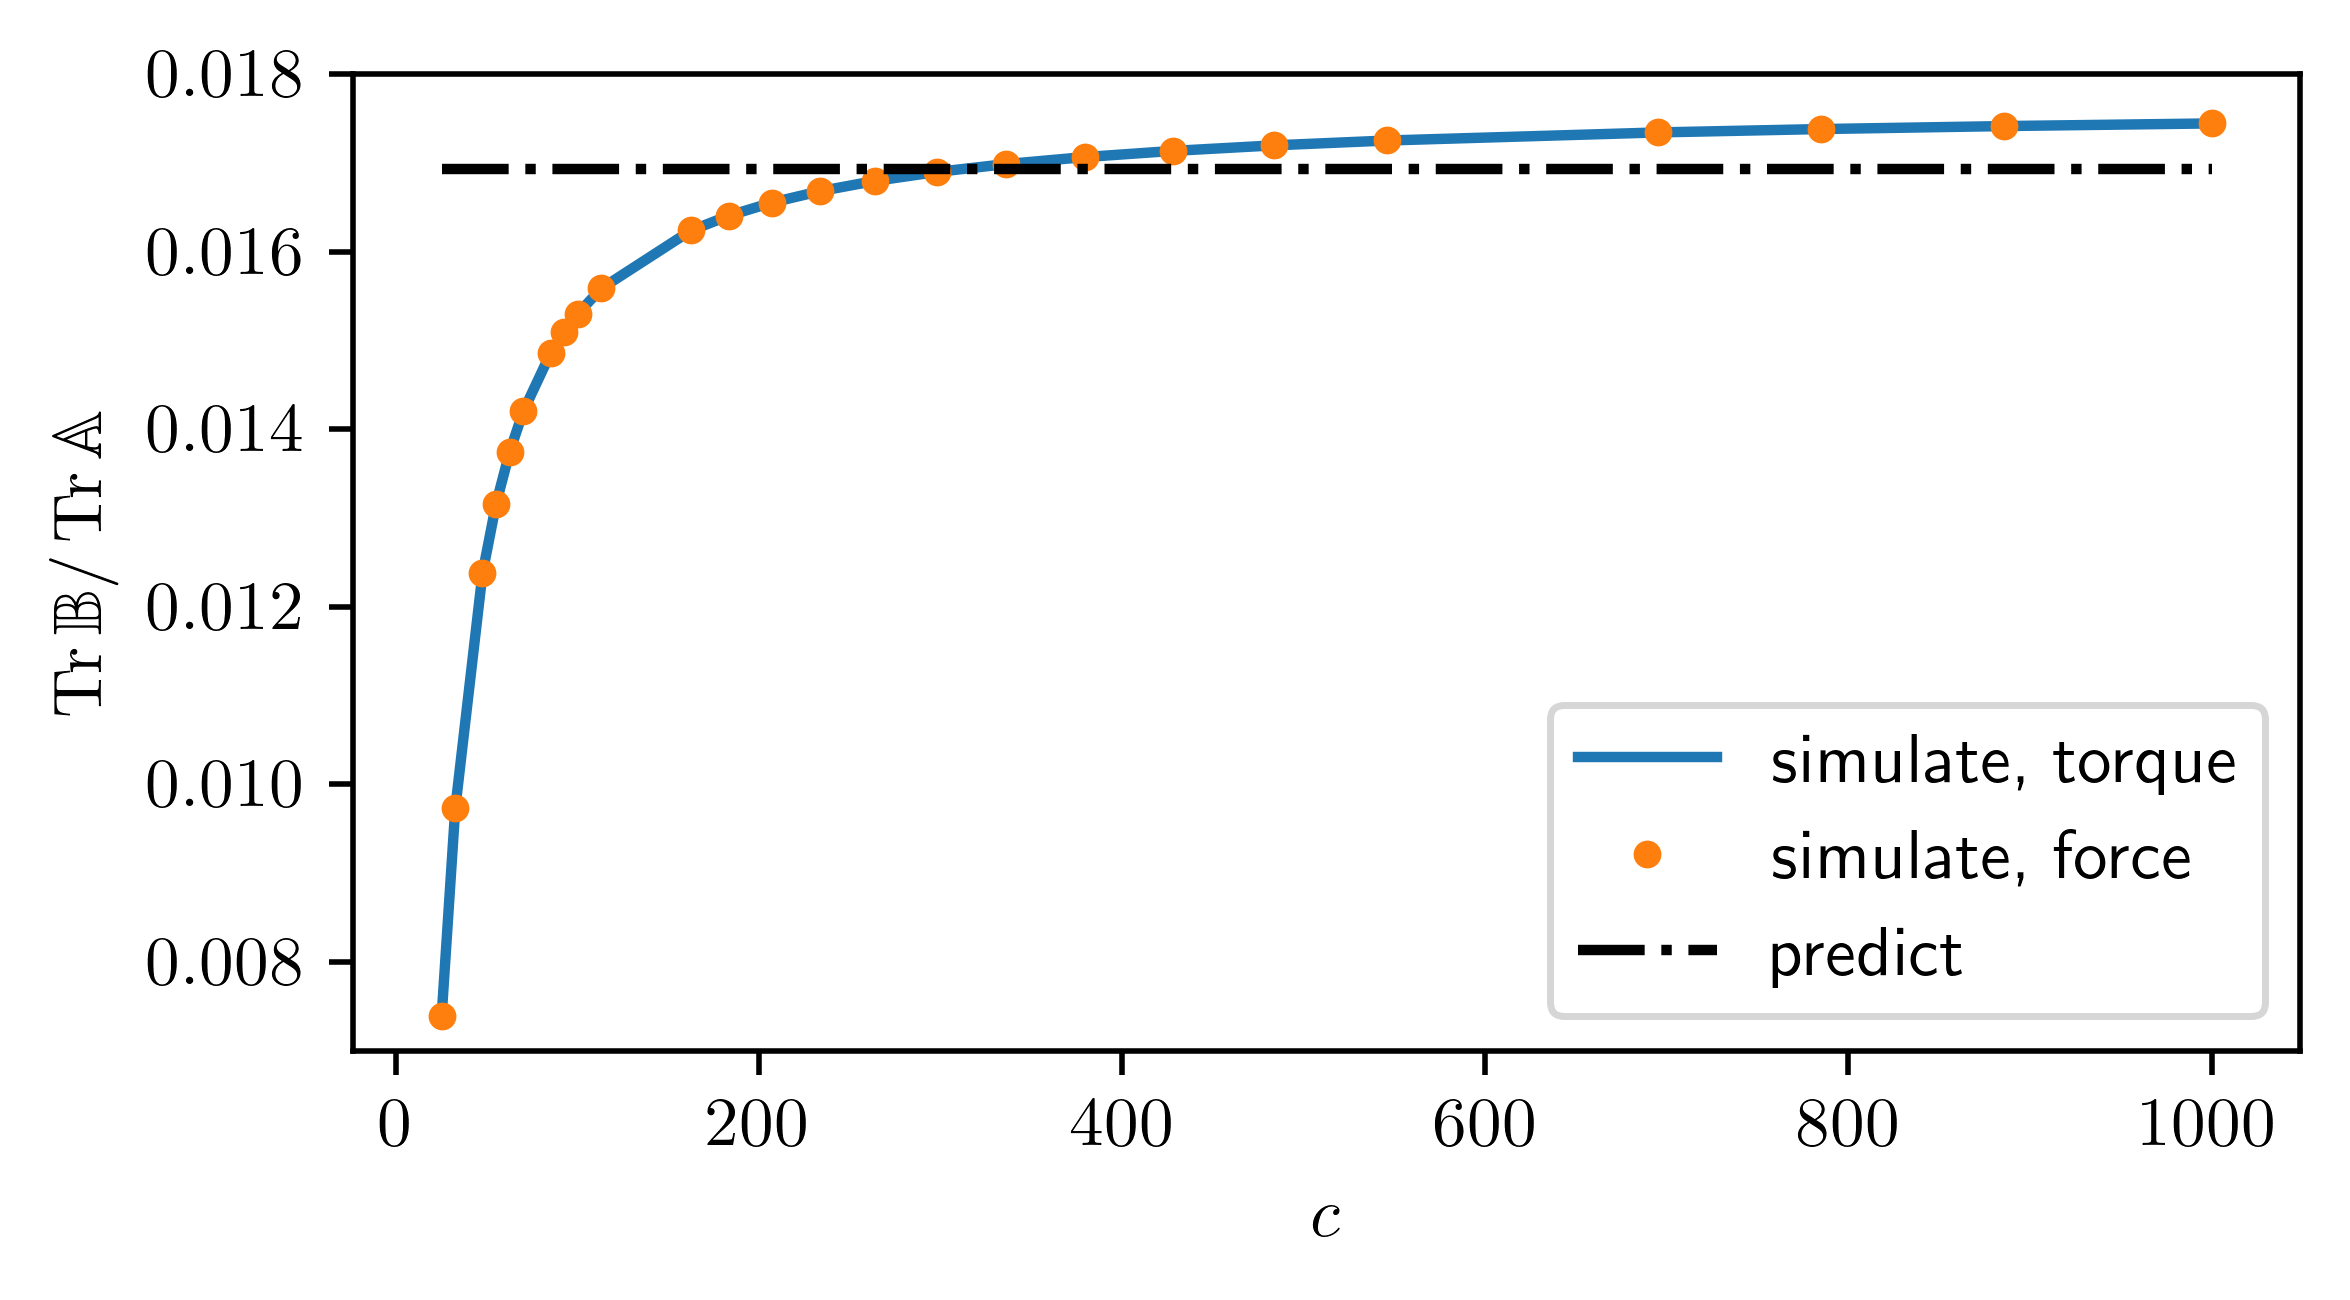

In [4]:
%matplotlib inline

figsize=np.array((16, 9))*0.3
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
vmin, vmax = 0.007, 0.018, 
part_TBTA = 0.016927728519288532
cmap = plt.get_cmap('seismic')

fig, axs = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')

axi = axs
t1 = data.B1 / data.A
thelicoid_r = t1.columns.values  # ch
axi.plot(thelicoid_r, t1.values.ravel(), '-', label='simulate, torque')
t1 = data.B2 / data.A
thelicoid_r = t1.columns.values  # ch
axi.plot(thelicoid_r, t1.values.ravel(), '.', label='simulate, force')
axi.plot(thelicoid_r, np.ones_like(thelicoid_r) * part_TBTA, '-.k', label='predict')
axi.set_xlabel('$c$')
axi.set_ylabel('$\\Tr \\mathbb{B} / \\Tr \\mathbb{A}$')
axi.legend()
axi.set_ylim(vmin, vmax)
# axi.set_xscale('log')

plt.tight_layout()

In [5]:
job_dir = 'hlx_th0_a'
helicoid_r = 10

tdir = os.path.join(os.getcwd(), job_dir)
problem_kwarg_list, A_list, B1_list, B2_list, C_list = spf_re.load_ABC_list(tdir)
A_list = np.array([i0[2] for i0 in A_list])
B1_list = -np.array([i0[2] for i0 in B1_list])
B2_list = -np.array([i0[2] for i0 in B2_list])
C_list = np.array([i0[2] for i0 in C_list])
ph_list = np.array([i0['ph'] for i0 in problem_kwarg_list])
ch_list = np.array([i0['ch'] for i0 in problem_kwarg_list])
helicoid_r_list = np.array([i0['helicoid_r'] for i0 in problem_kwarg_list])

data = pd.DataFrame({'A': A_list, 
                     'B1': B1_list, 
                     'B2': B2_list, 
                     'C': C_list, 
                     'ph': ph_list, 
                     'ch': ch_list, 
                     'helicoid_r': helicoid_r_list, 
                     }).pivot_table(index=['ph', 'ch'], columns=['helicoid_r'])

t1 = (data.B1 / data.A)[helicoid_r].unstack()
t1

ch         1.0       1.5       2.0       2.5       3.0       3.5       4.0
ph                                                                        
1.0   0.000156 -0.000196 -0.000466  0.000304  0.000026  0.000514  0.000351
1.5  -0.000198 -0.000106 -0.000664  0.000239 -0.000014  0.000548  0.000421
2.0  -0.000781 -0.000142 -0.000470  0.000038 -0.000112  0.000487  0.000277
2.5  -0.000722  0.000070 -0.000394 -0.000028 -0.000094  0.000499  0.000223
3.0  -0.000577  0.000233 -0.000109  0.000125  0.000139  0.000571  0.000481
3.5  -0.000081  0.000911  0.000308  0.000416  0.000553  0.000815  0.001048
4.0   0.000298  0.001419  0.000779  0.000912  0.001038  0.001108  0.001685
4.5   0.000851  0.002083  0.001243  0.001380  0.001345  0.001415  0.001547
5.0   0.001129  0.002502  0.001651  0.001802  0.001665  0.001681  0.001152
5.5   0.000379  0.002888  0.002028  0.002119  0.001716  0.001581  0.000345
6.0   0.001662  0.003311  0.002279  0.002335  0.001826  0.001961  0.000456
6.5   0.001799  0.003341  0.002418  0.002239  0.001673  0.002245  0.001033
7.0   0.001803  0.003132  0.002388  0.001988  0.001784  0.002859  0.001685
7.5   0.001769  0.003149  0.002190  0.001610  0.001899  0.003779  0.002409
8.0   0.001734  0.002761  0.002271  0.000961  0.001894  0.004181  0.002941
8.5   0.001473  0.002401  0.001986  0.000527  0.002147  0.004050  0.003342
9.0   0.001343  0.002304  0.001282  0.000317  0.001946  0.004217  0.003365
9.5   0.001134  0.002193  0.000981  0.000036  0.002229  0.004115  0.003393
10.0  0.000847  0.001953  0.000930  0.000077  0.002023  0.003976  0.003805

<ipython-input-6-d23f3e407e13>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)


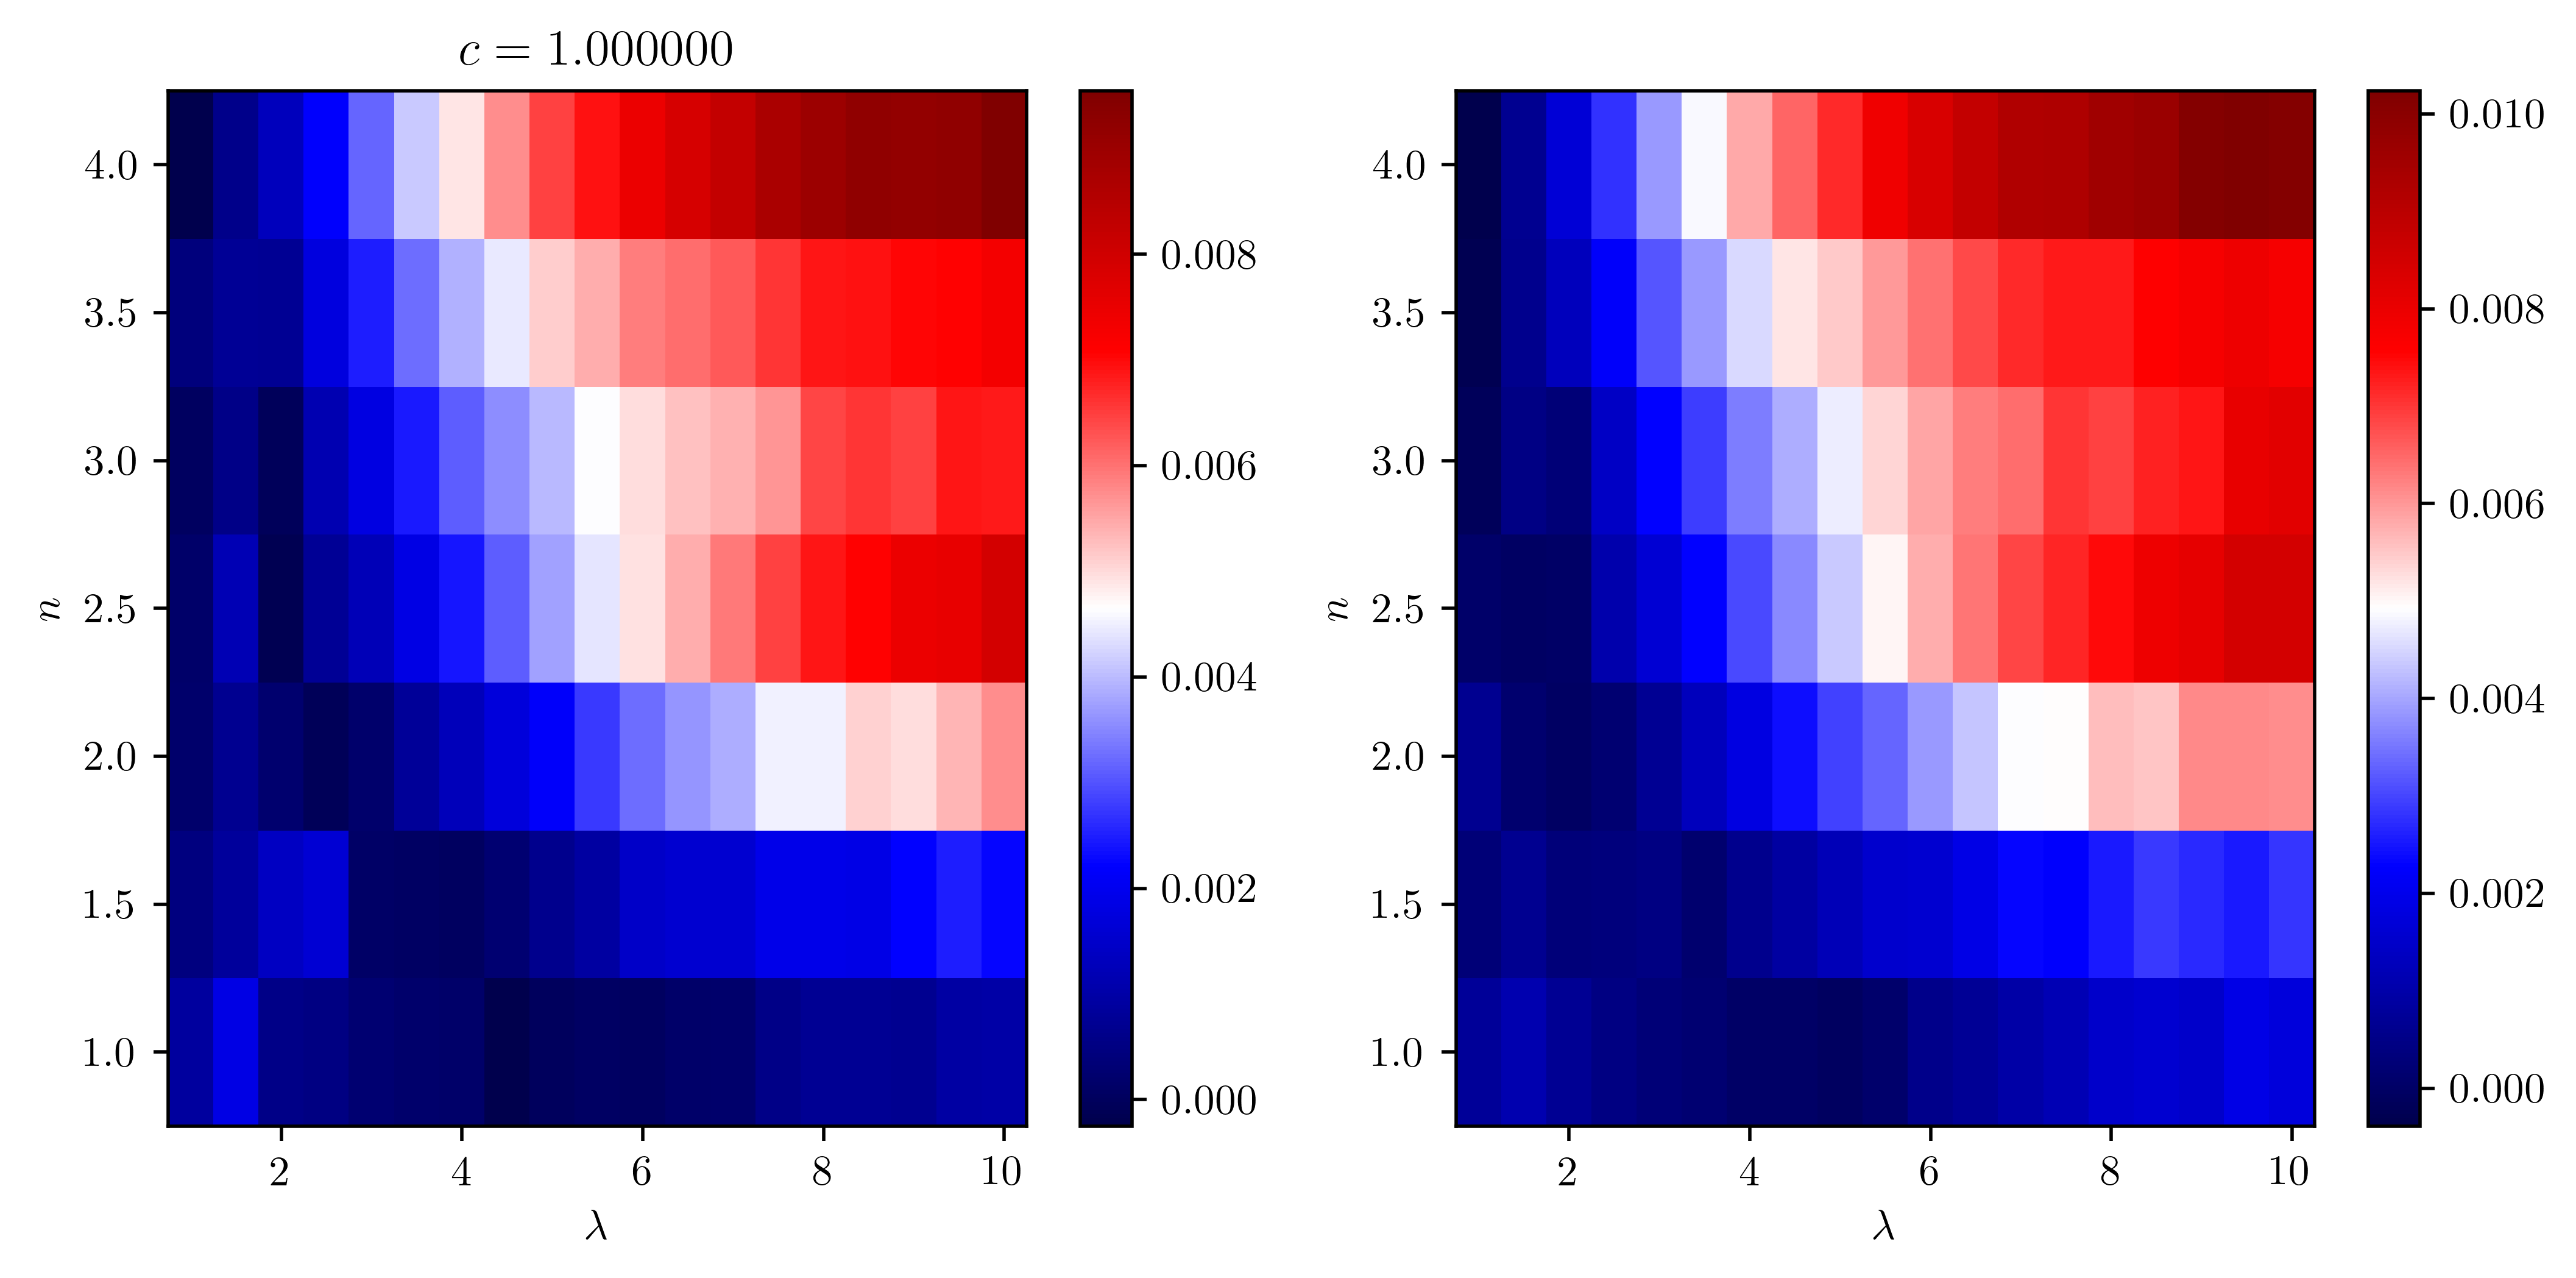

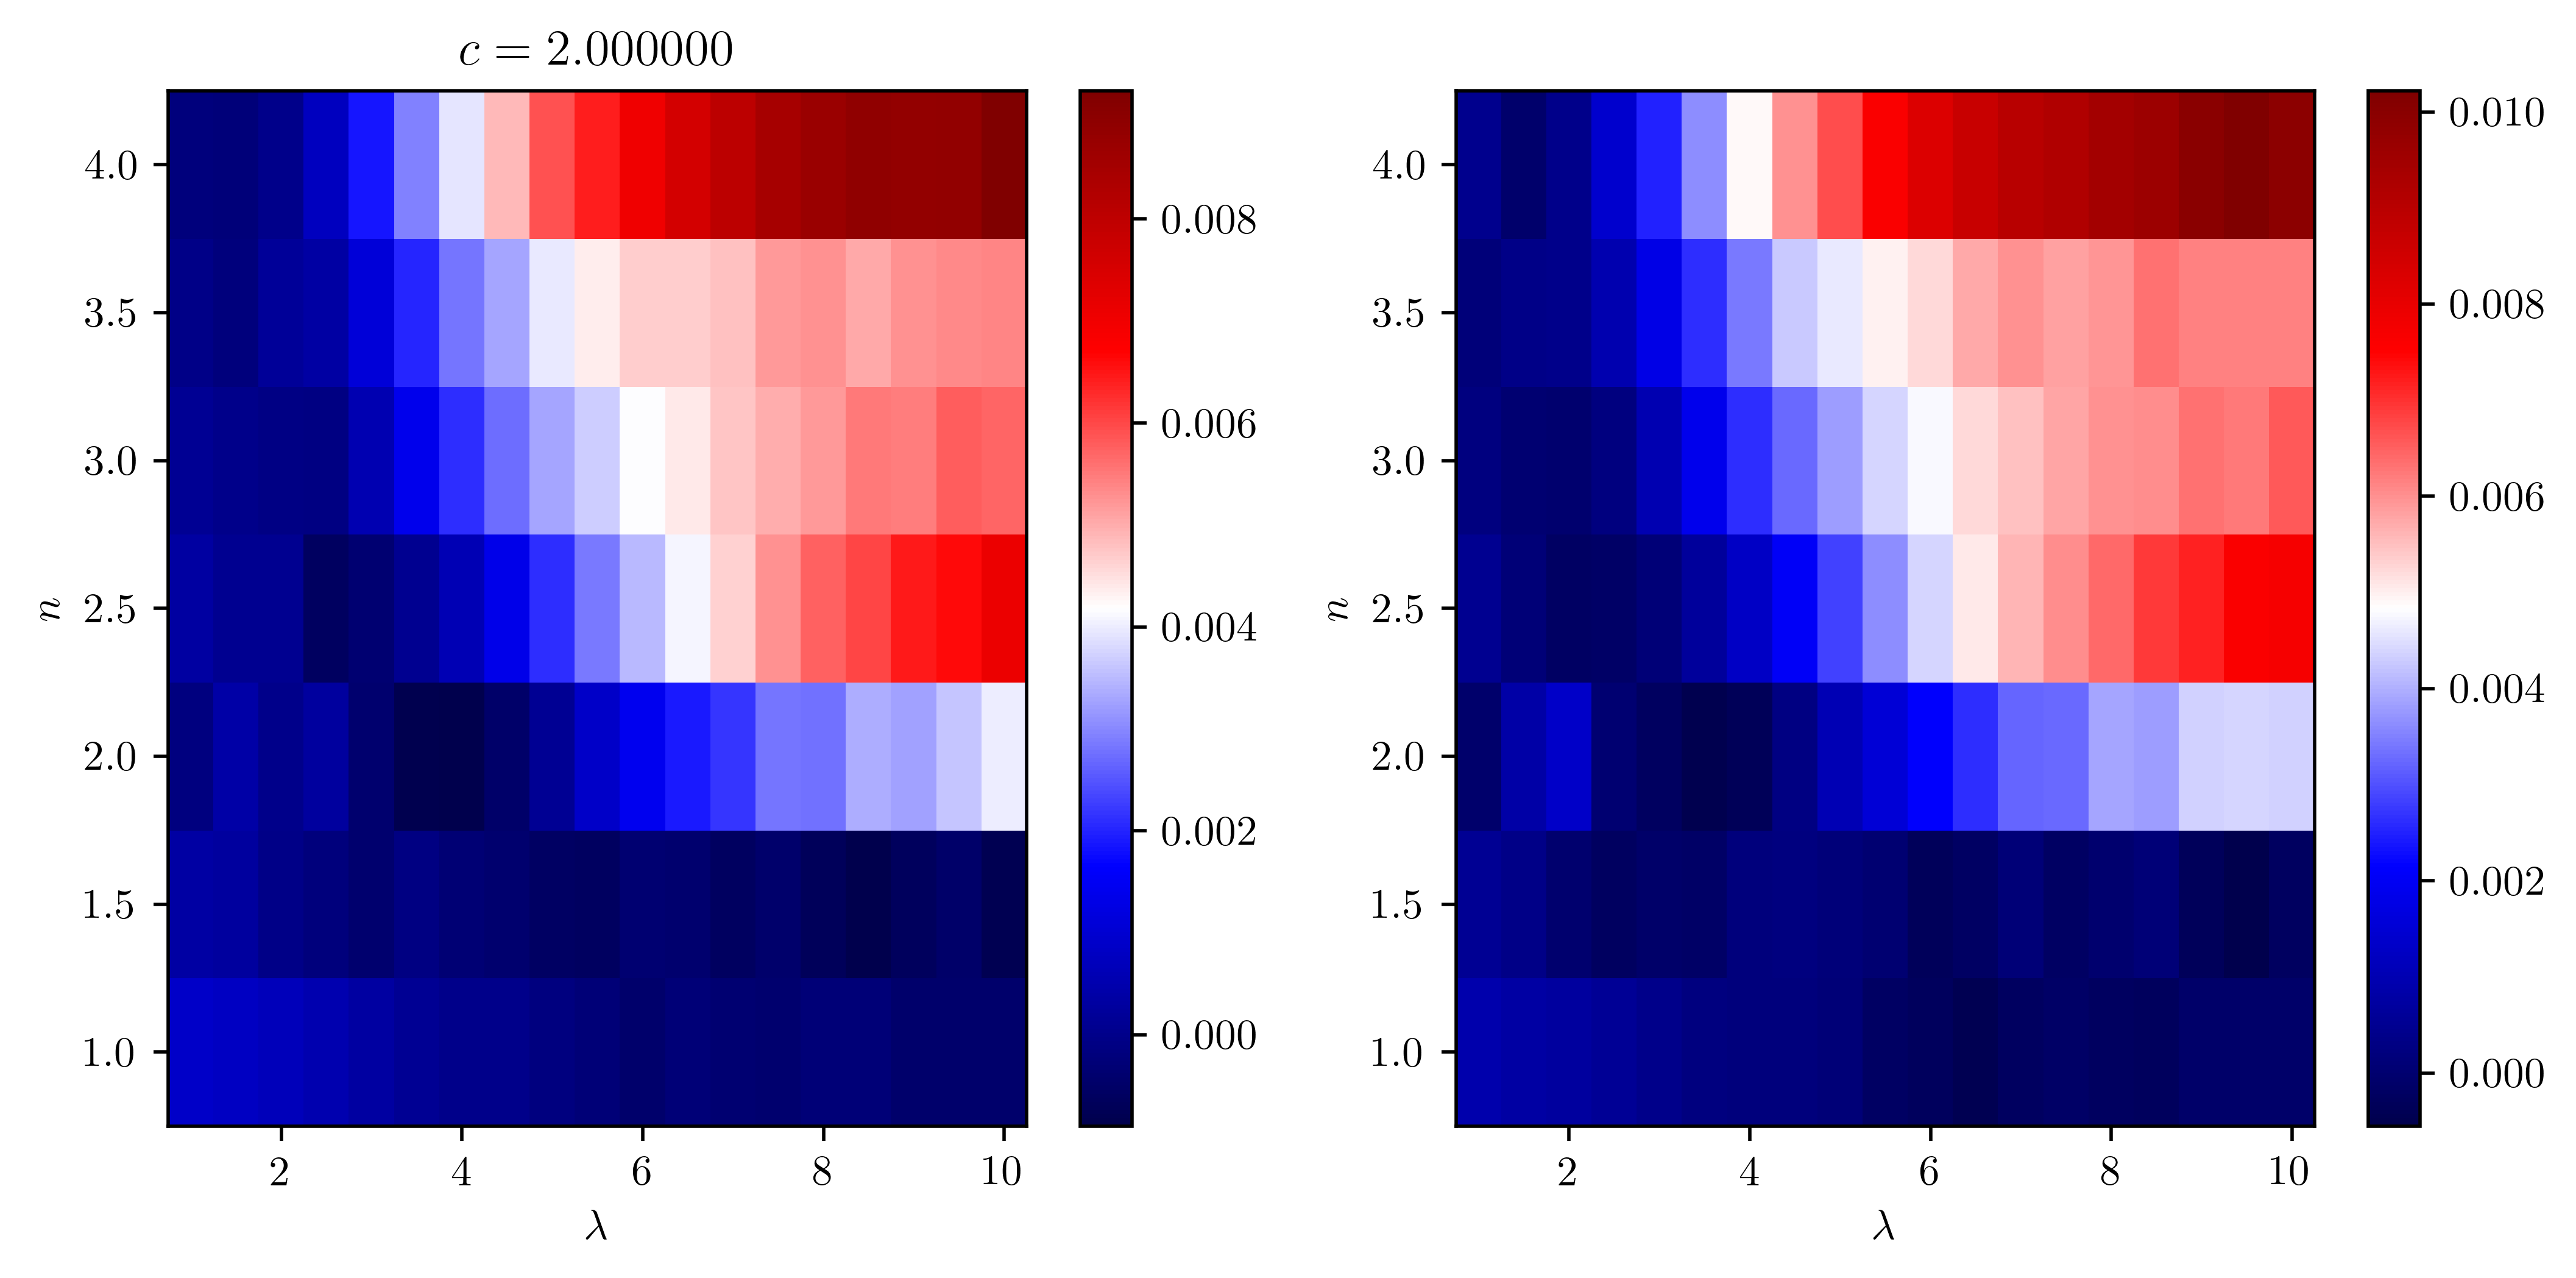

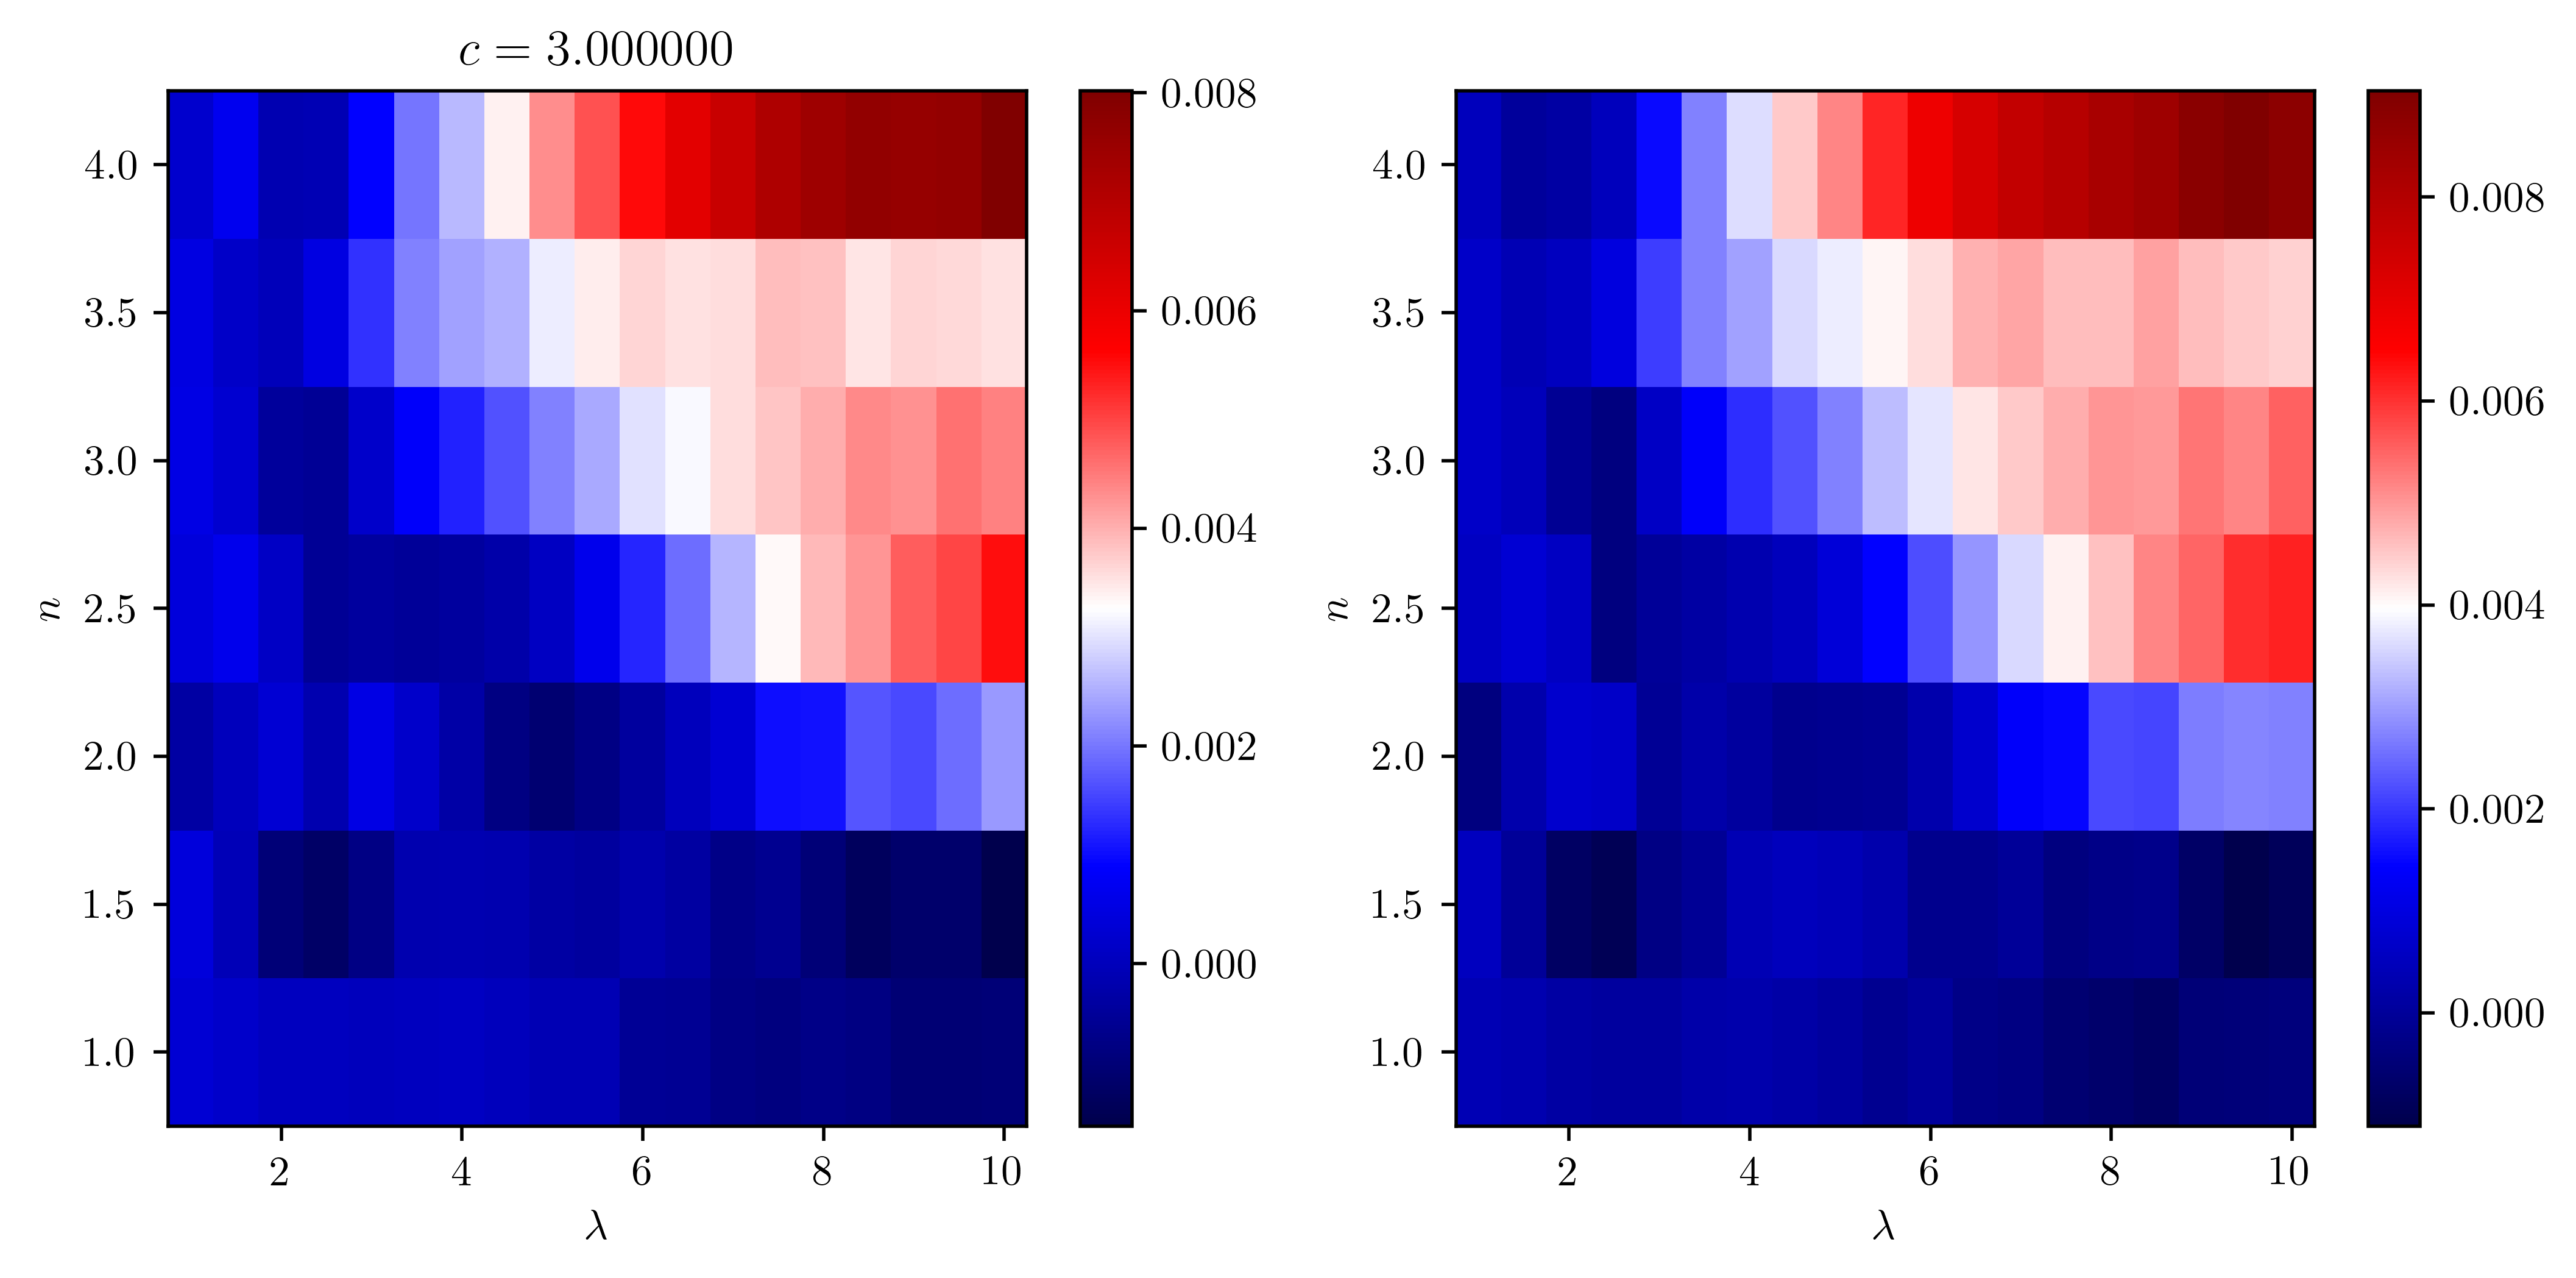

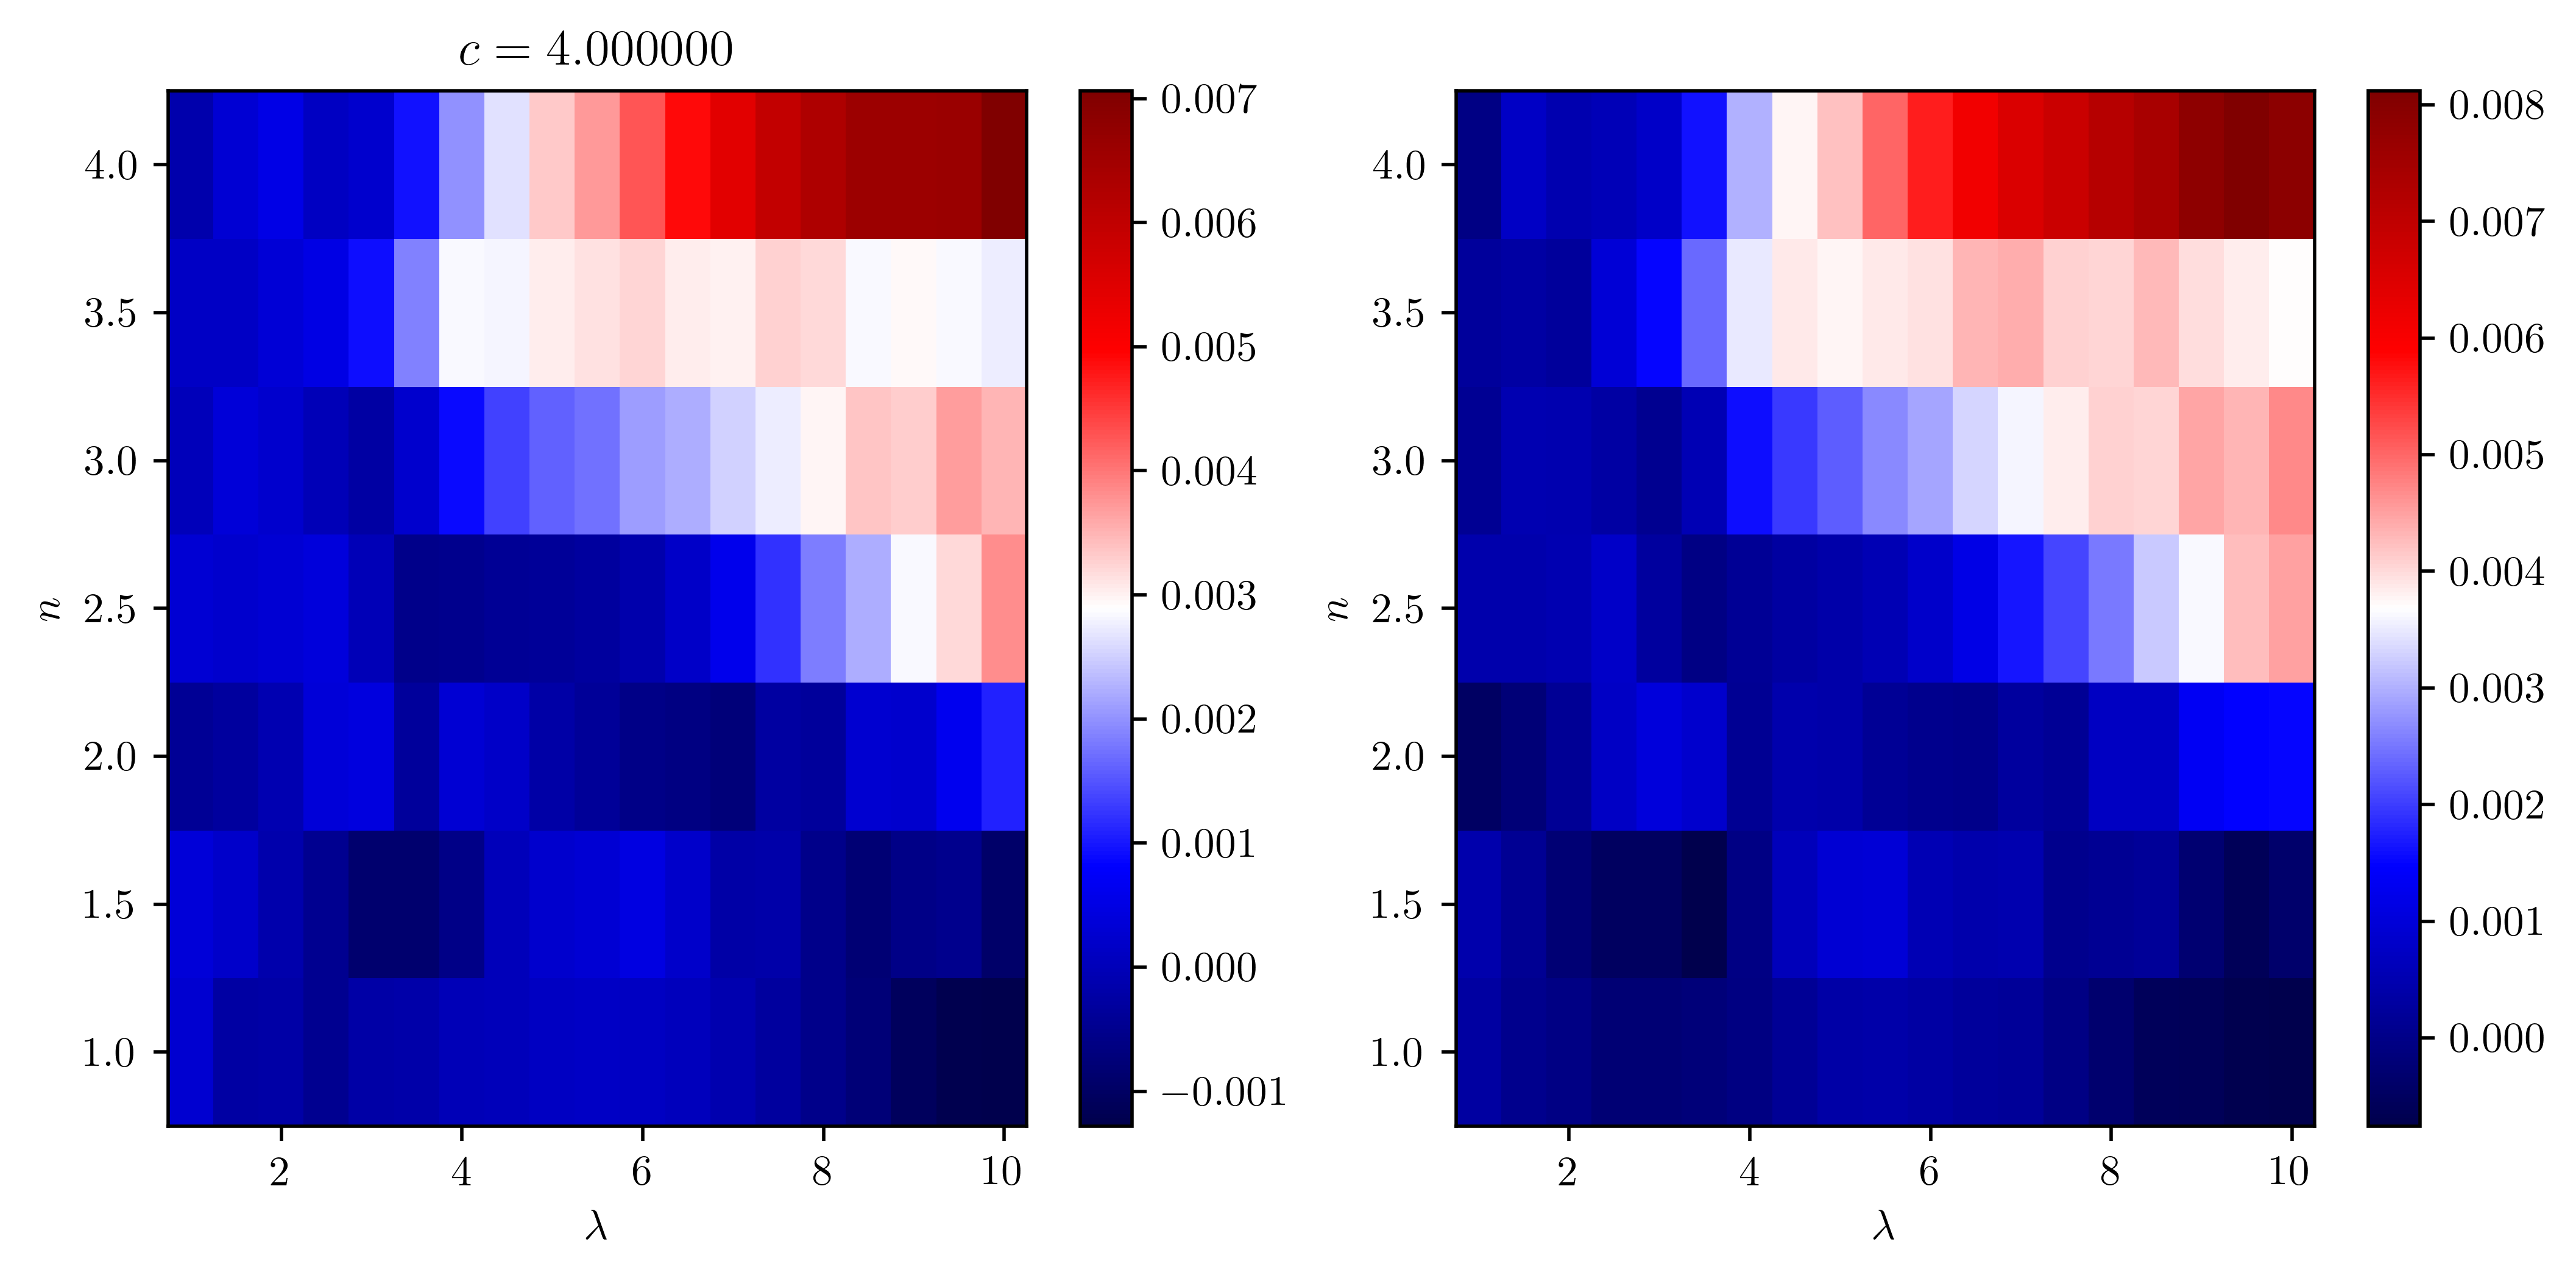

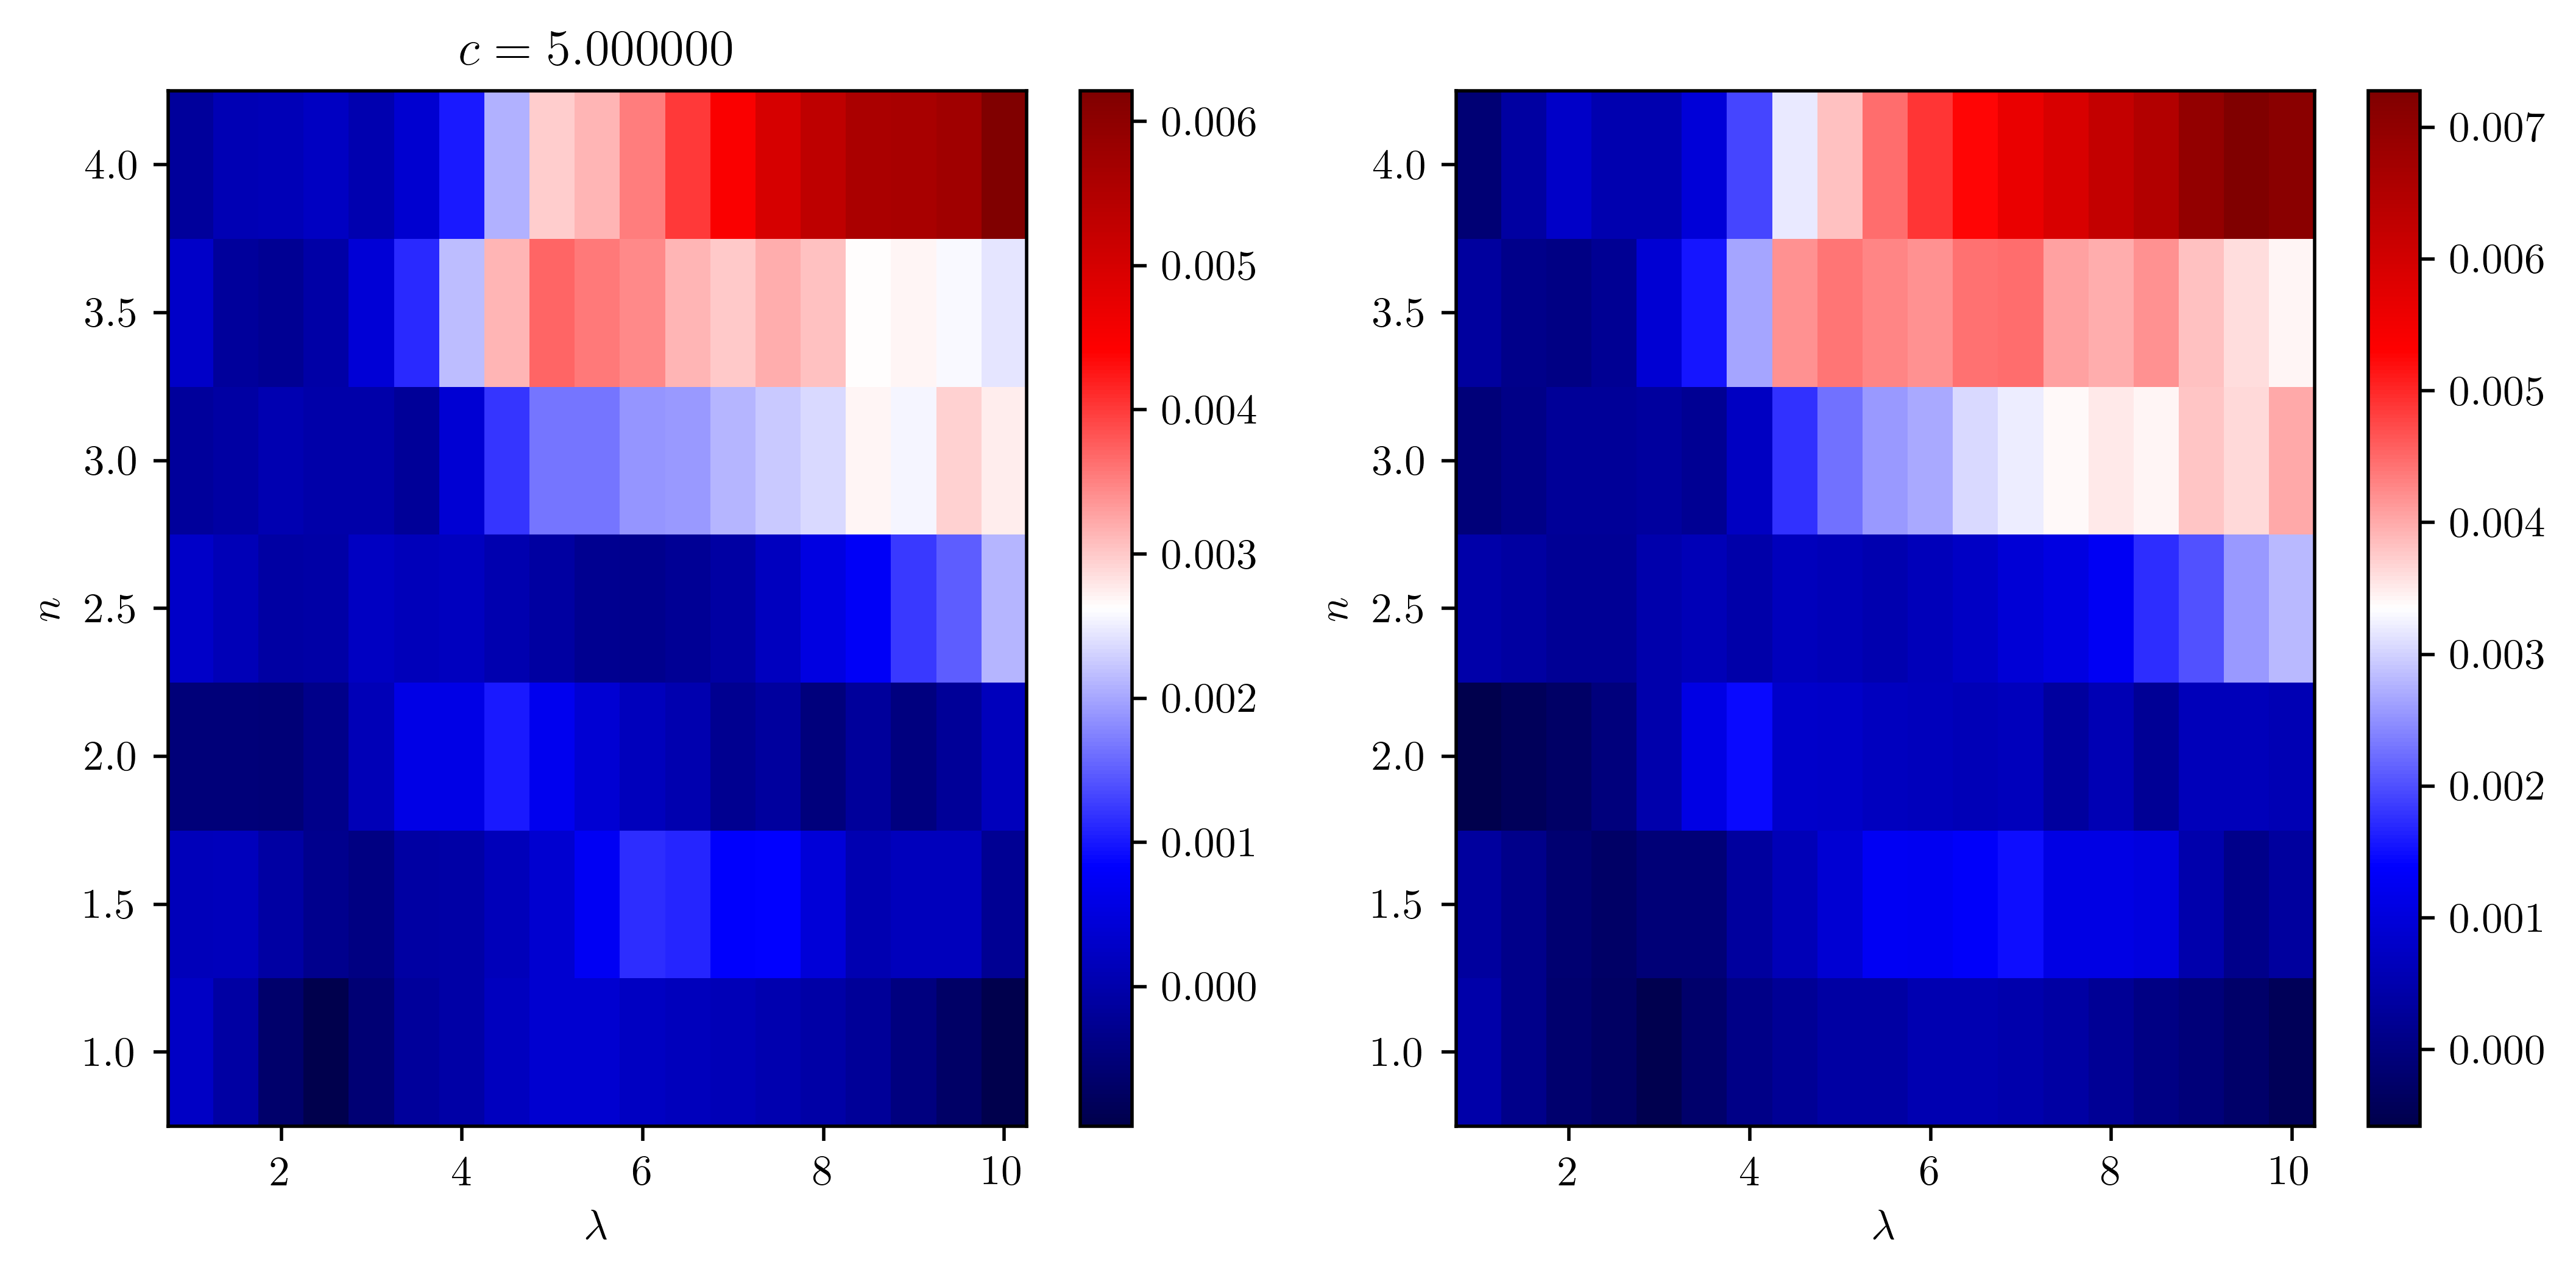

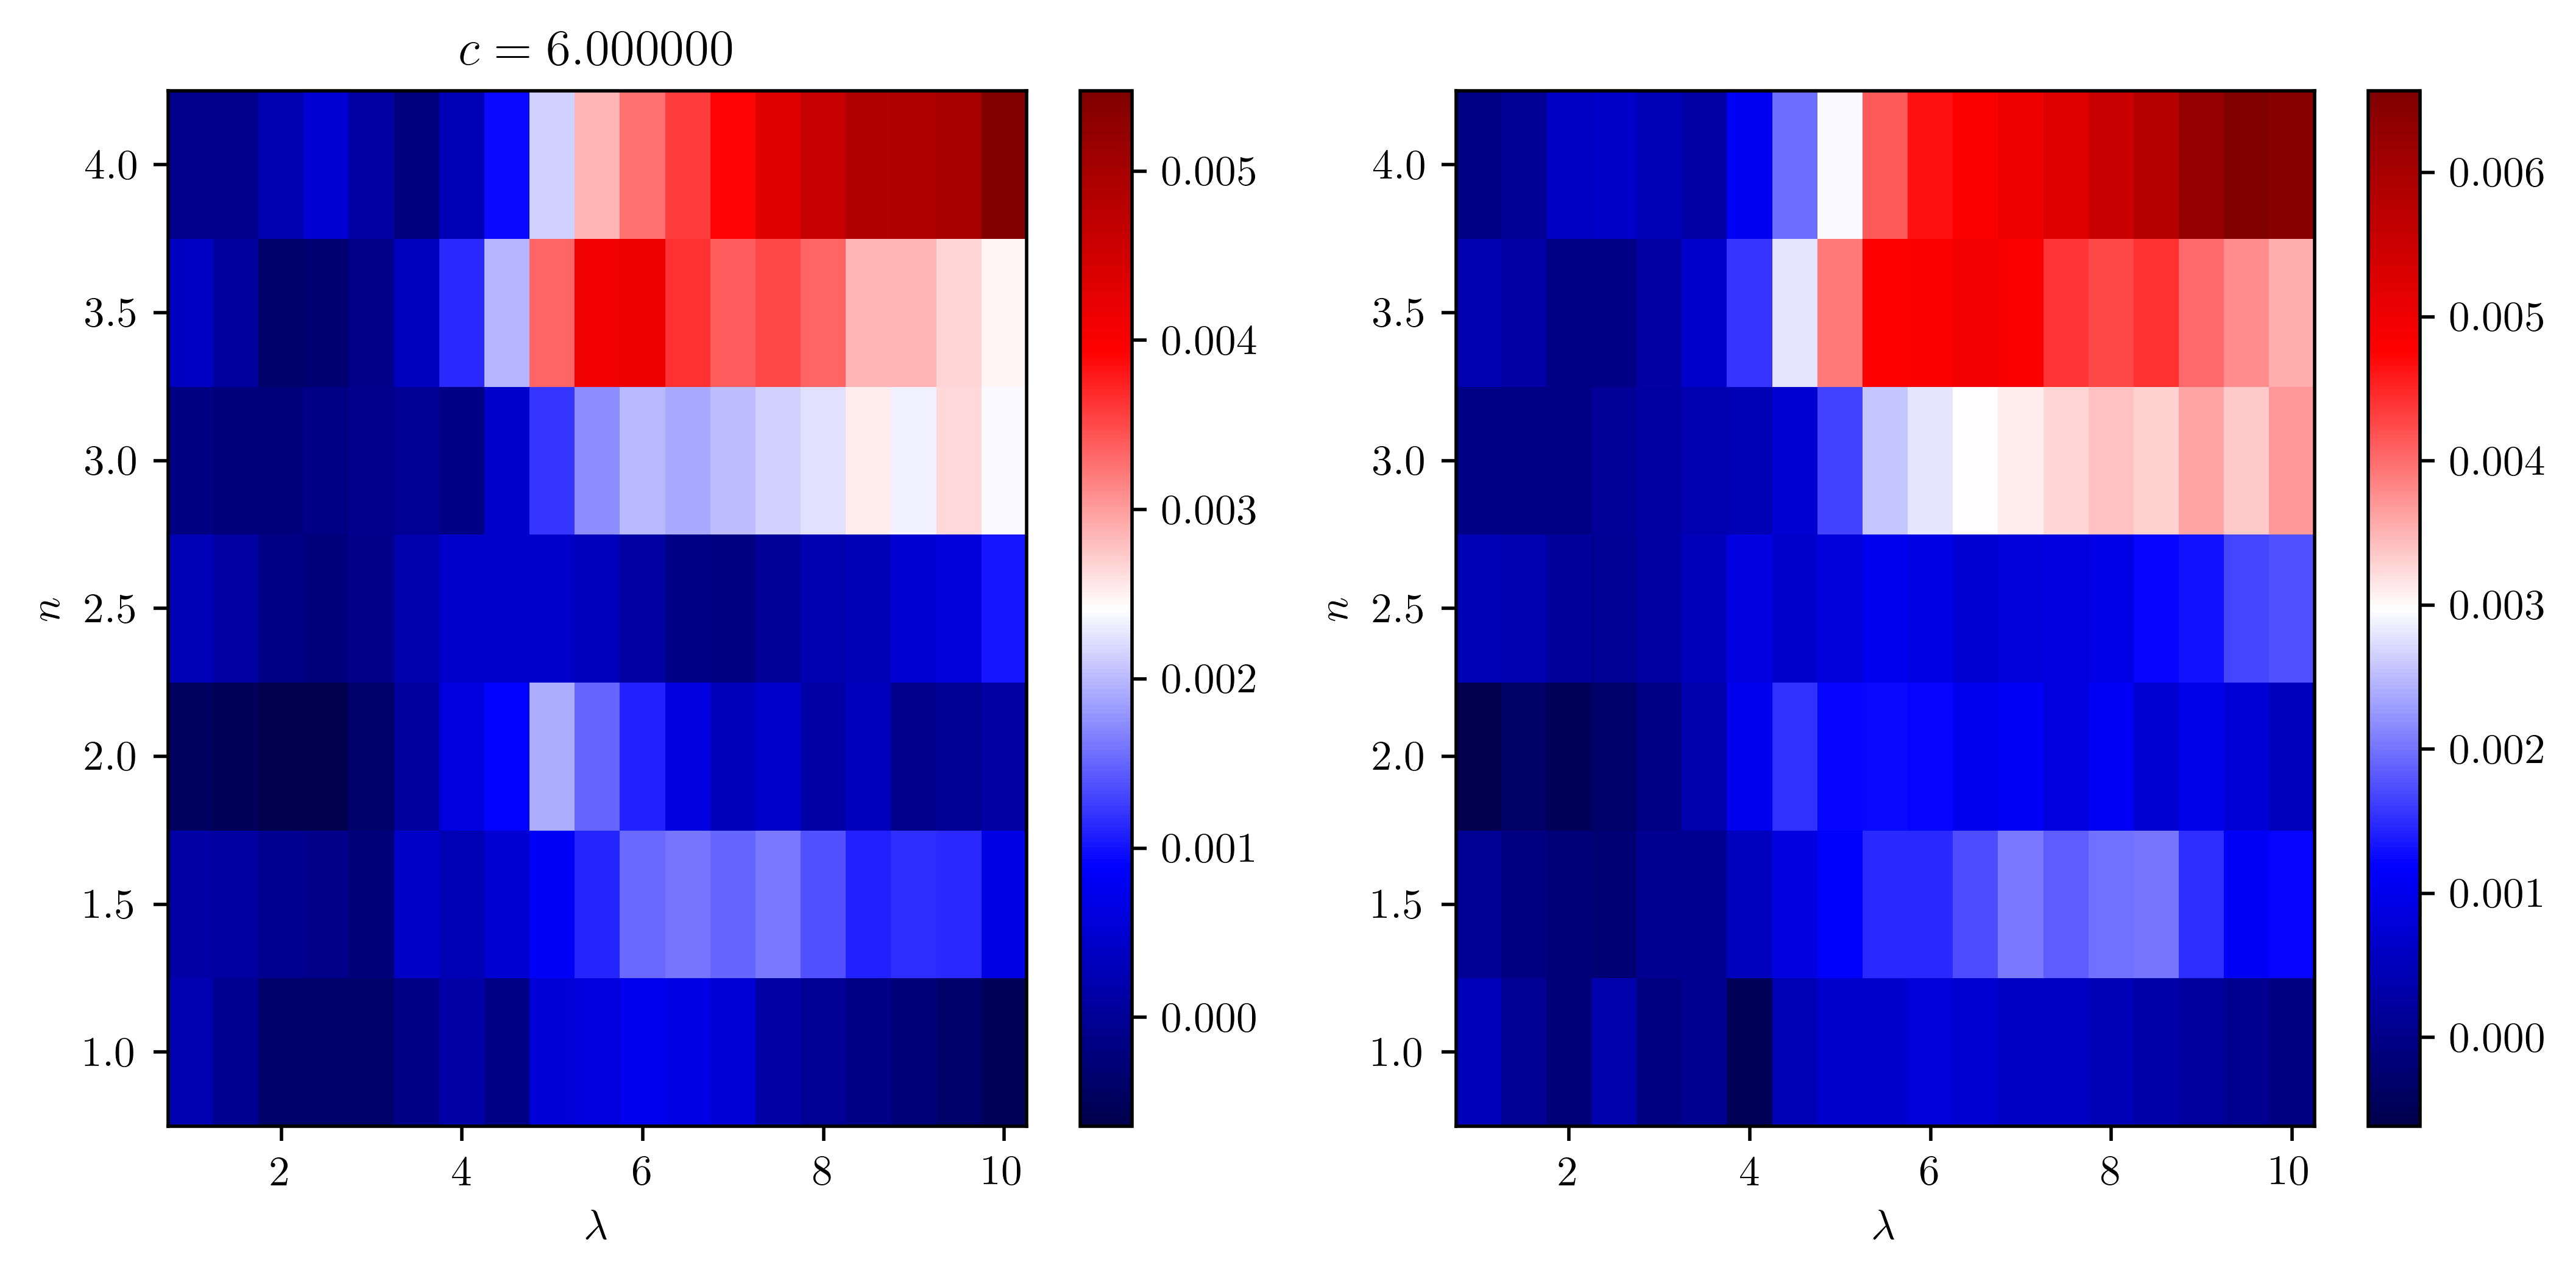

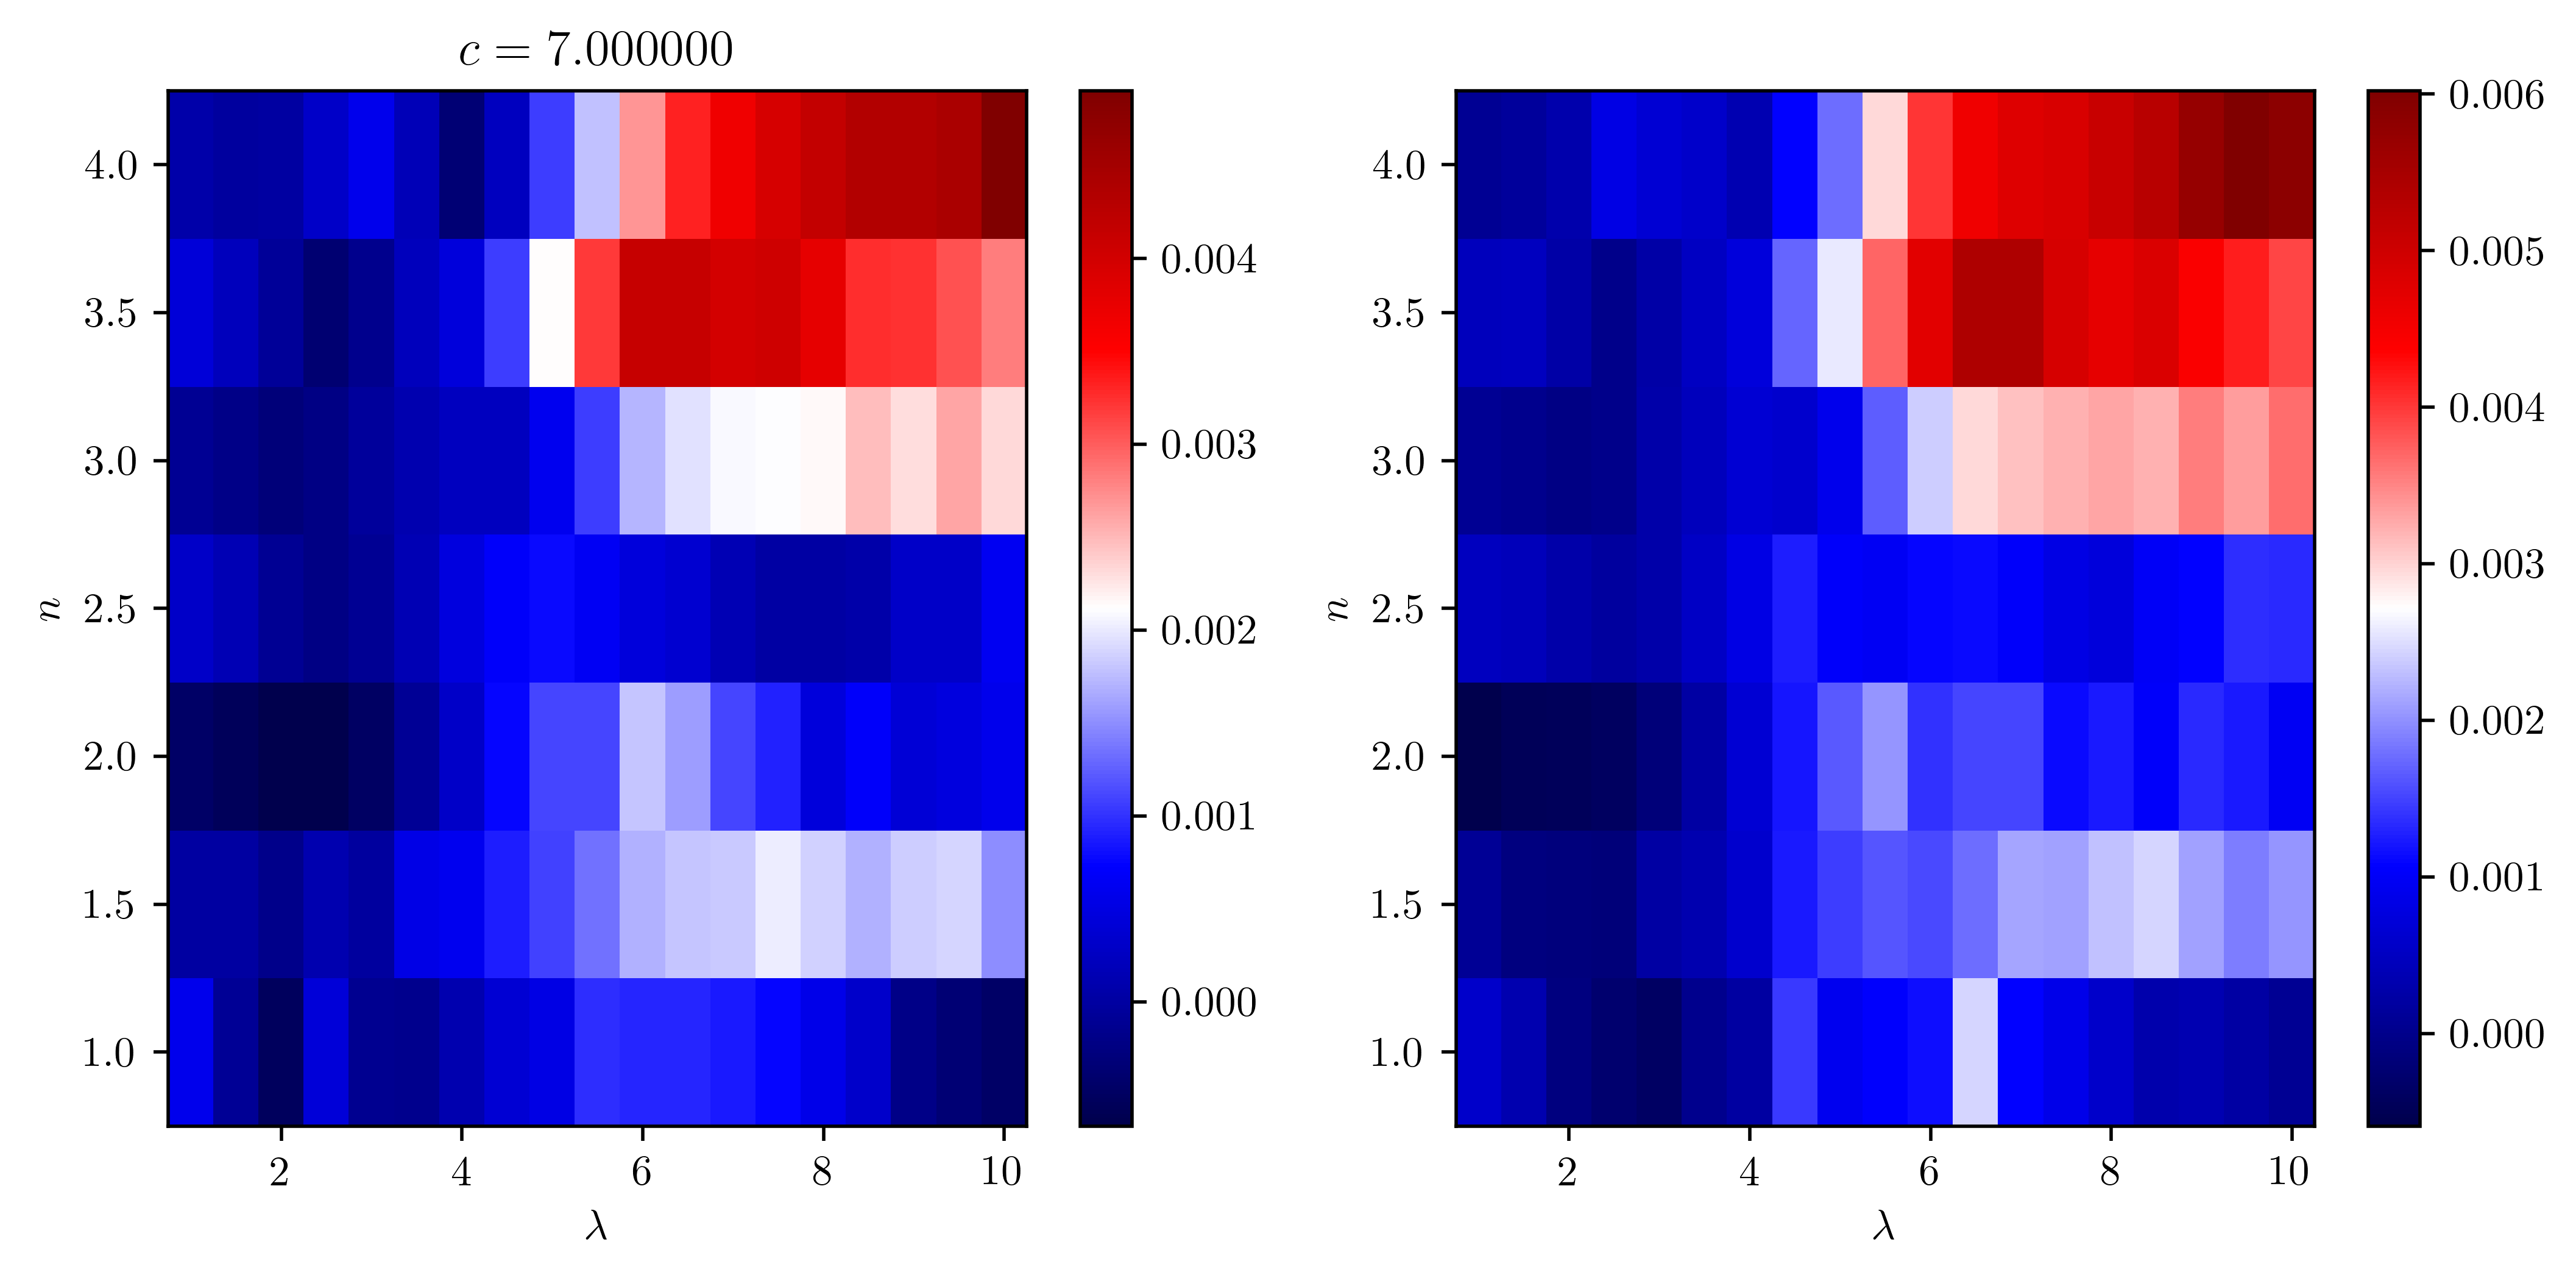

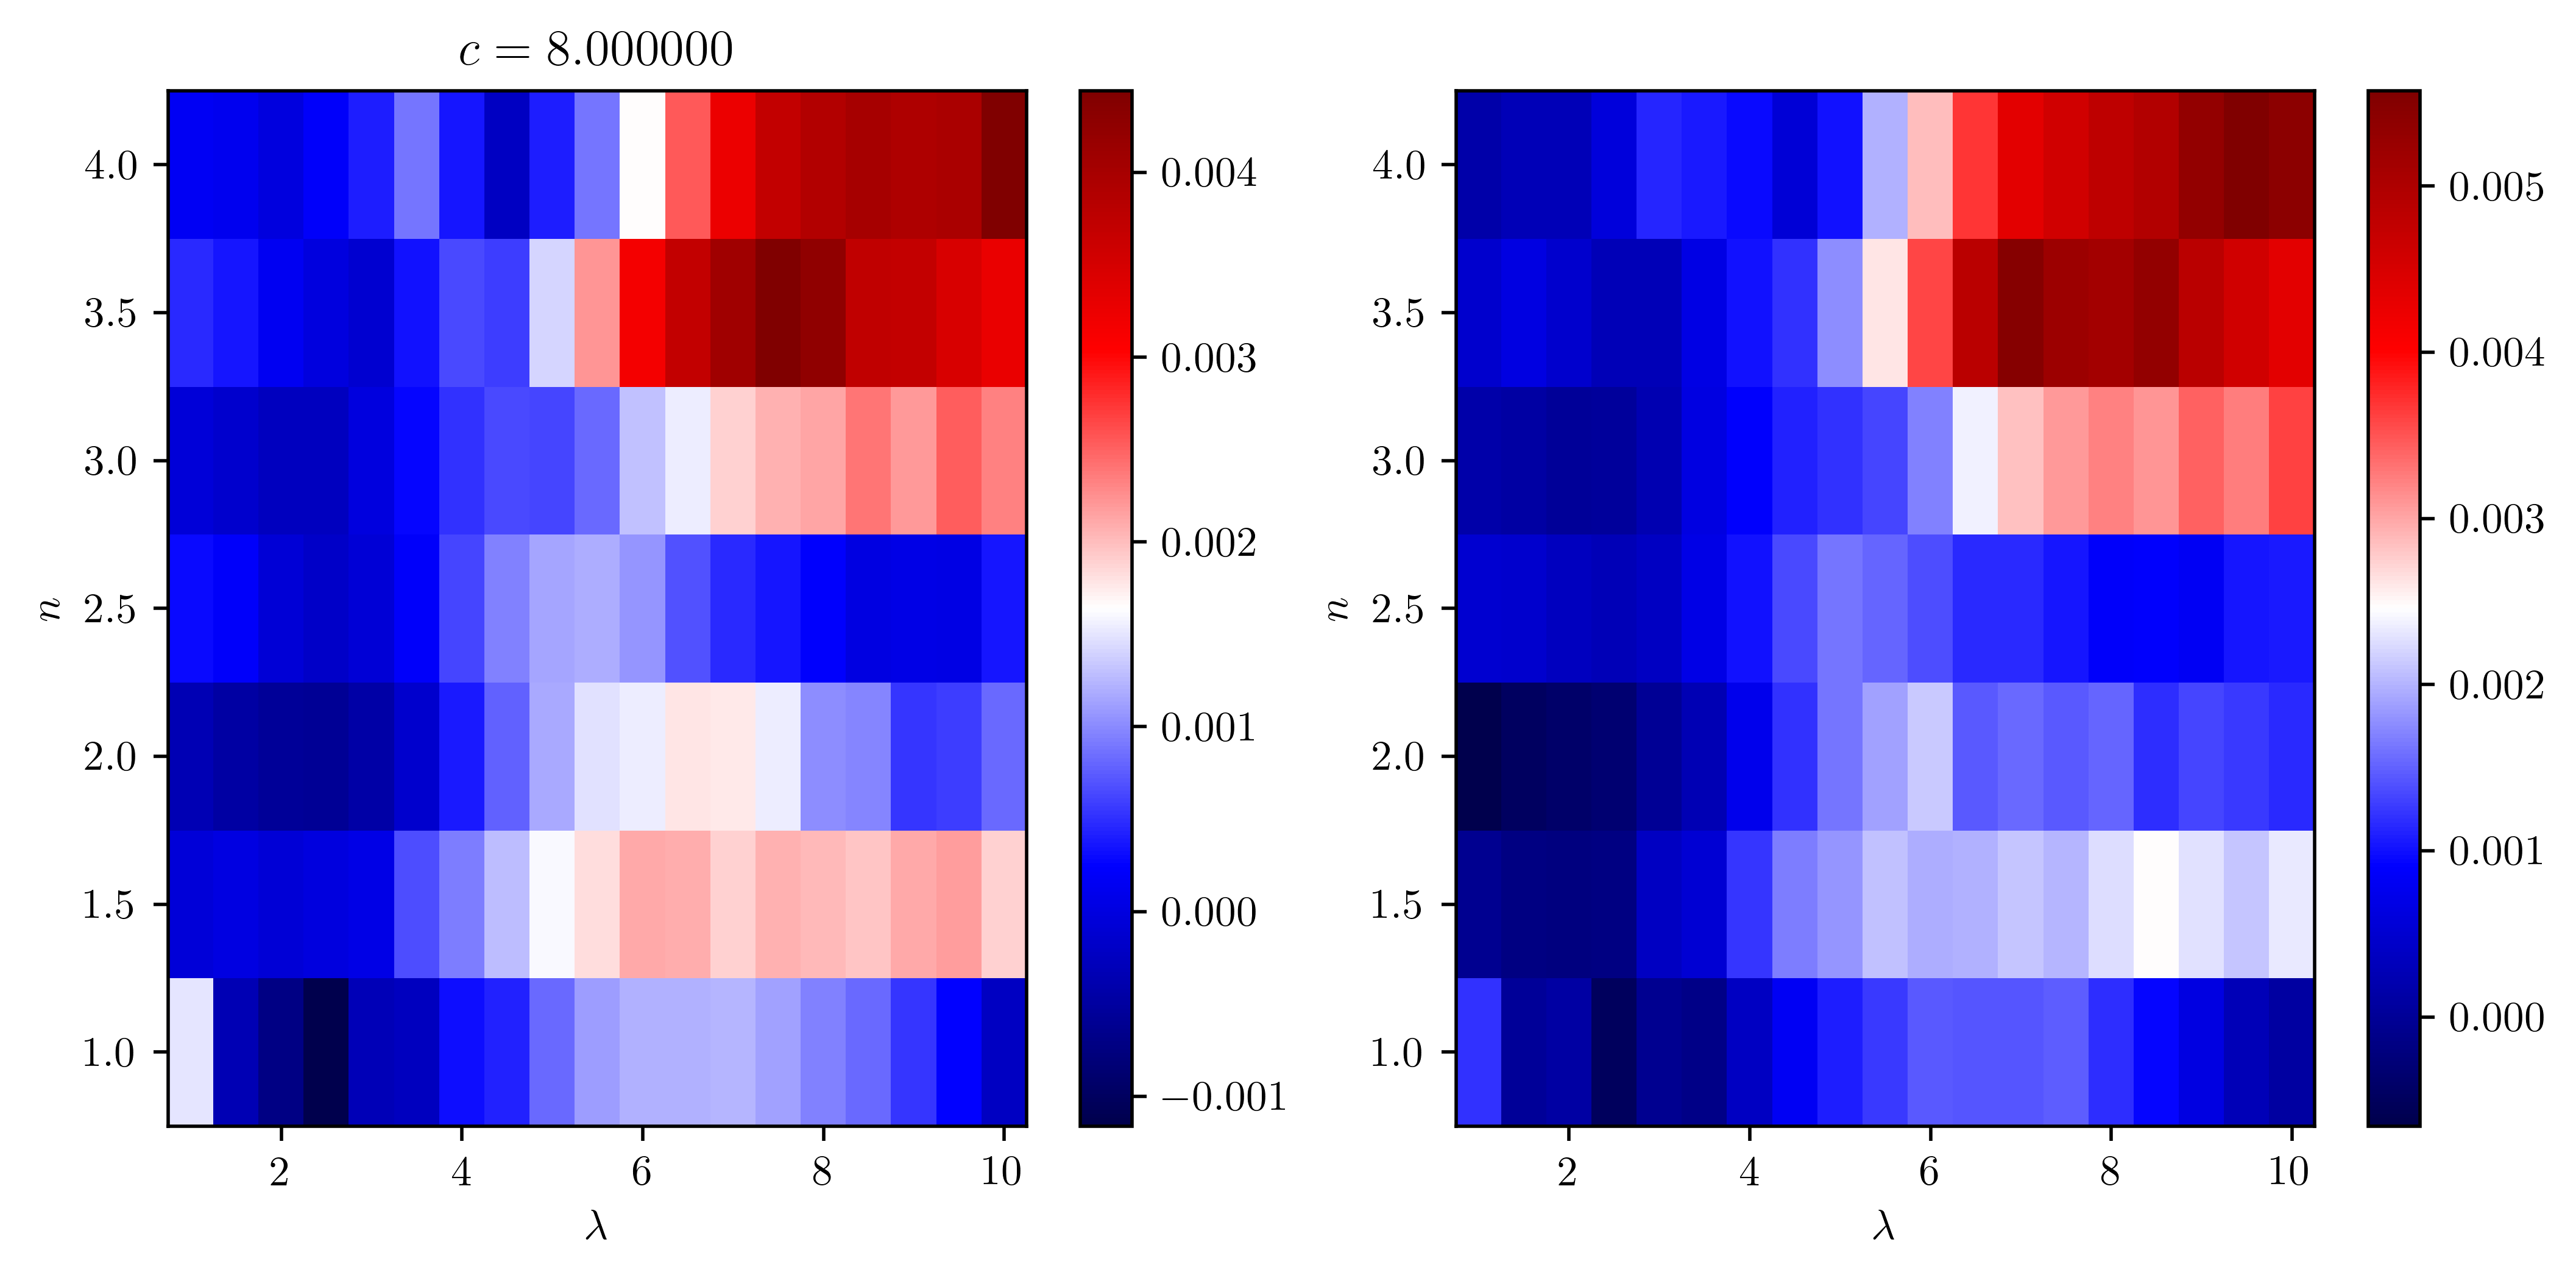

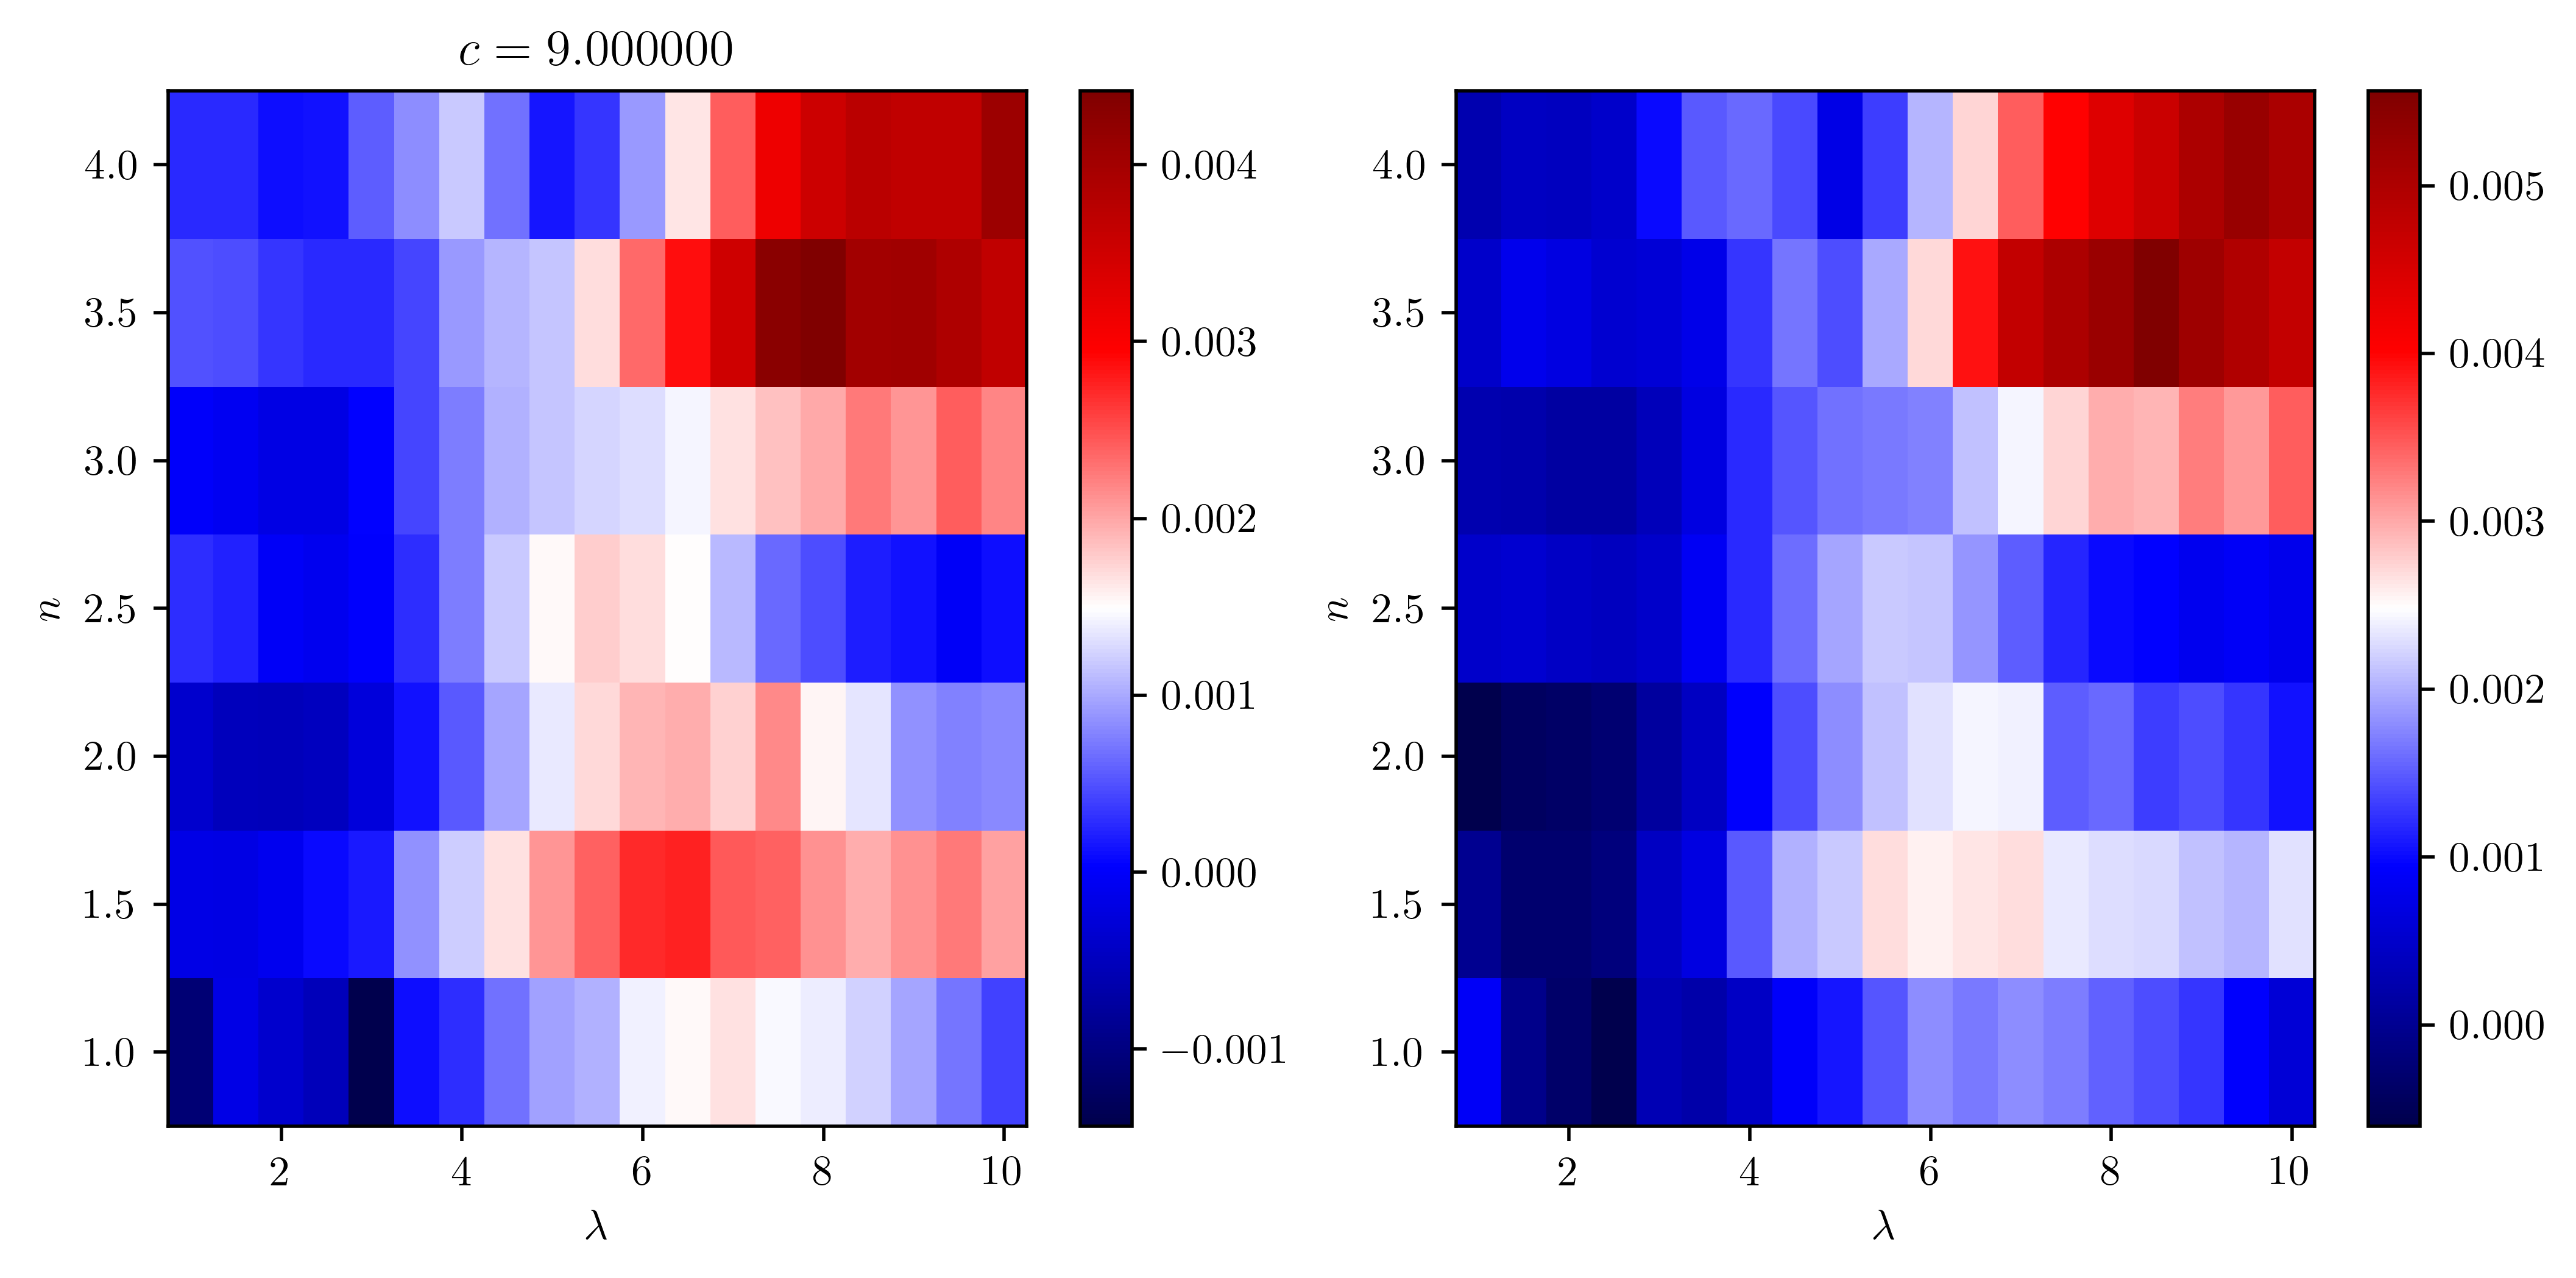

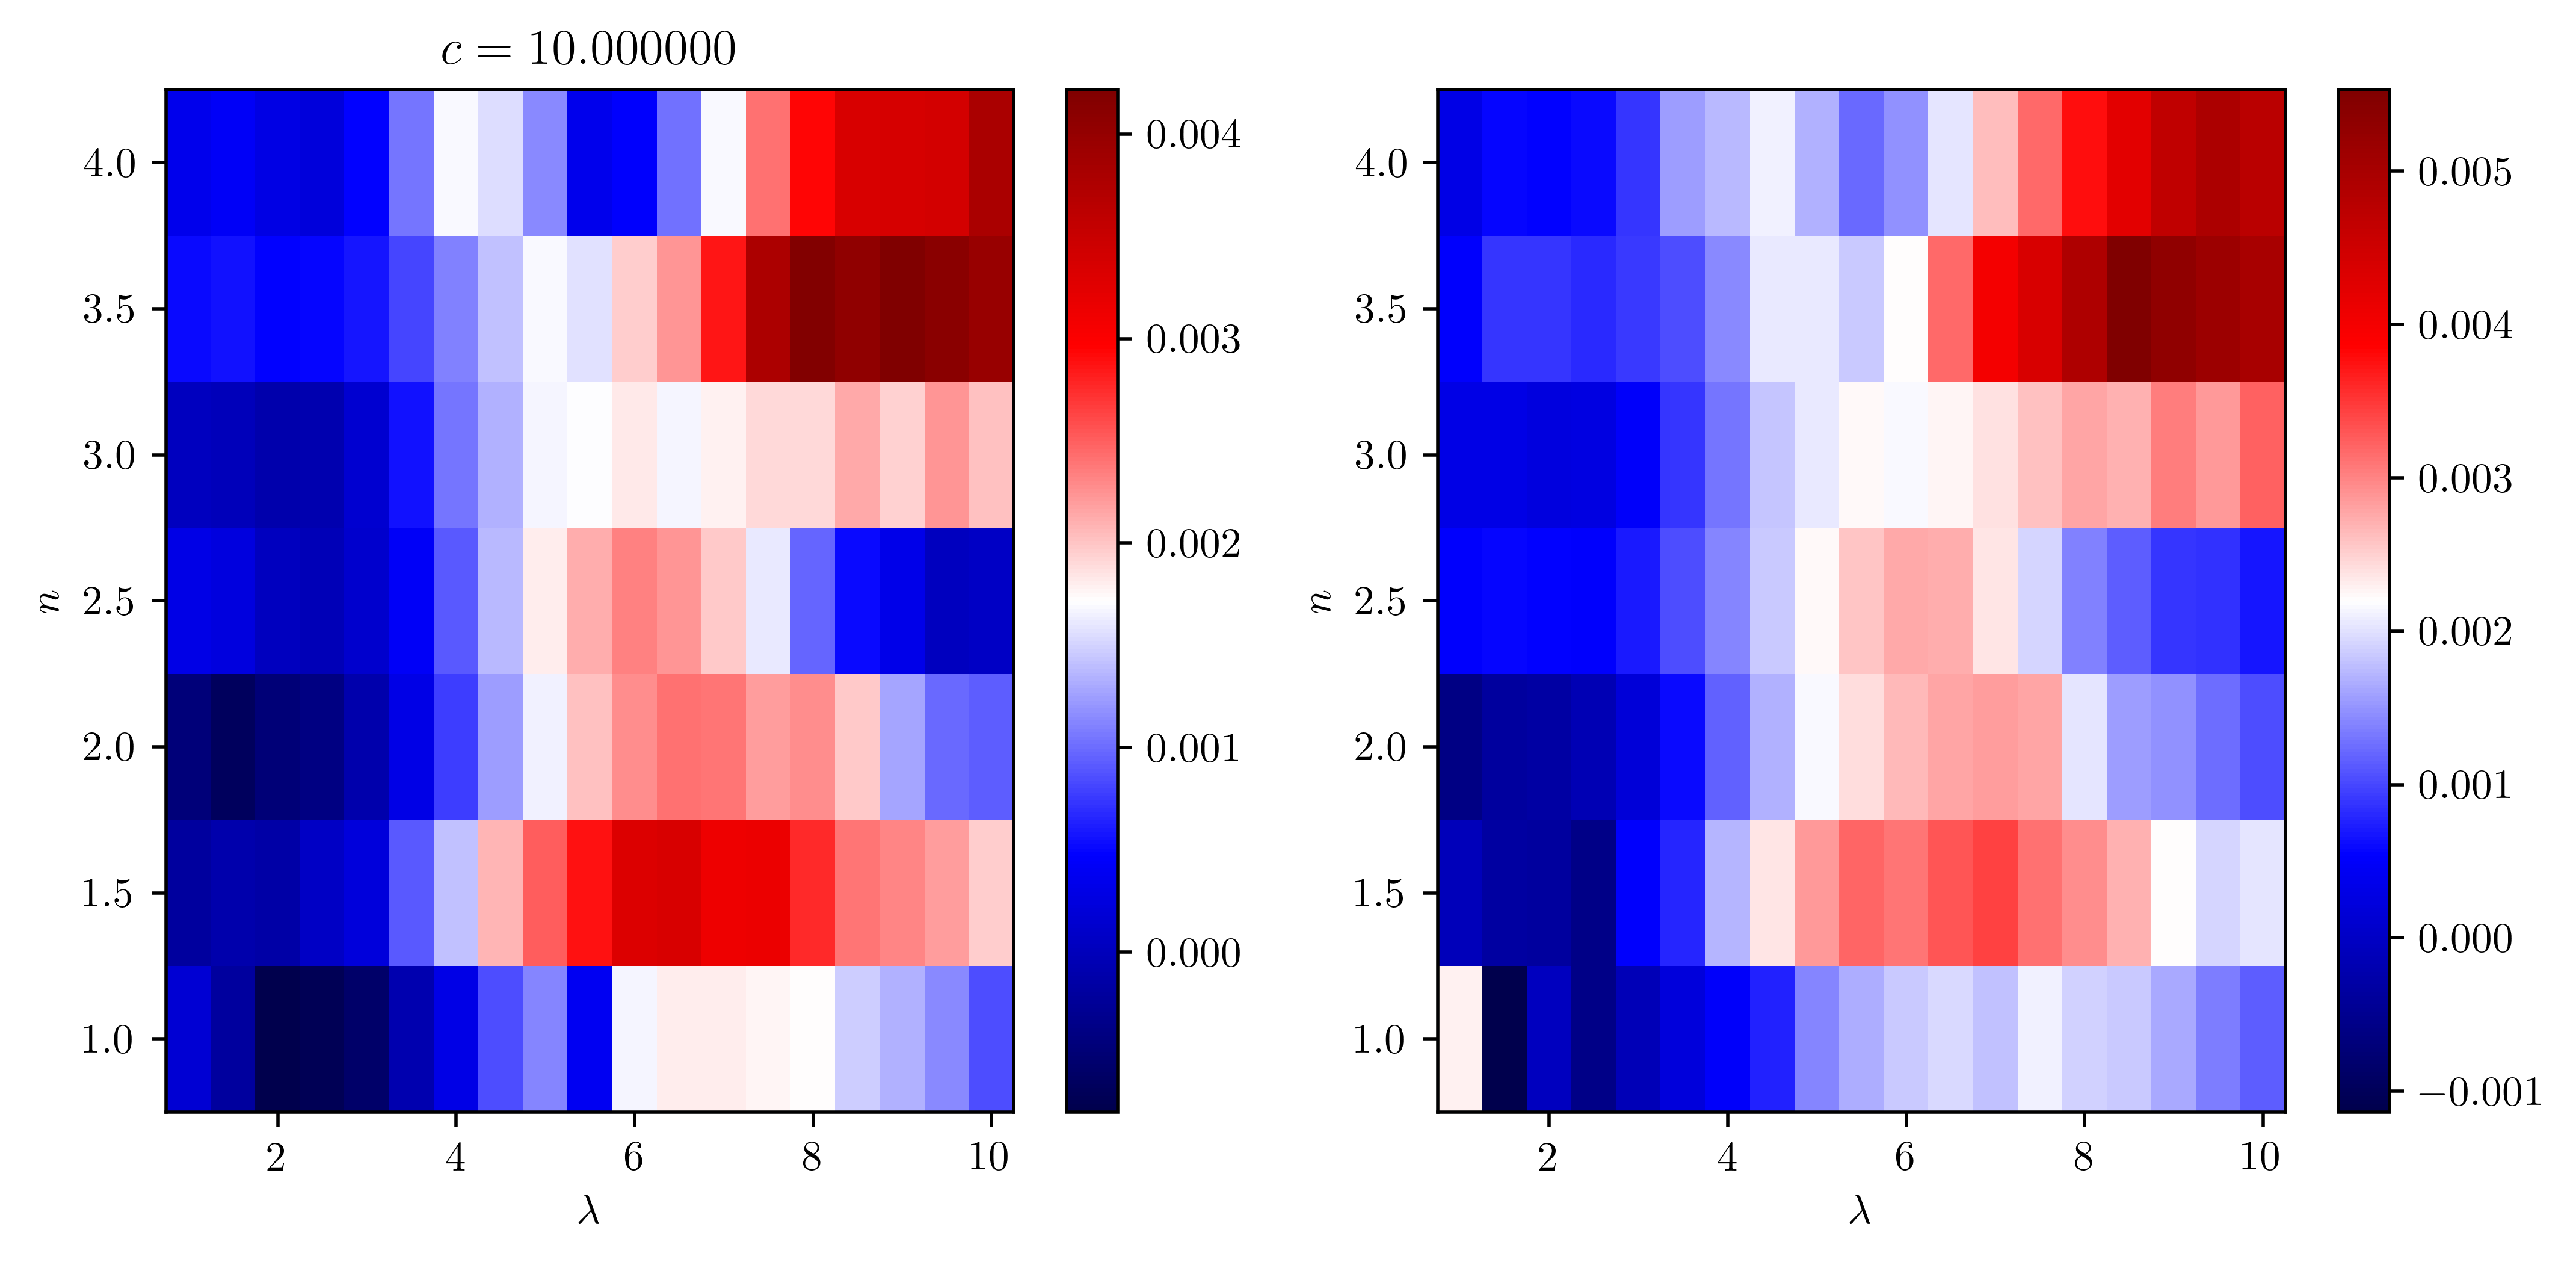

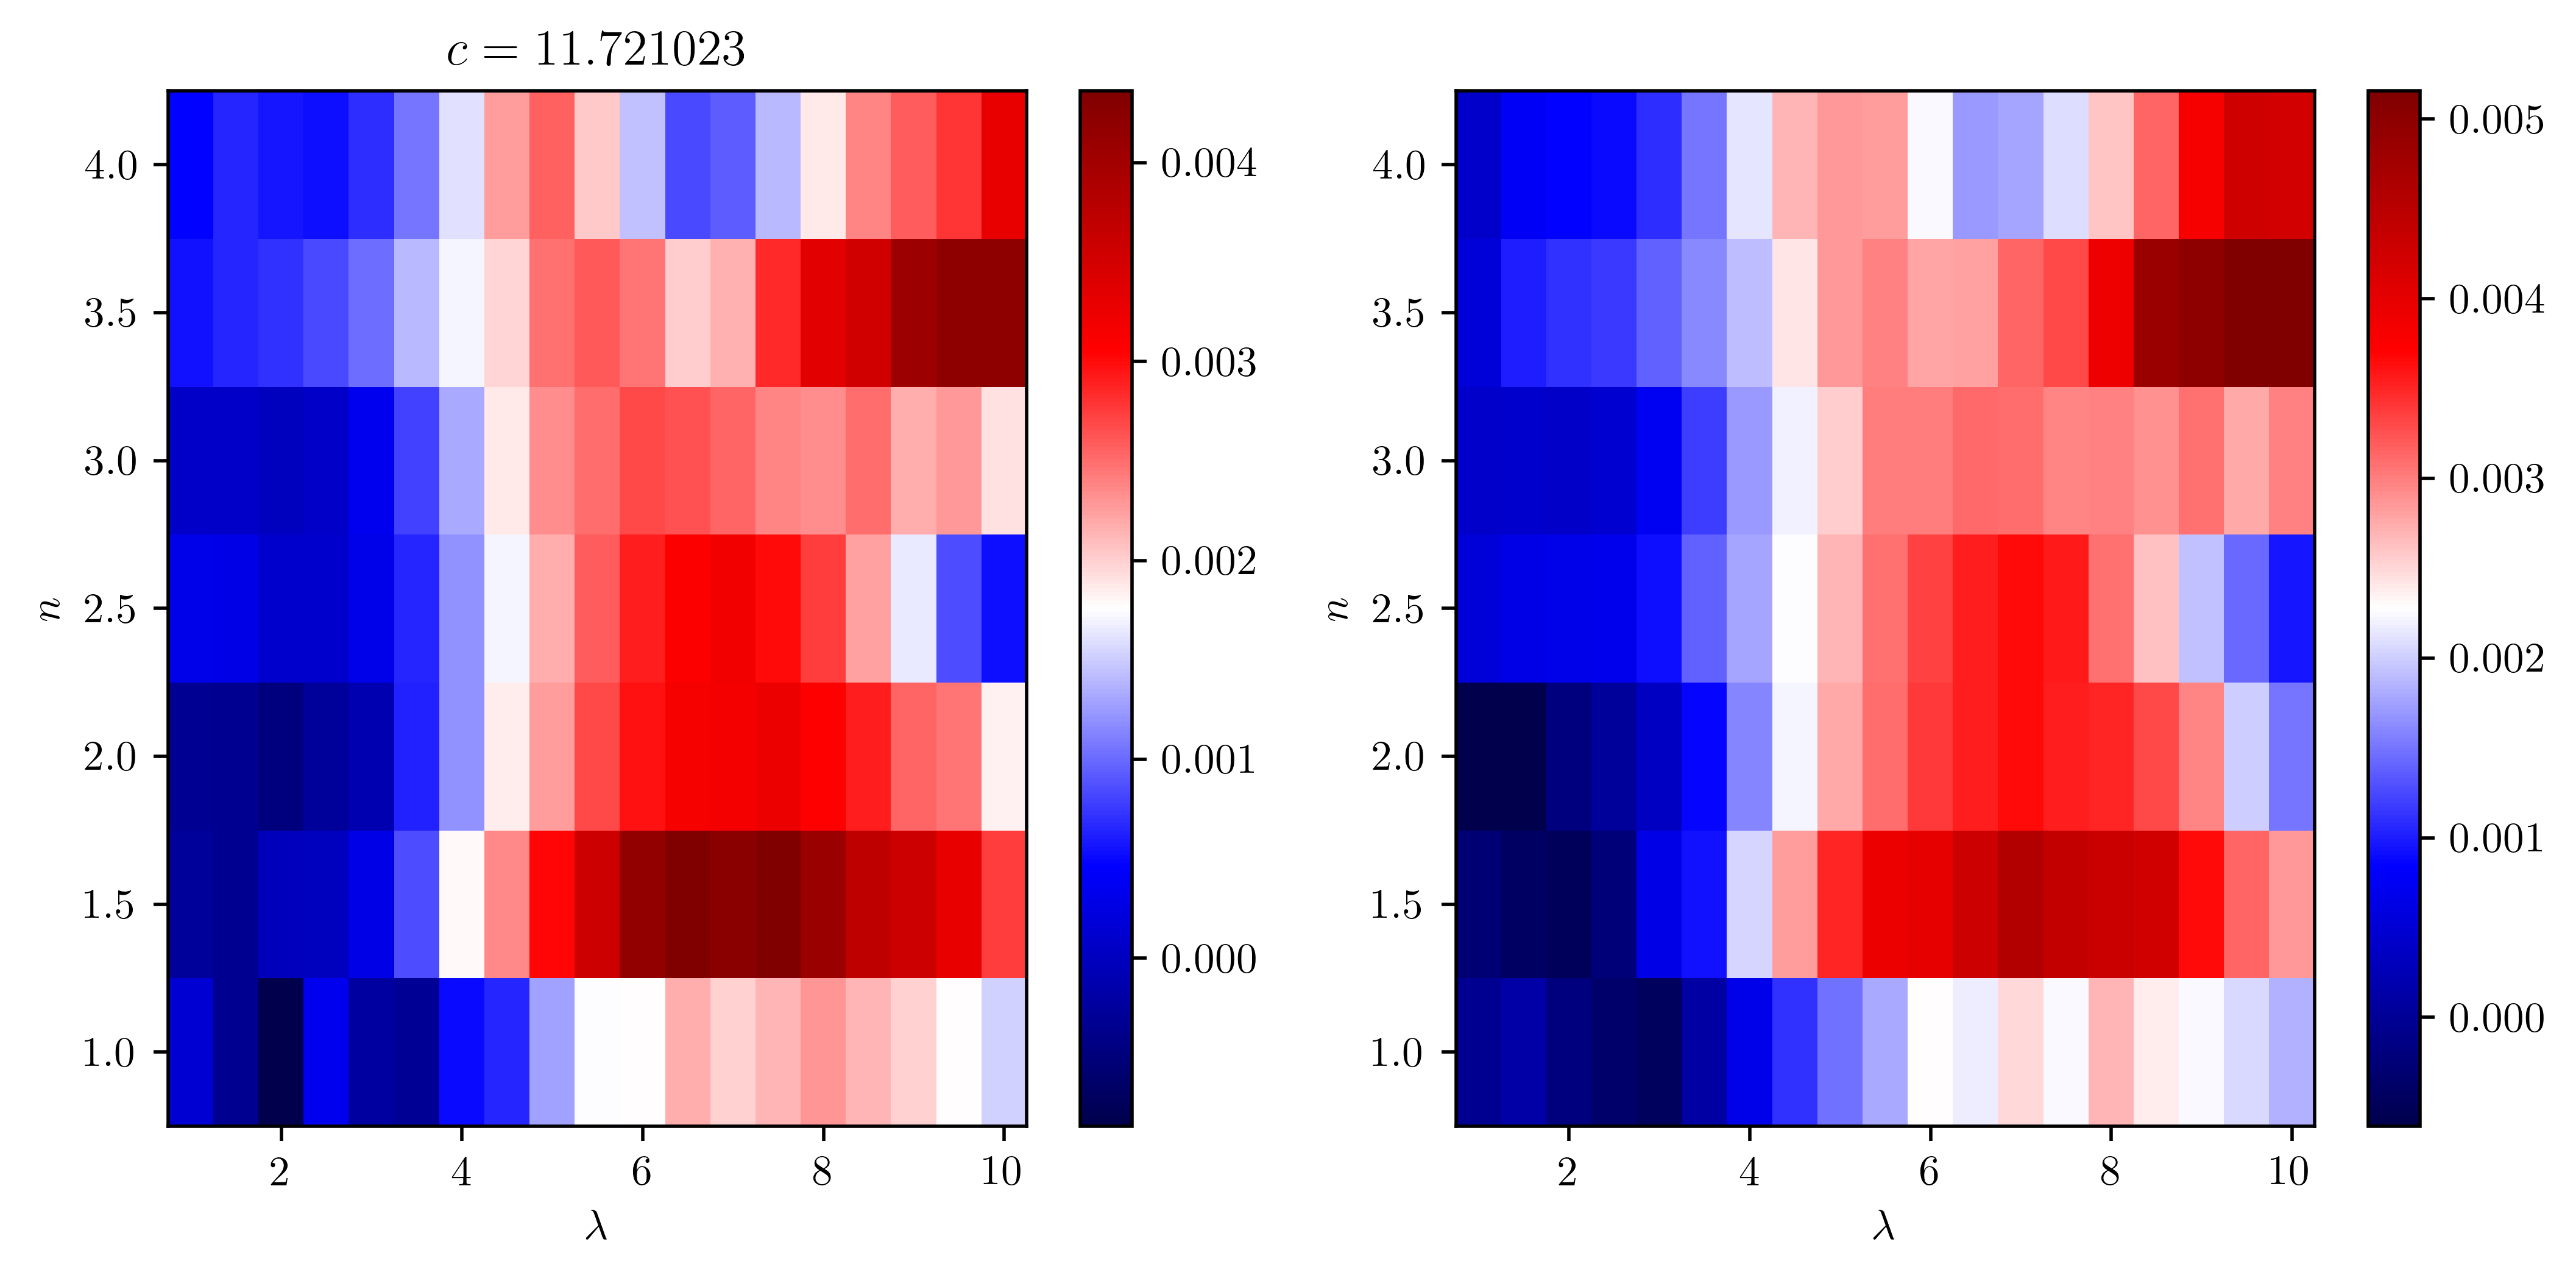

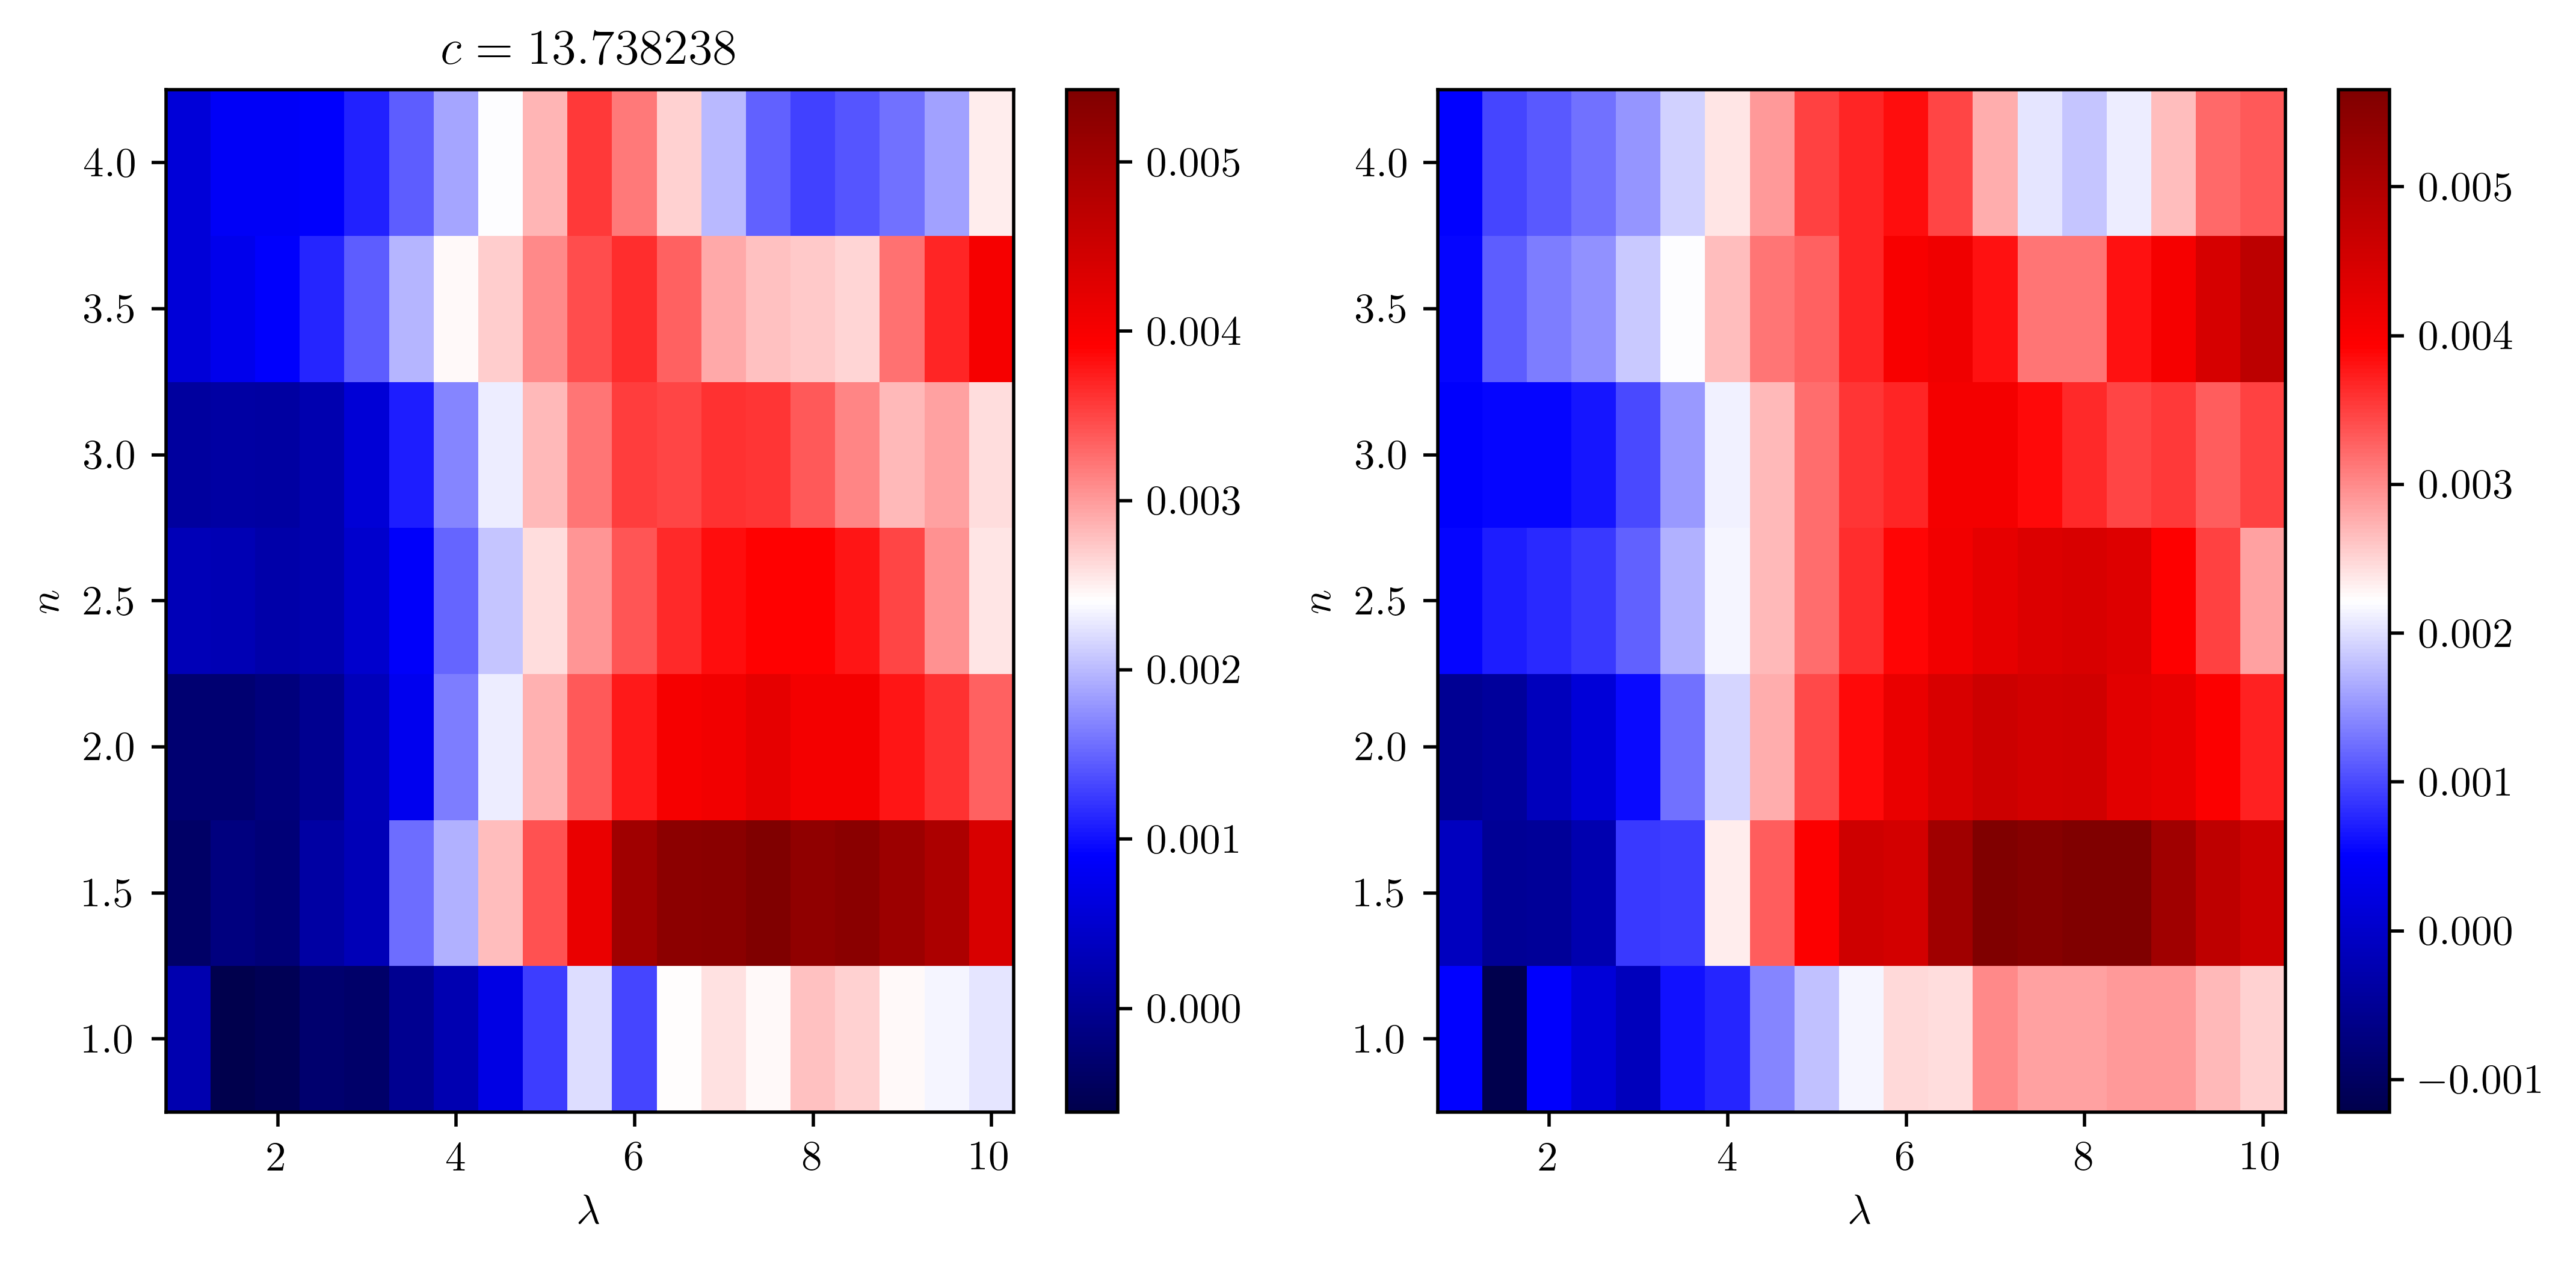

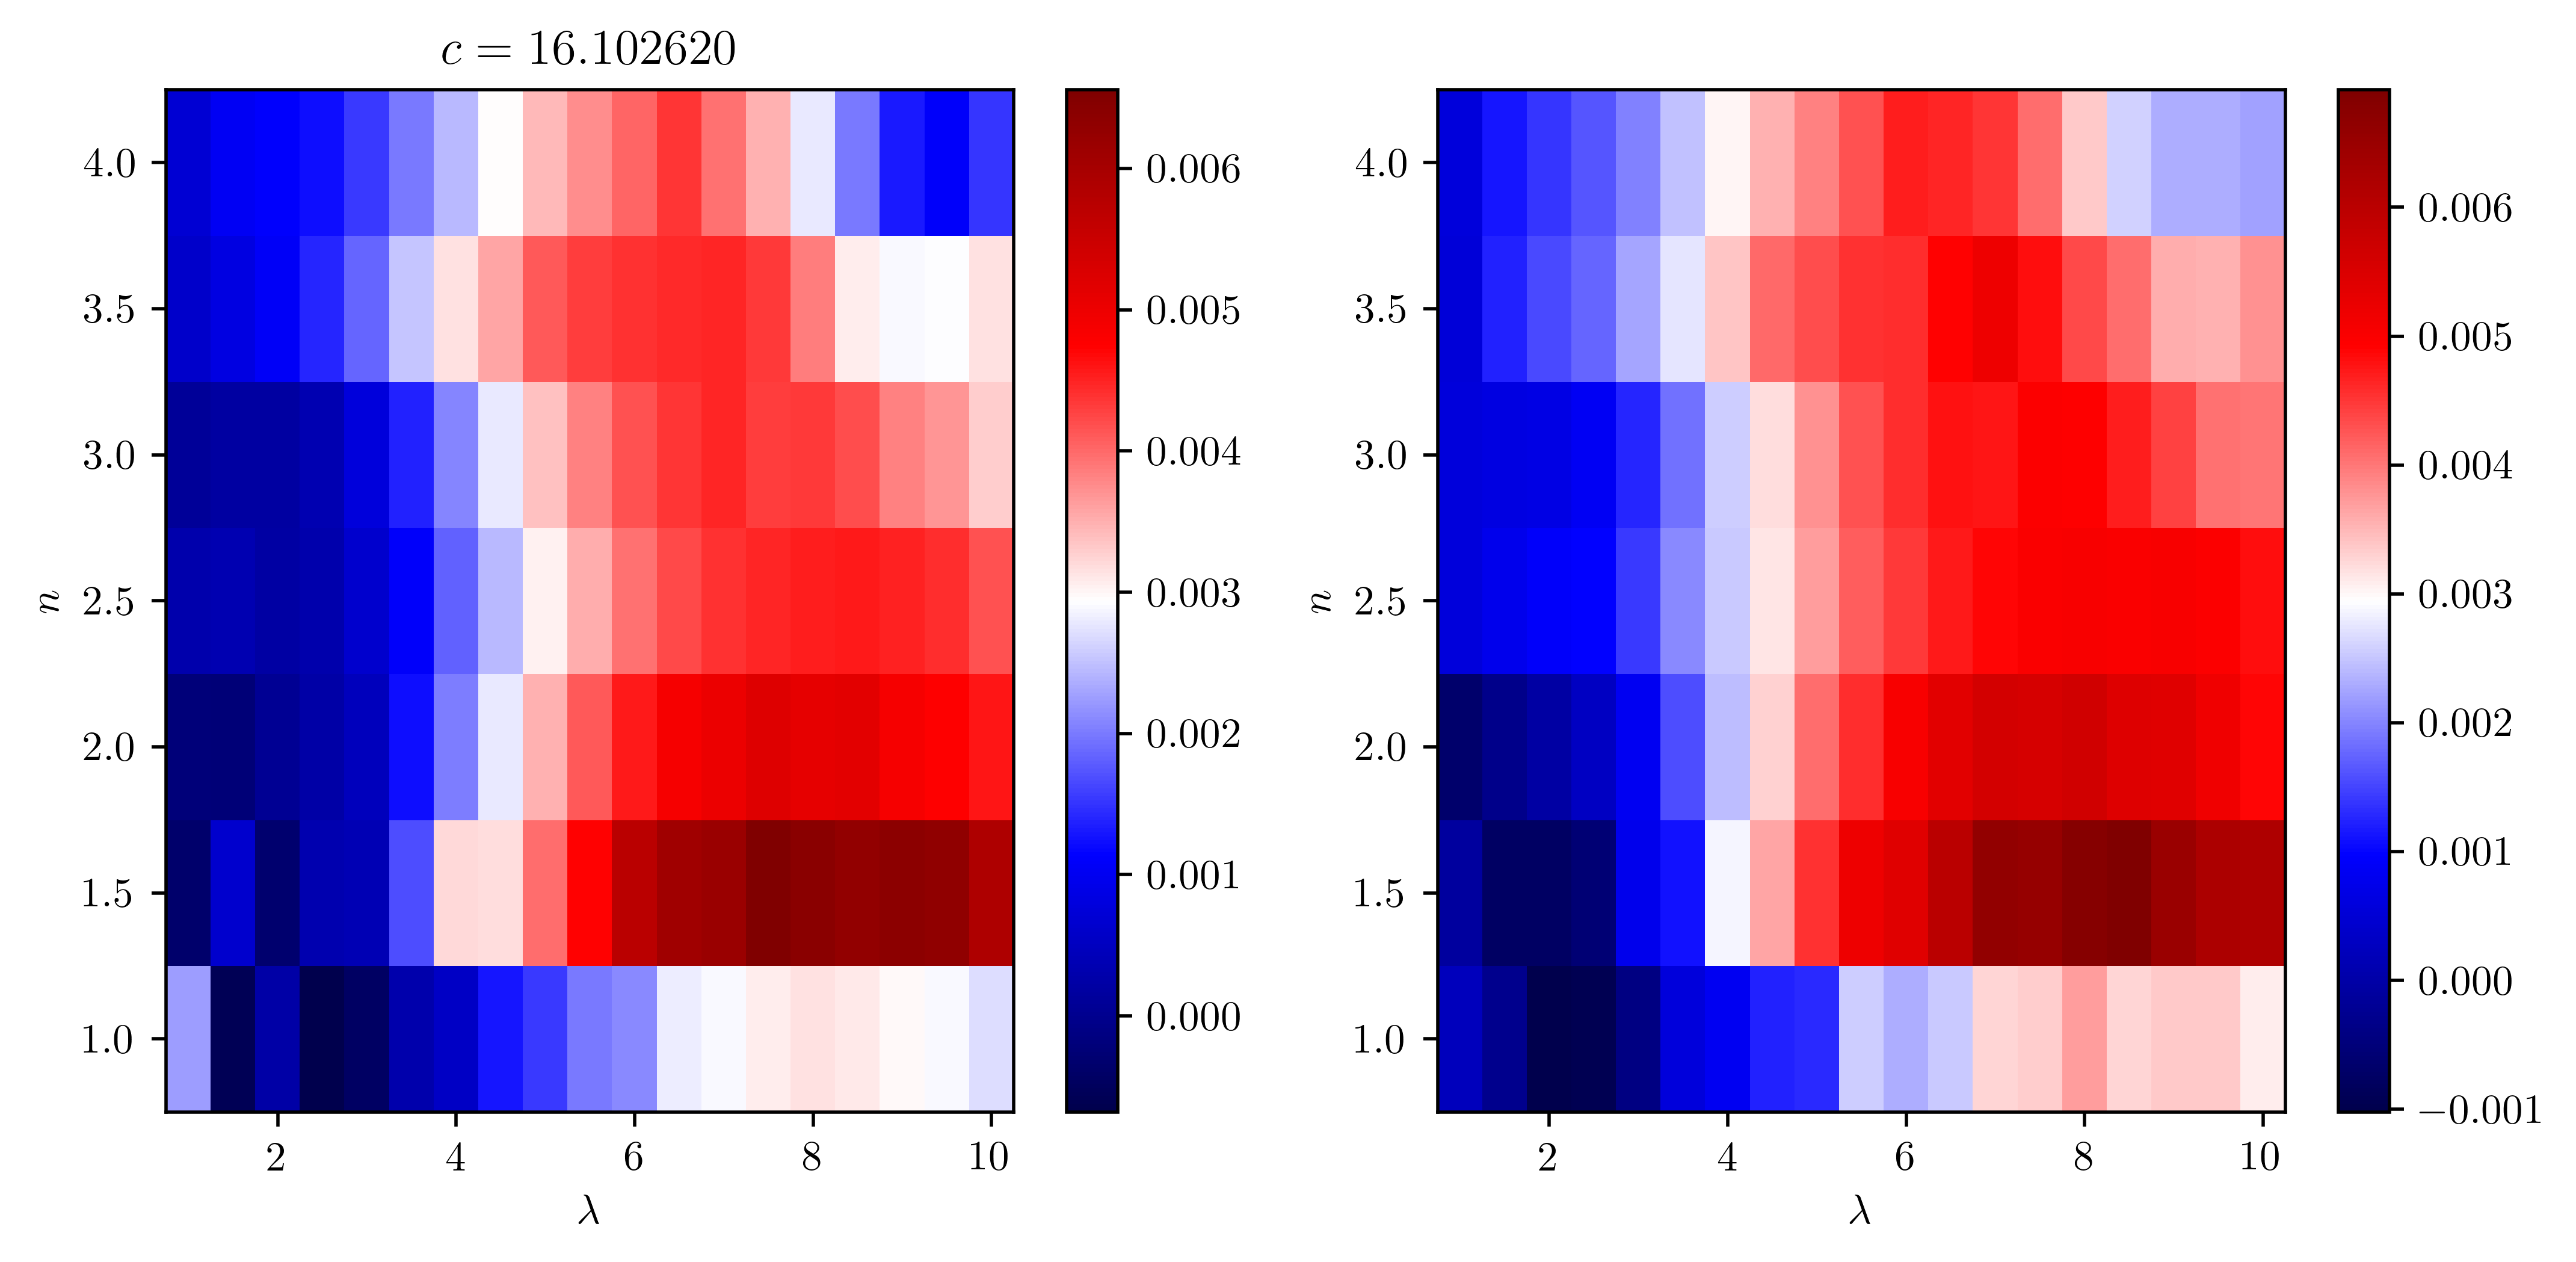

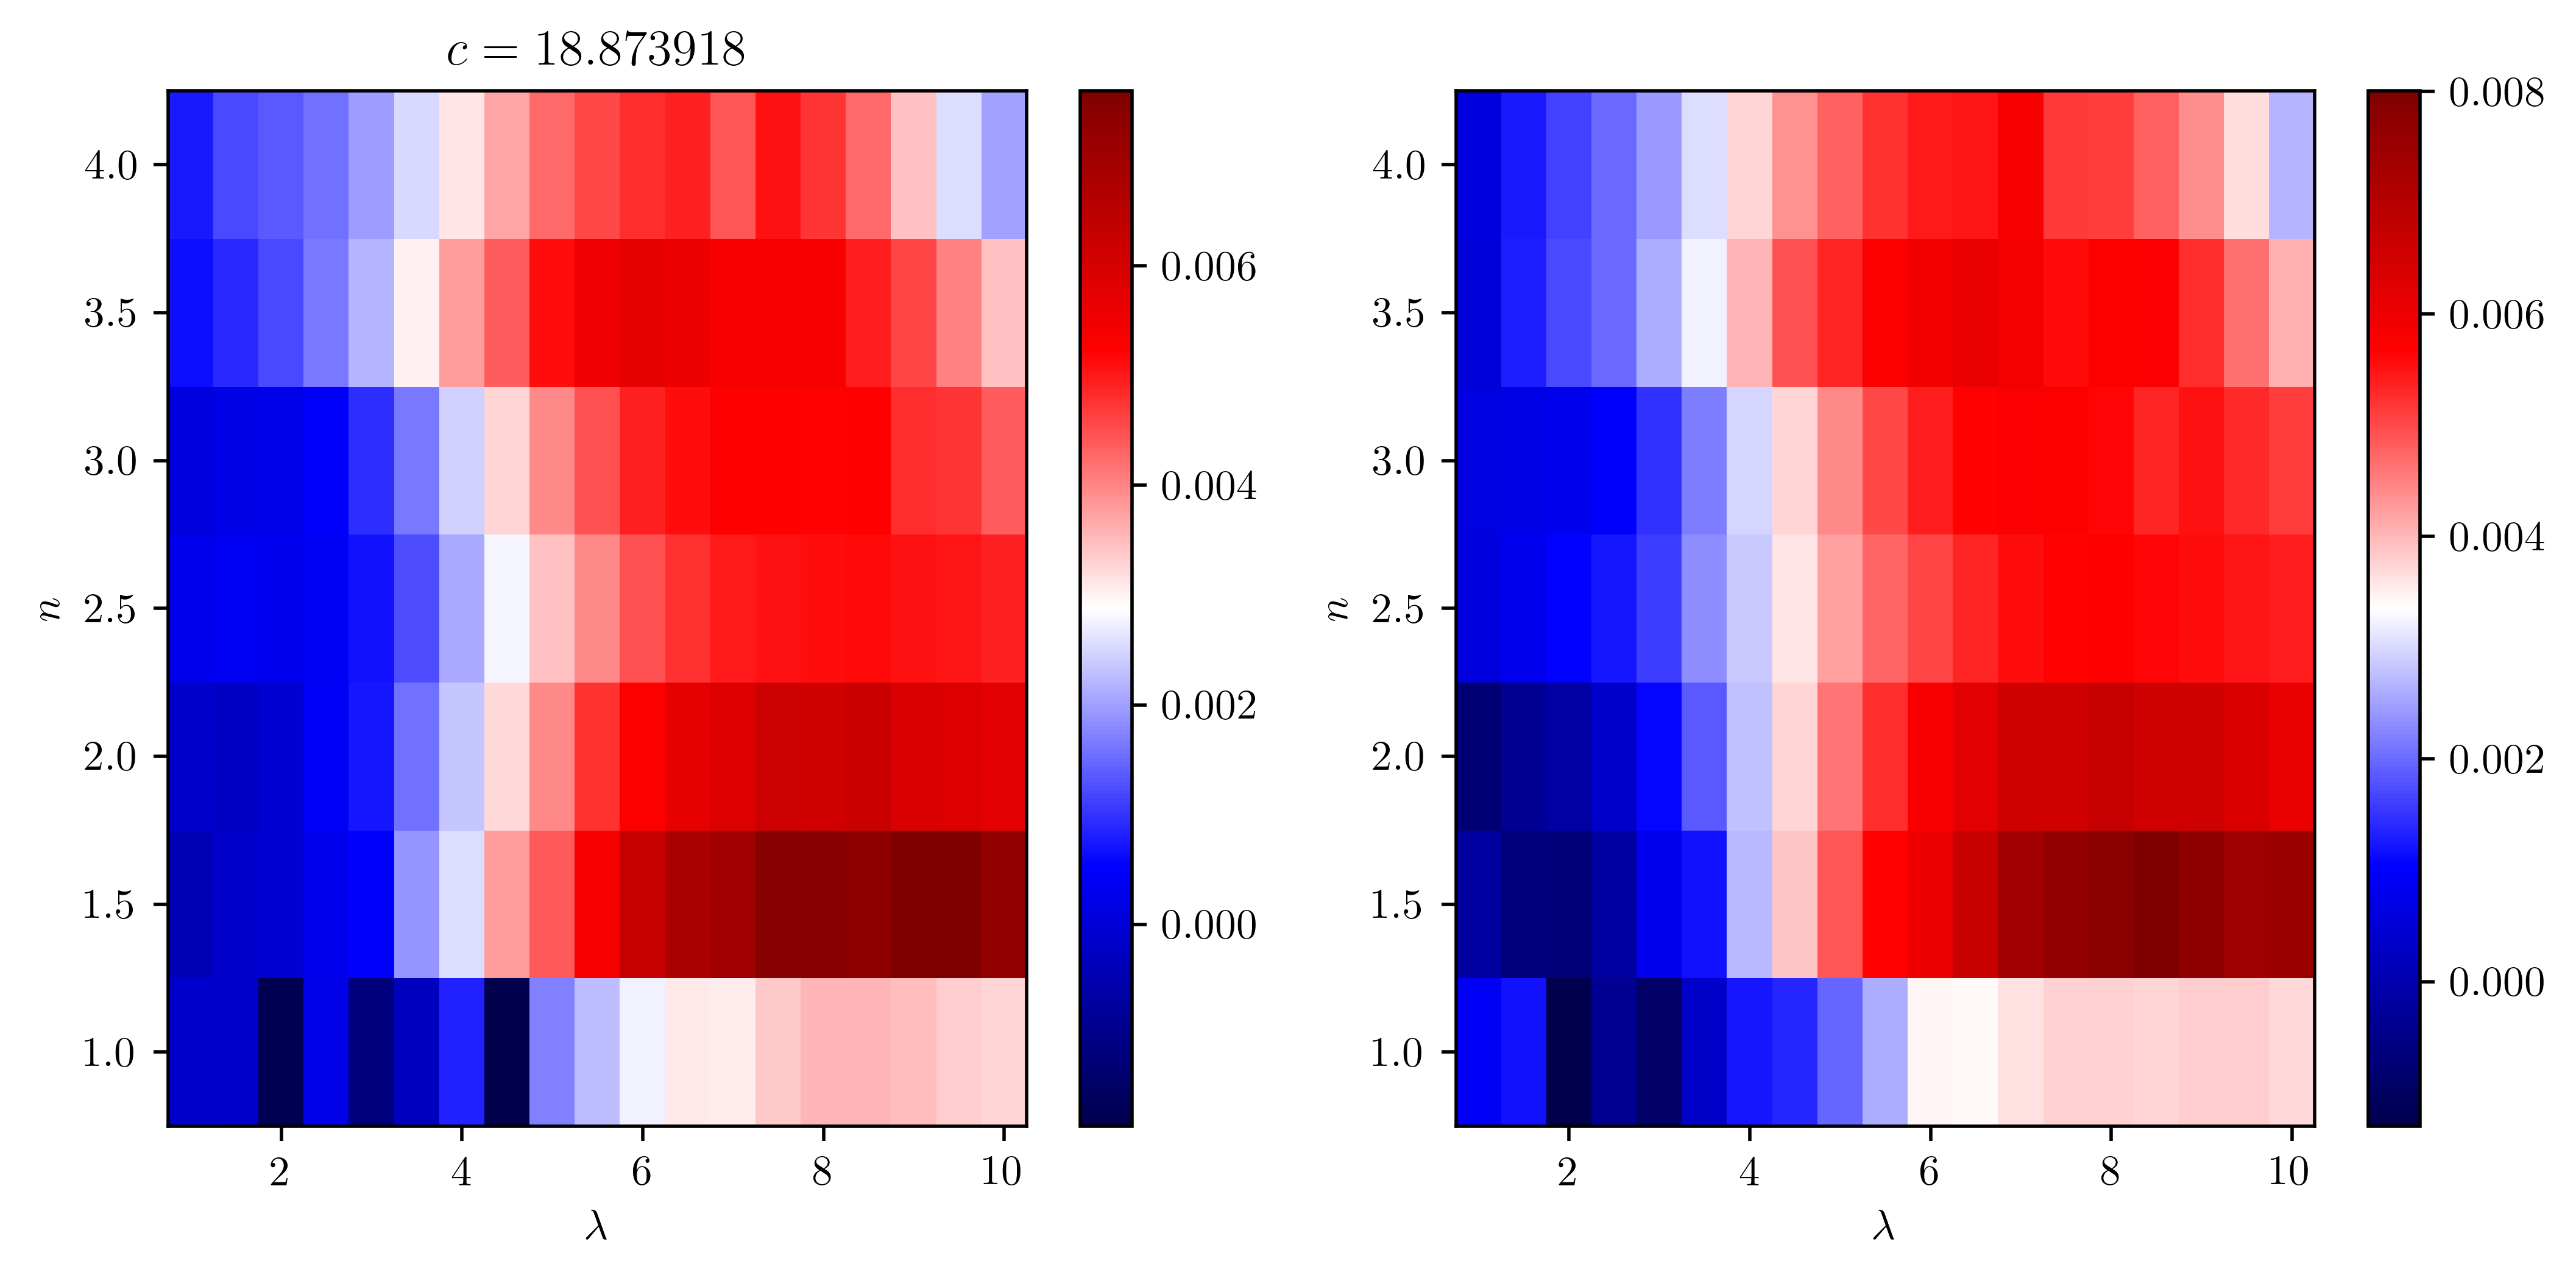

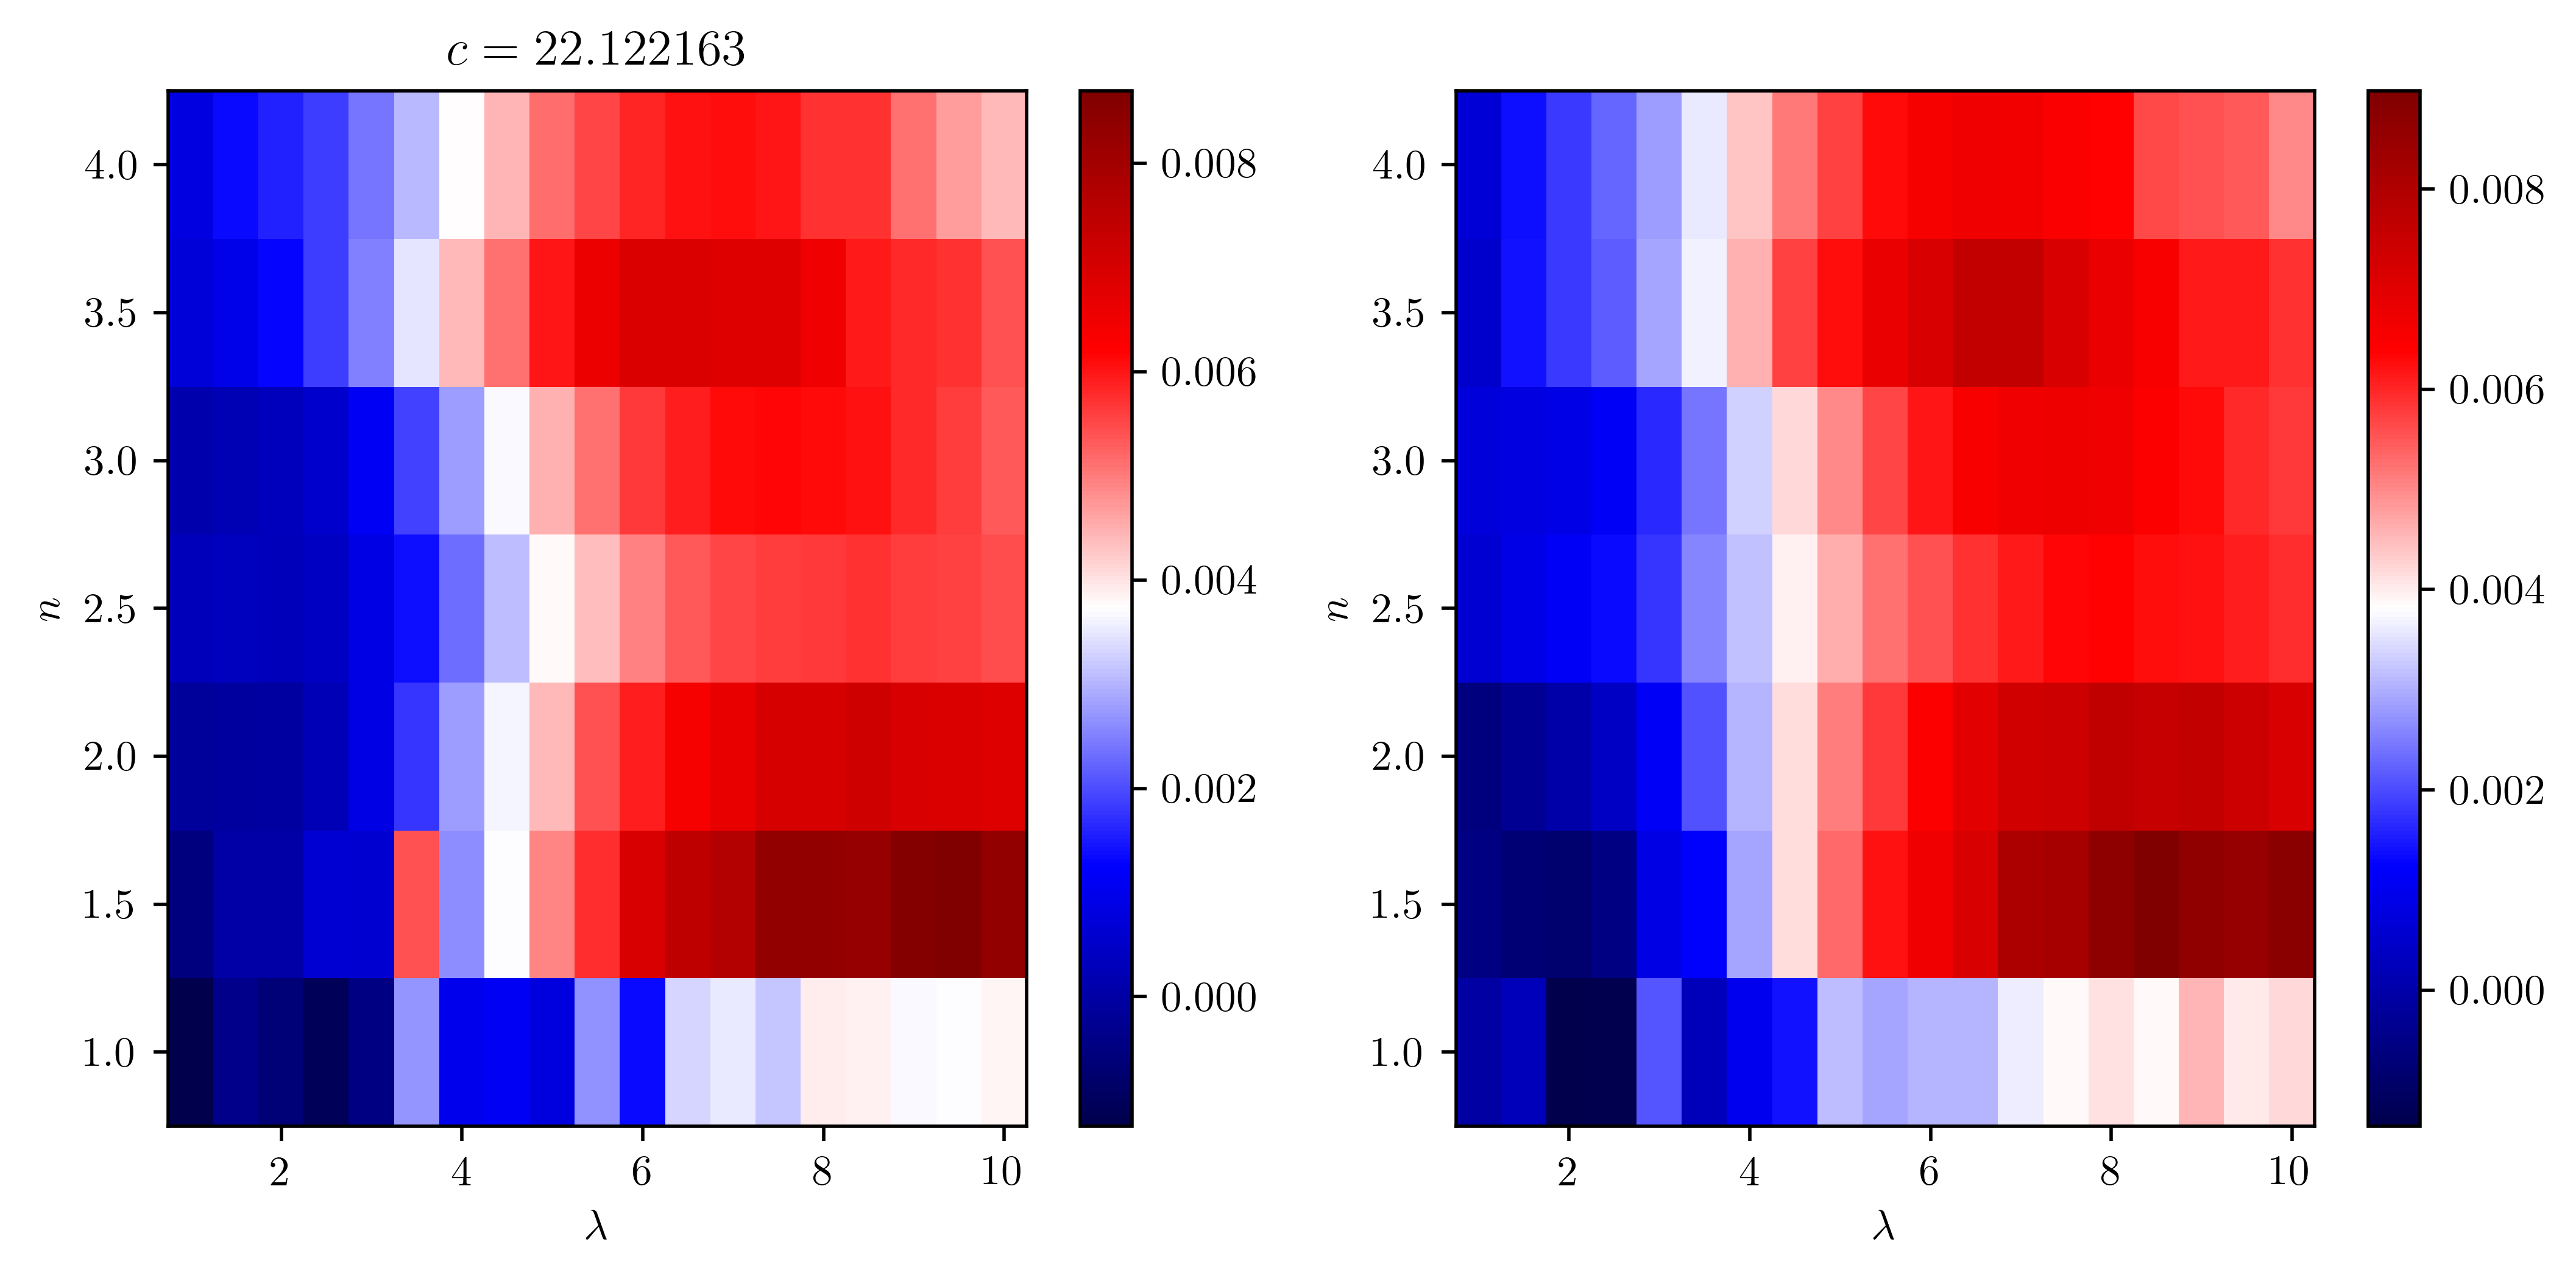

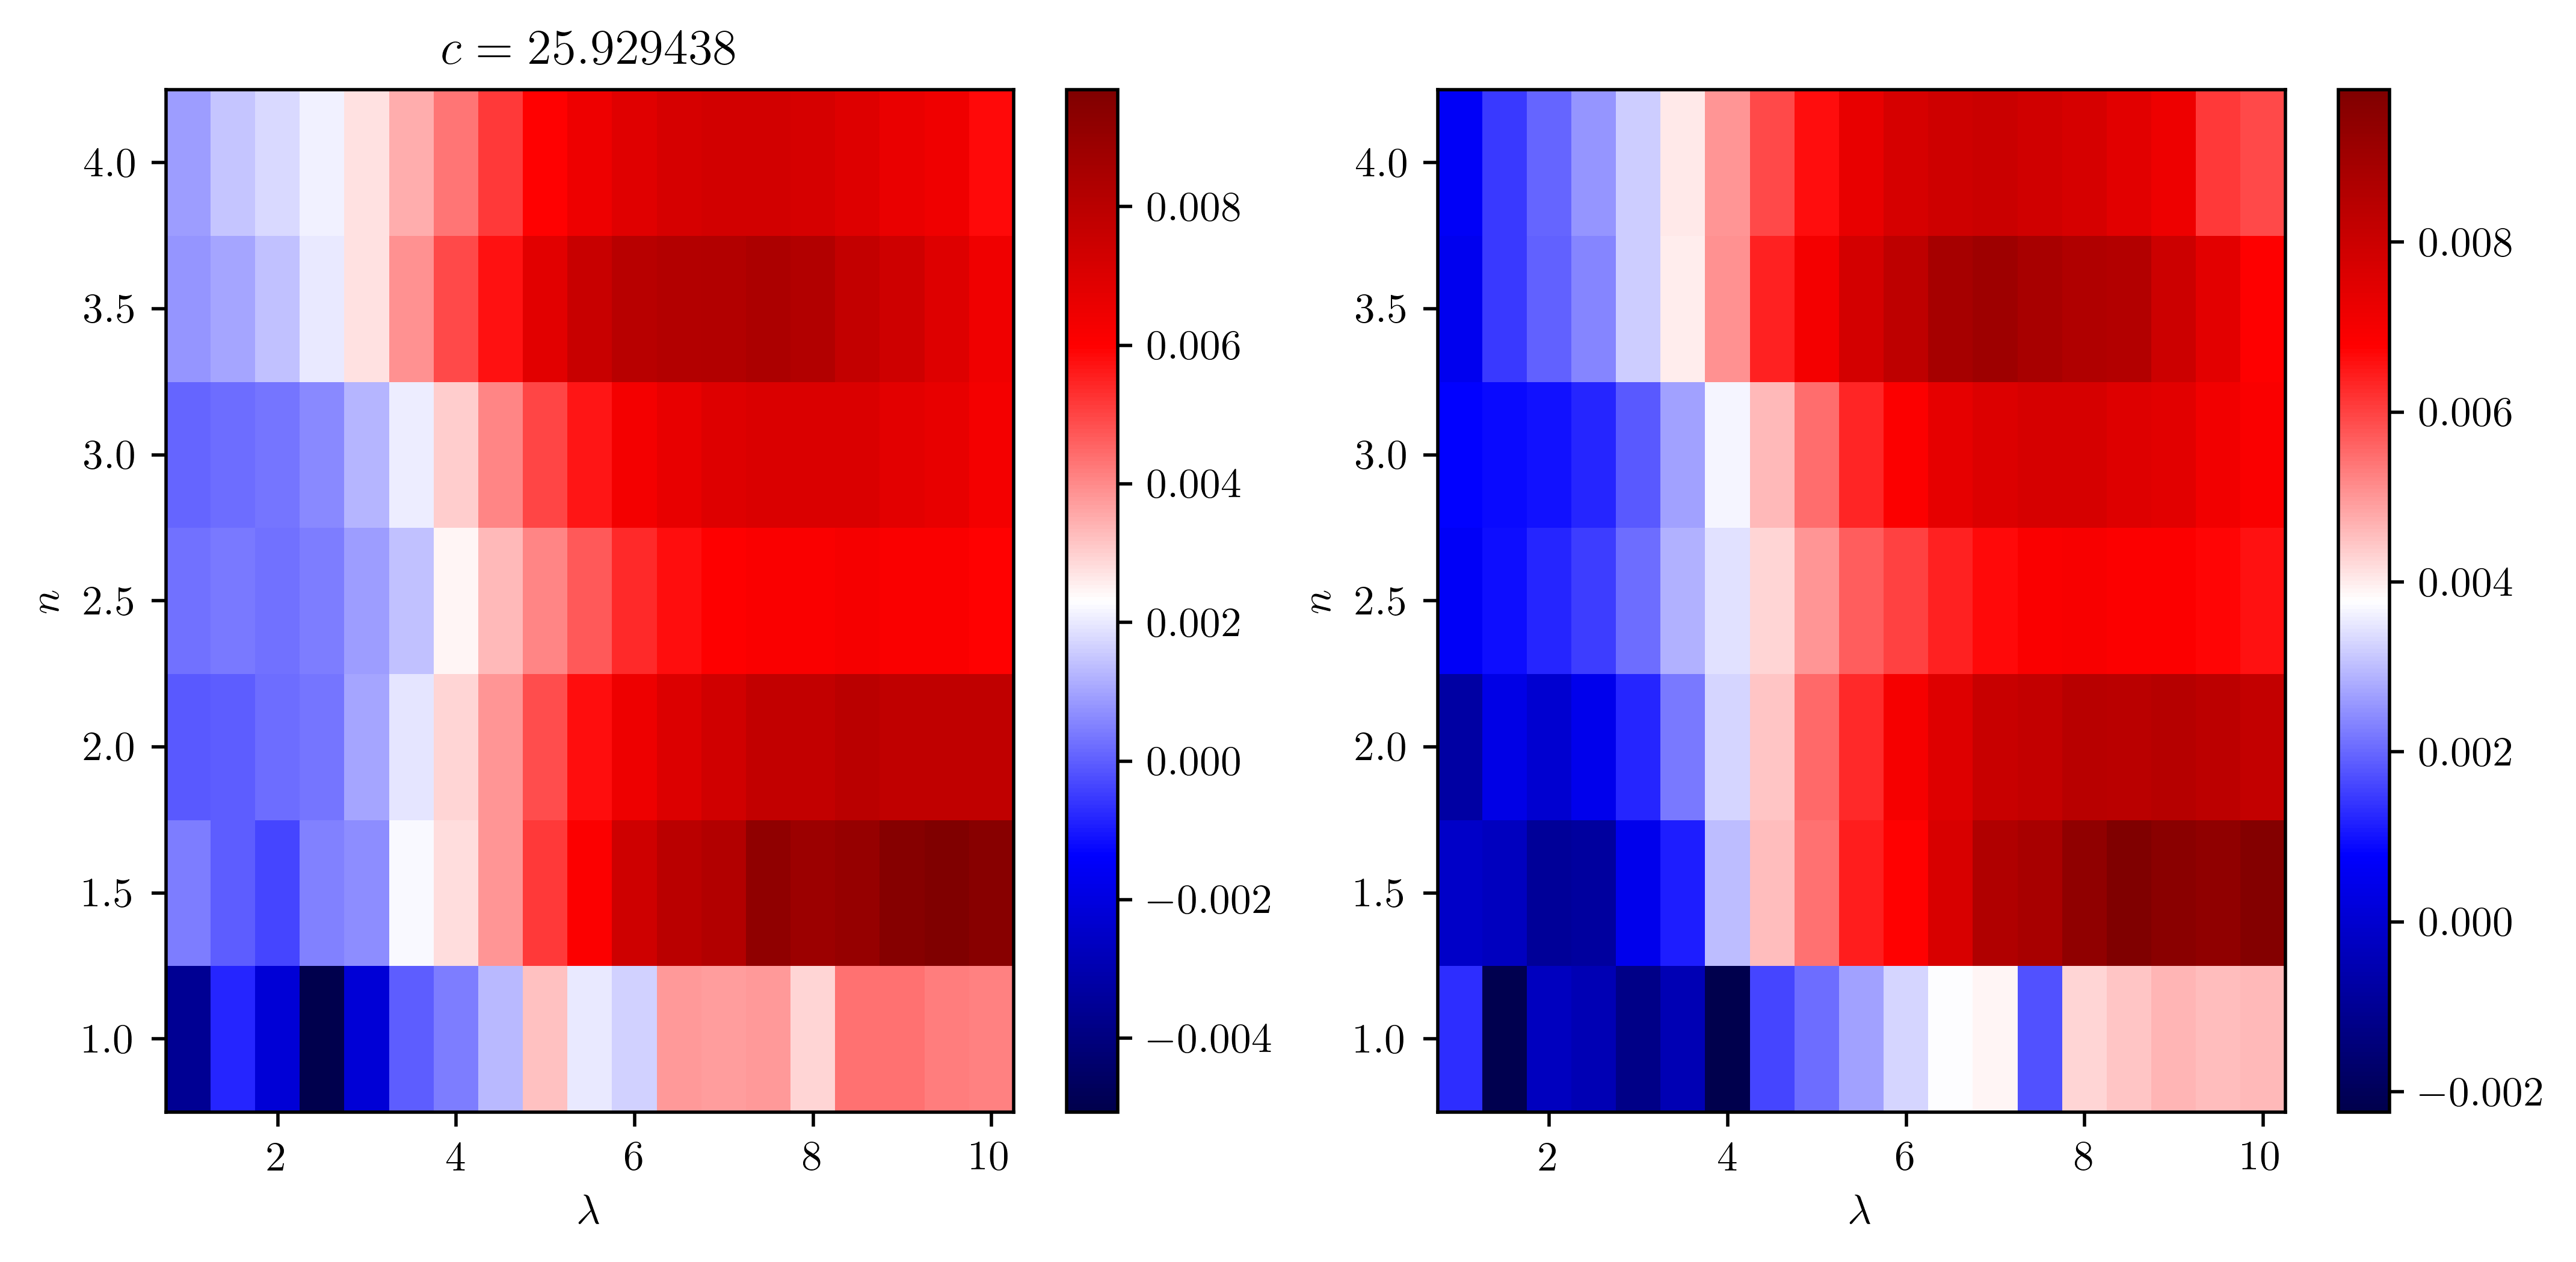

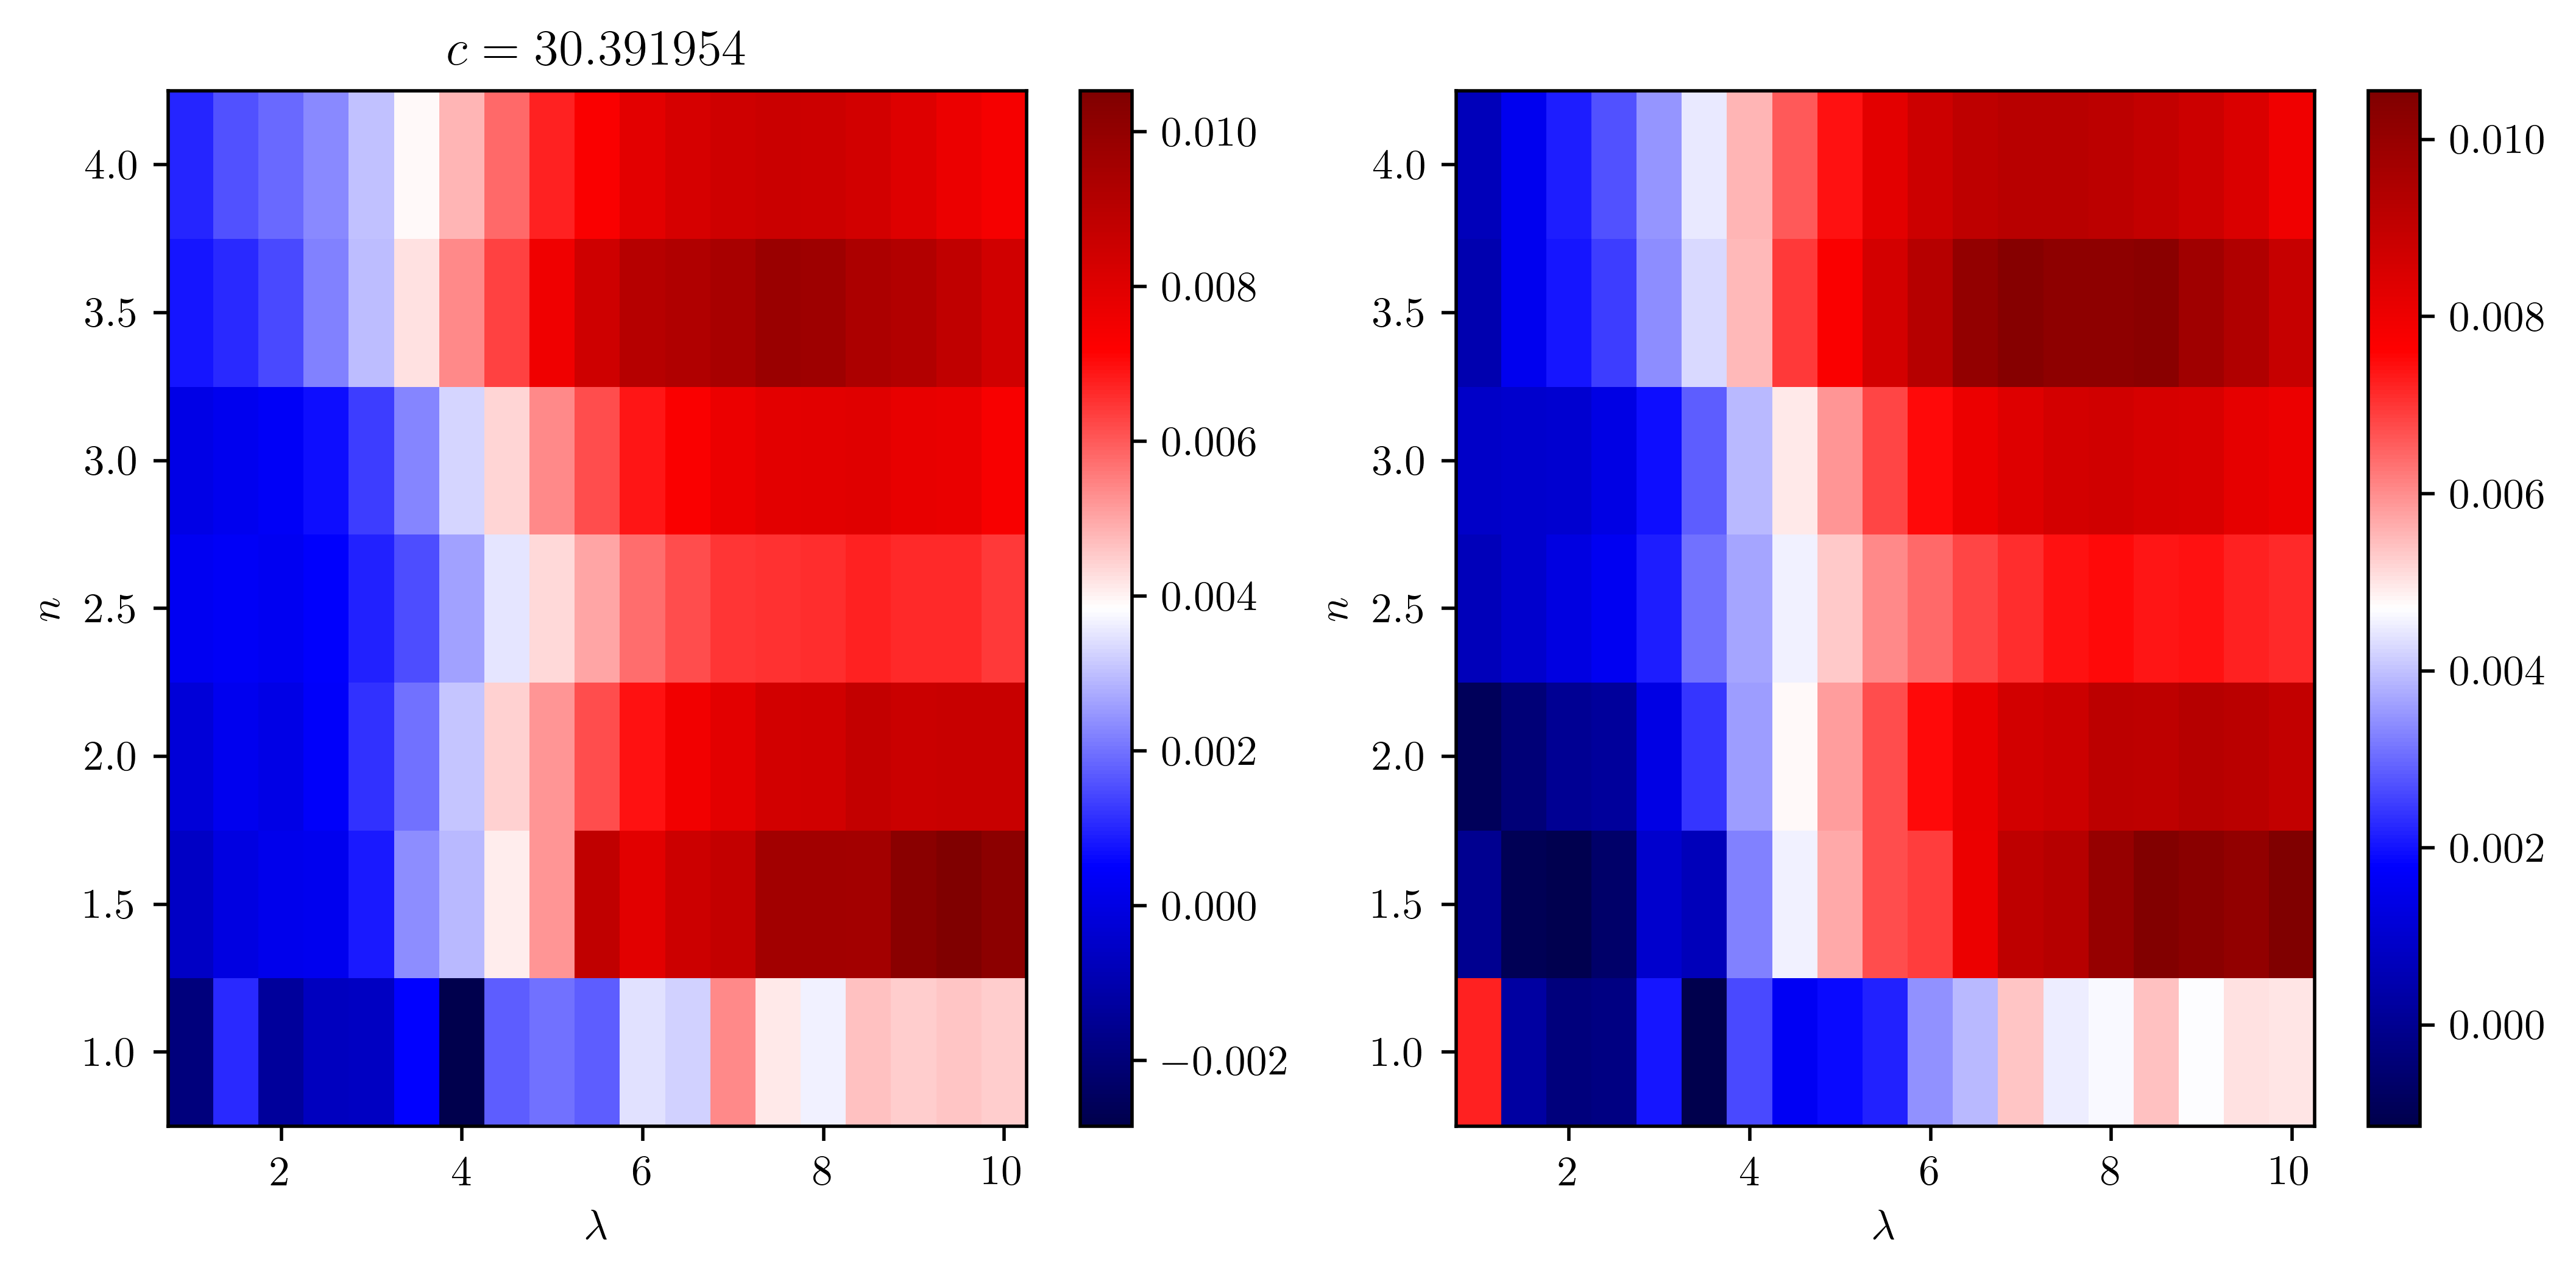

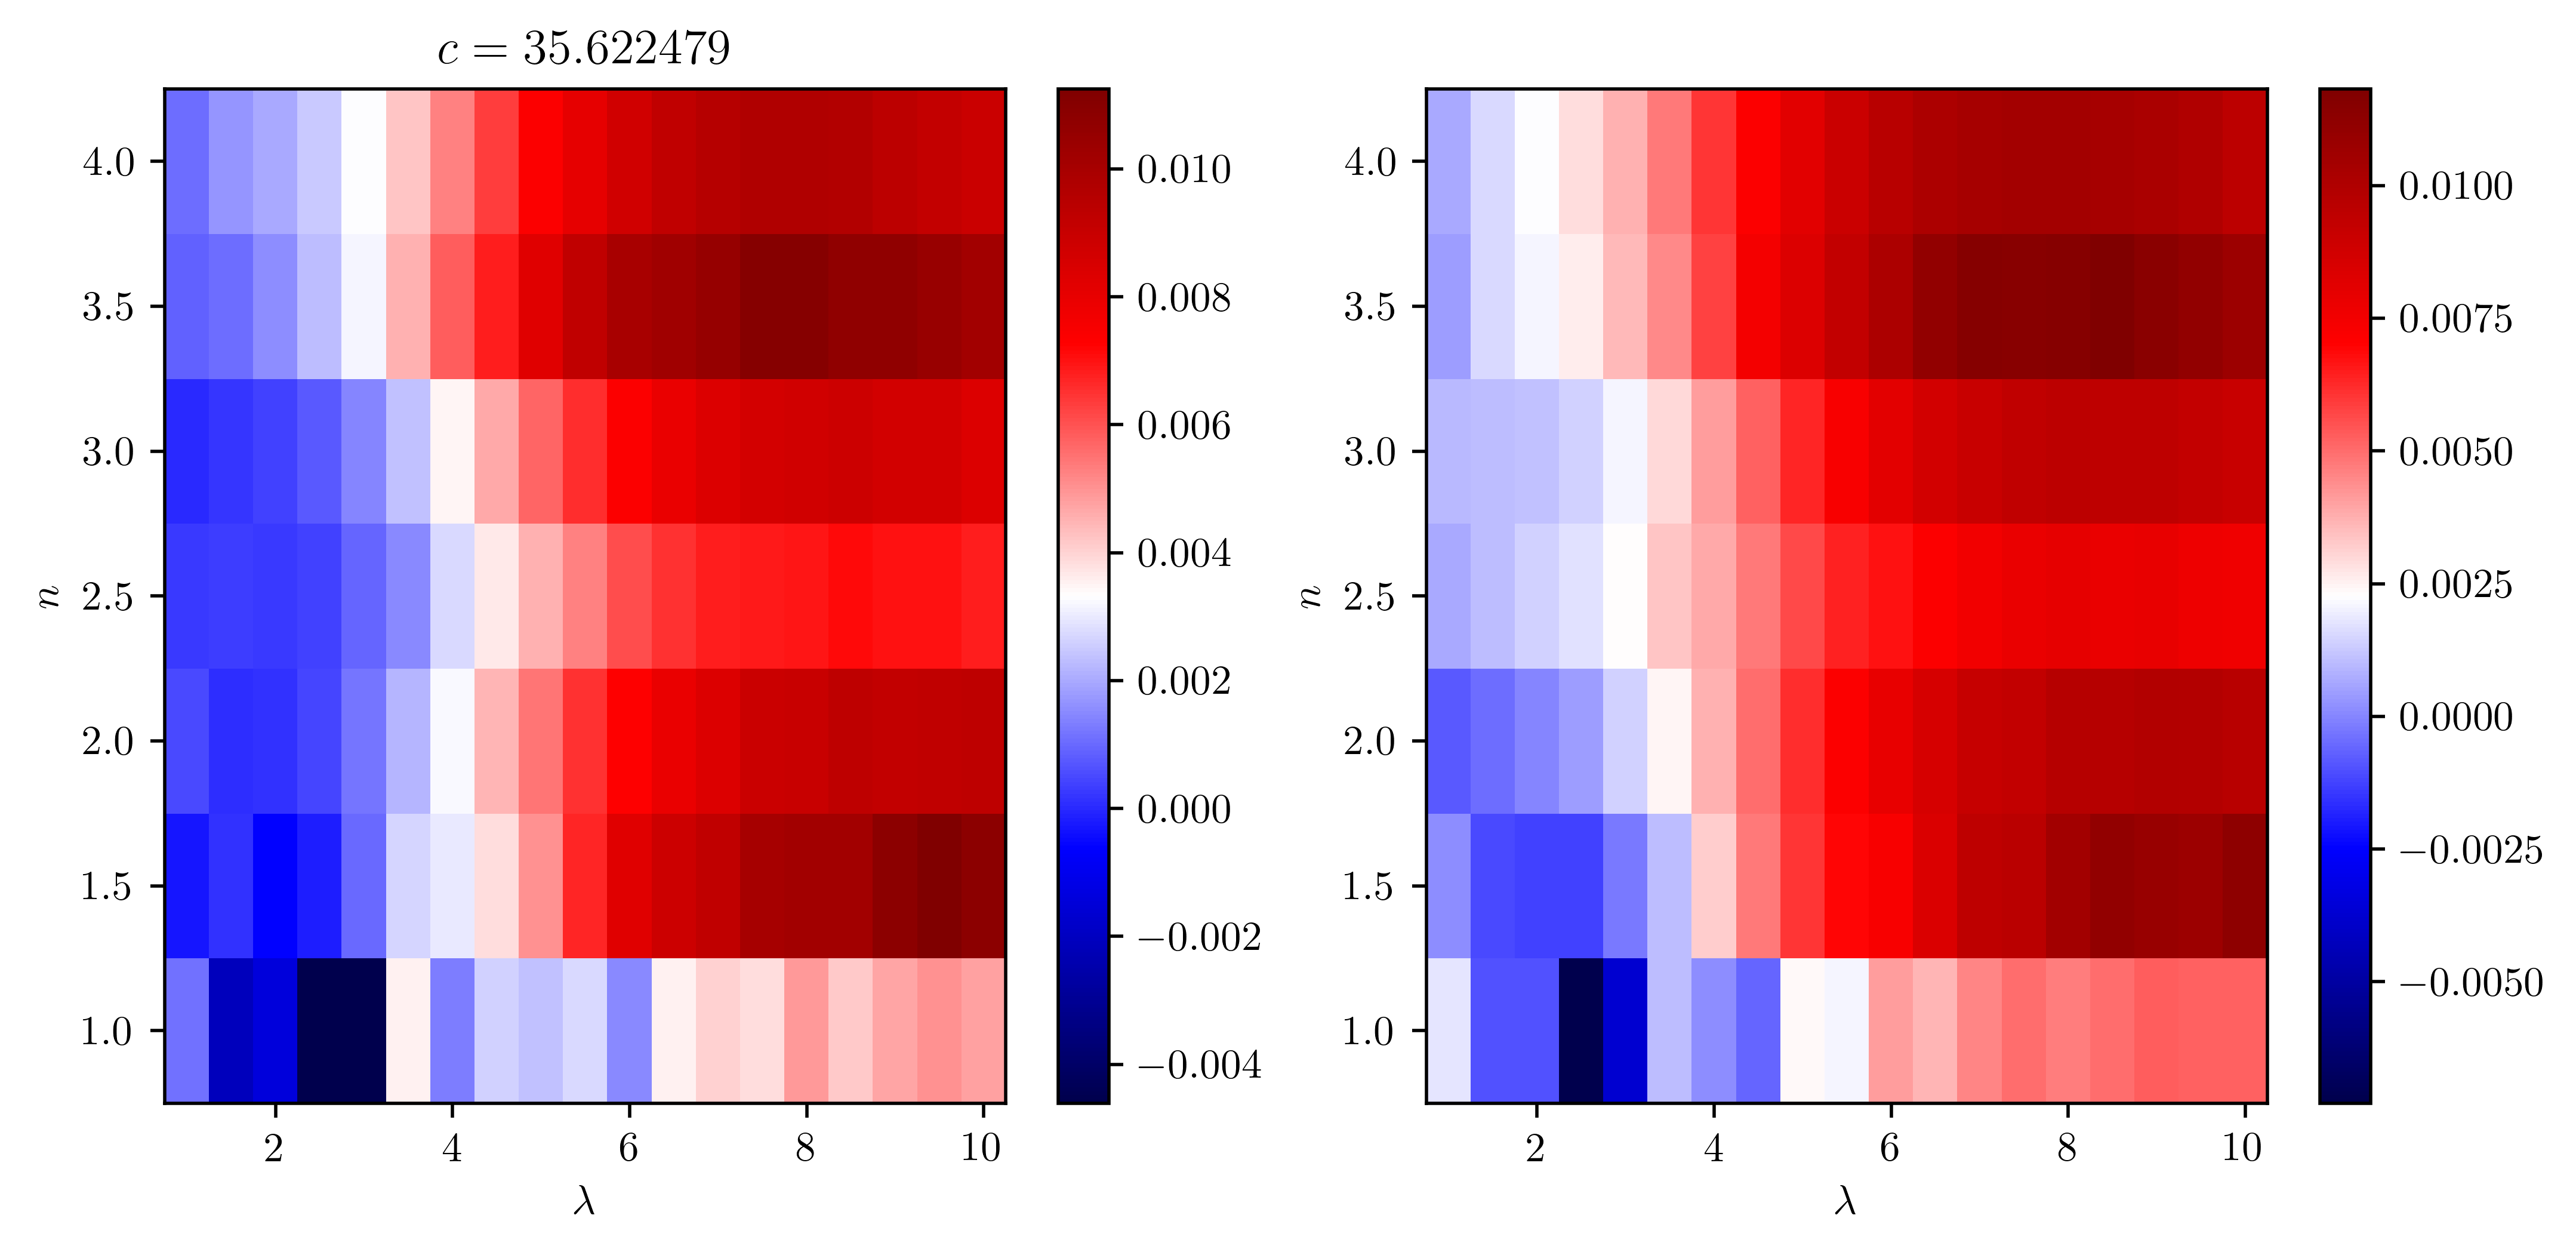

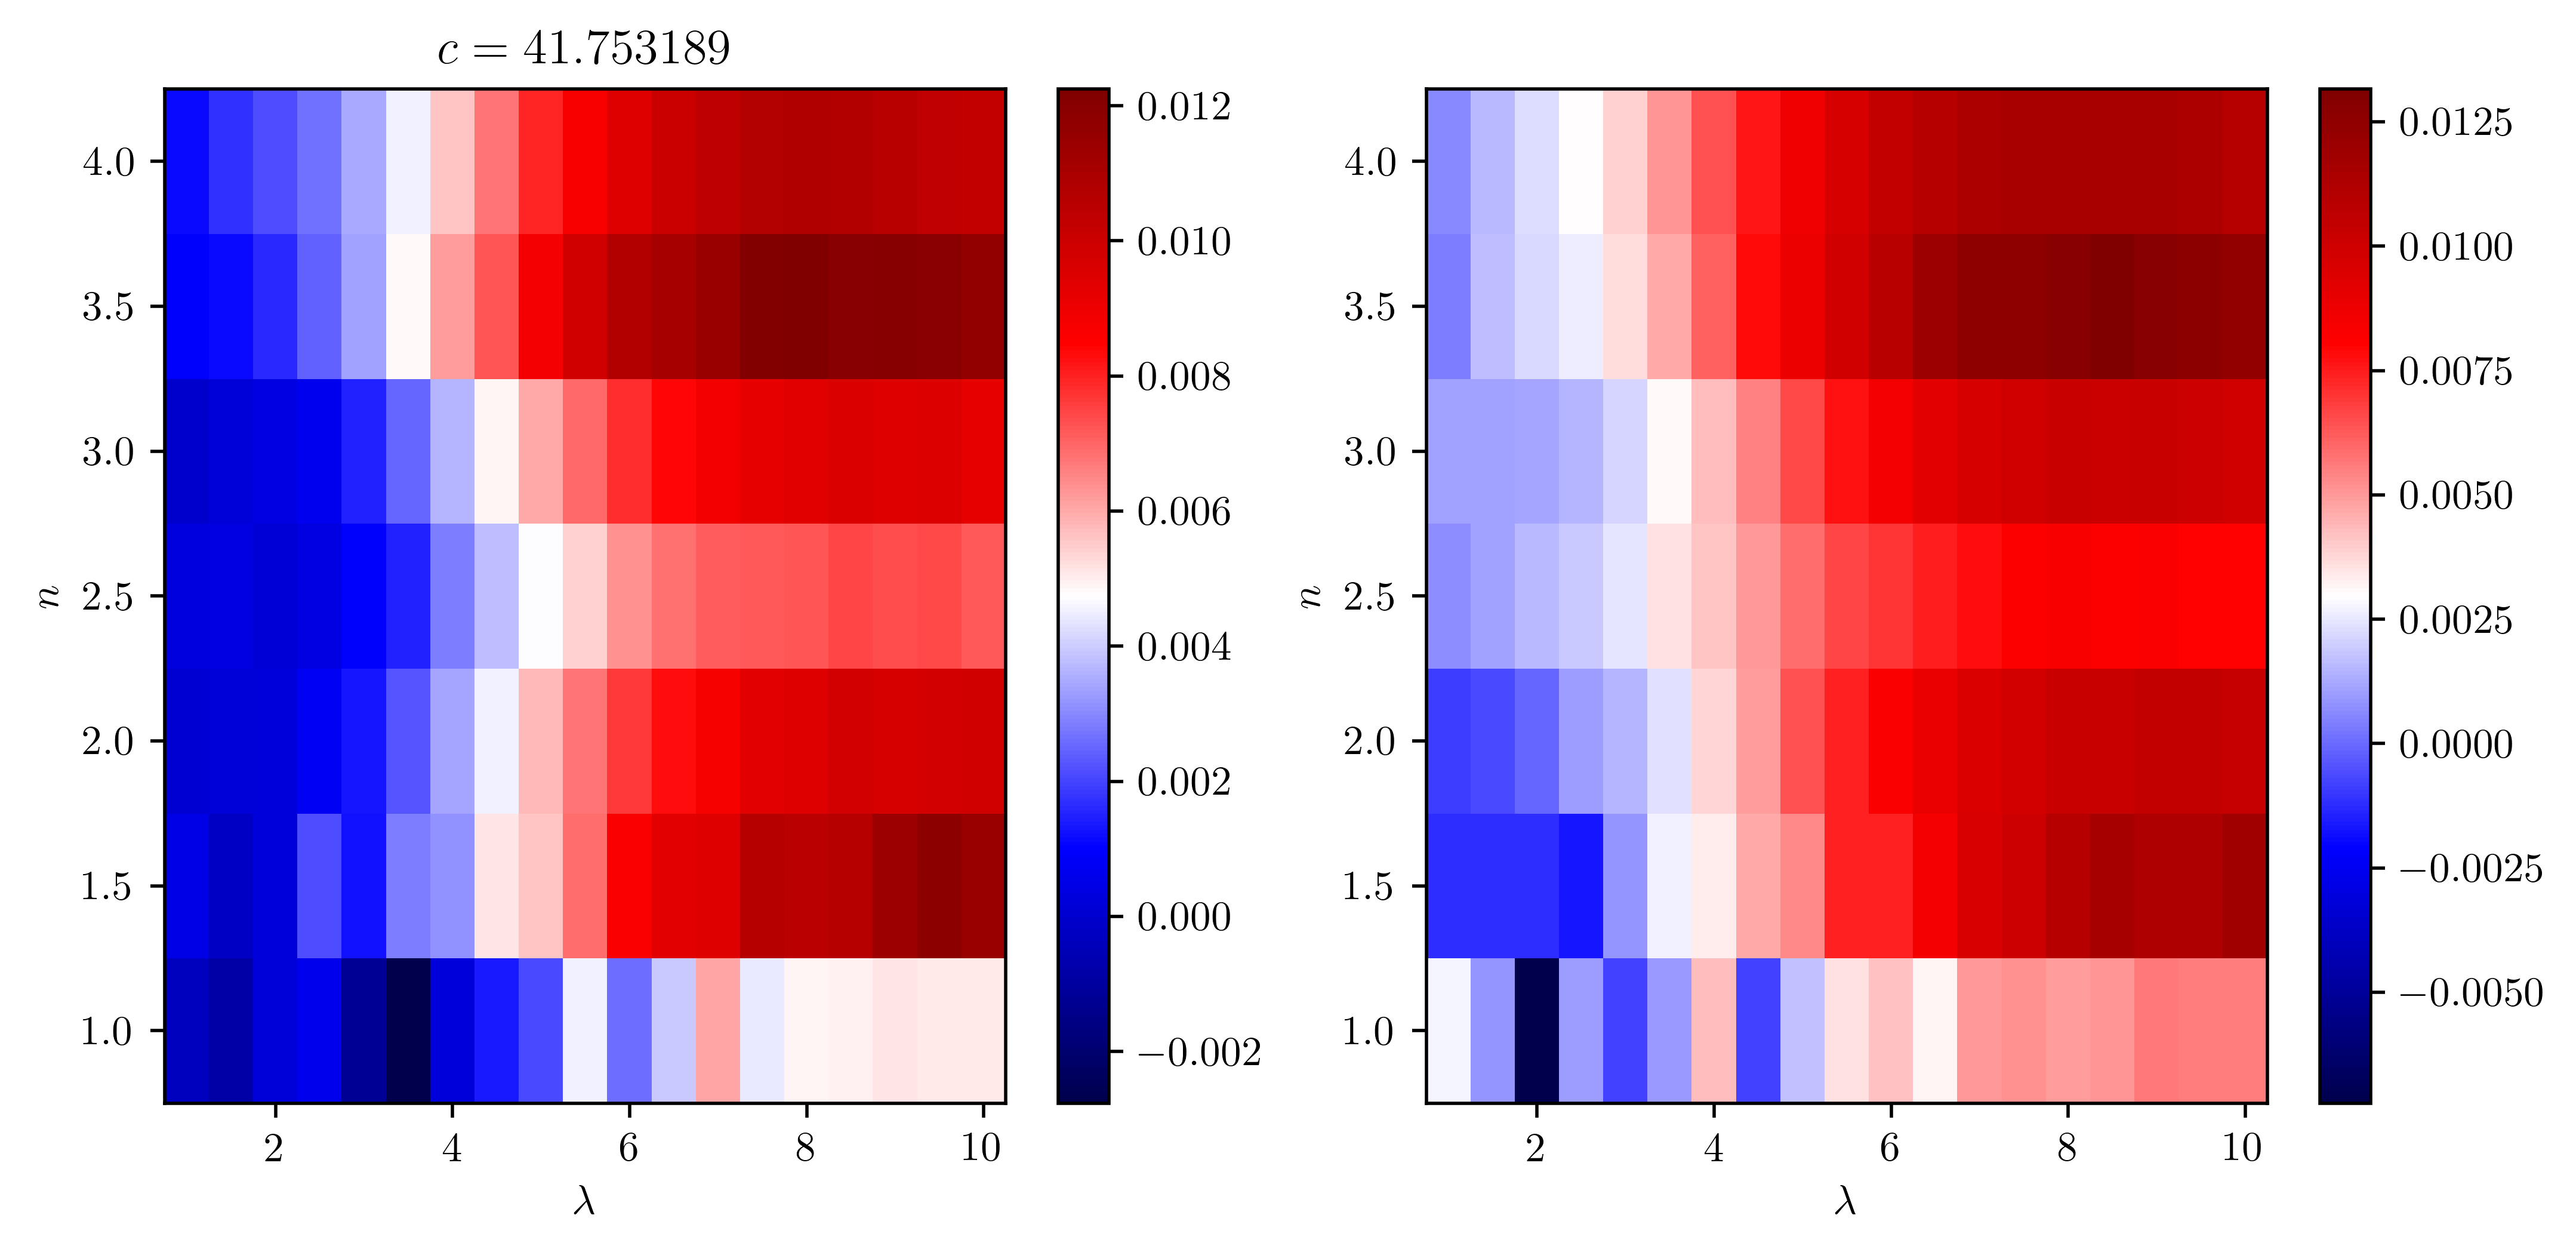

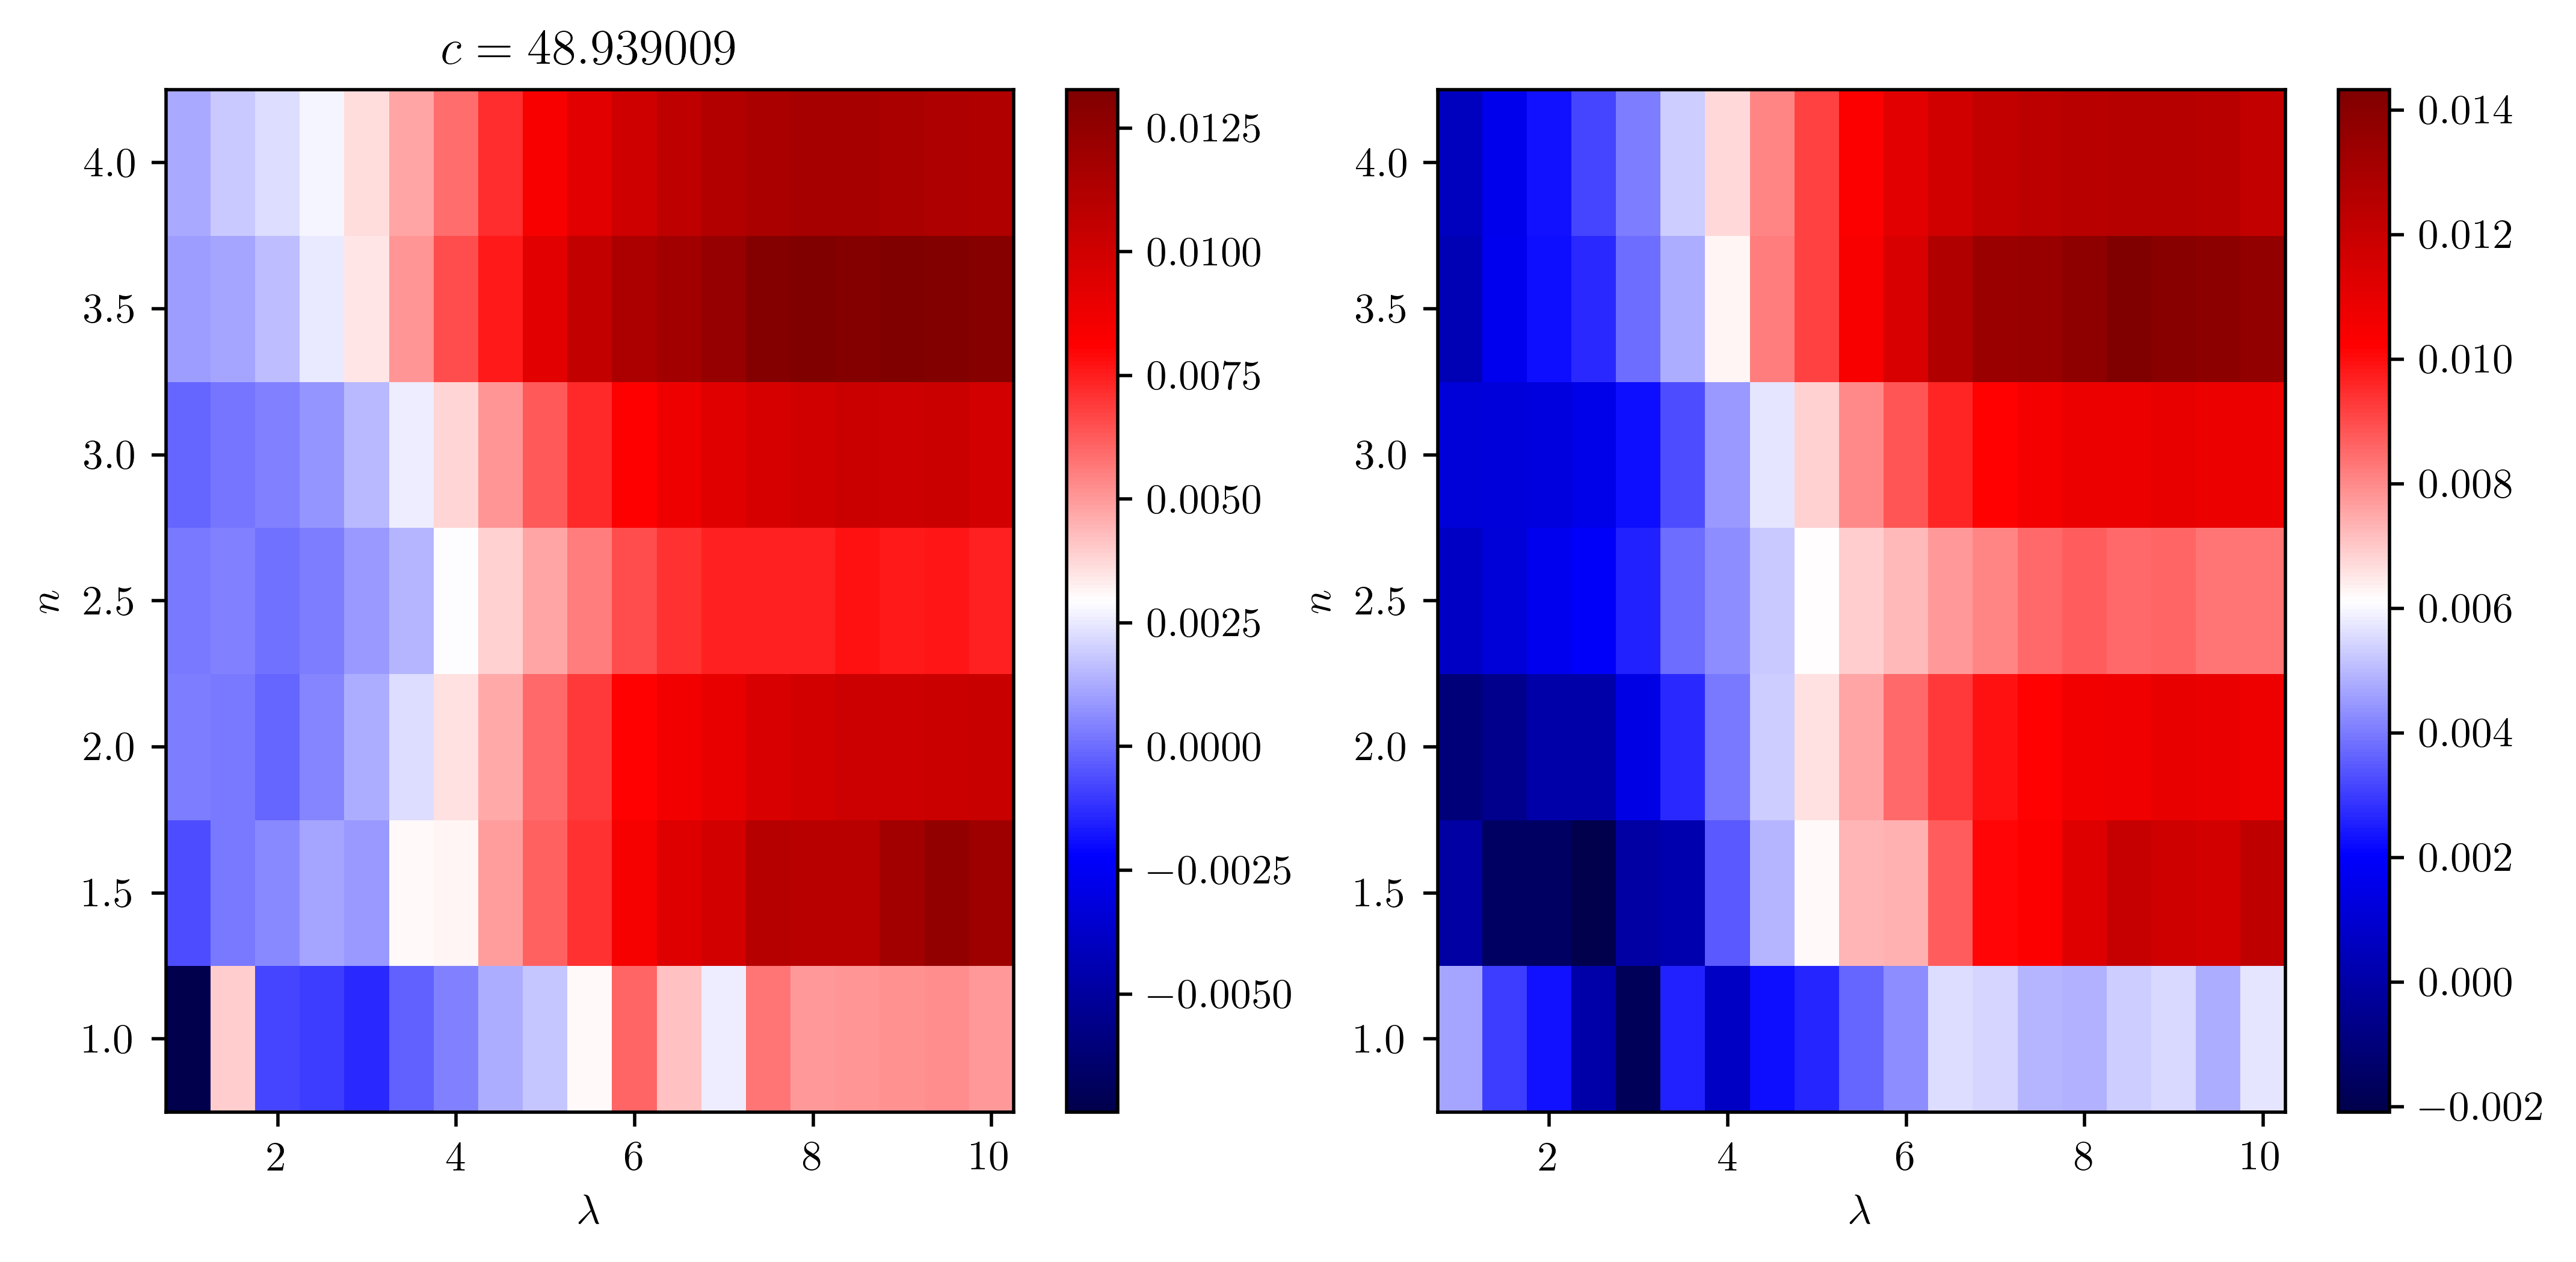

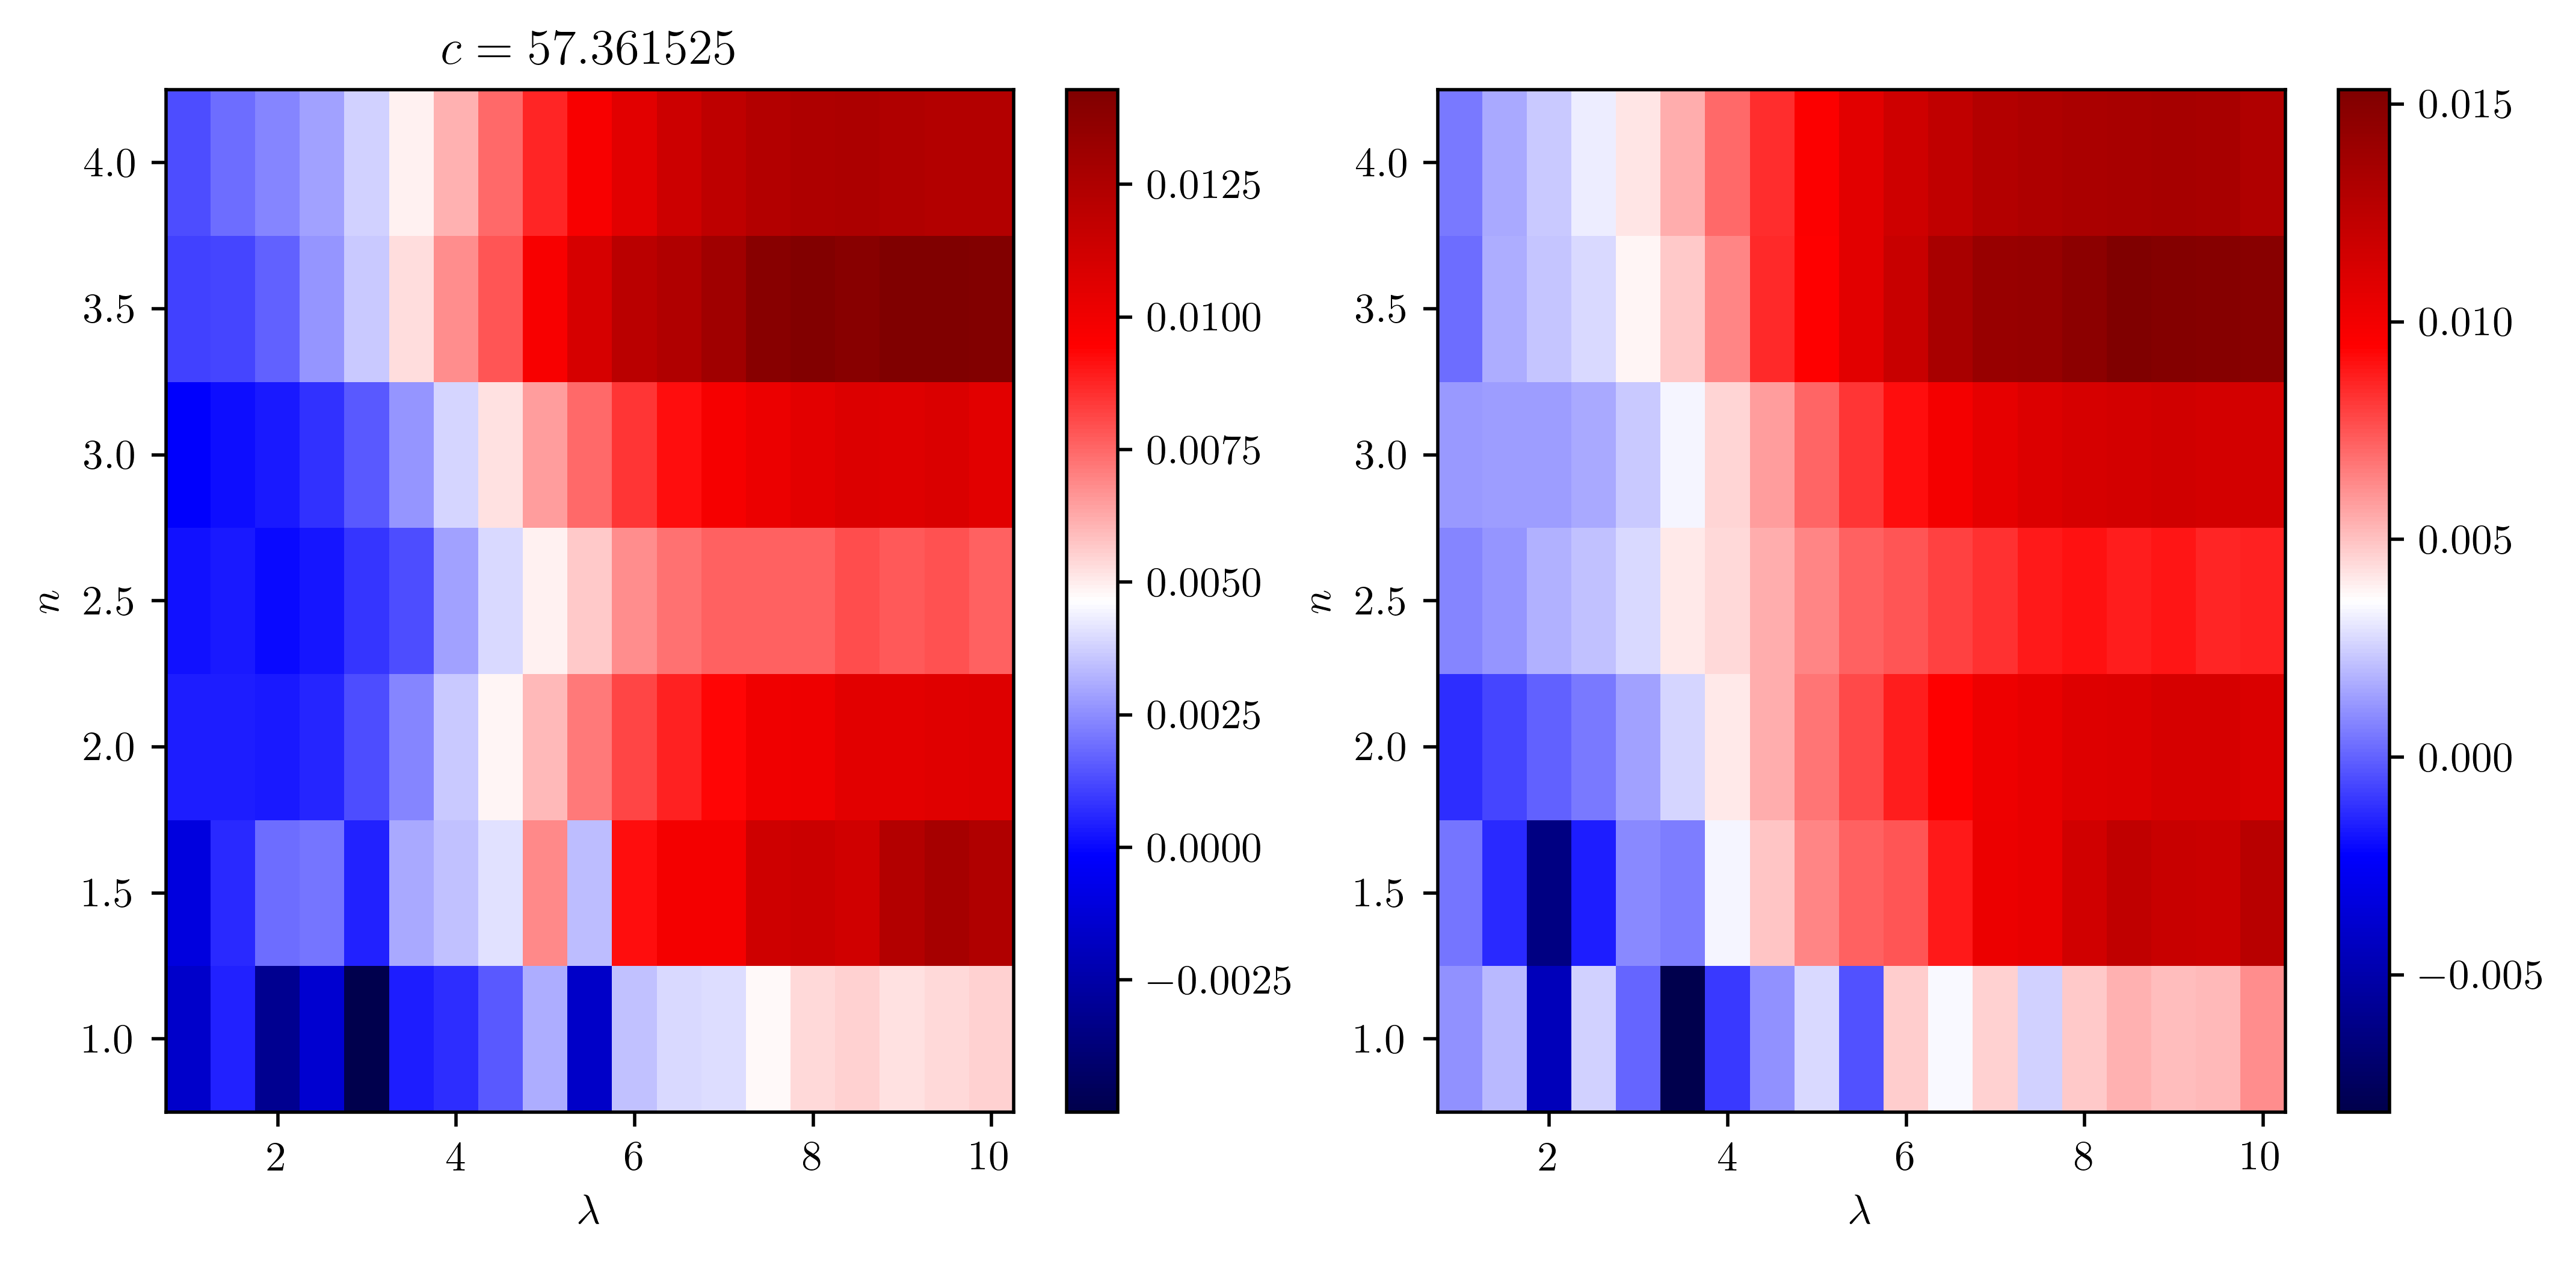

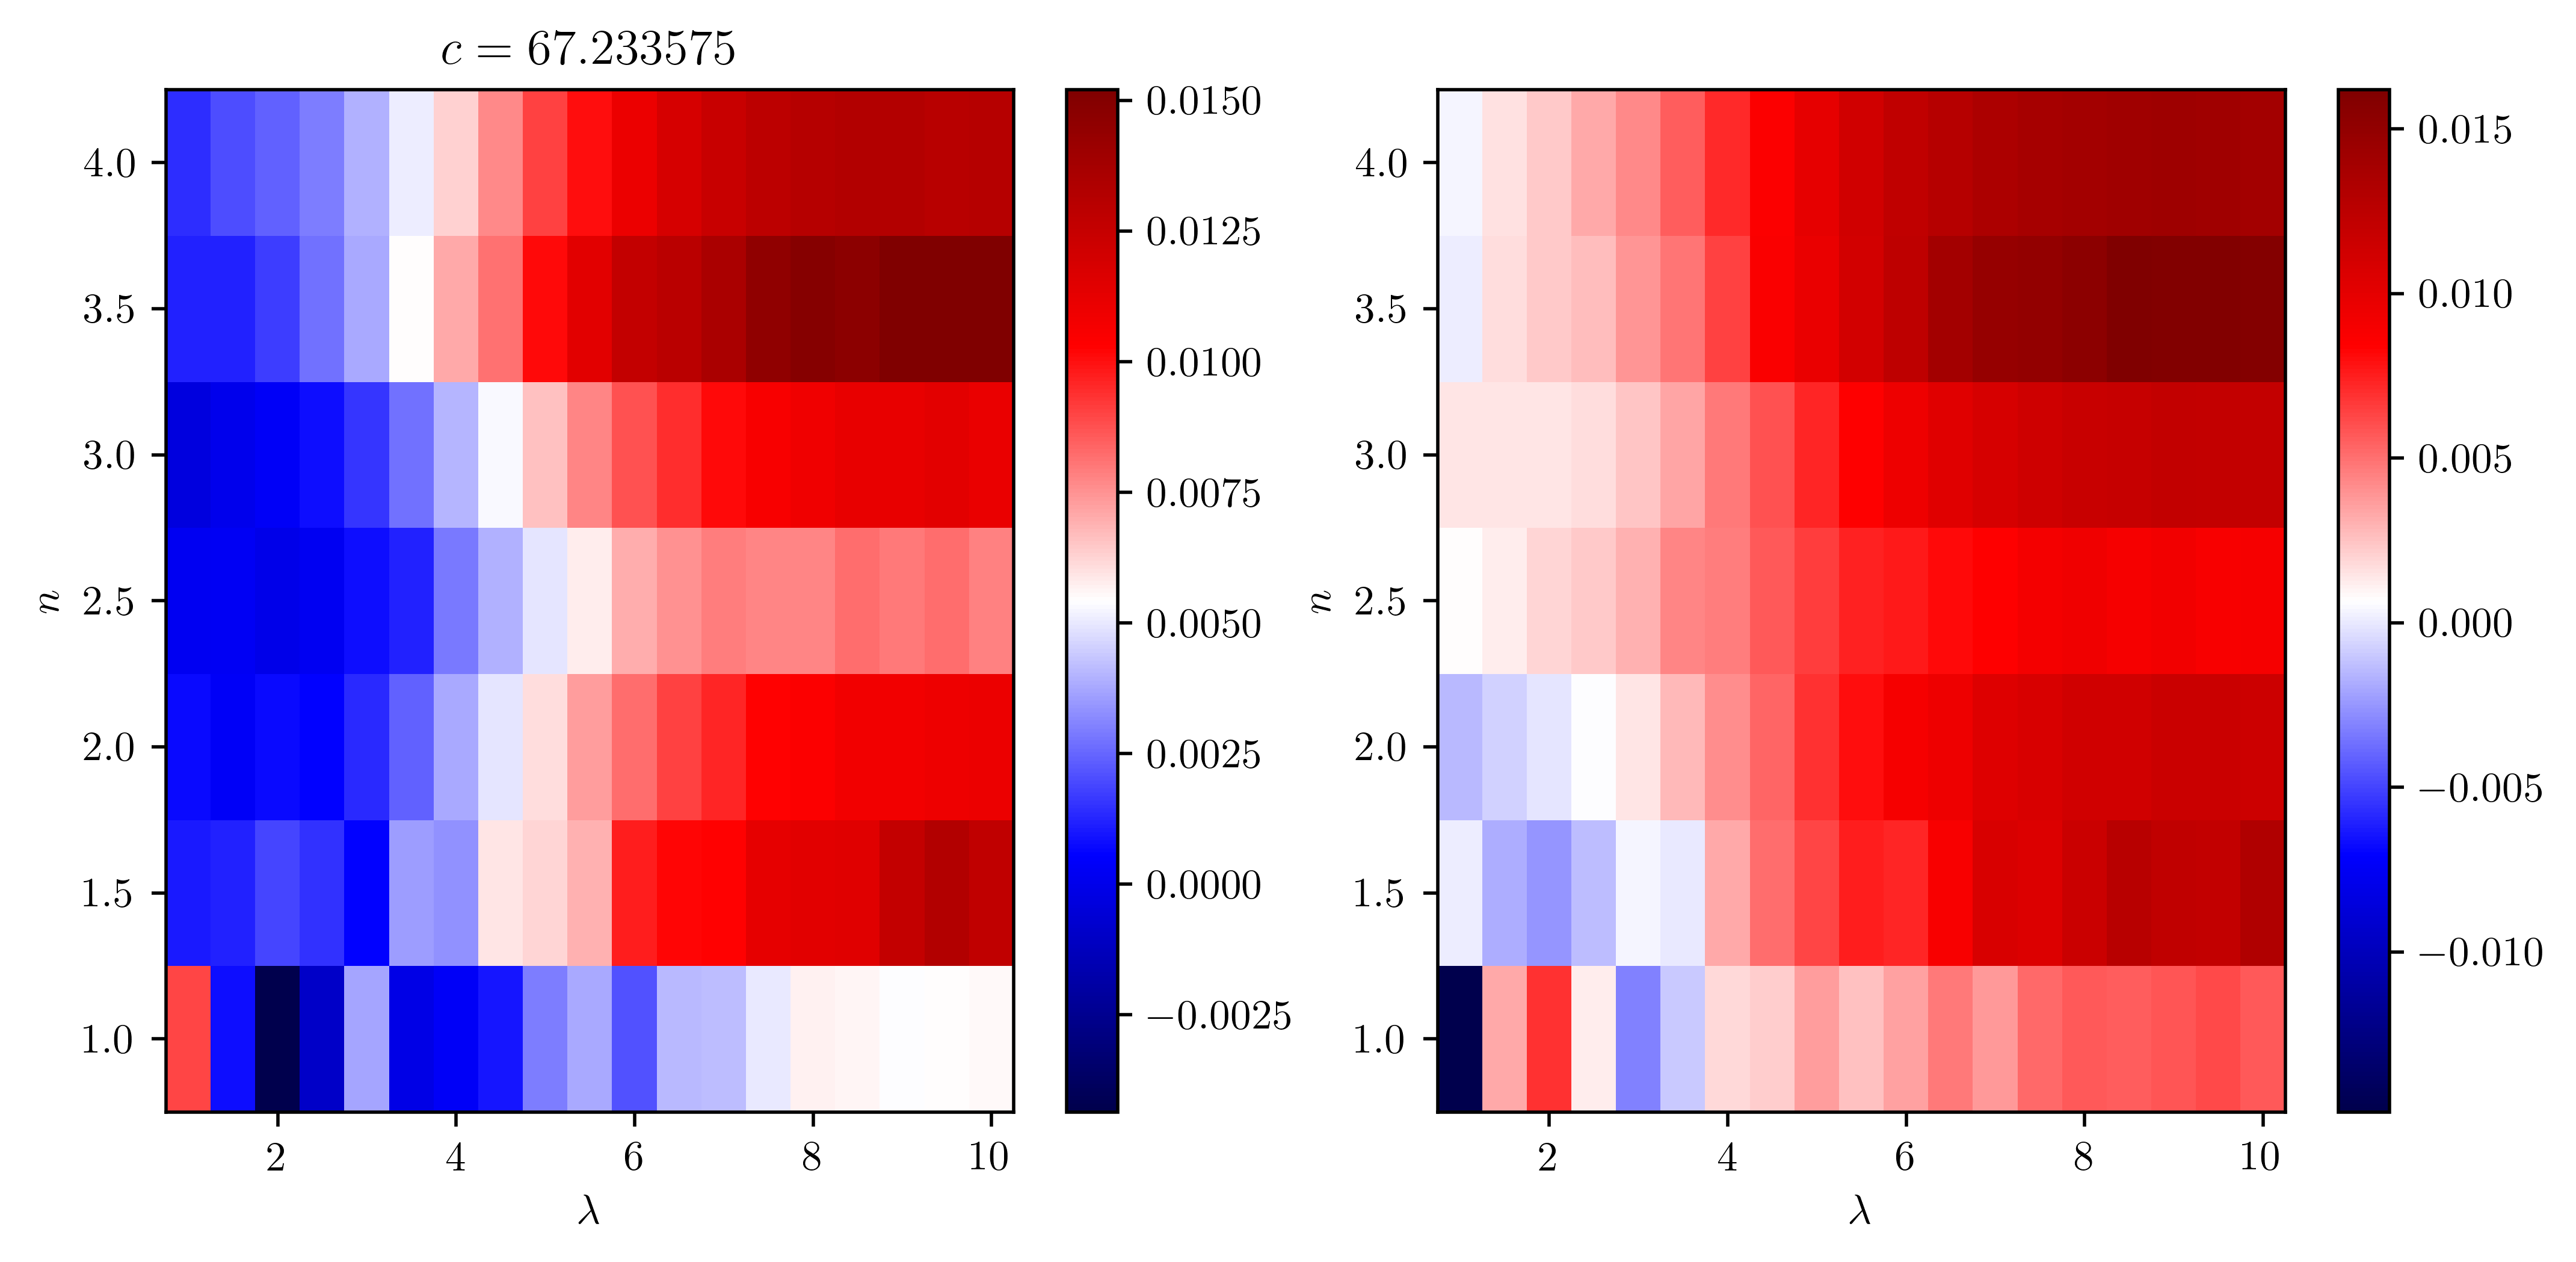

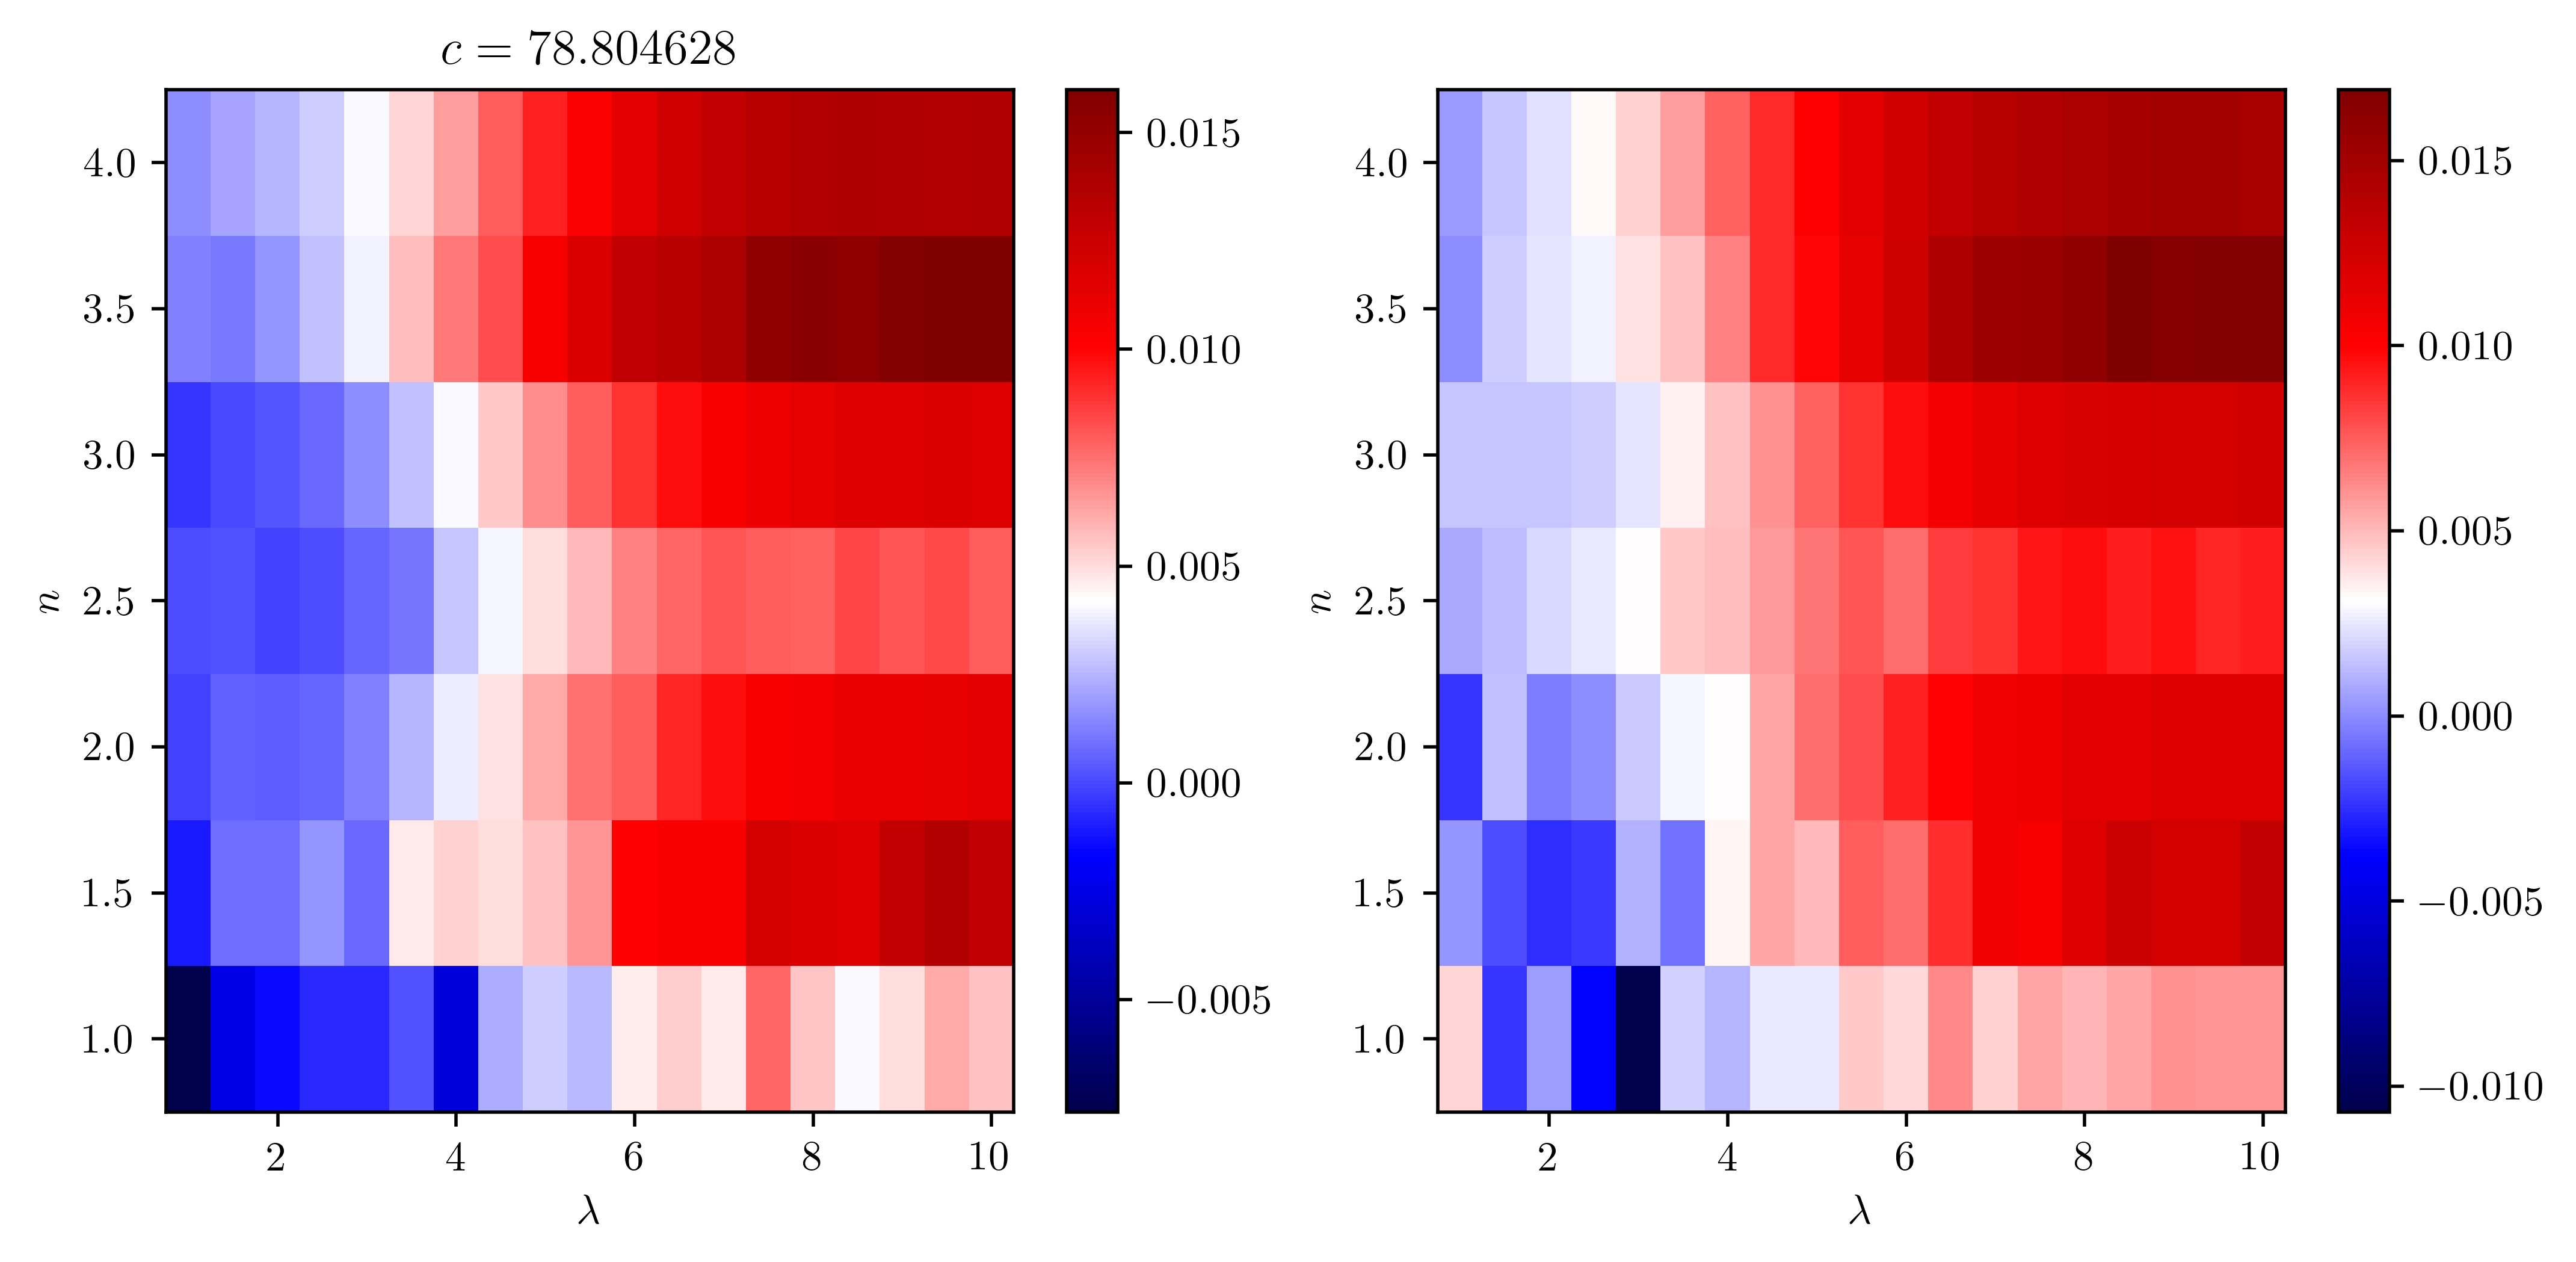

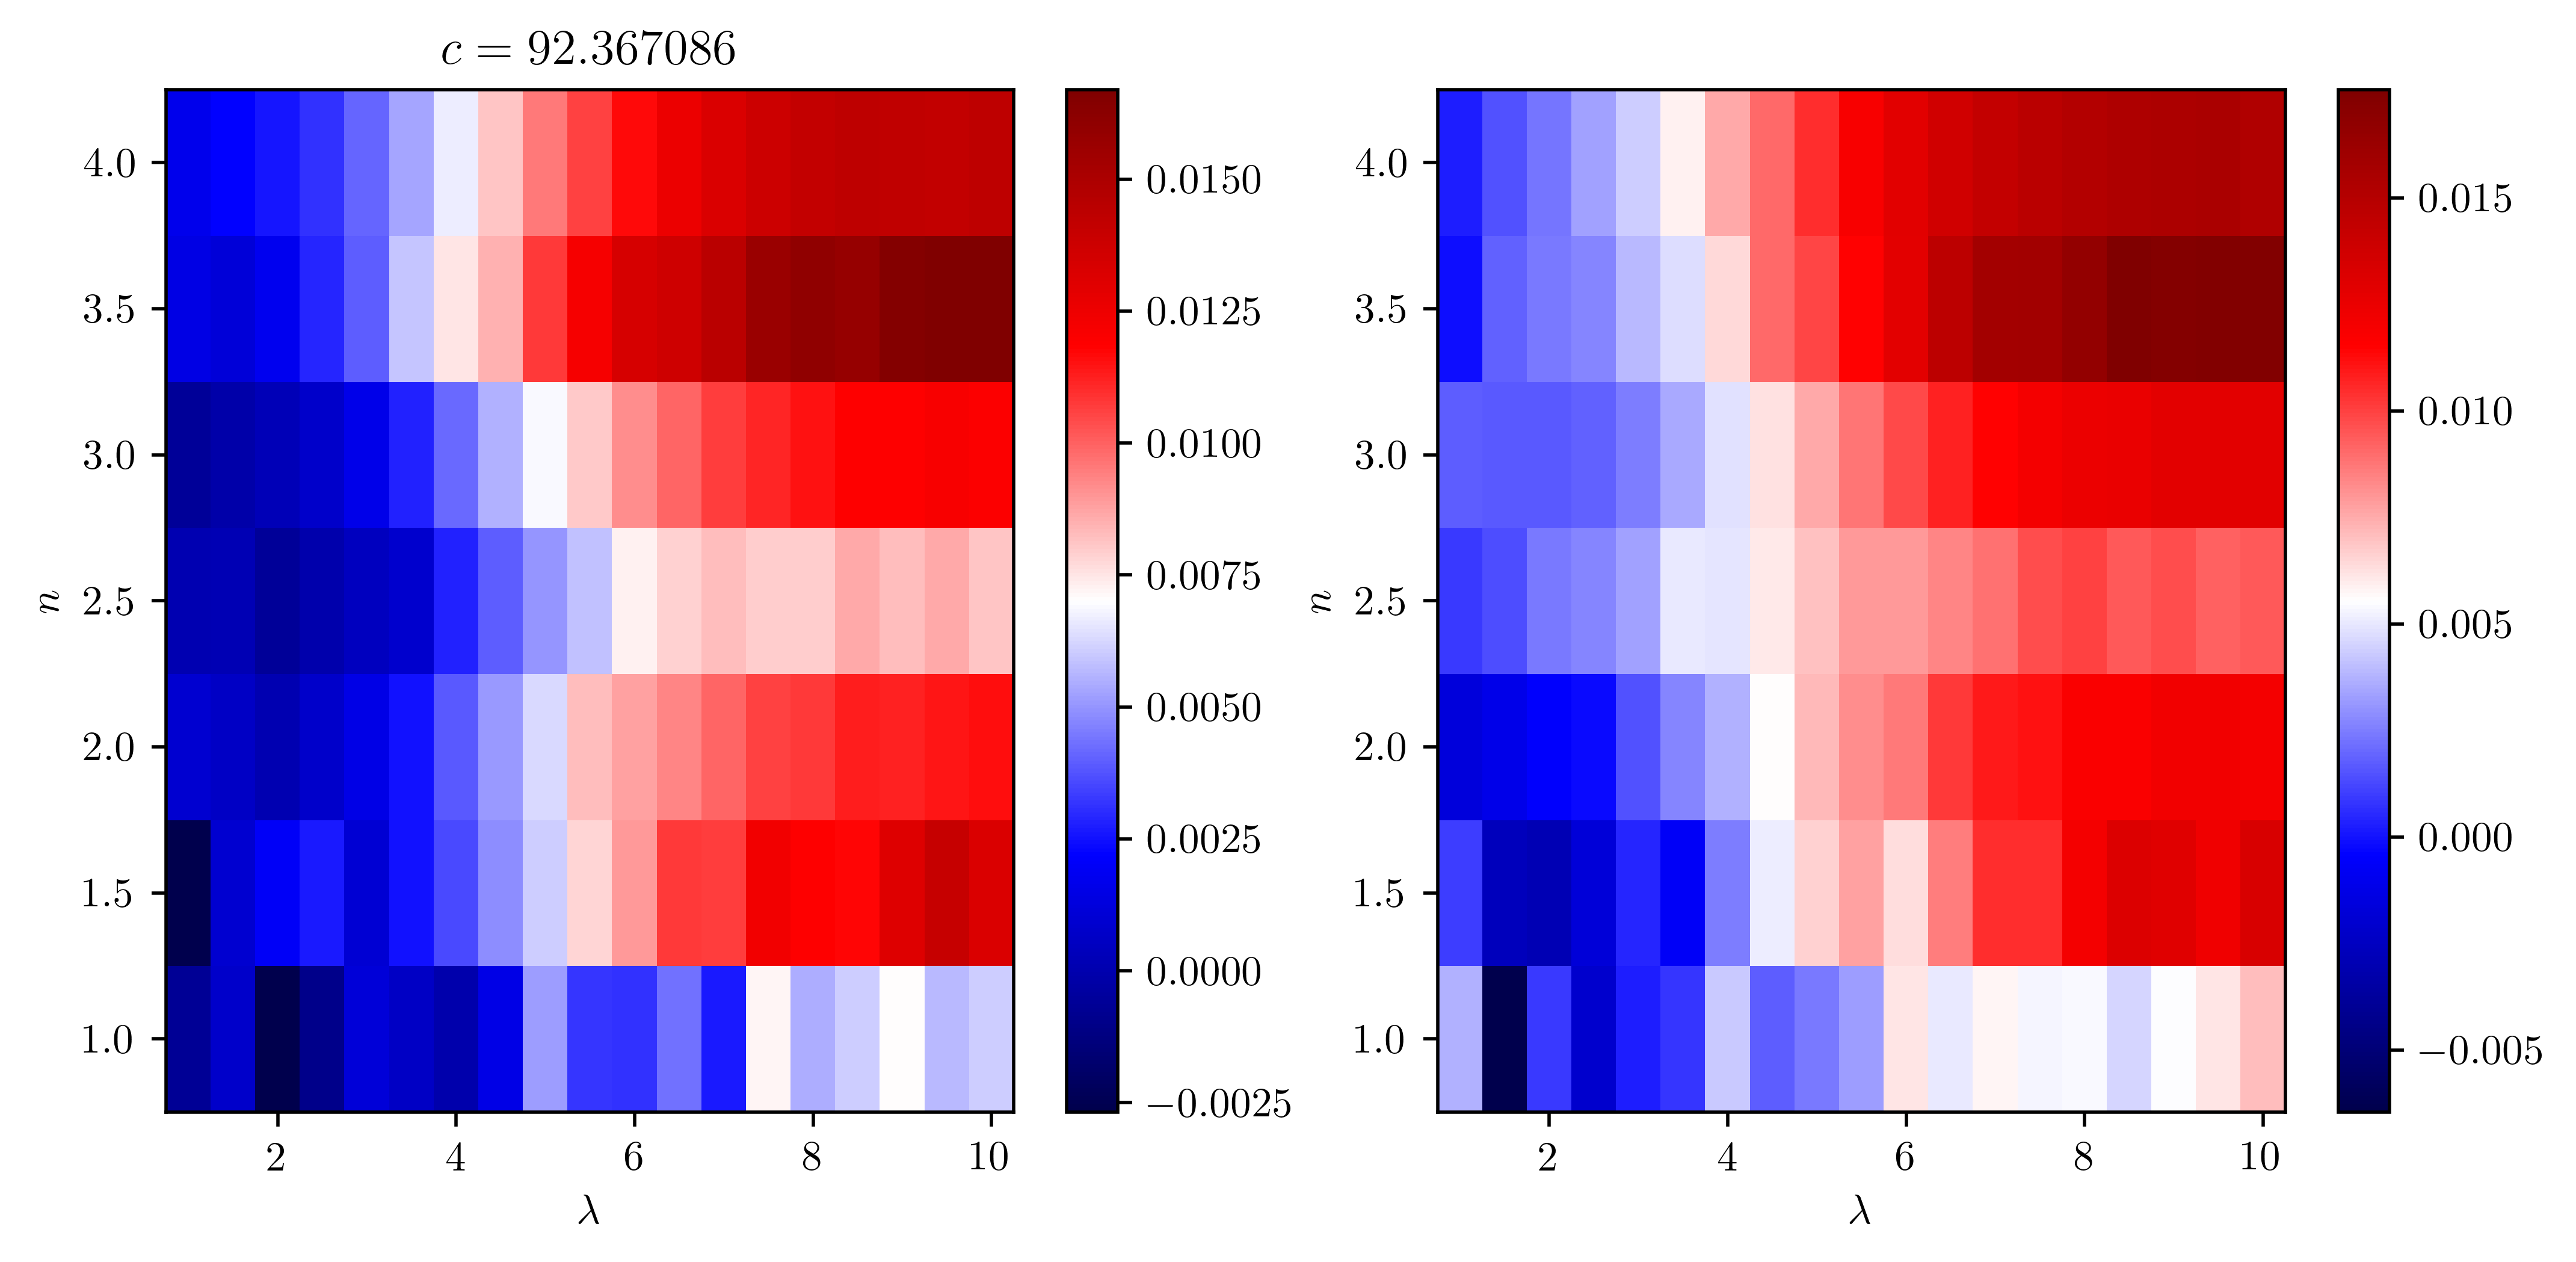

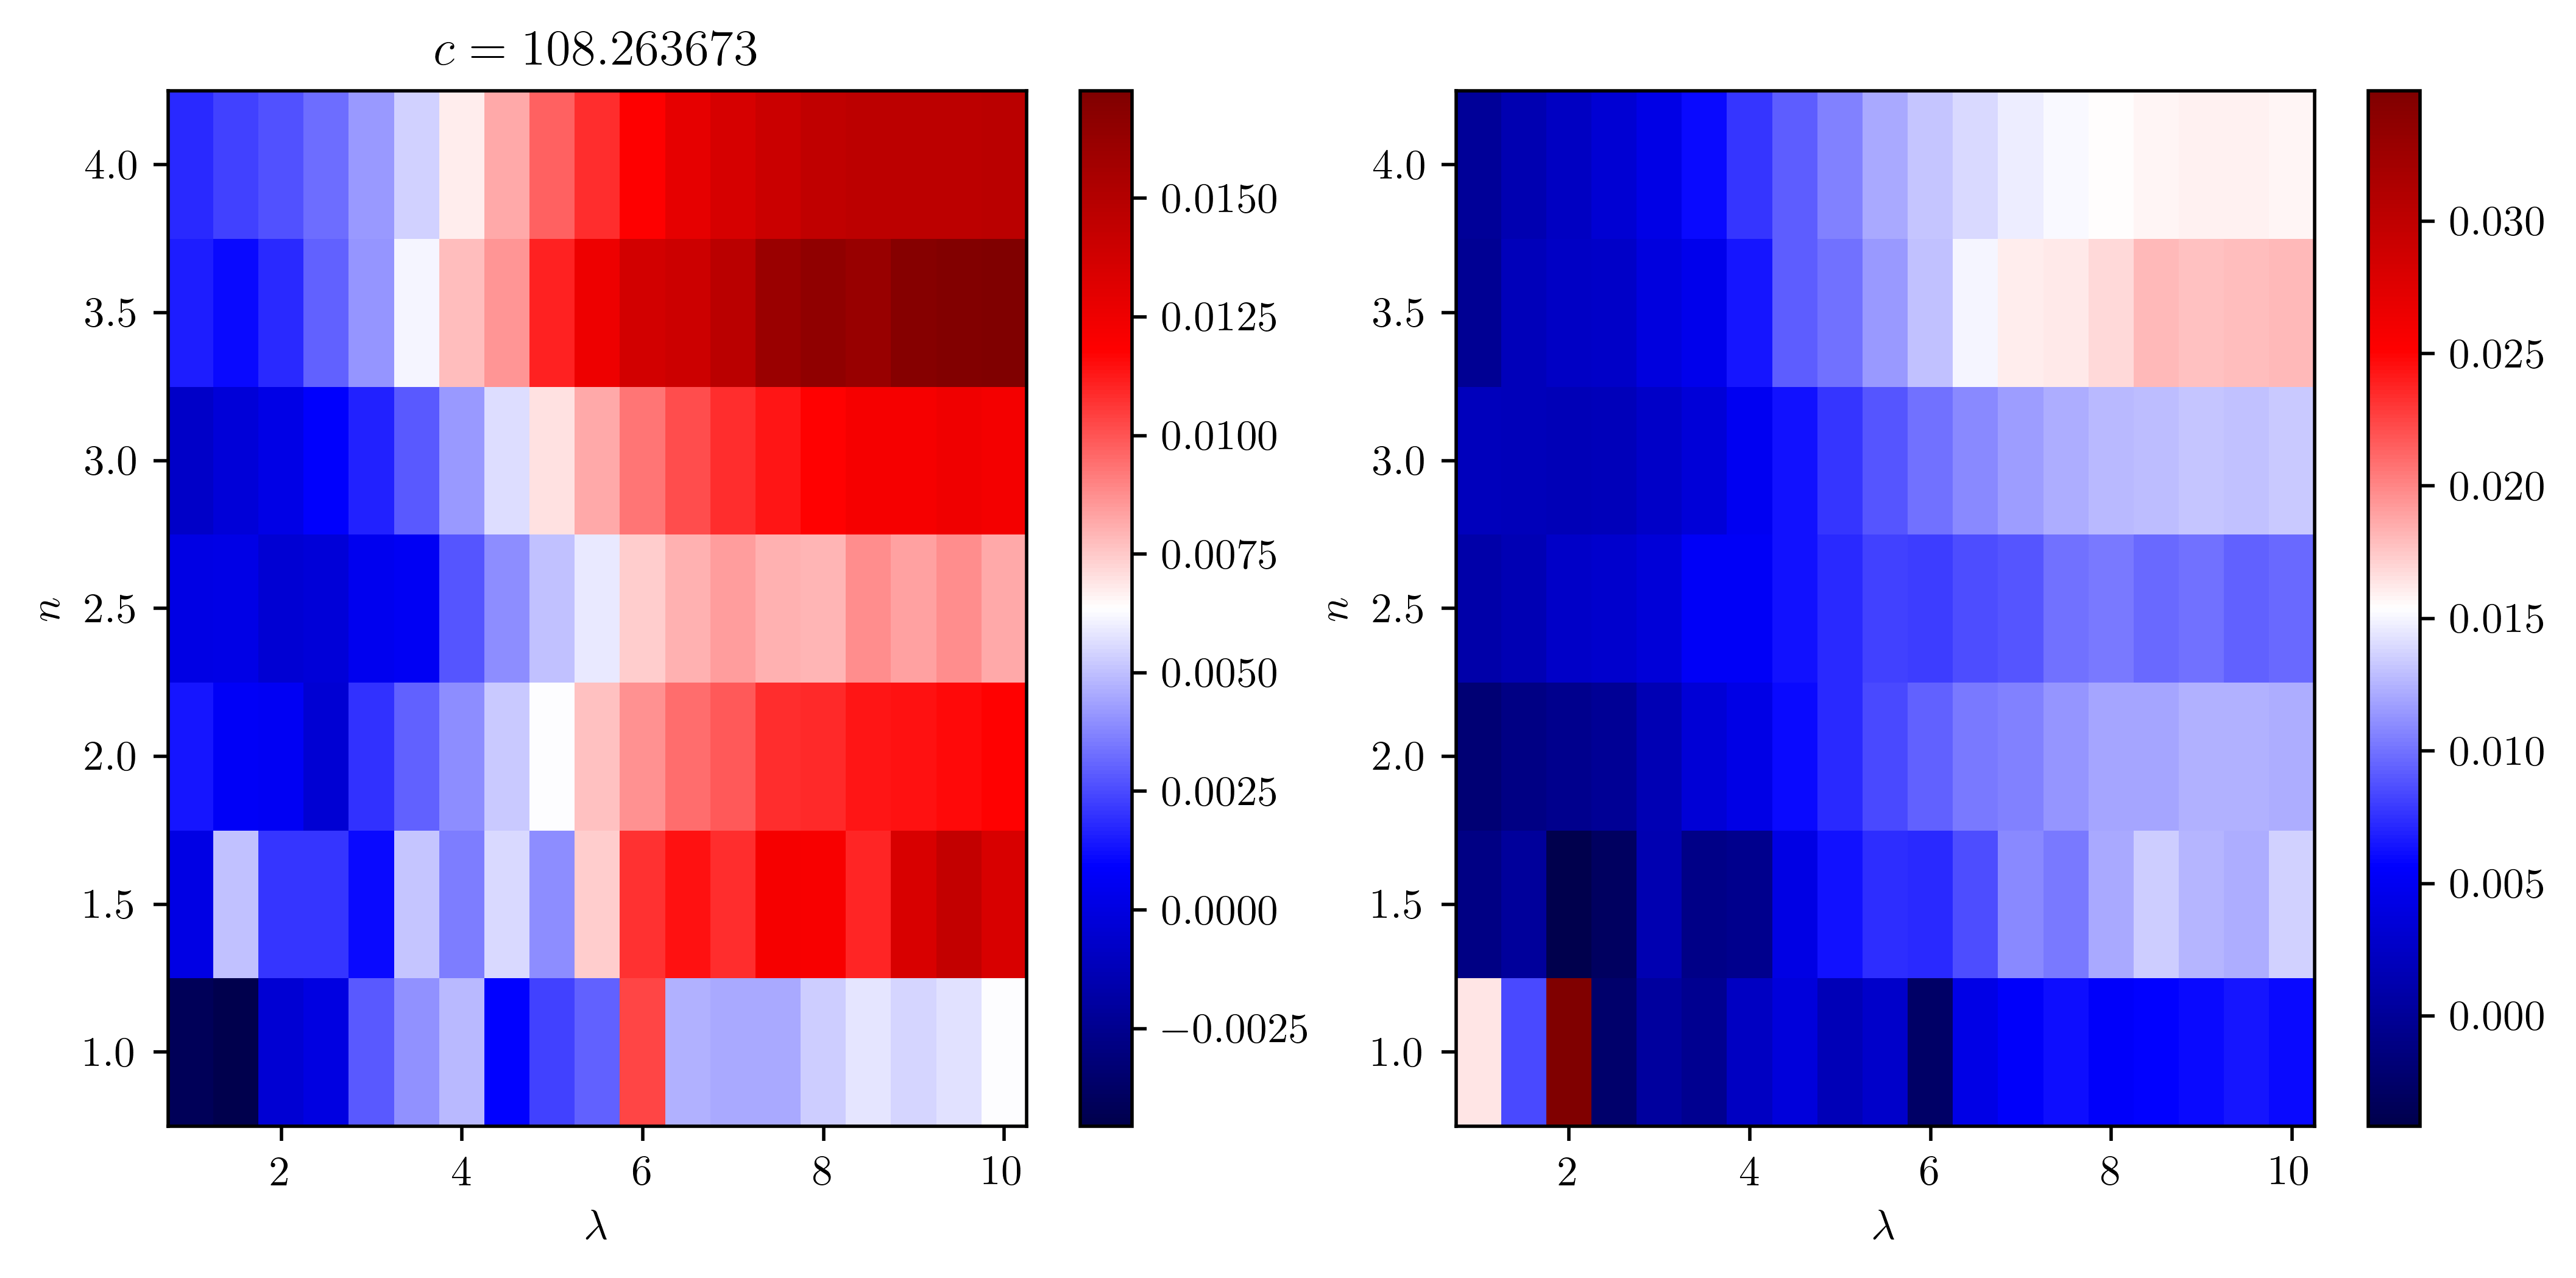

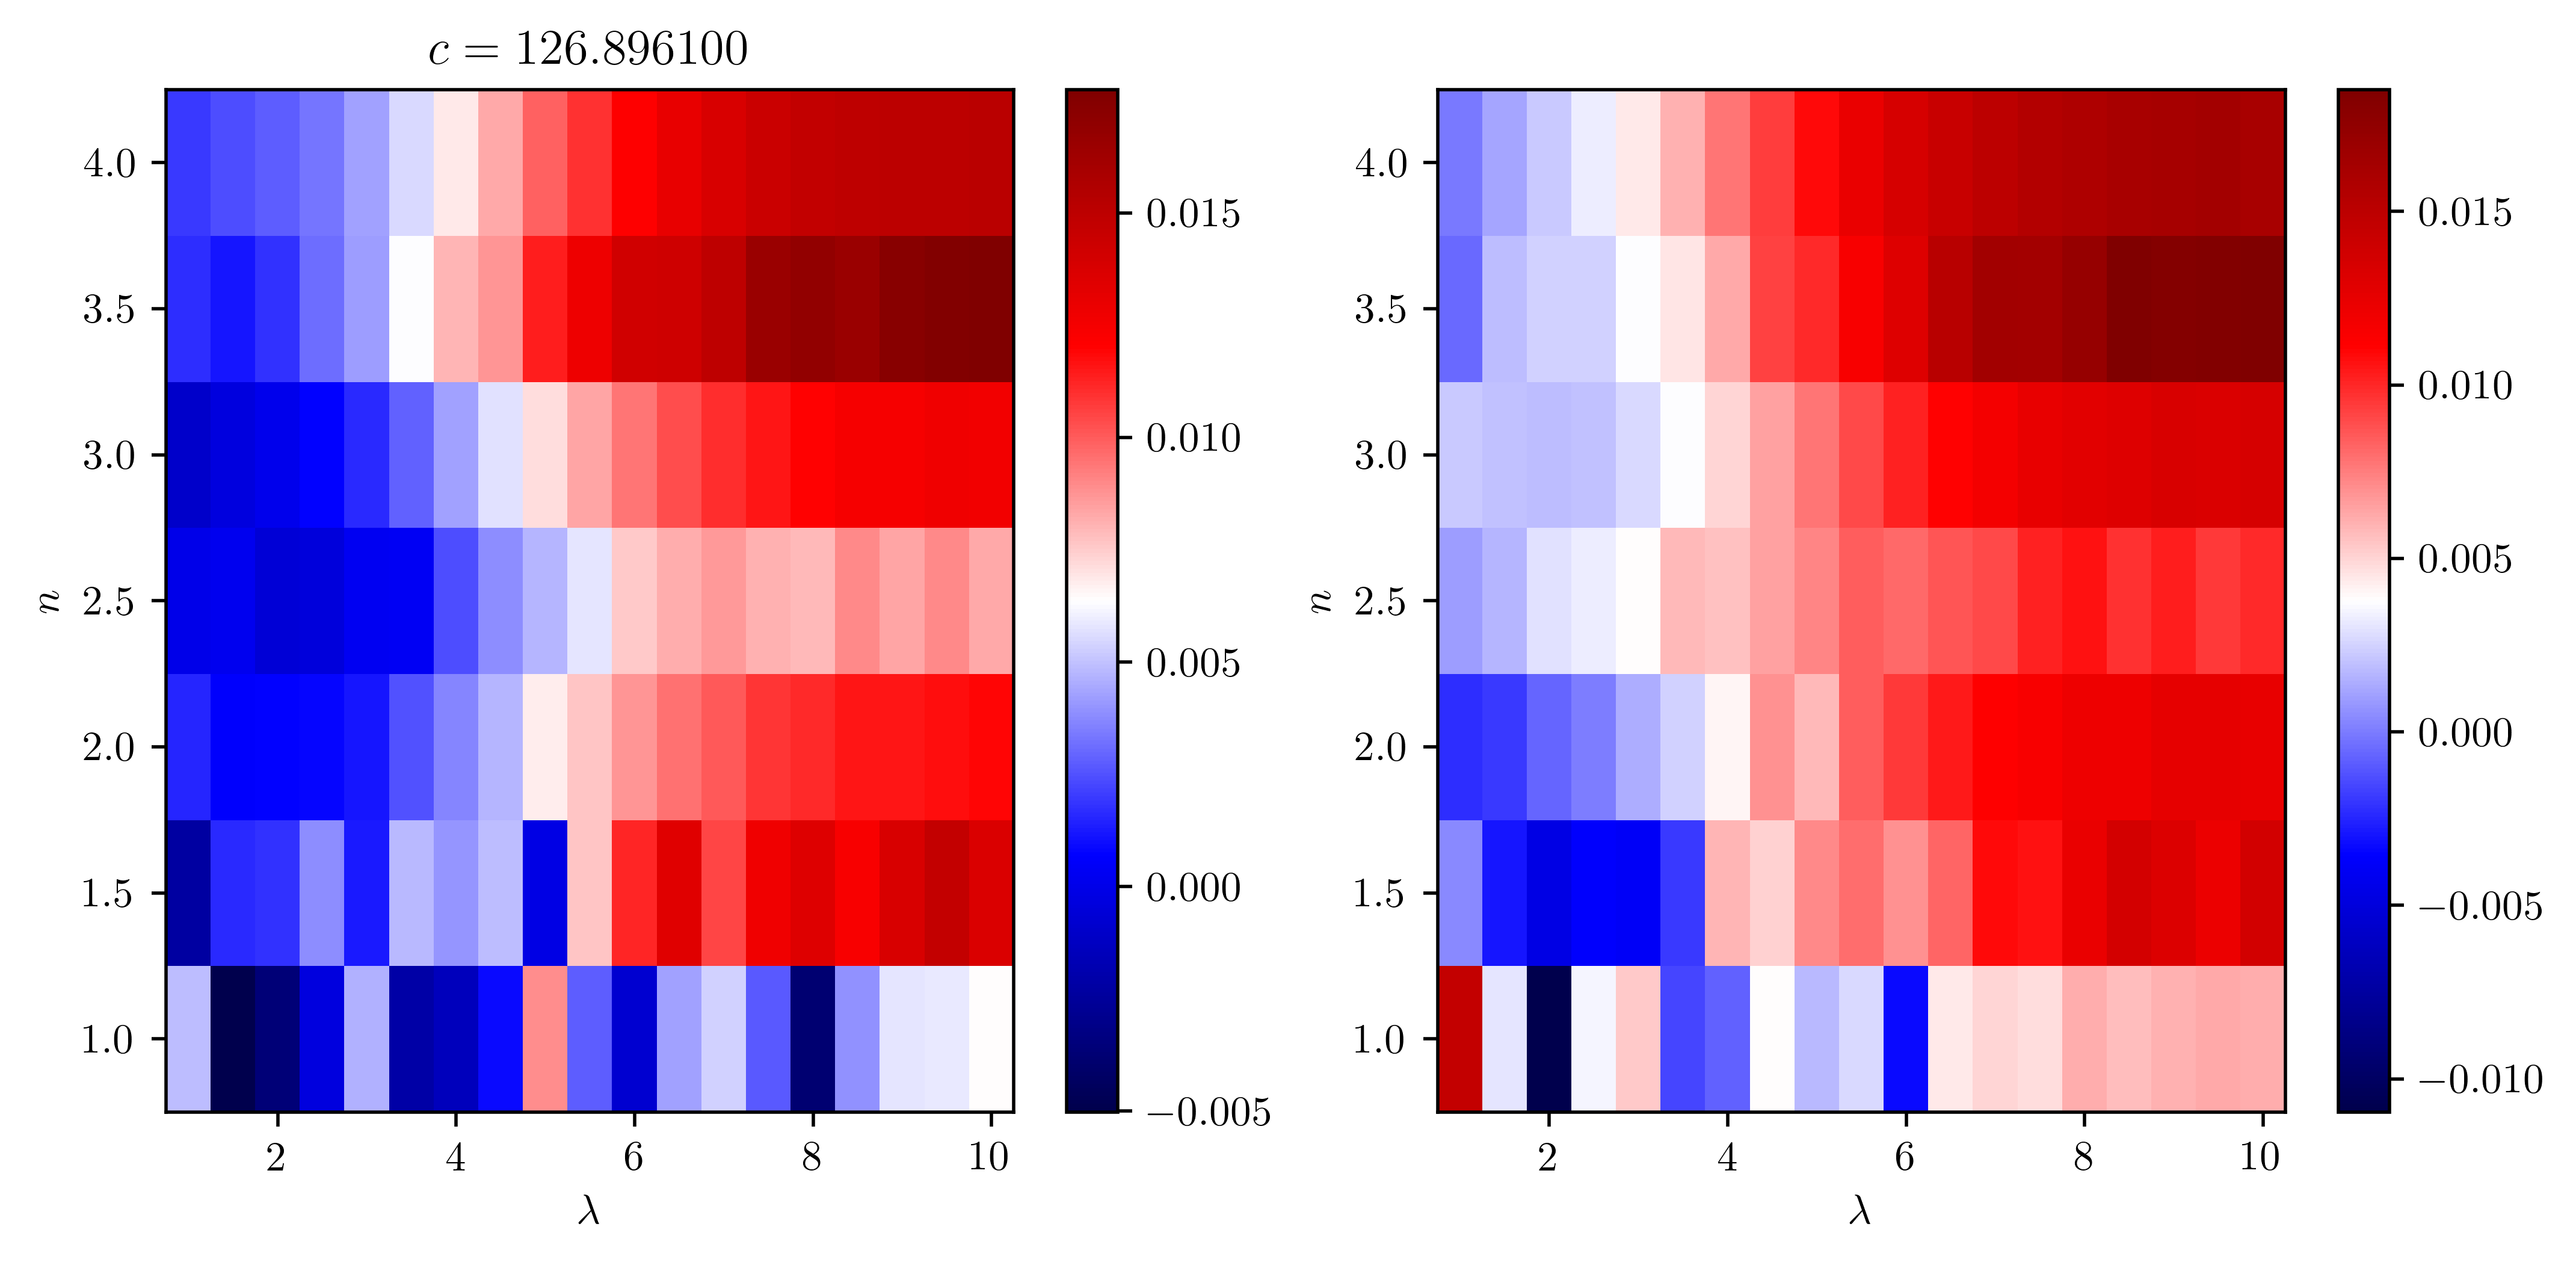

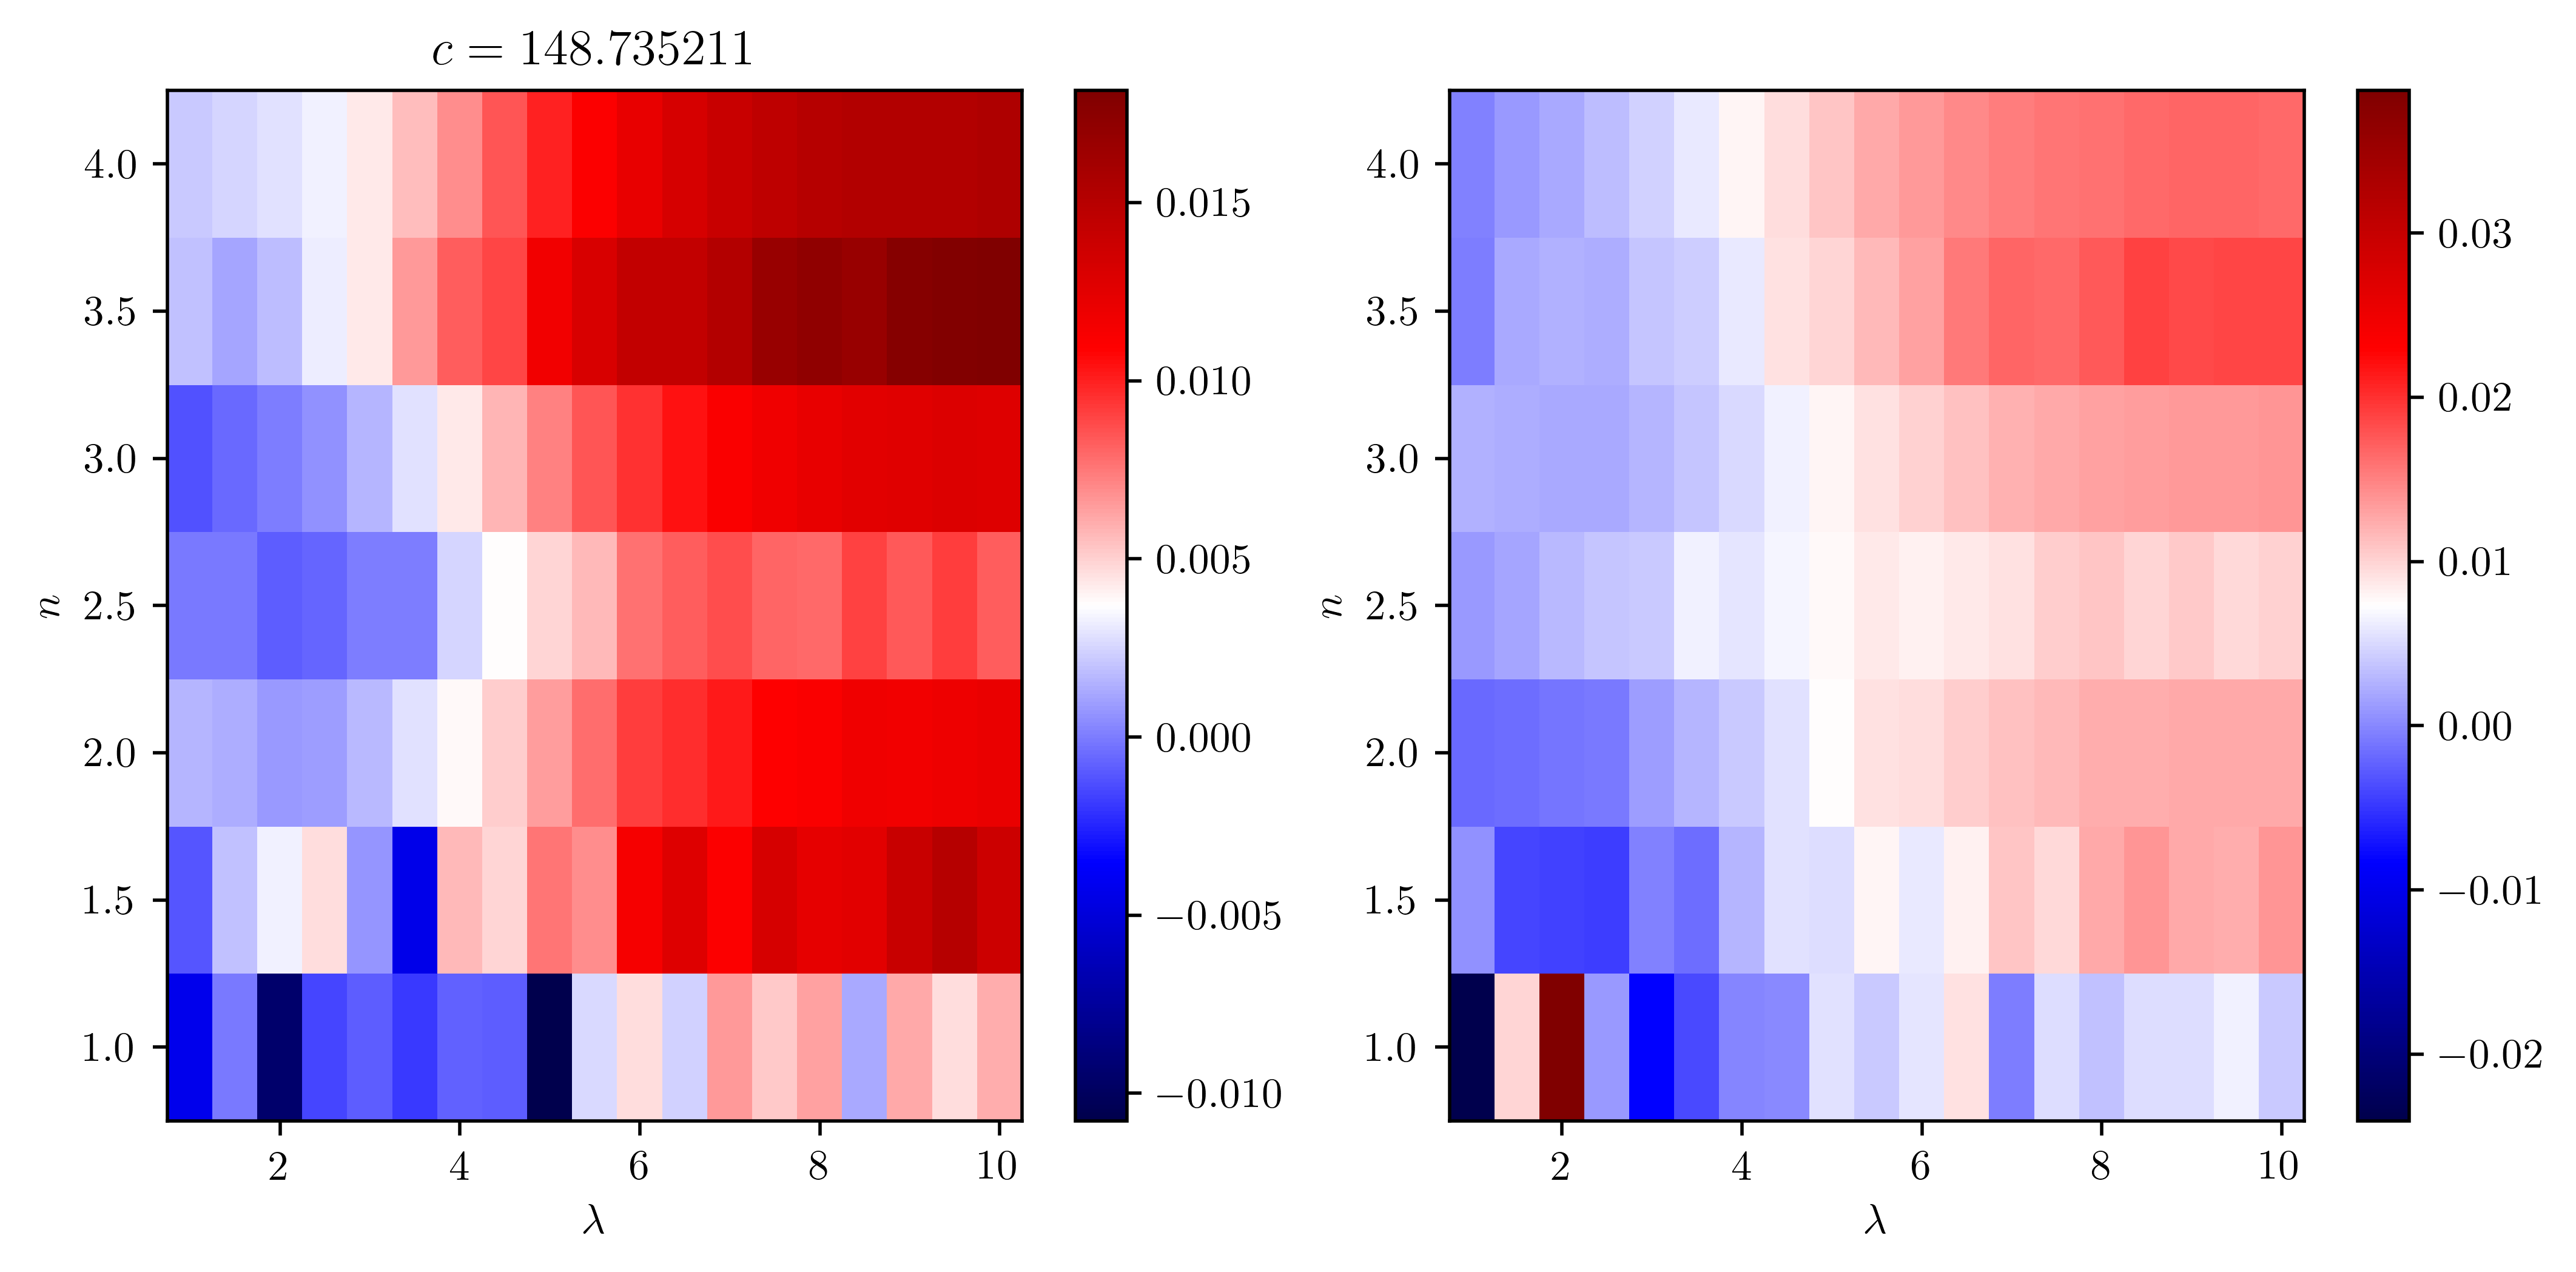

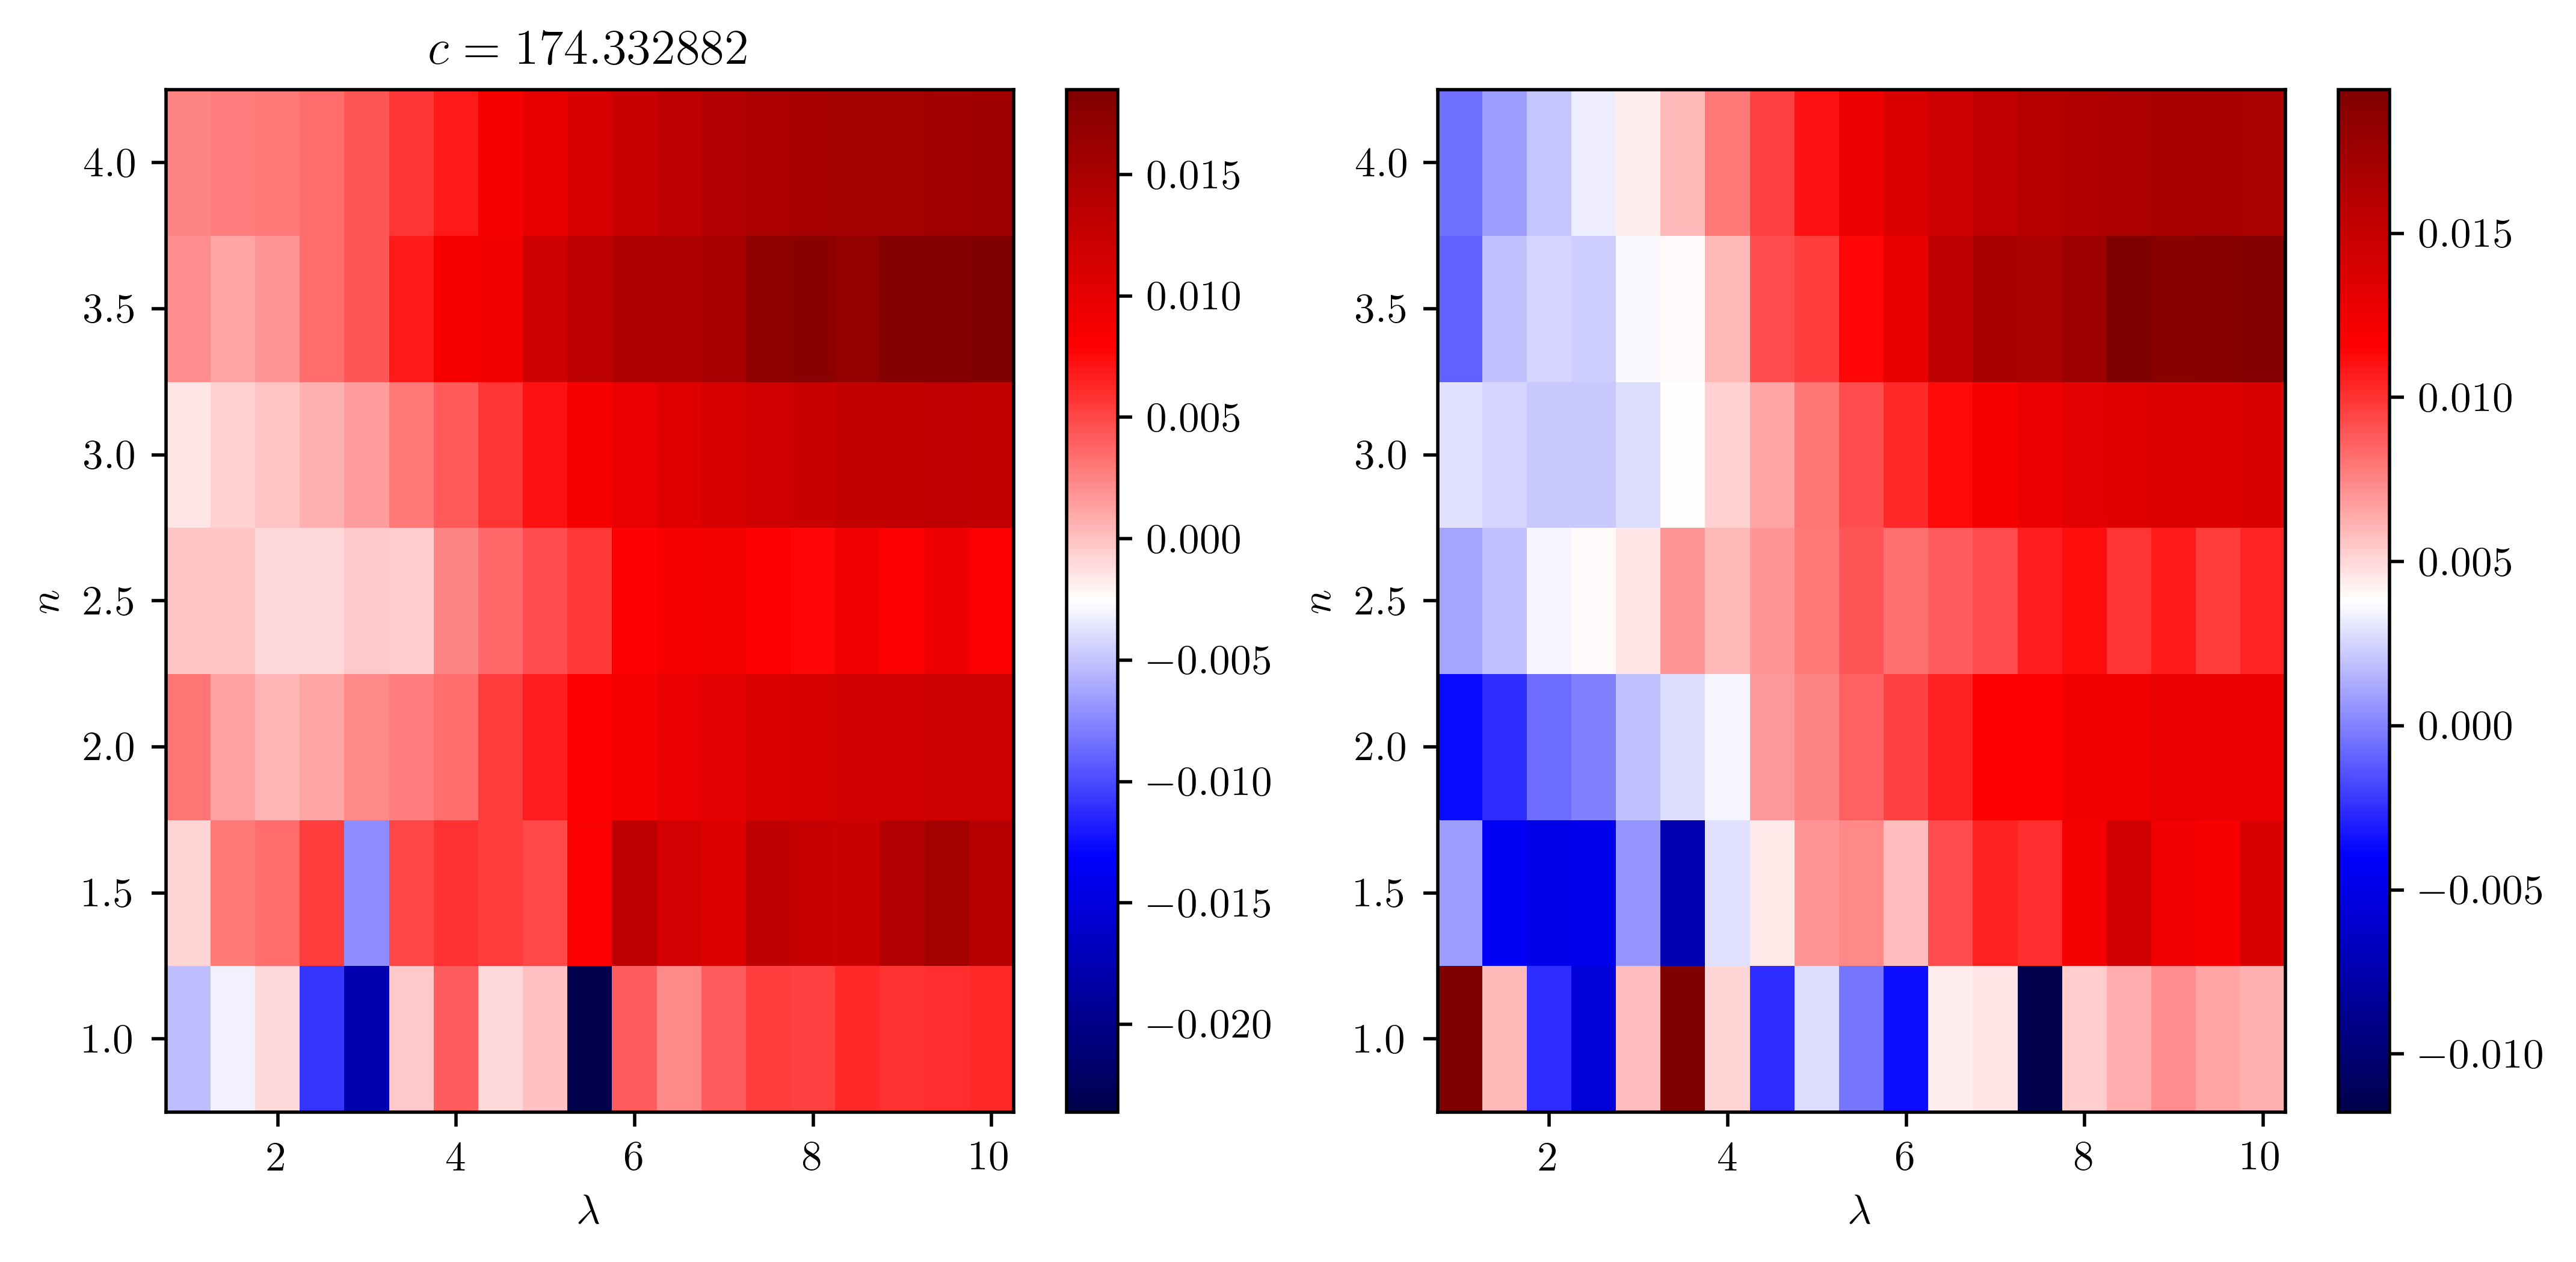

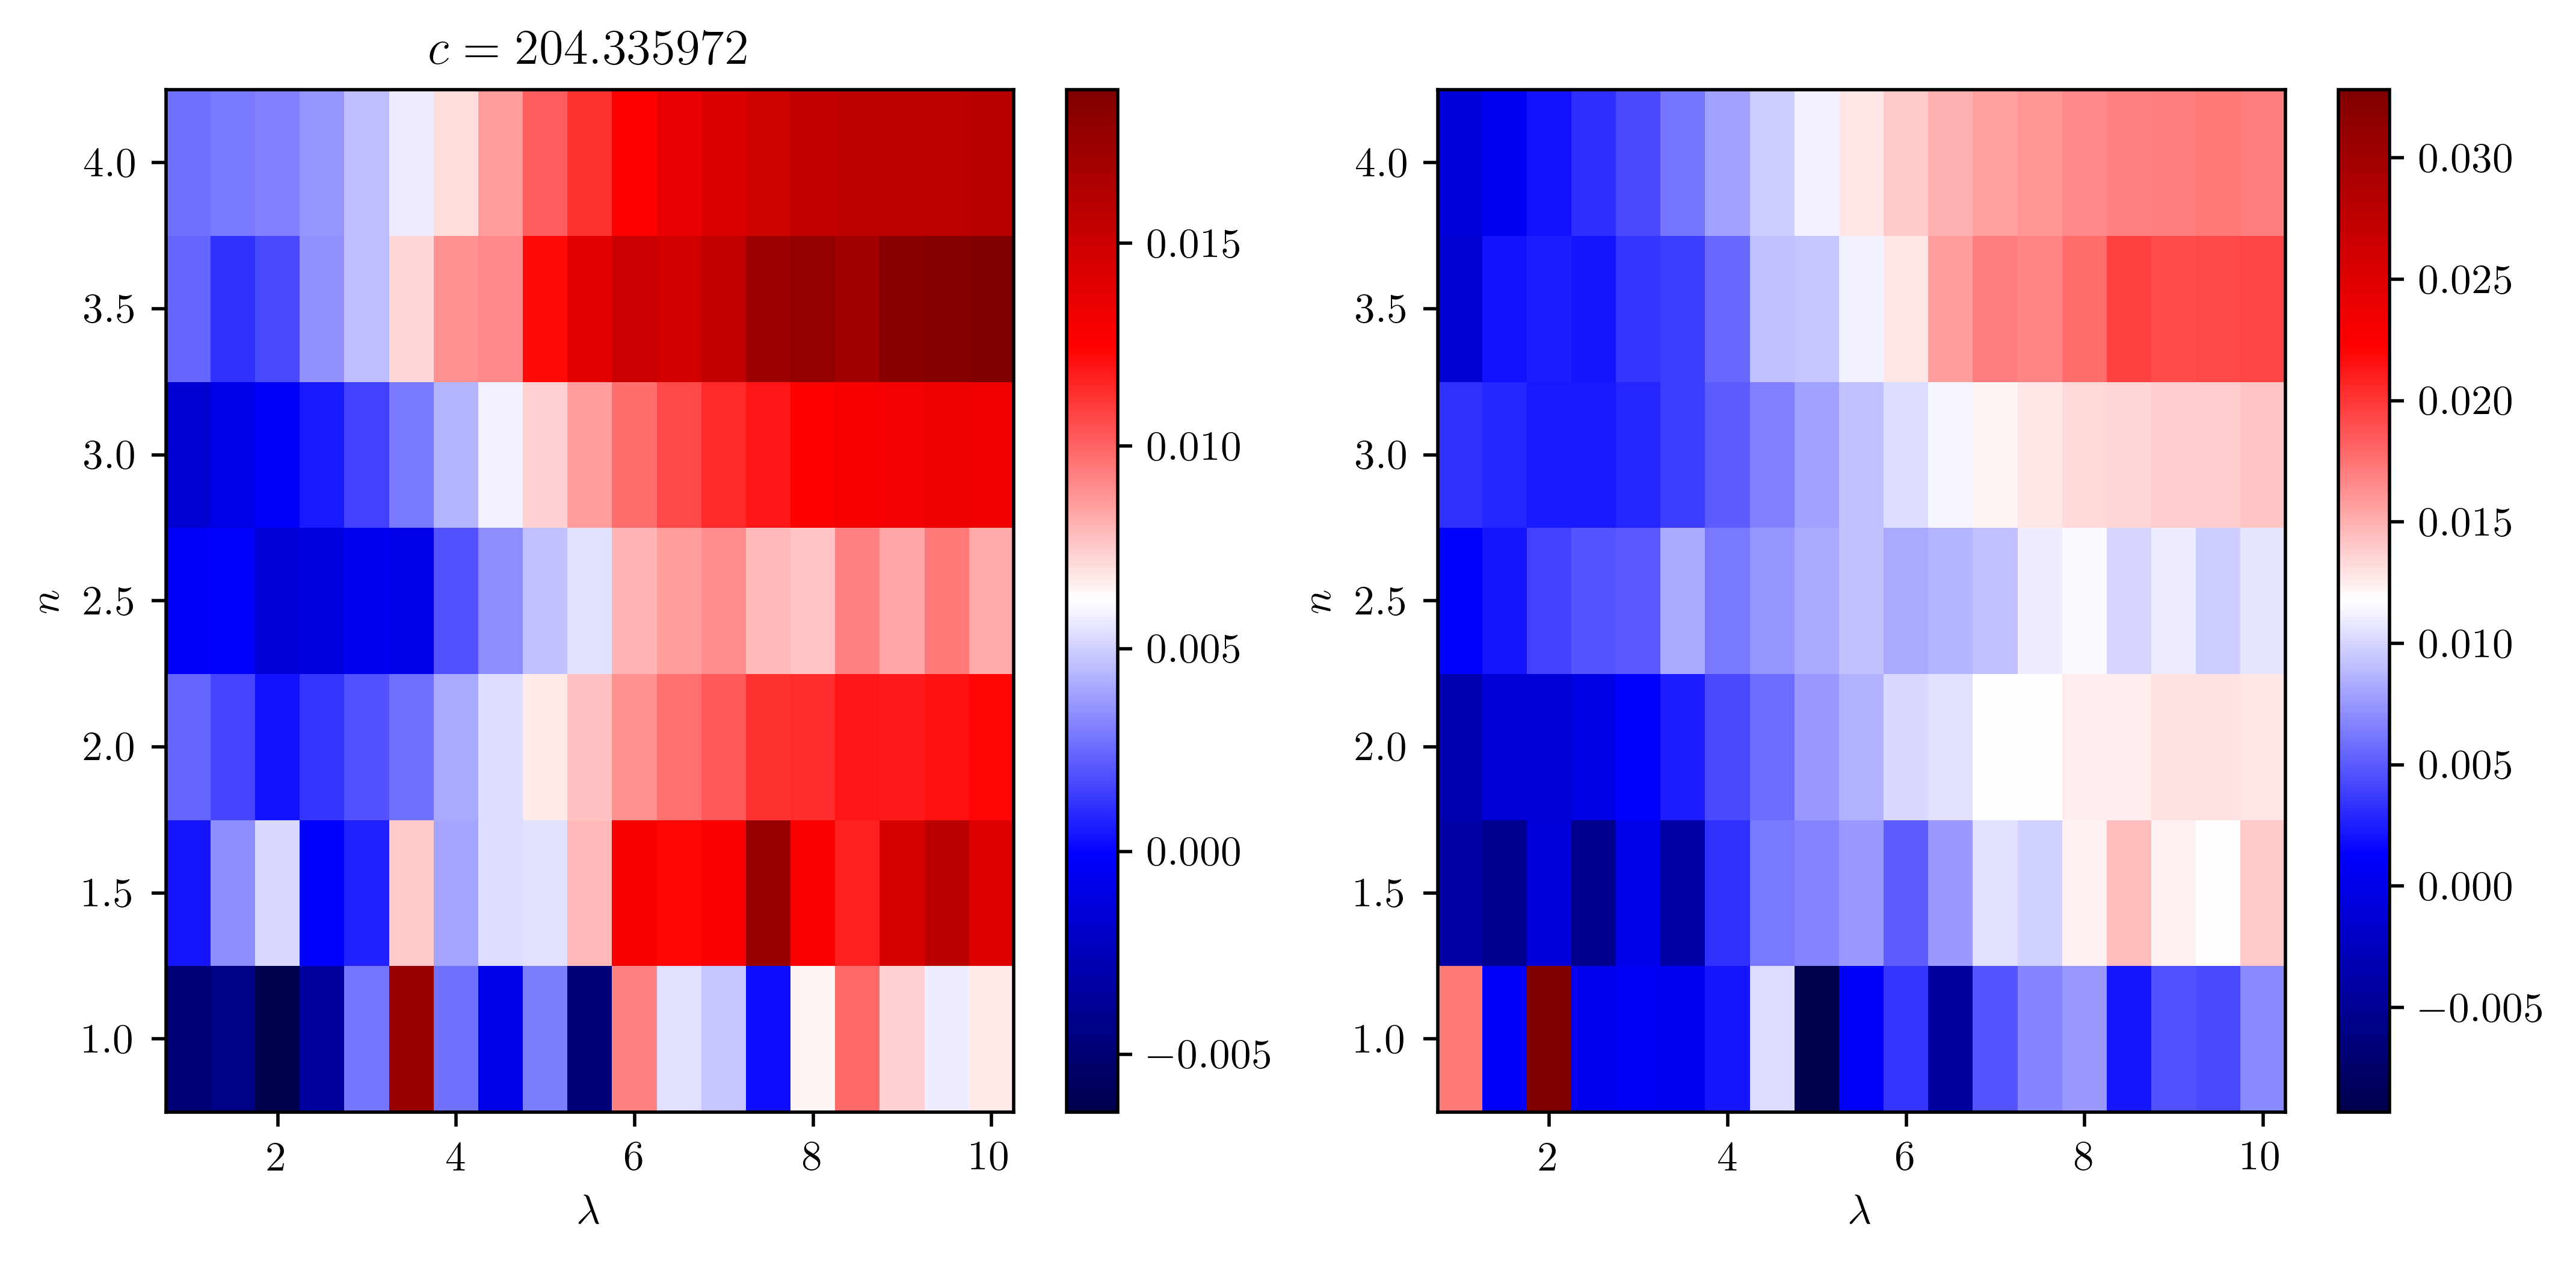

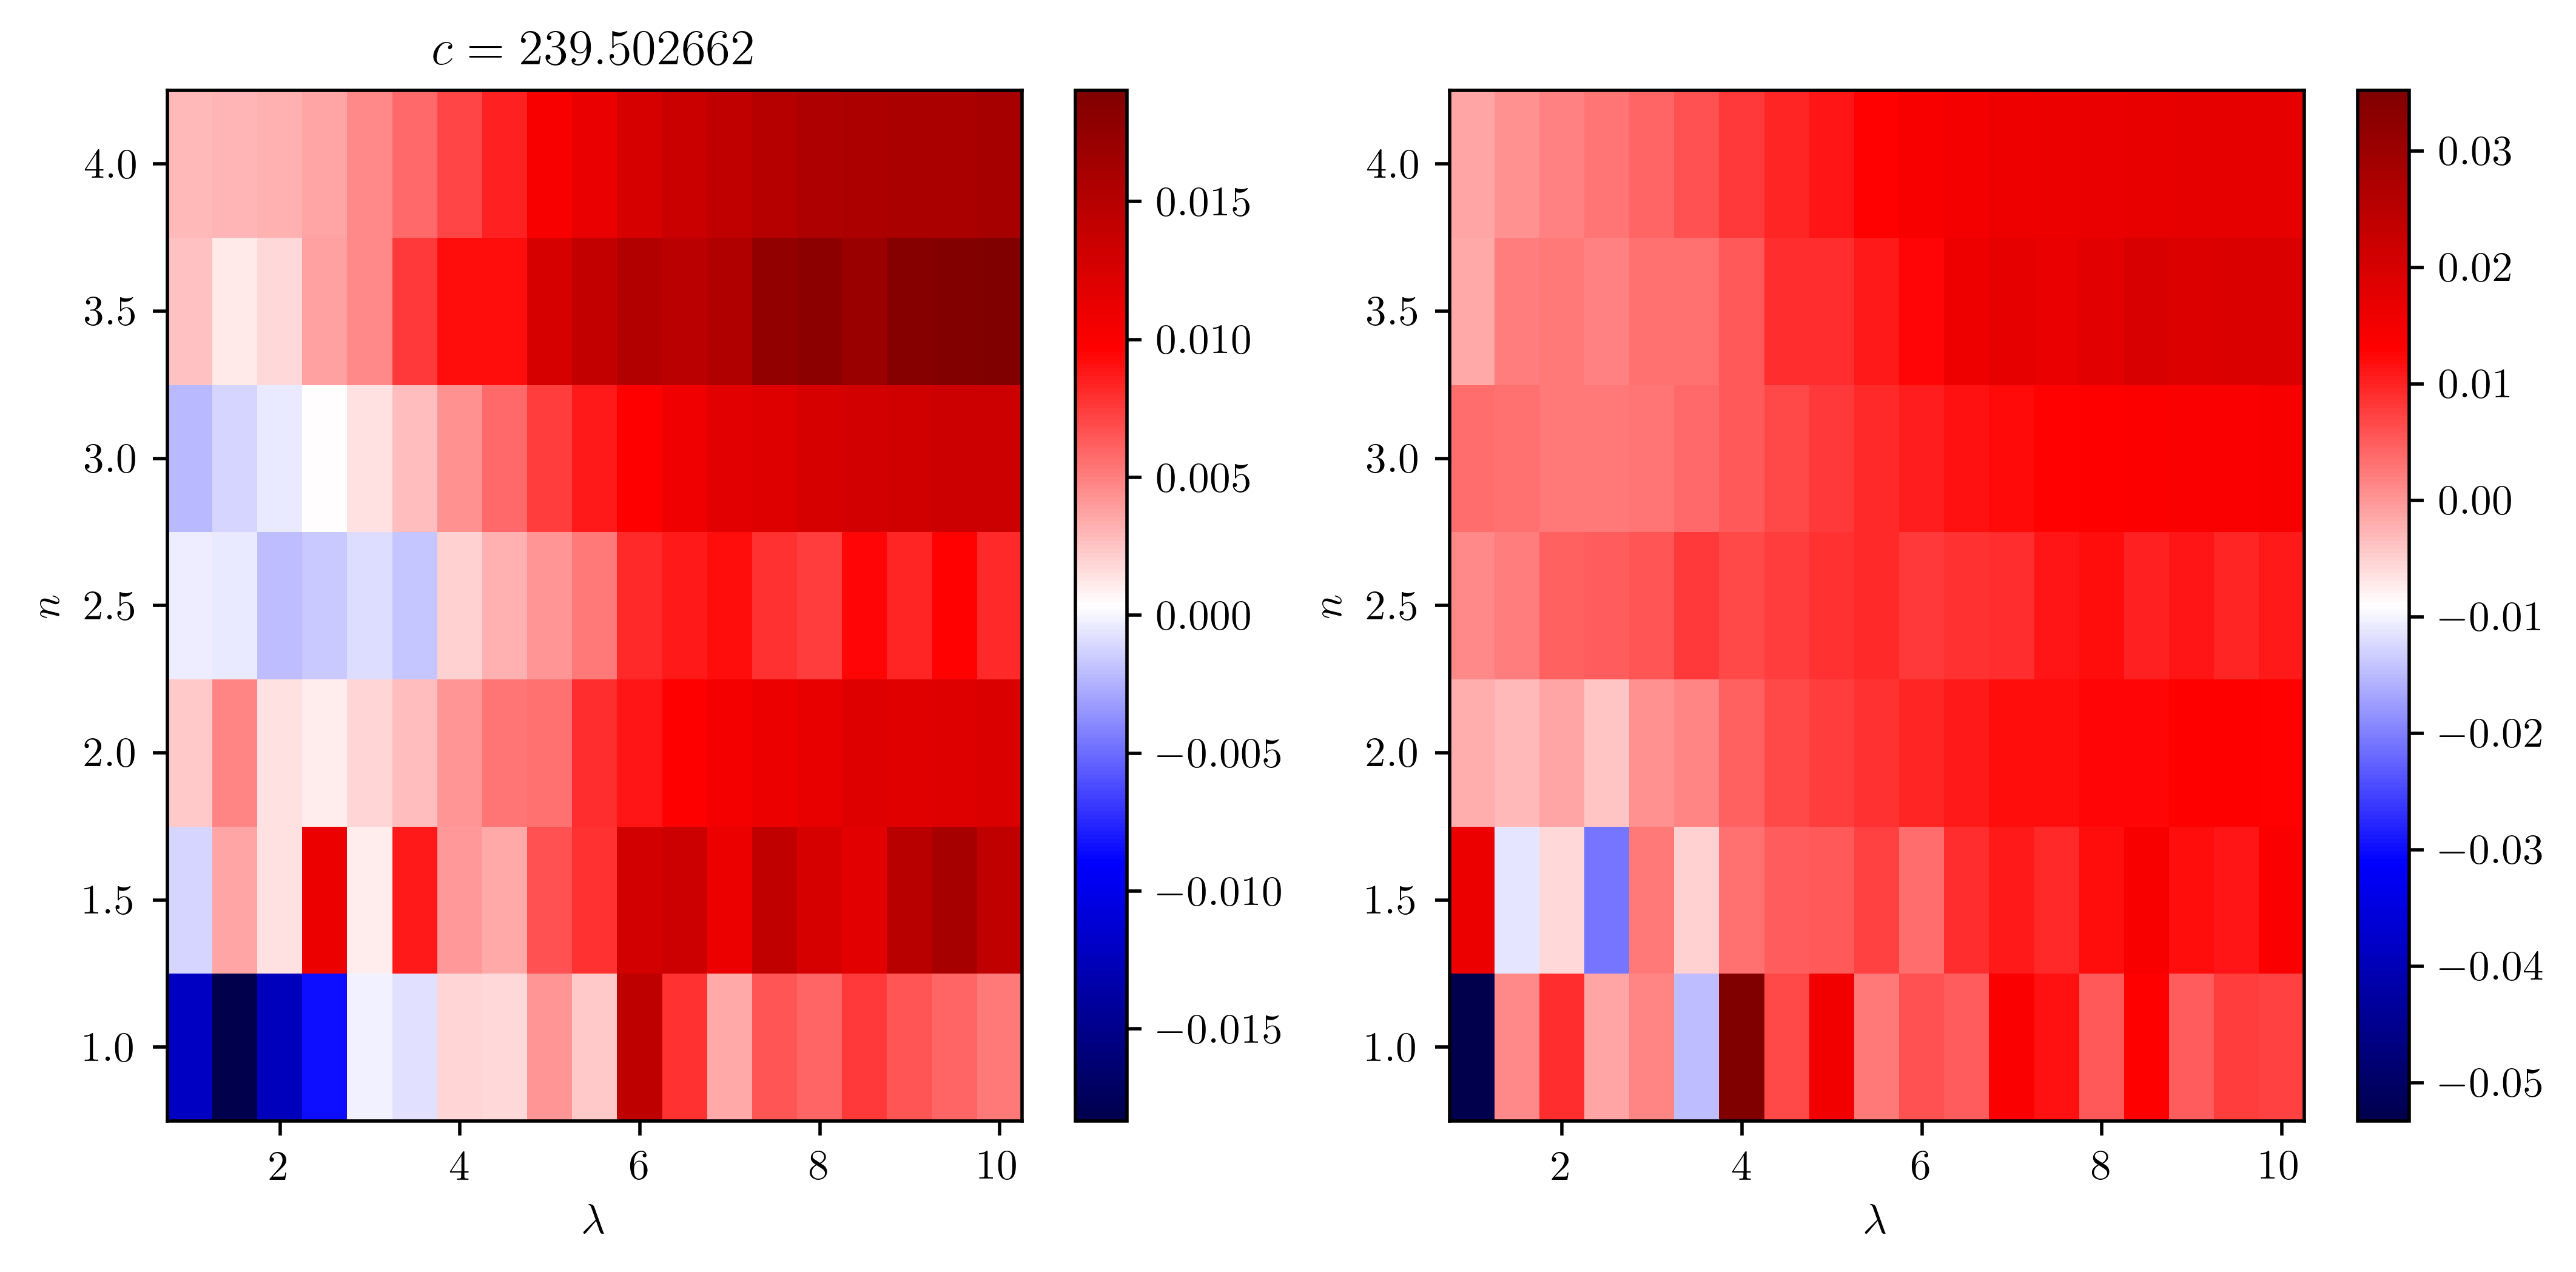

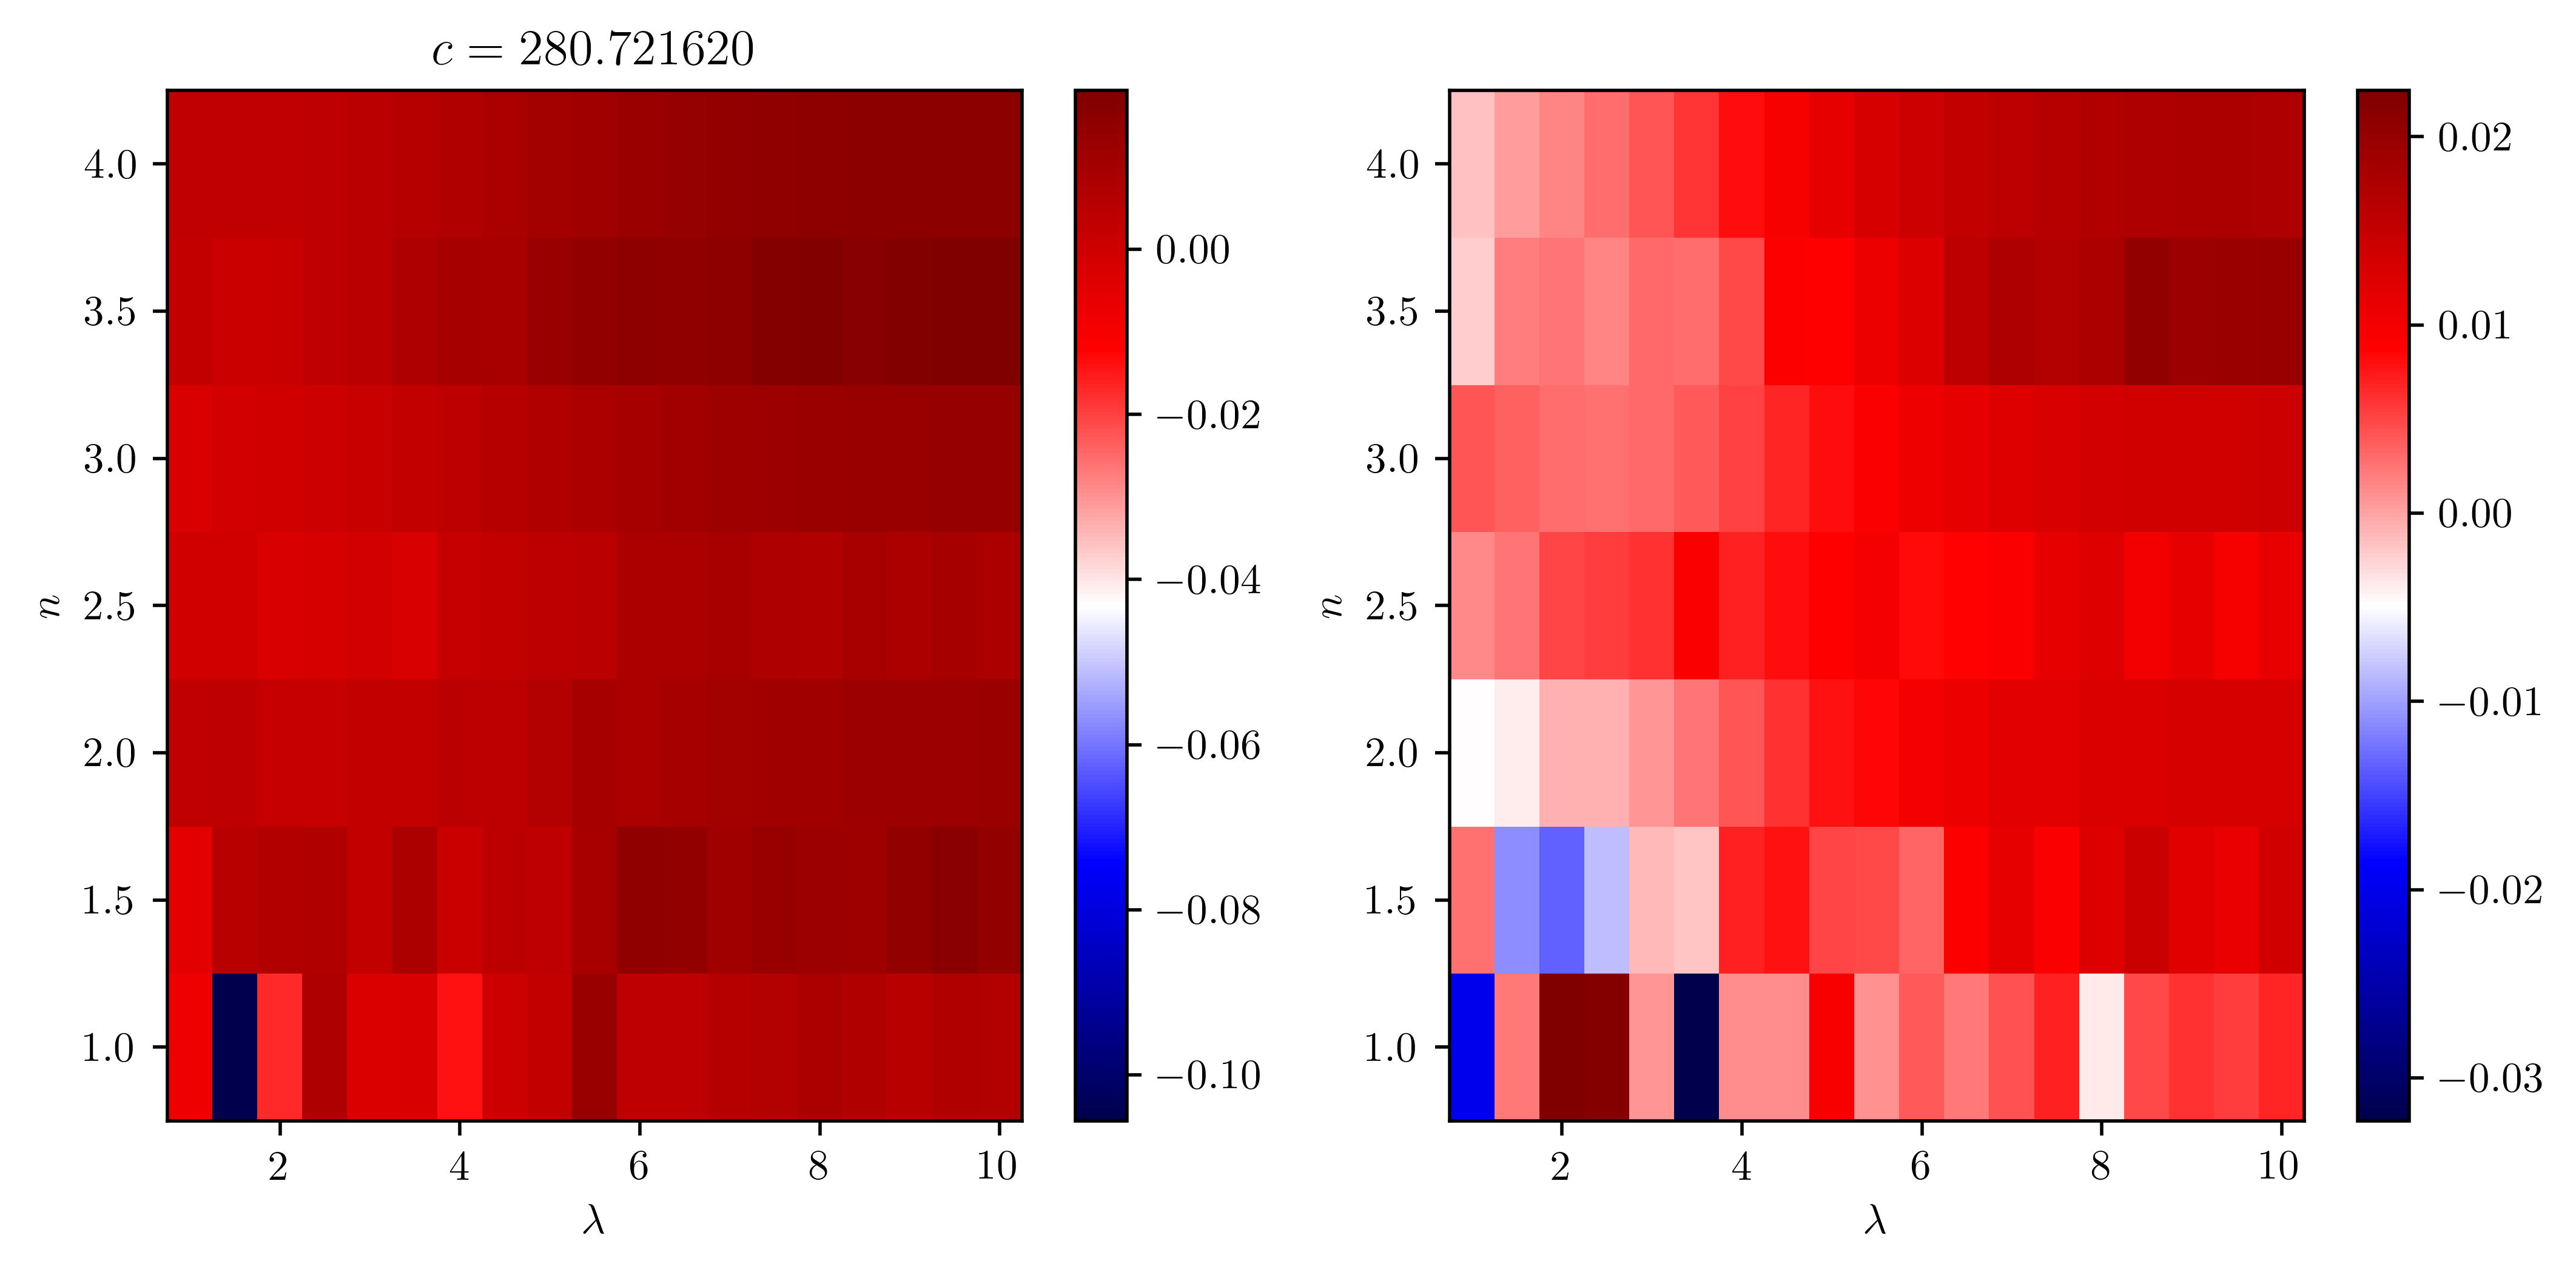

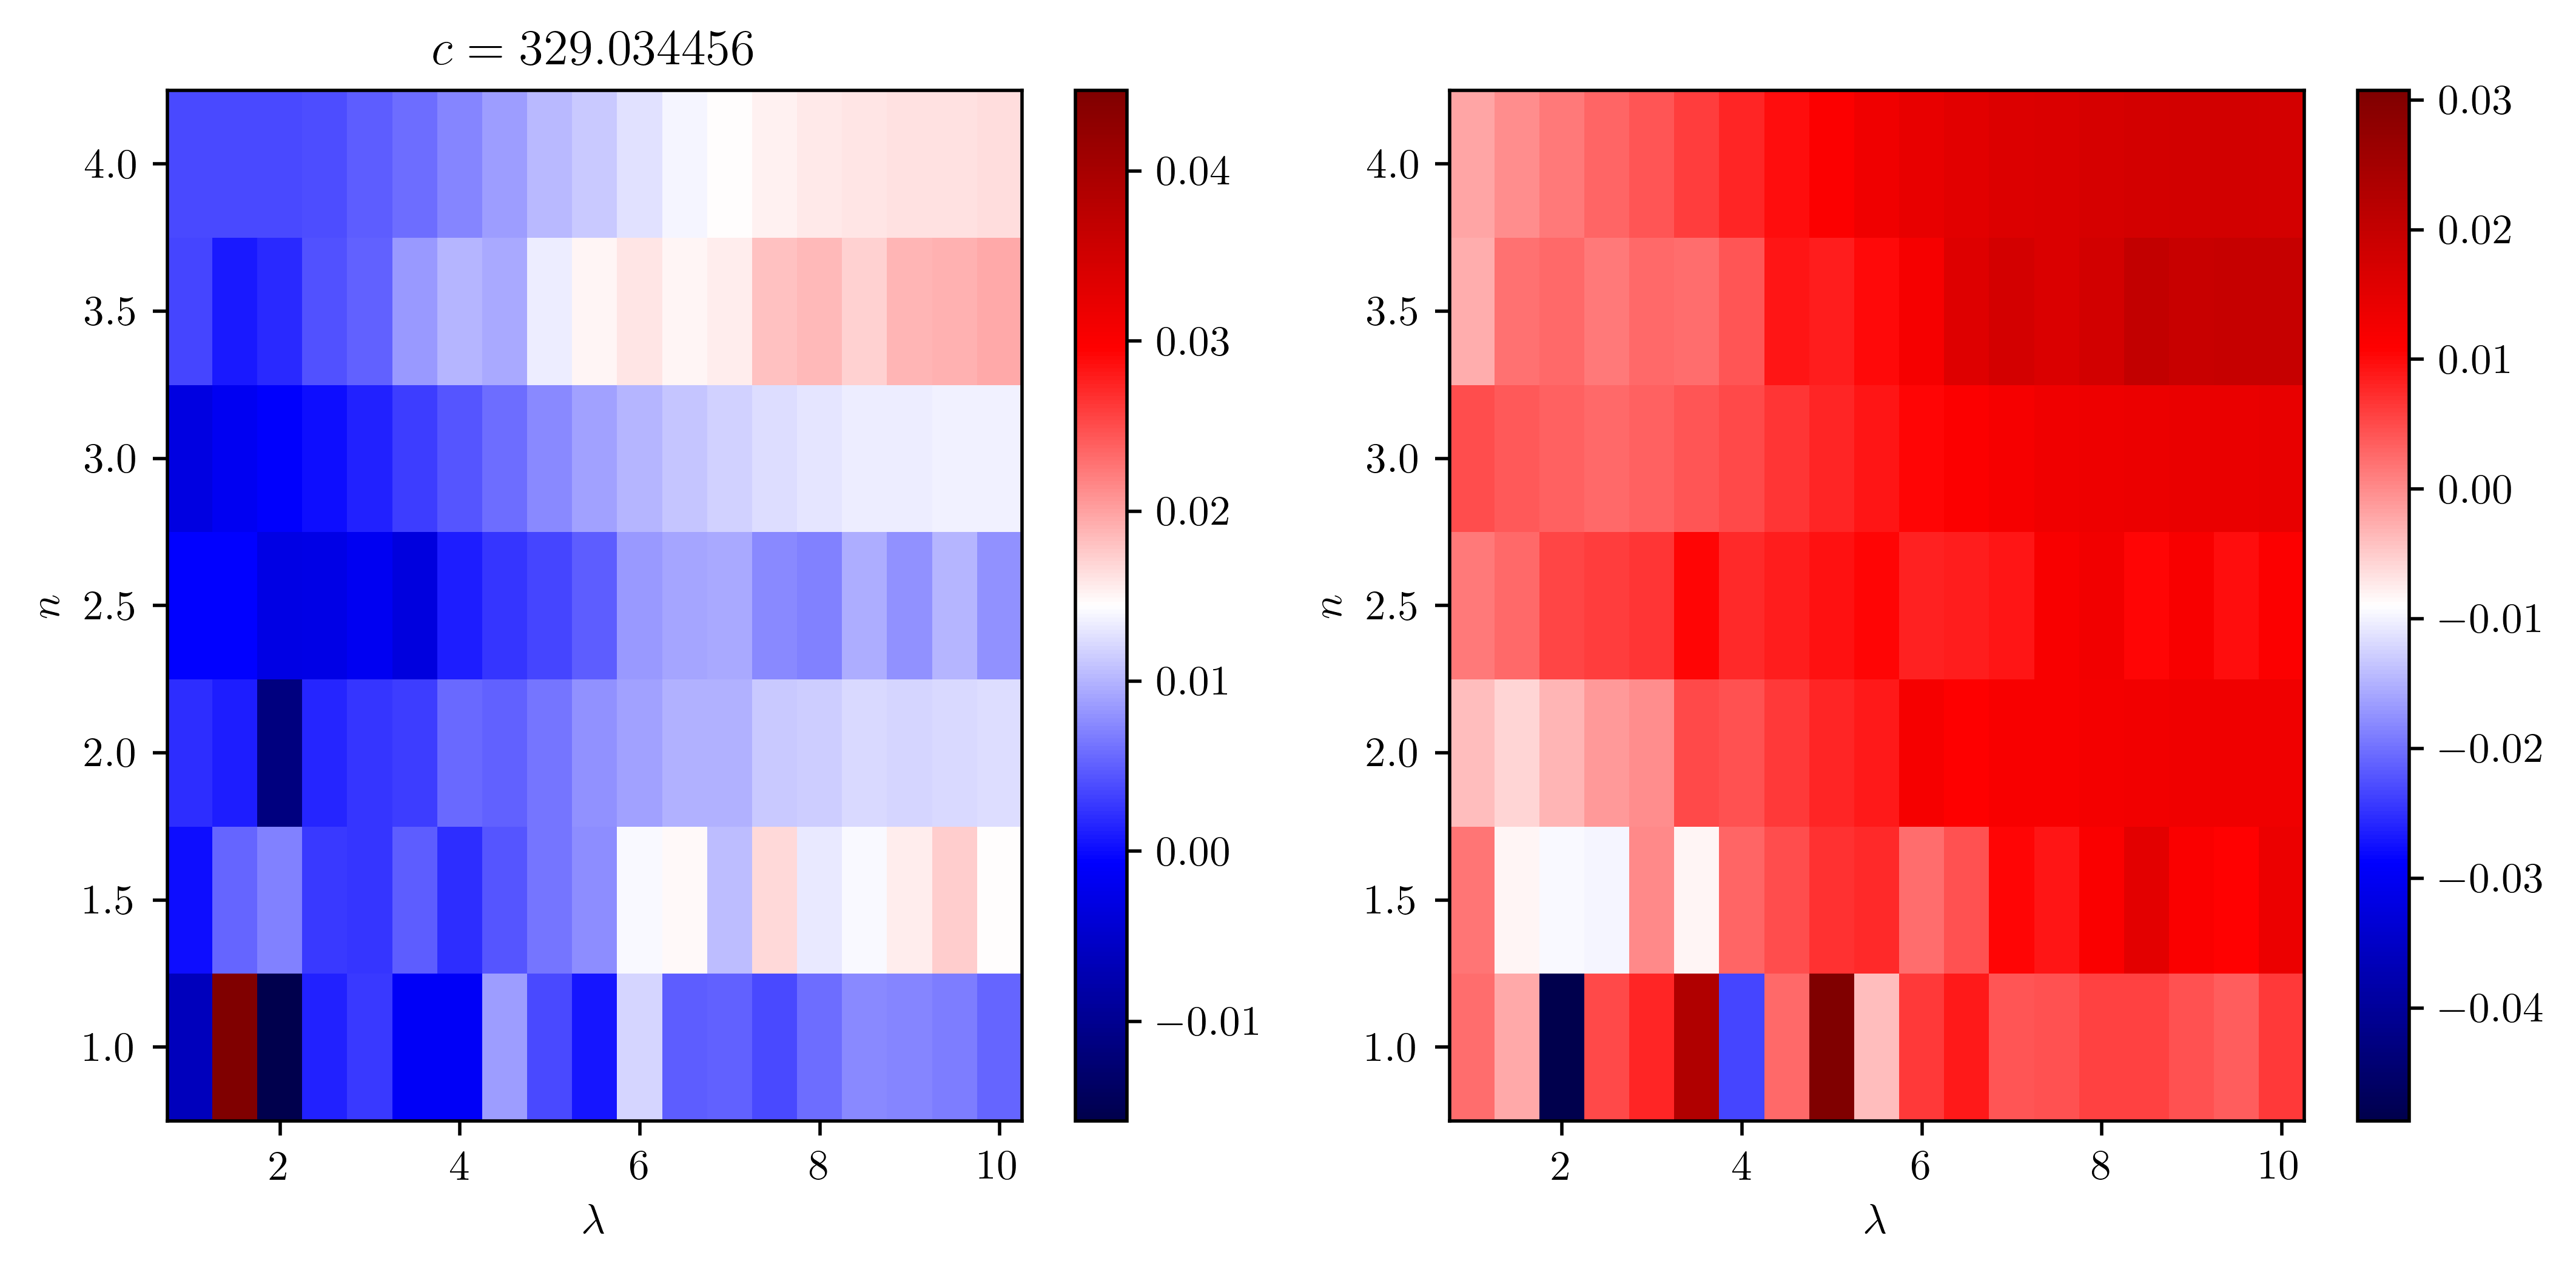

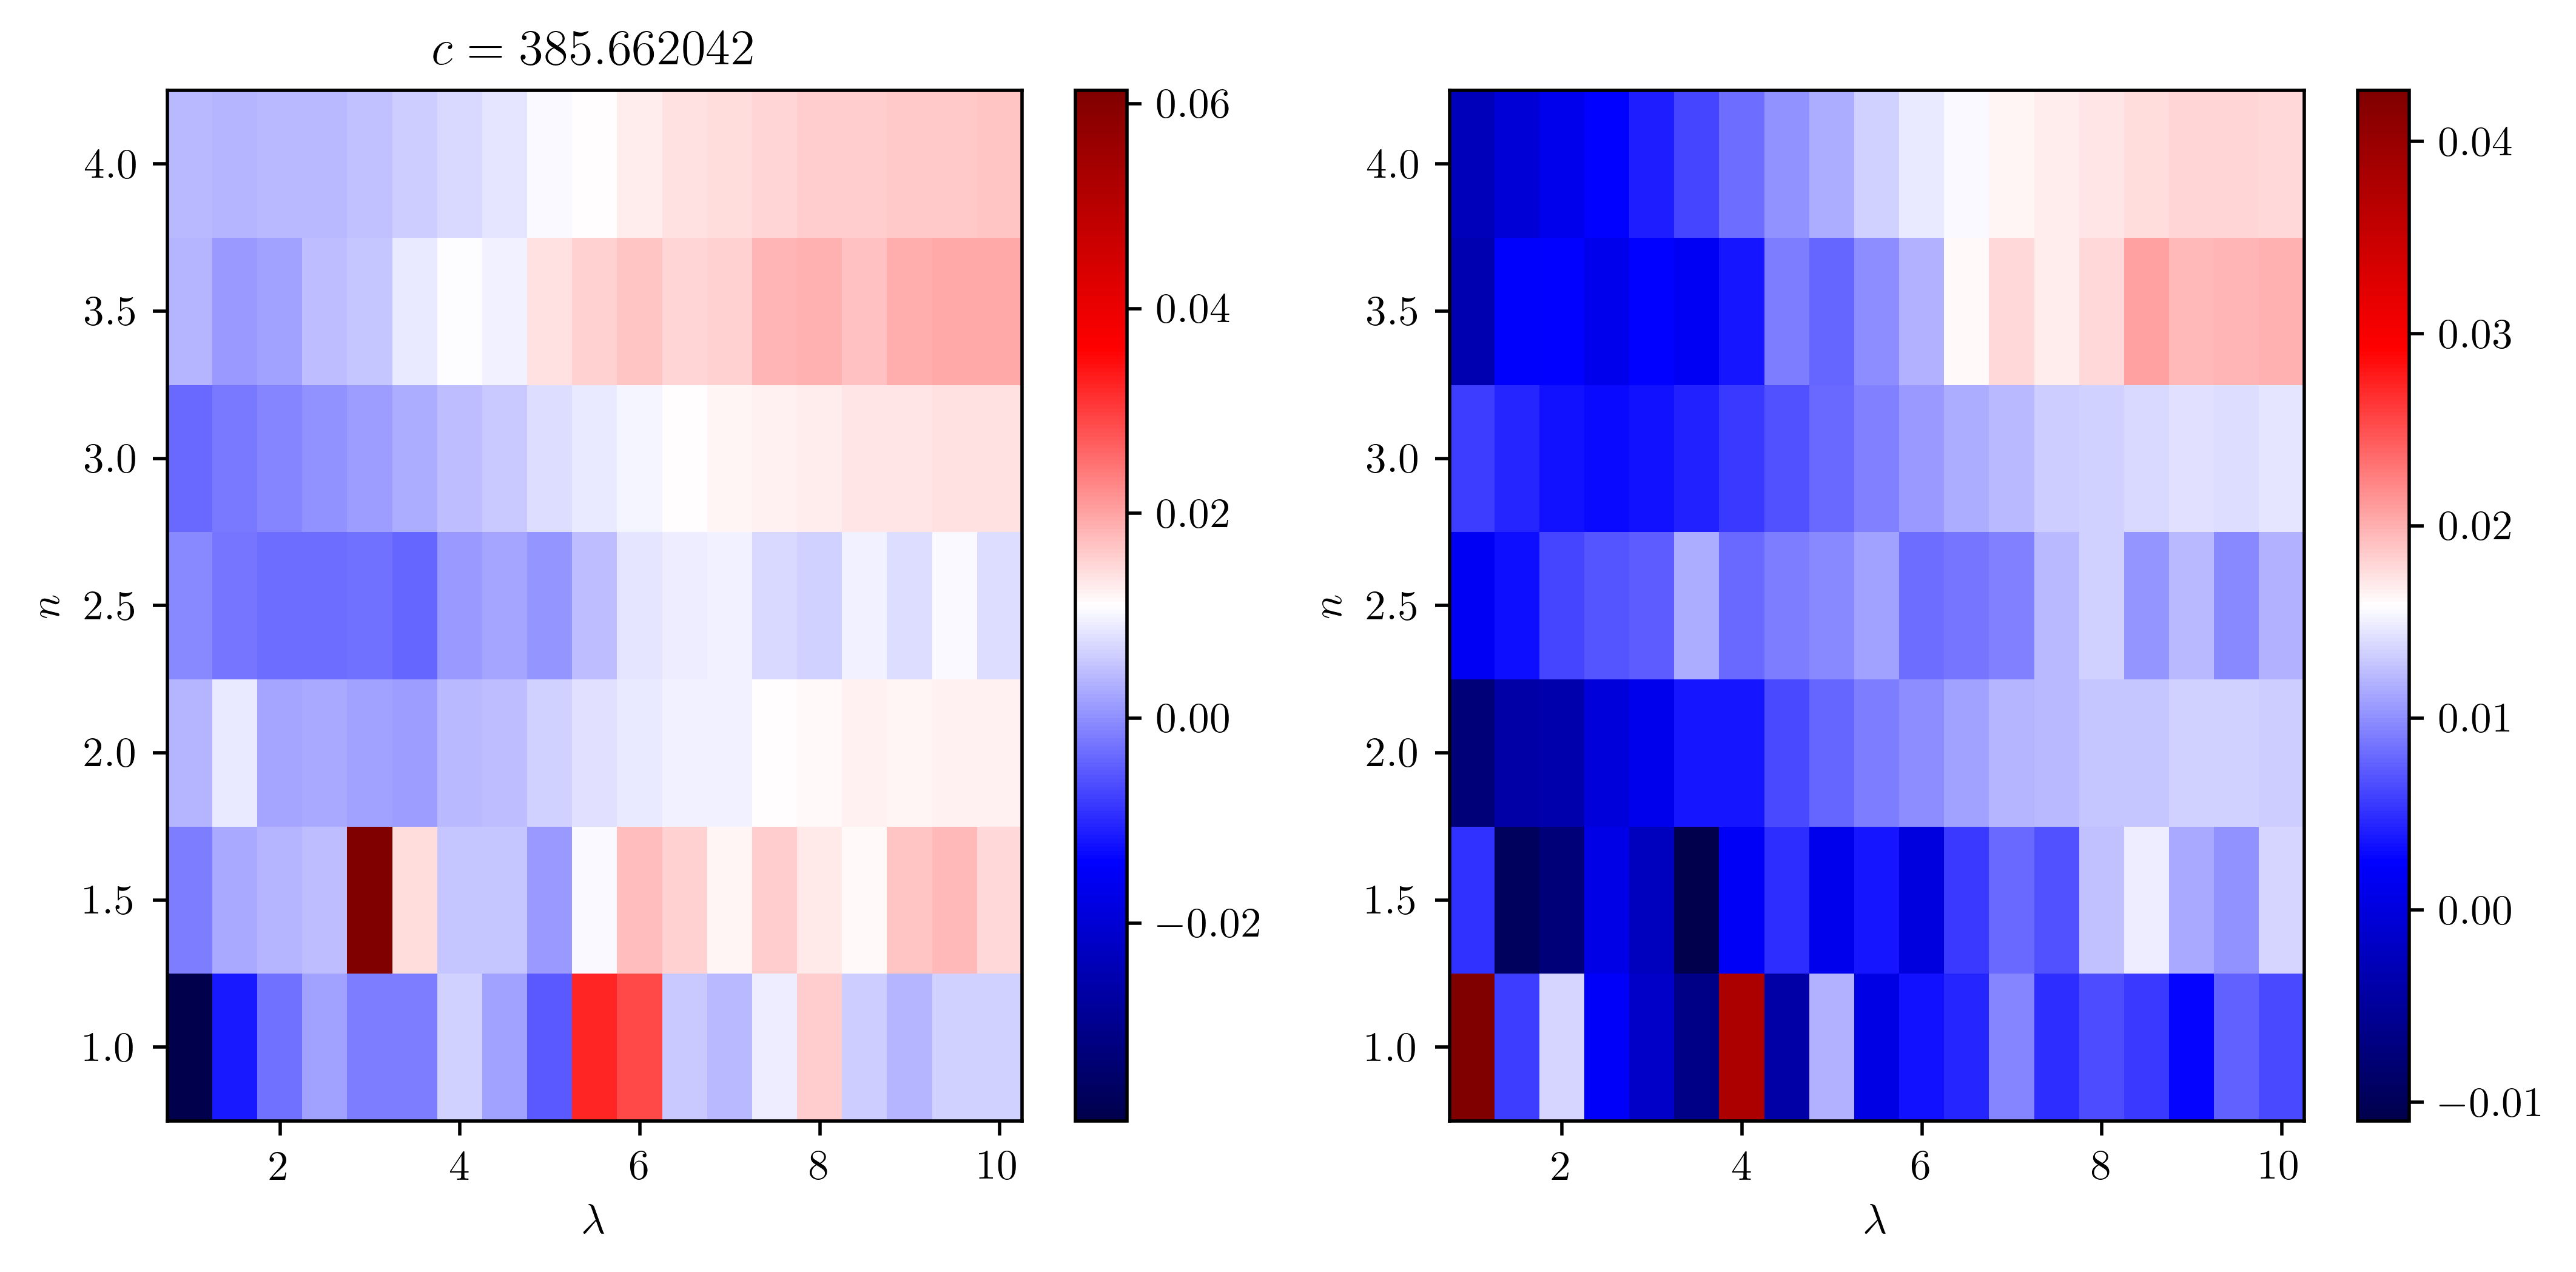

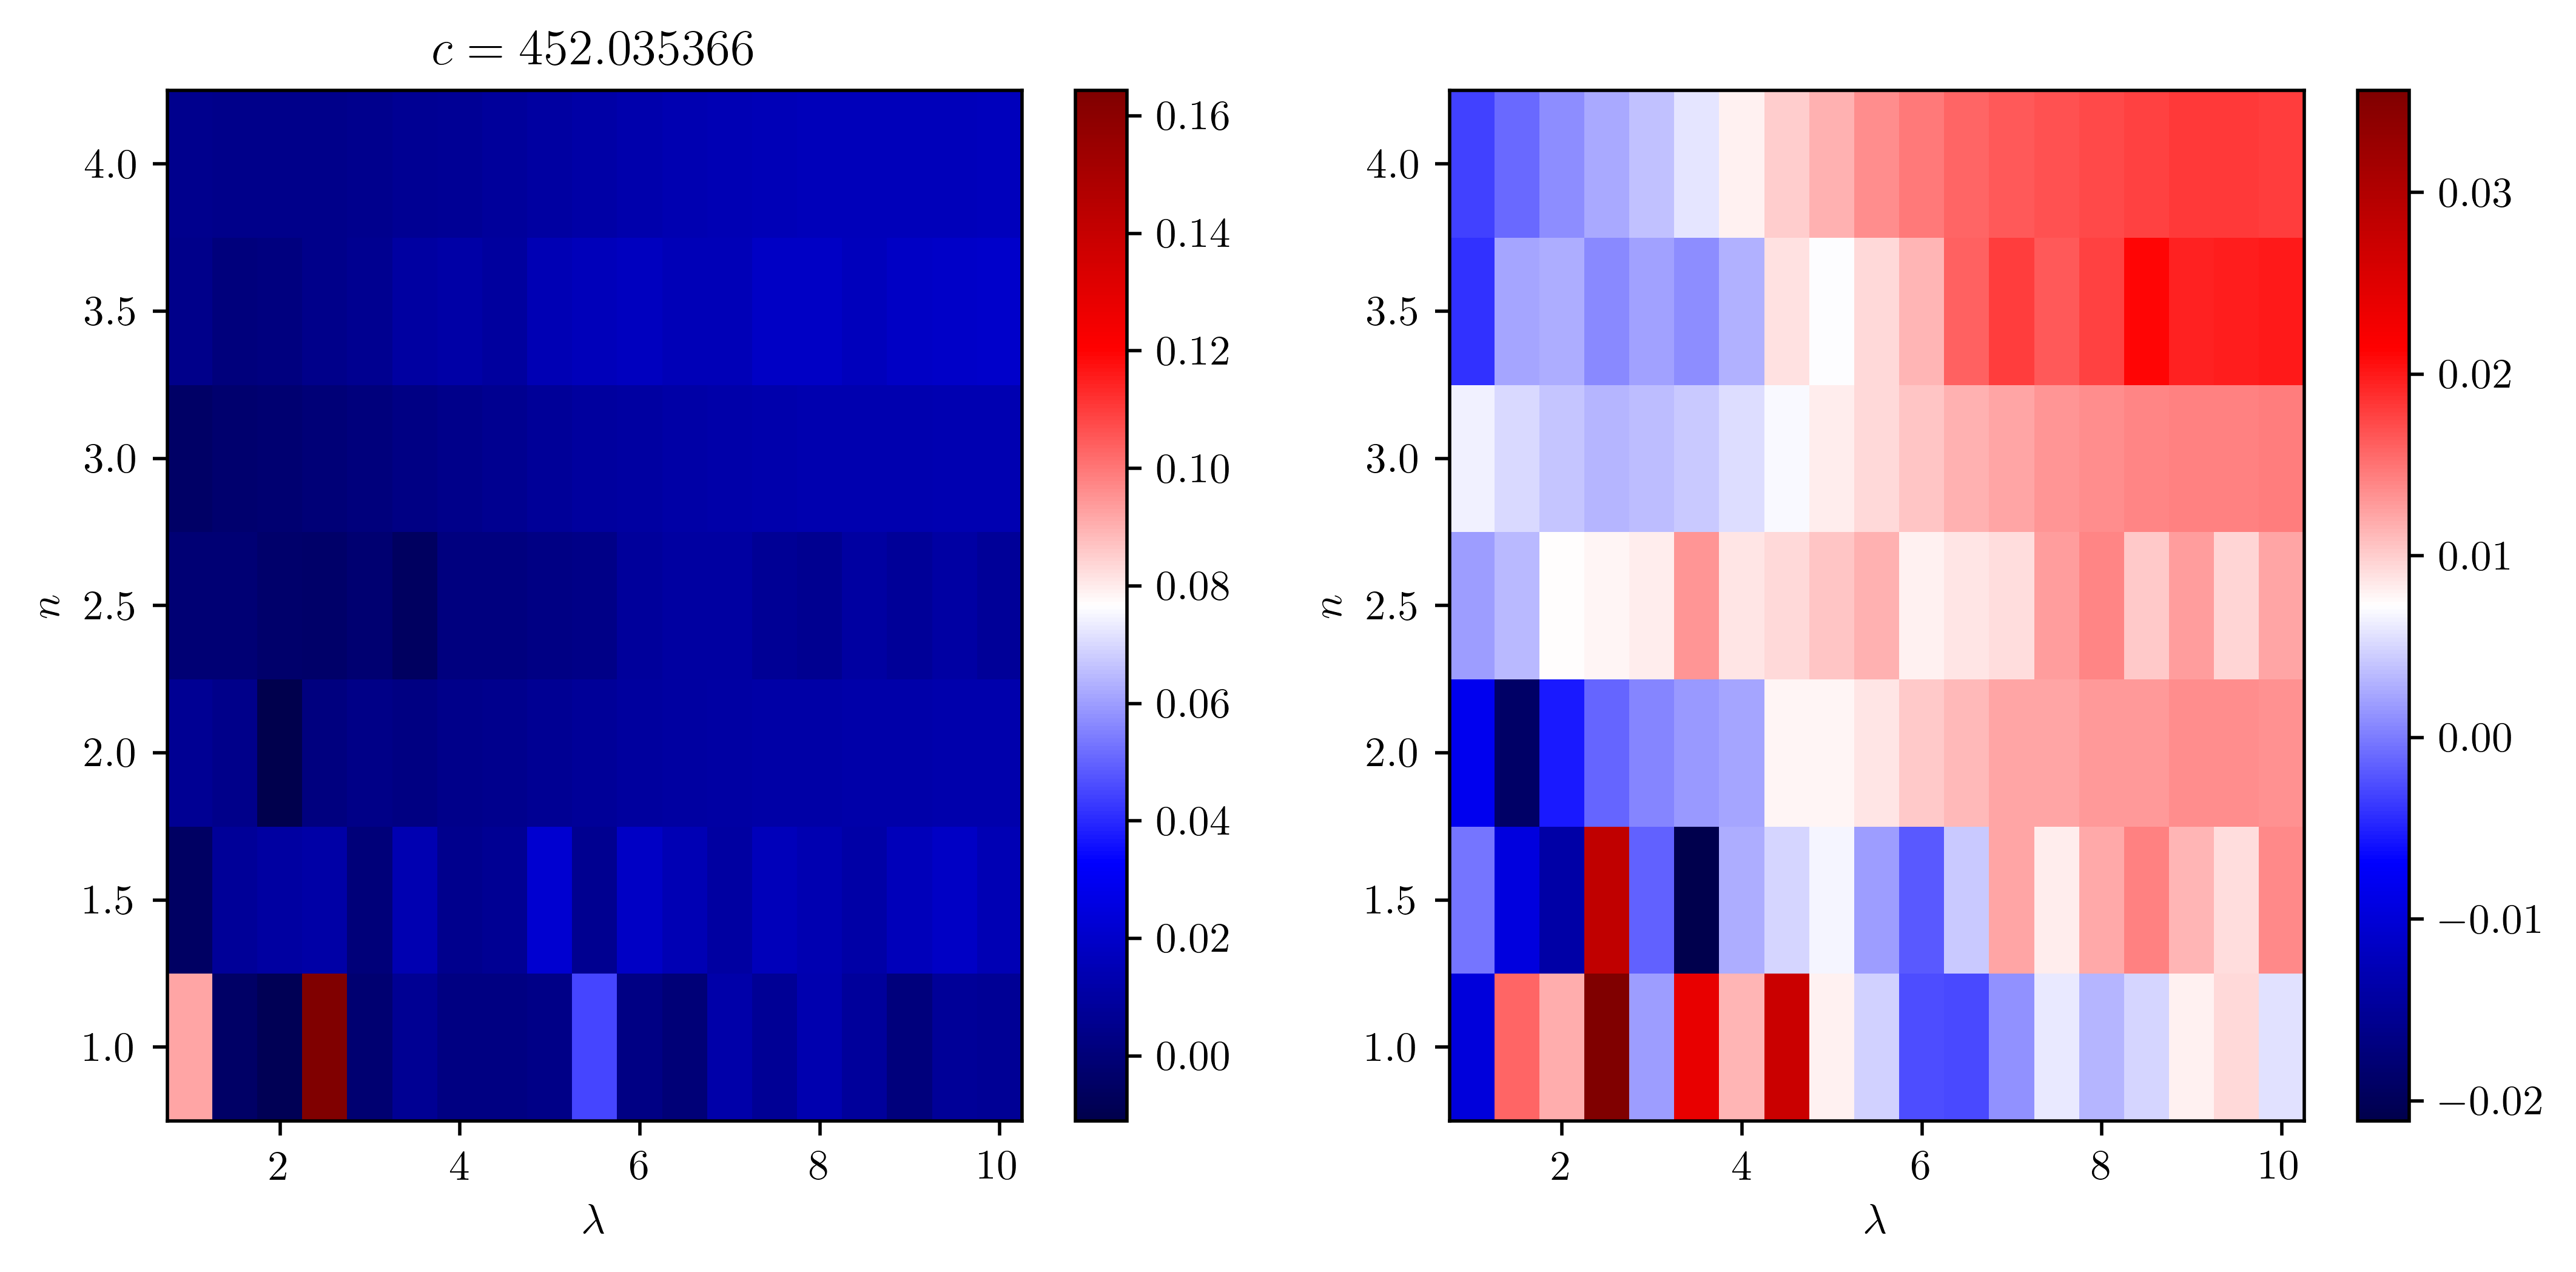

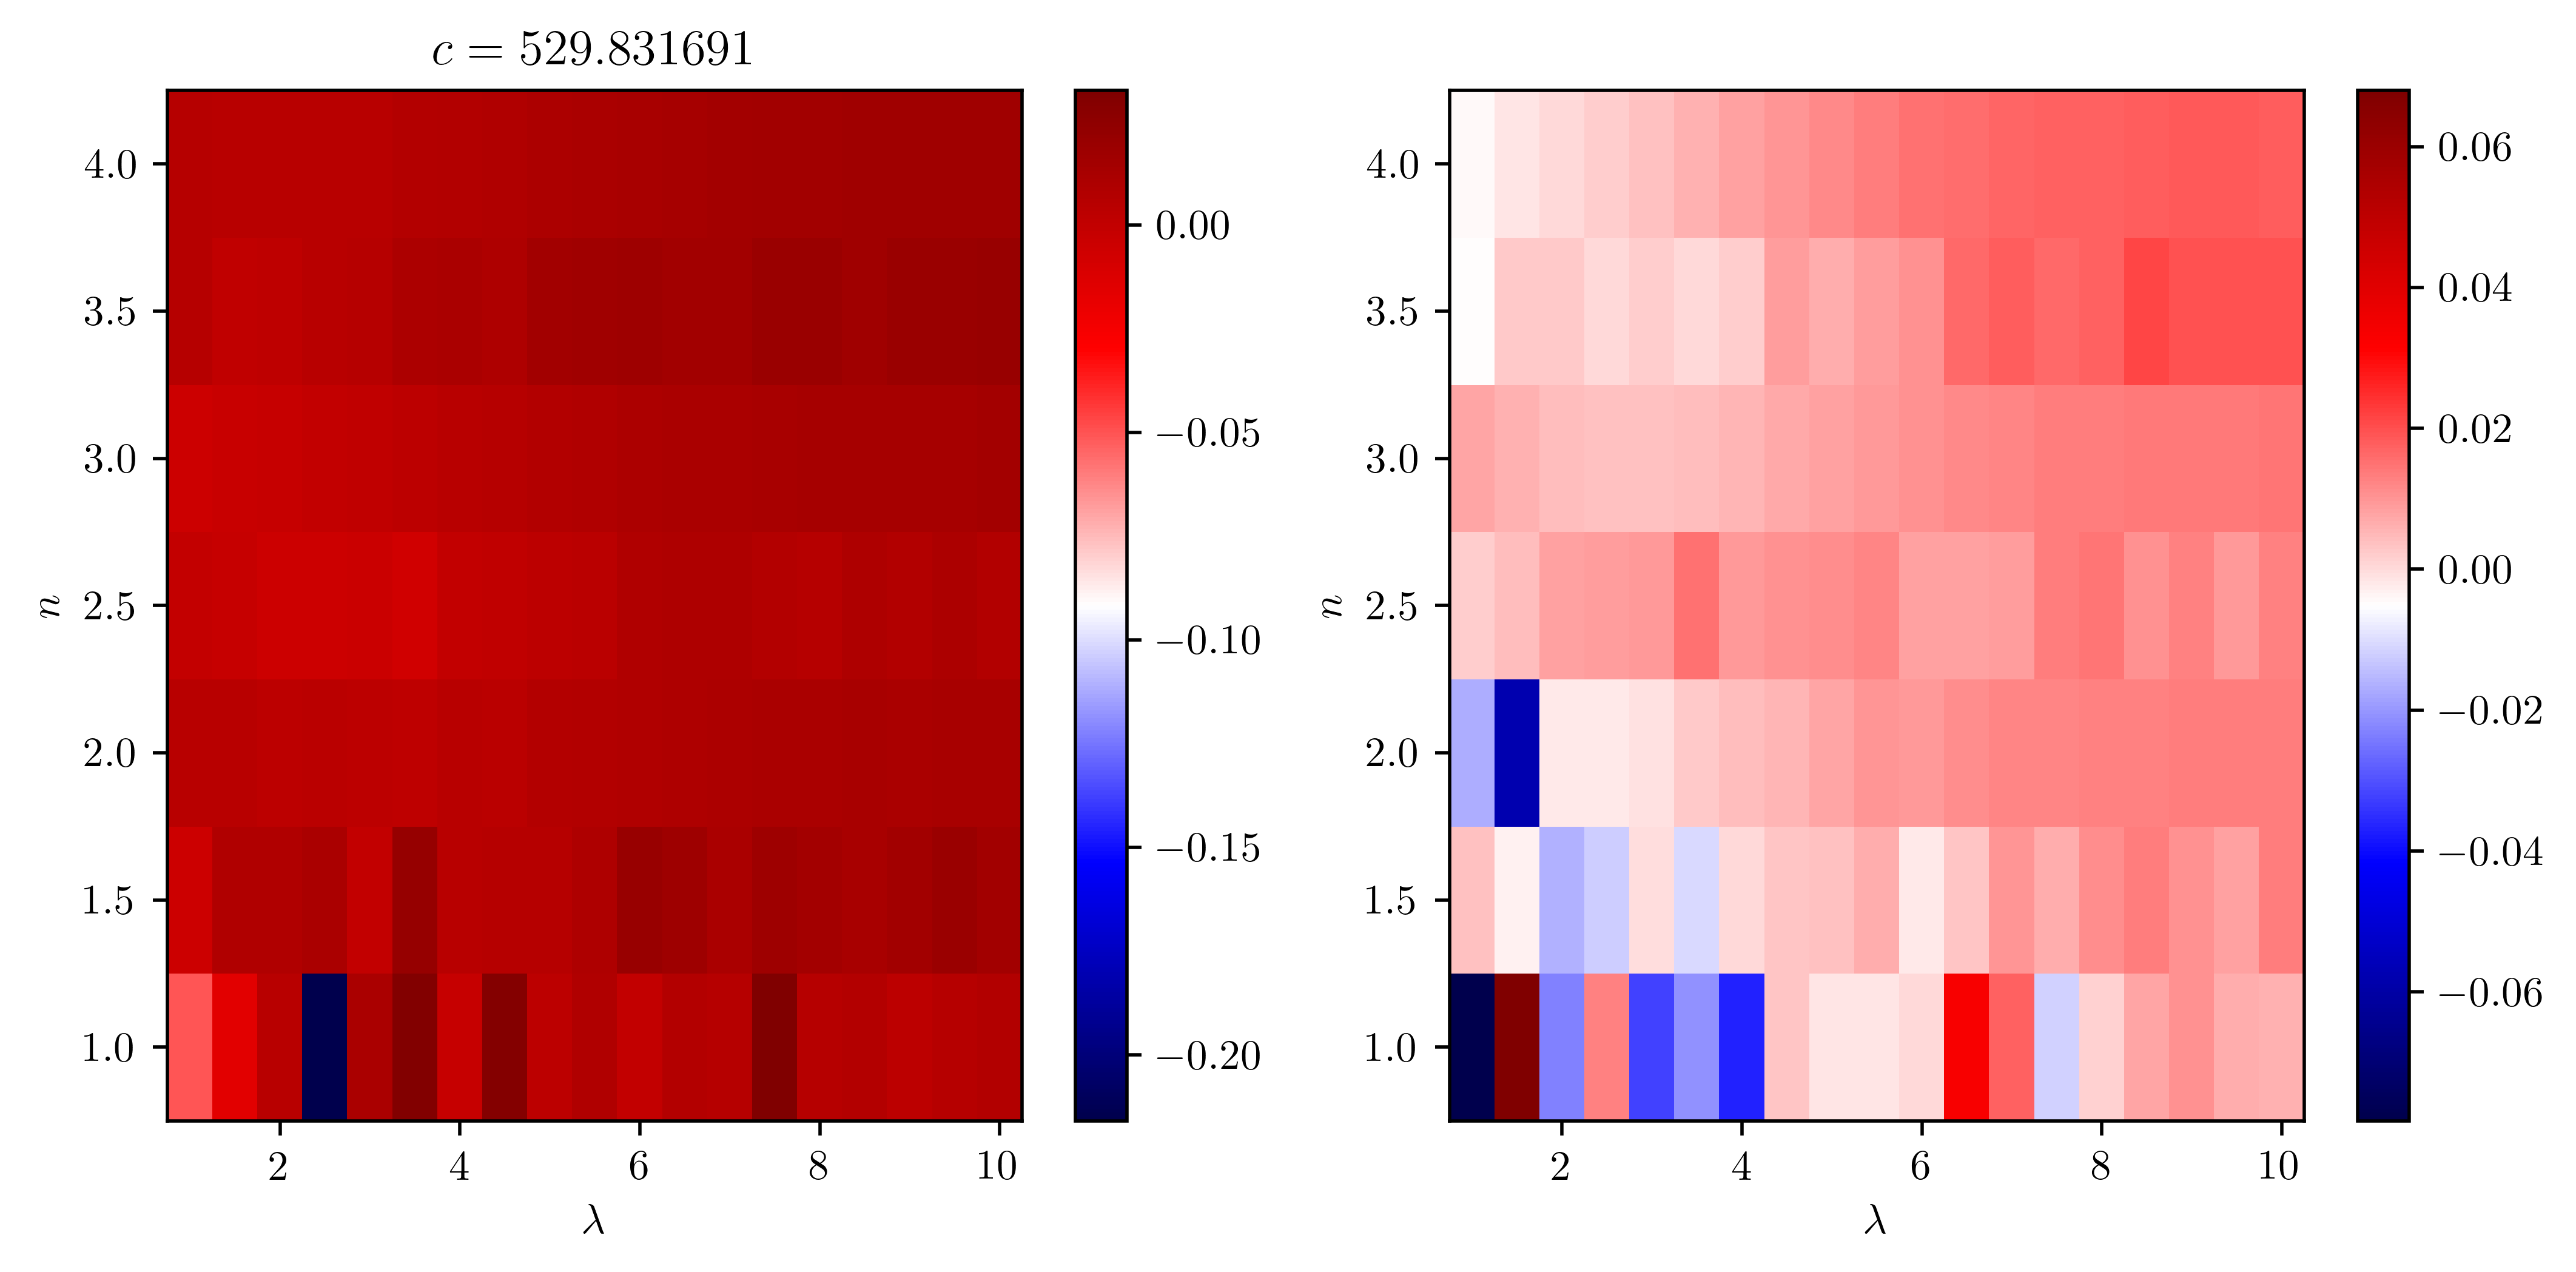

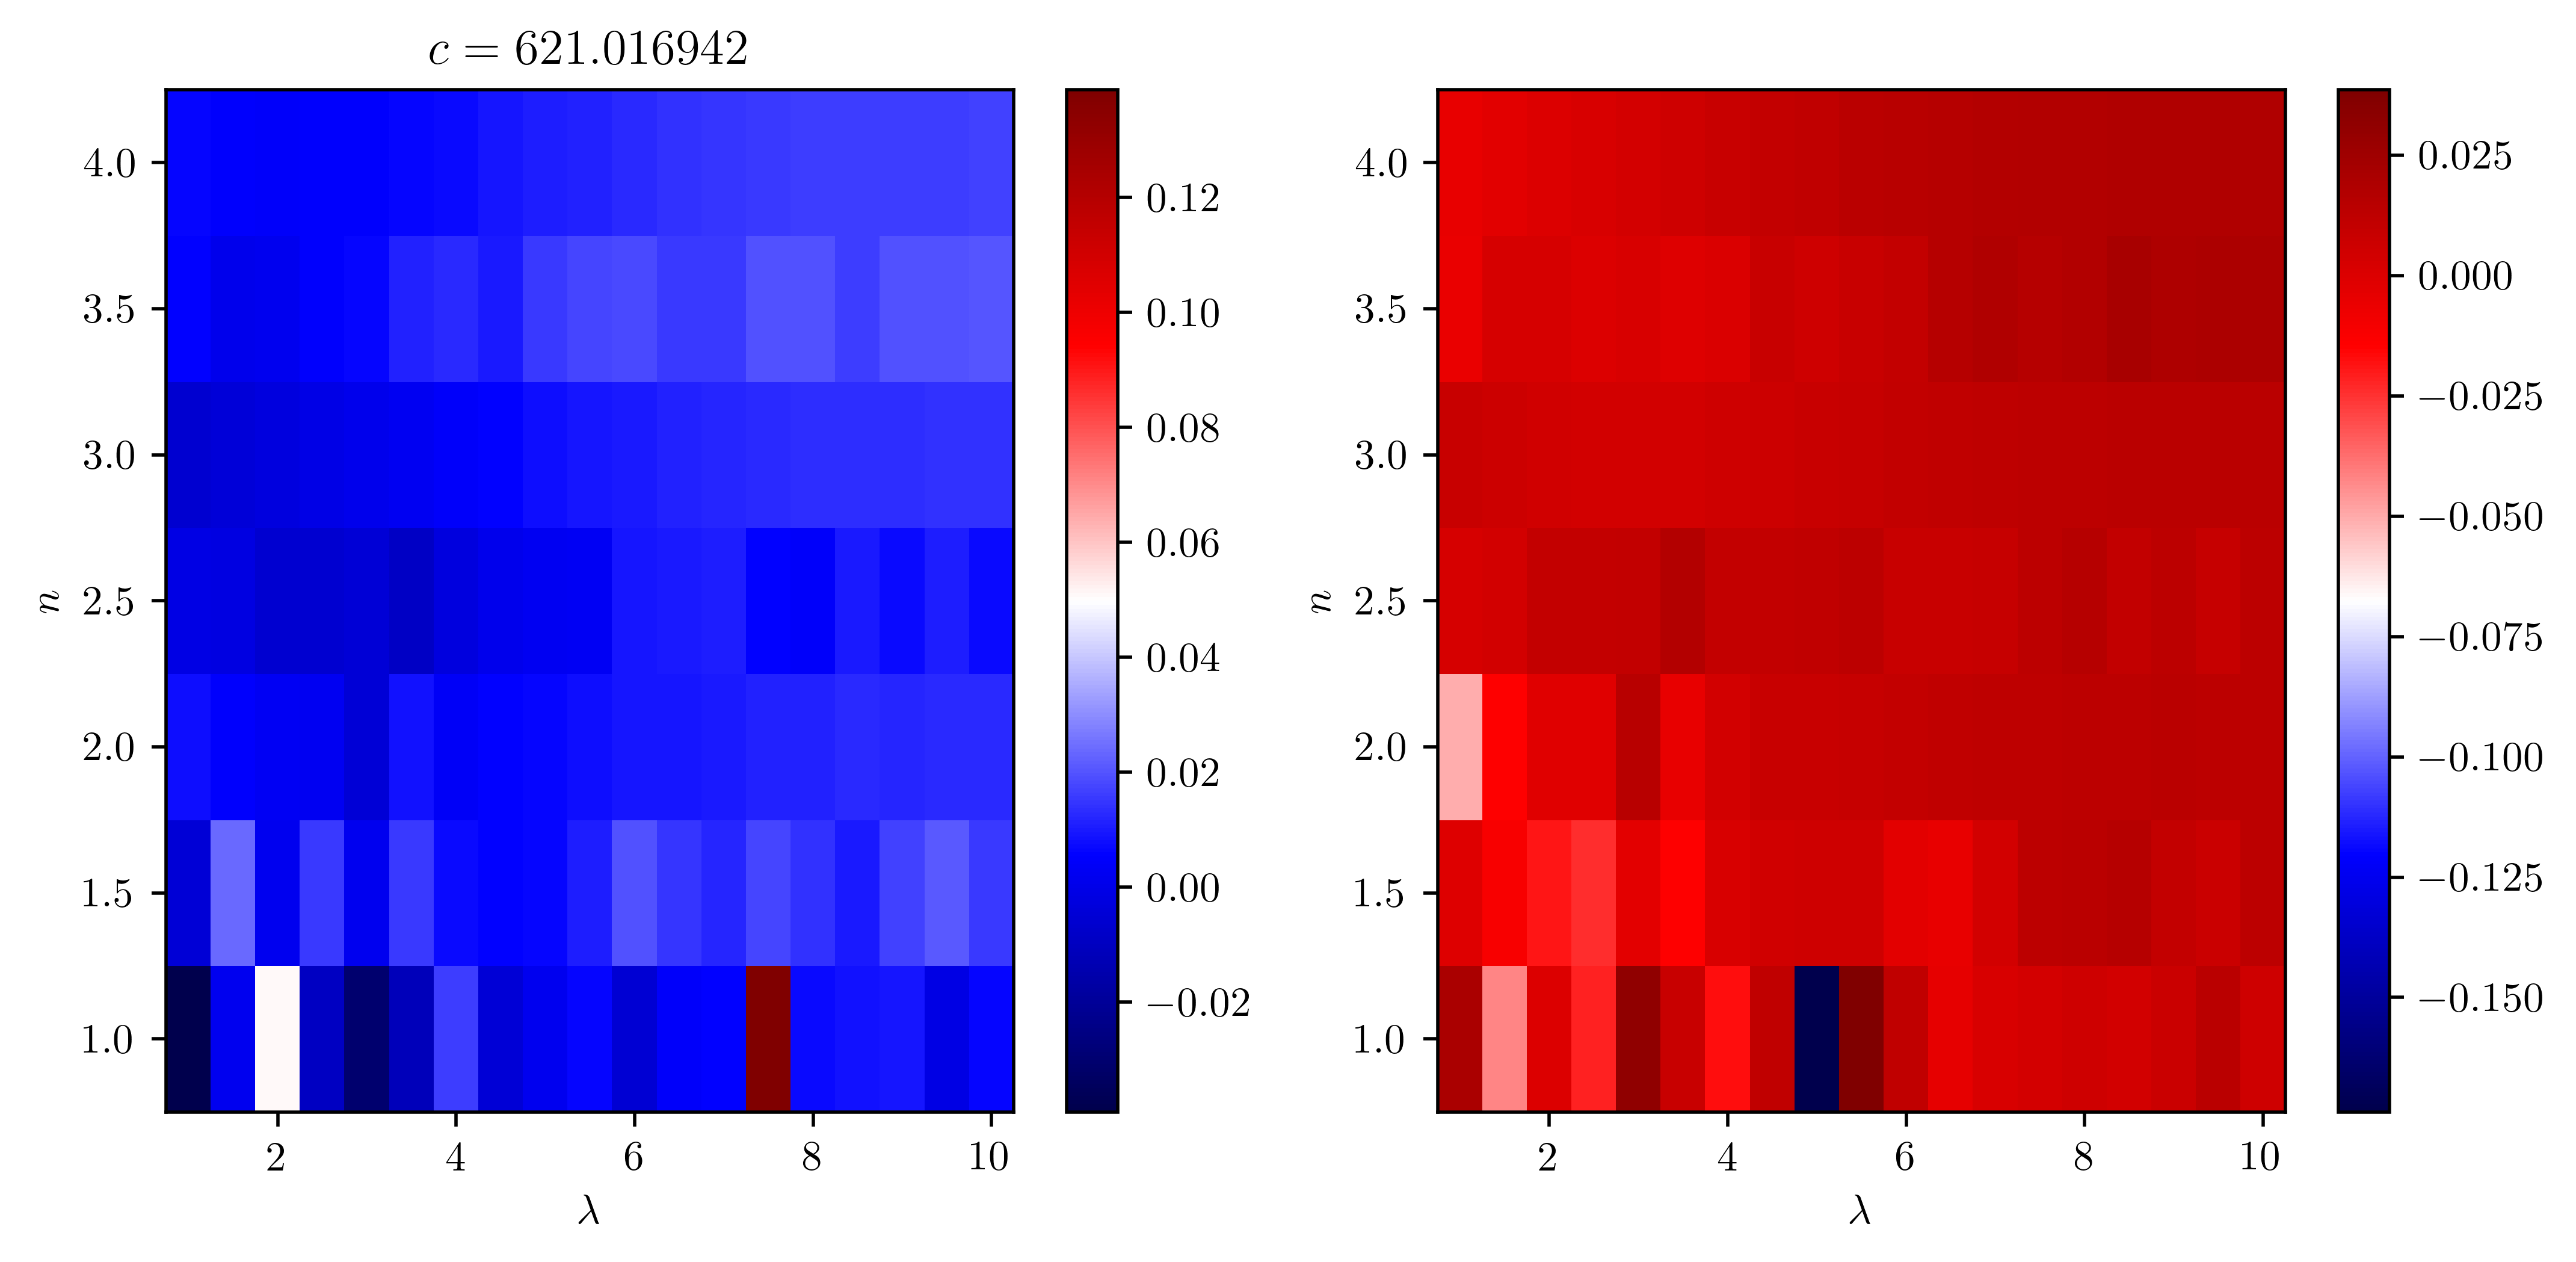

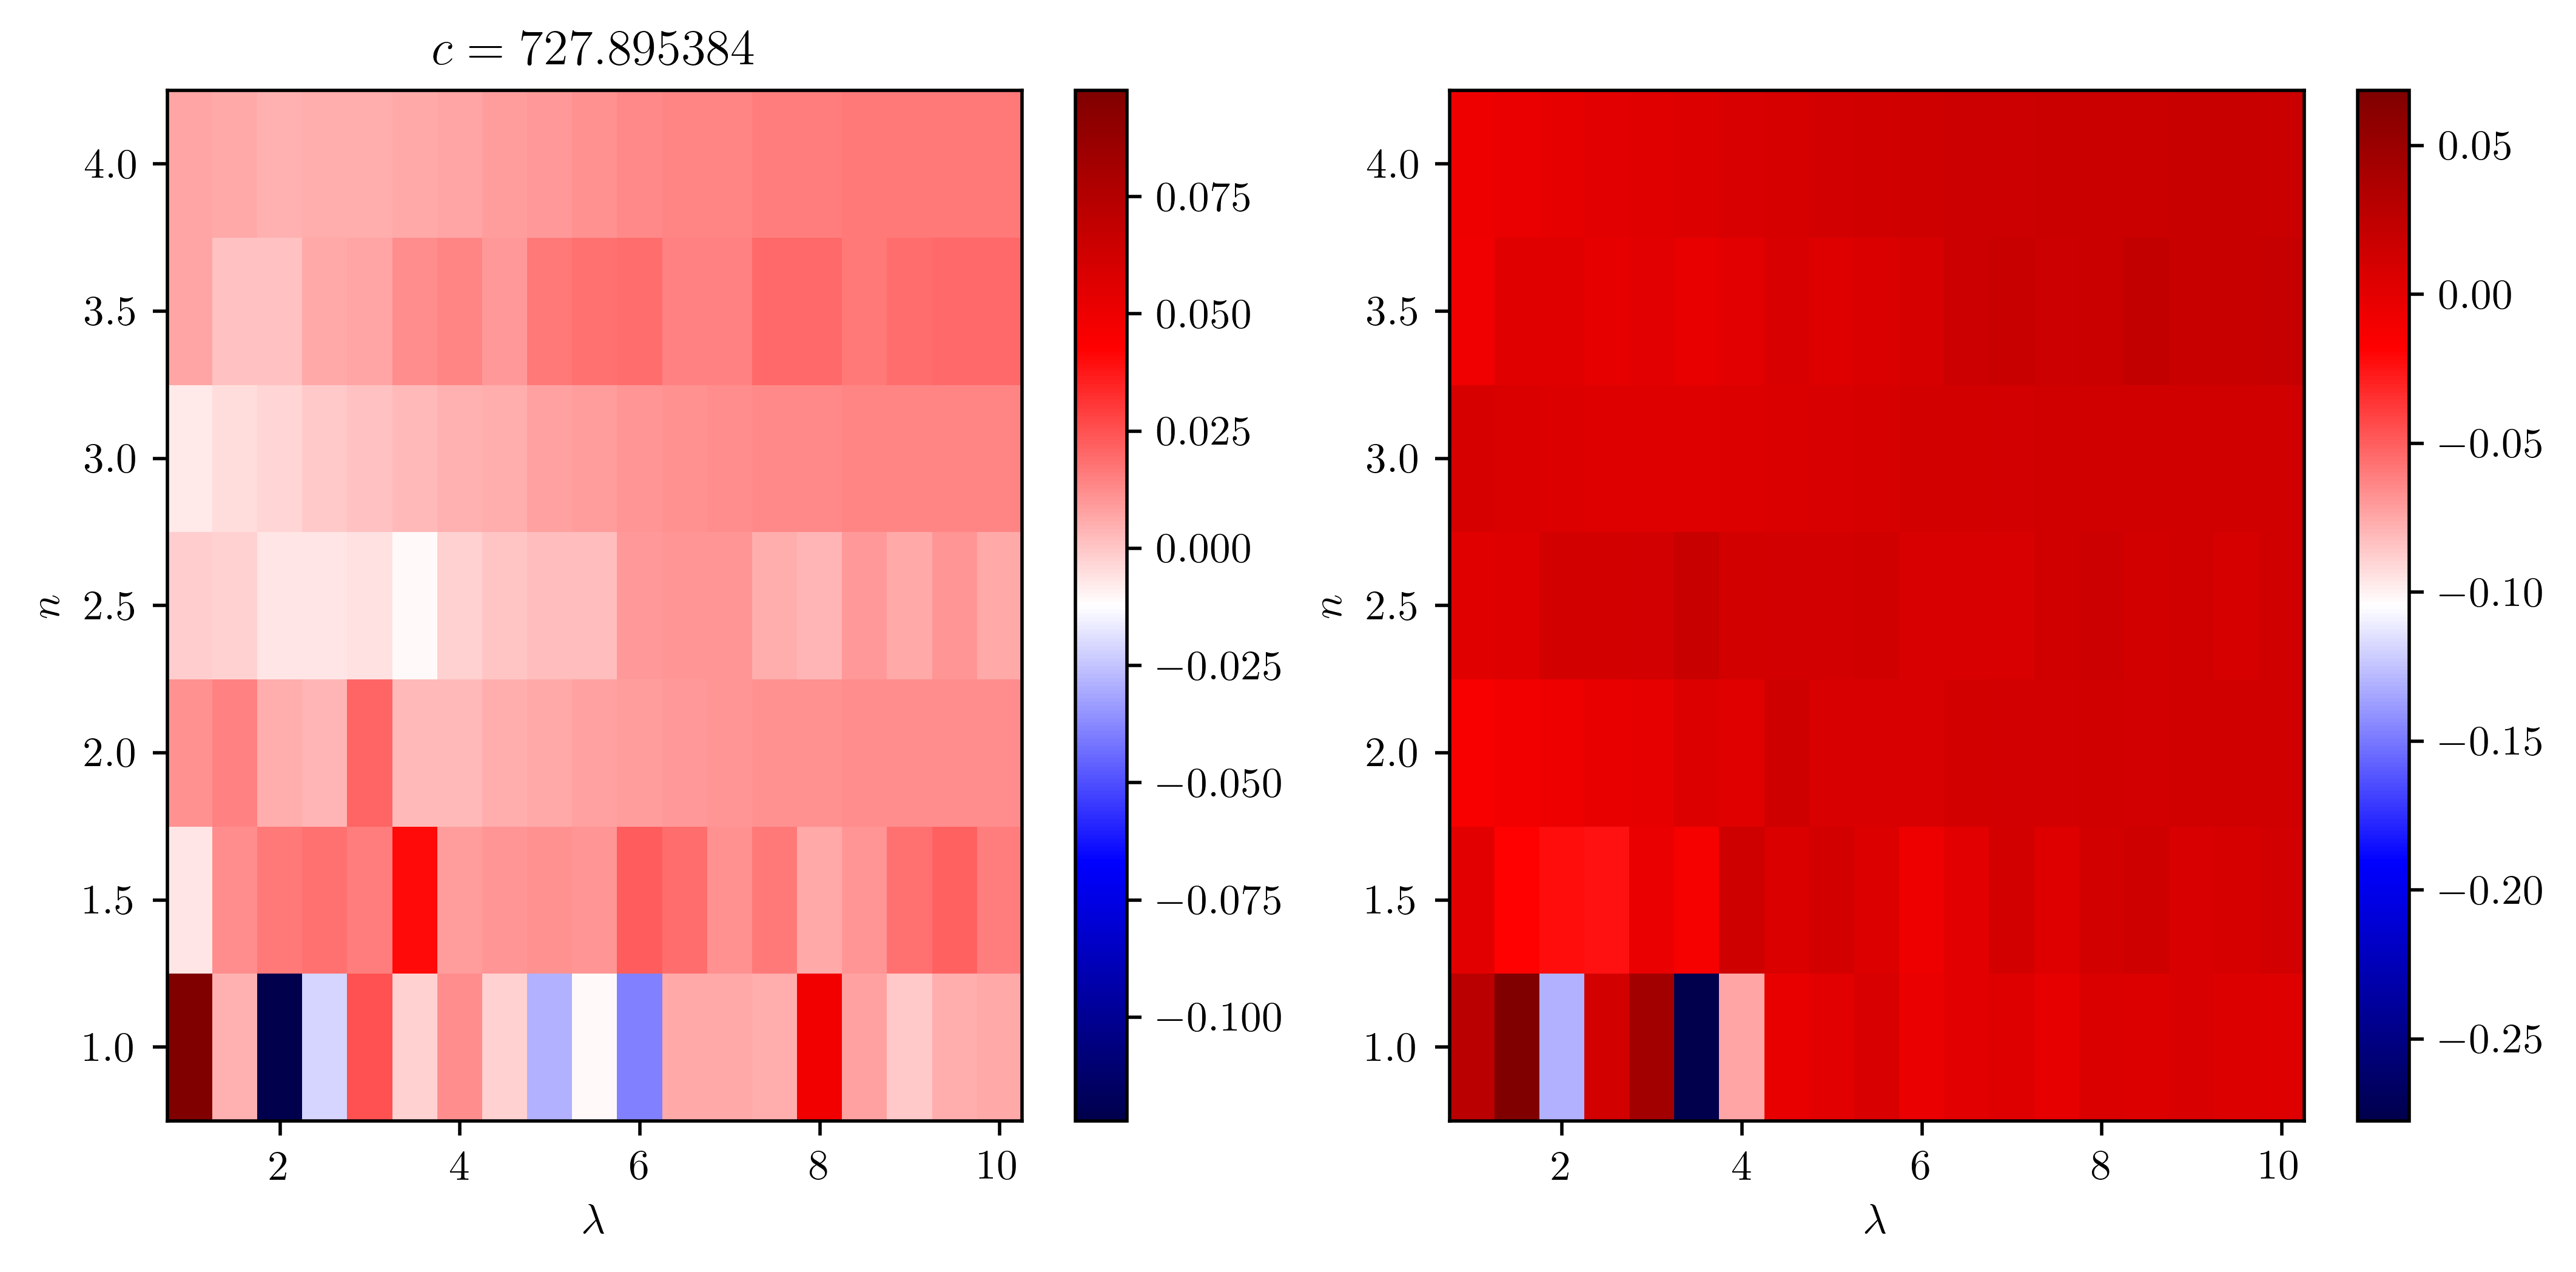

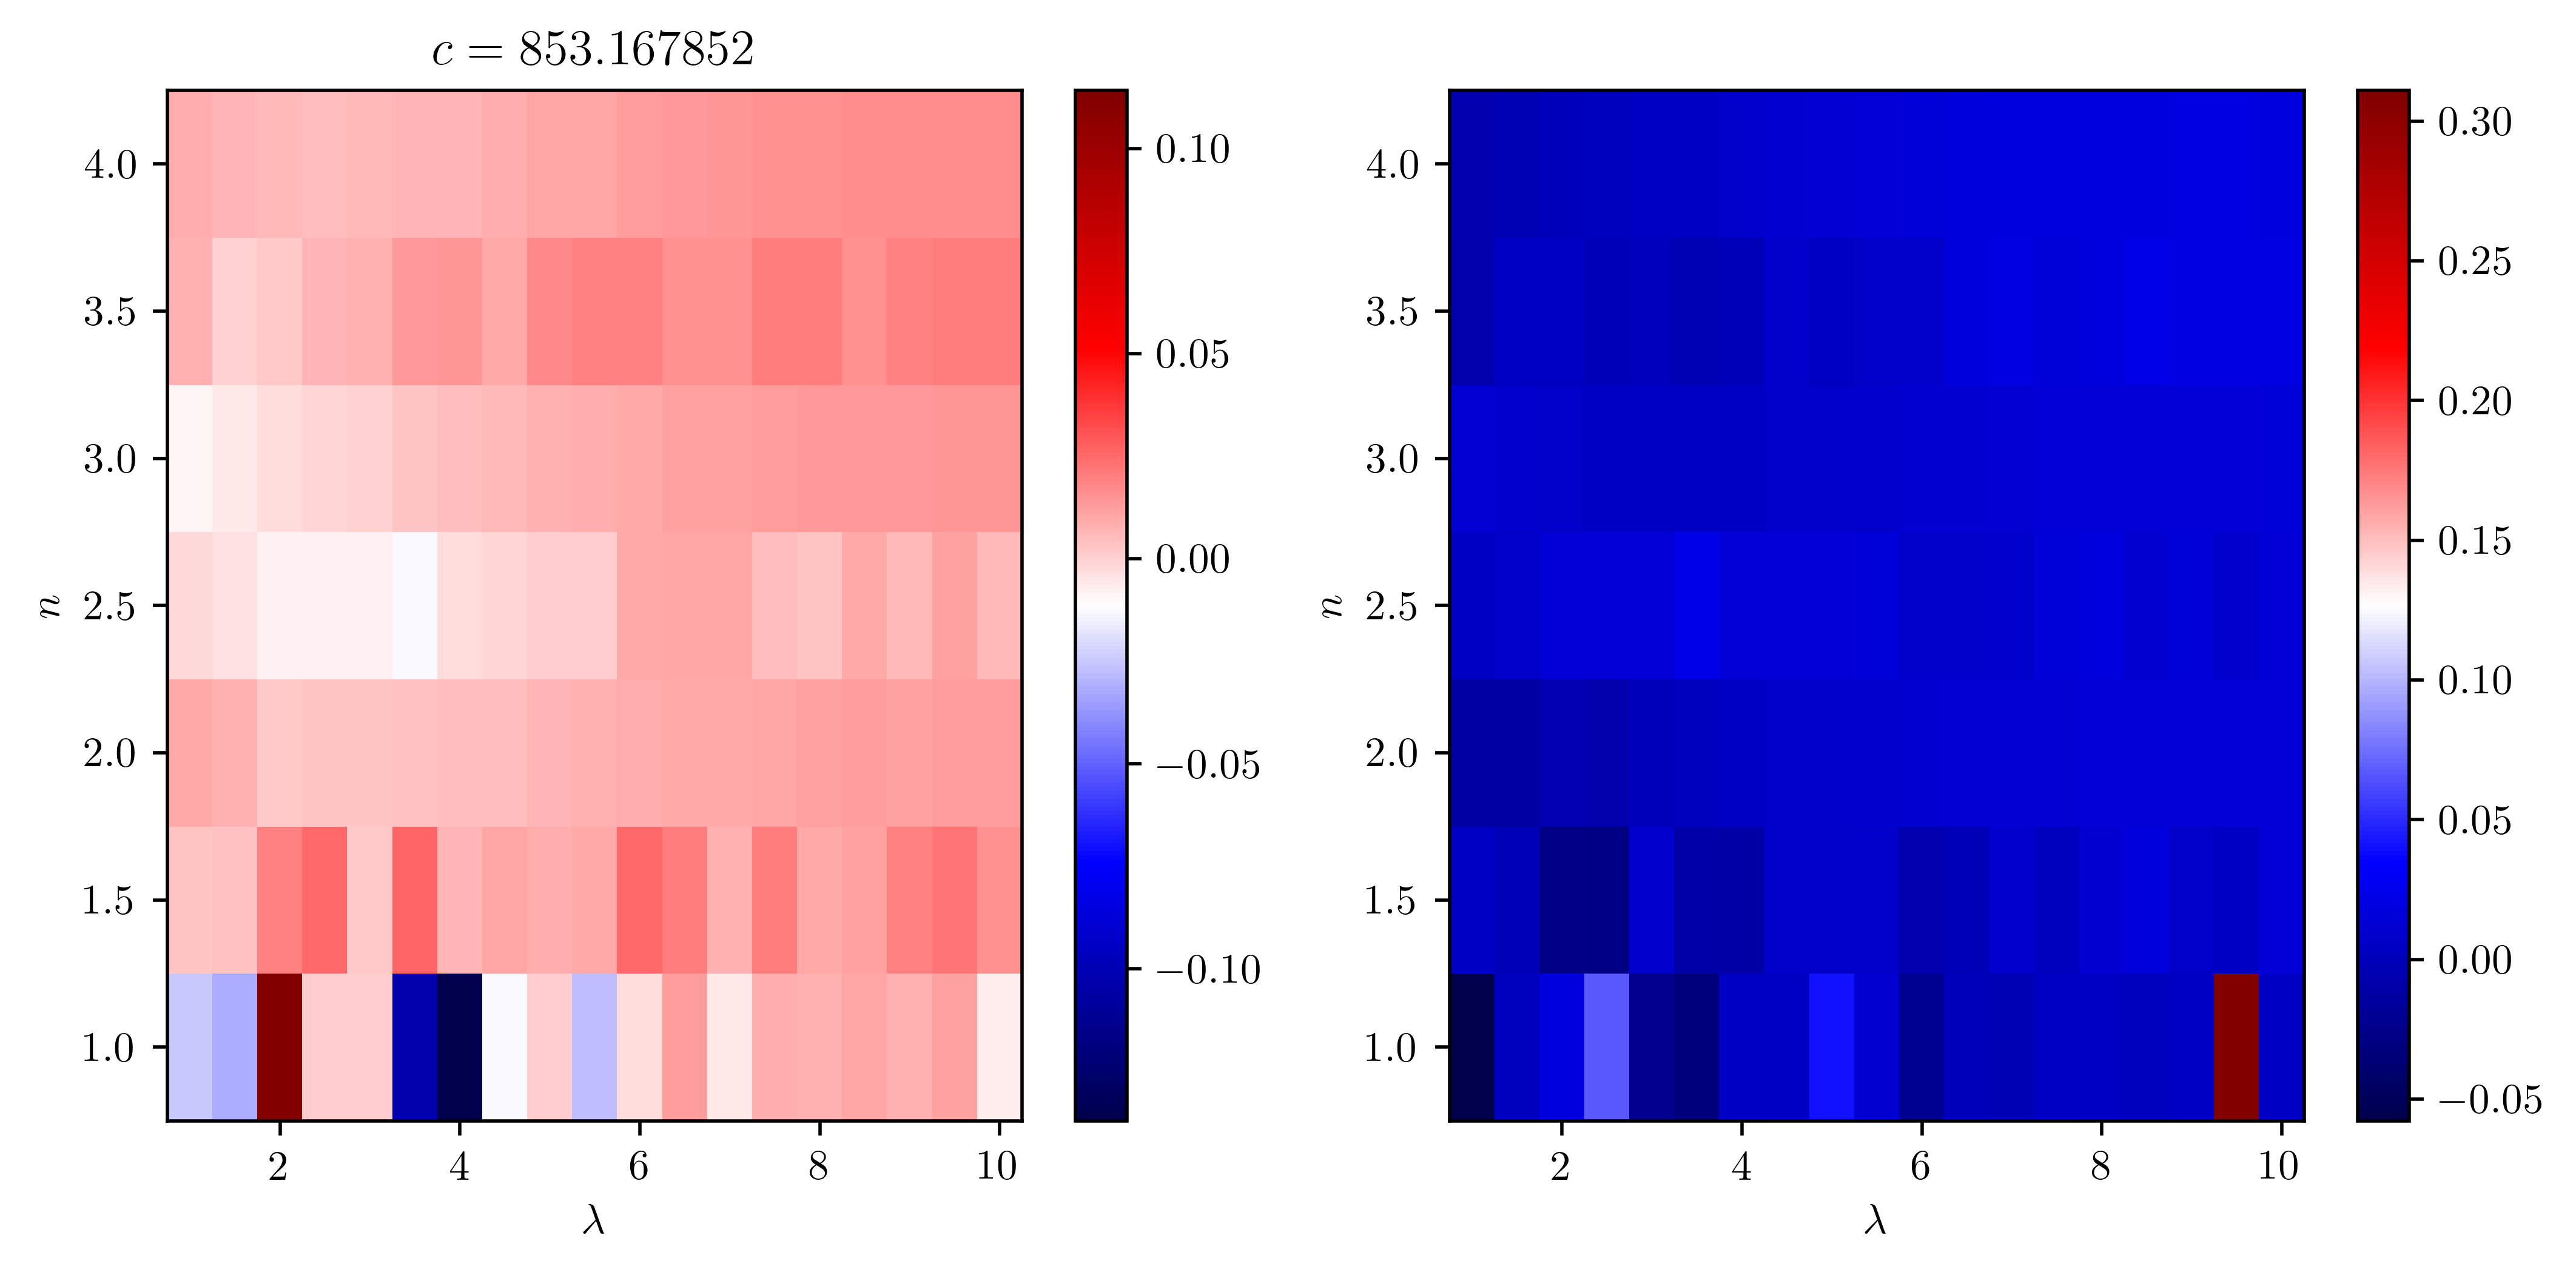

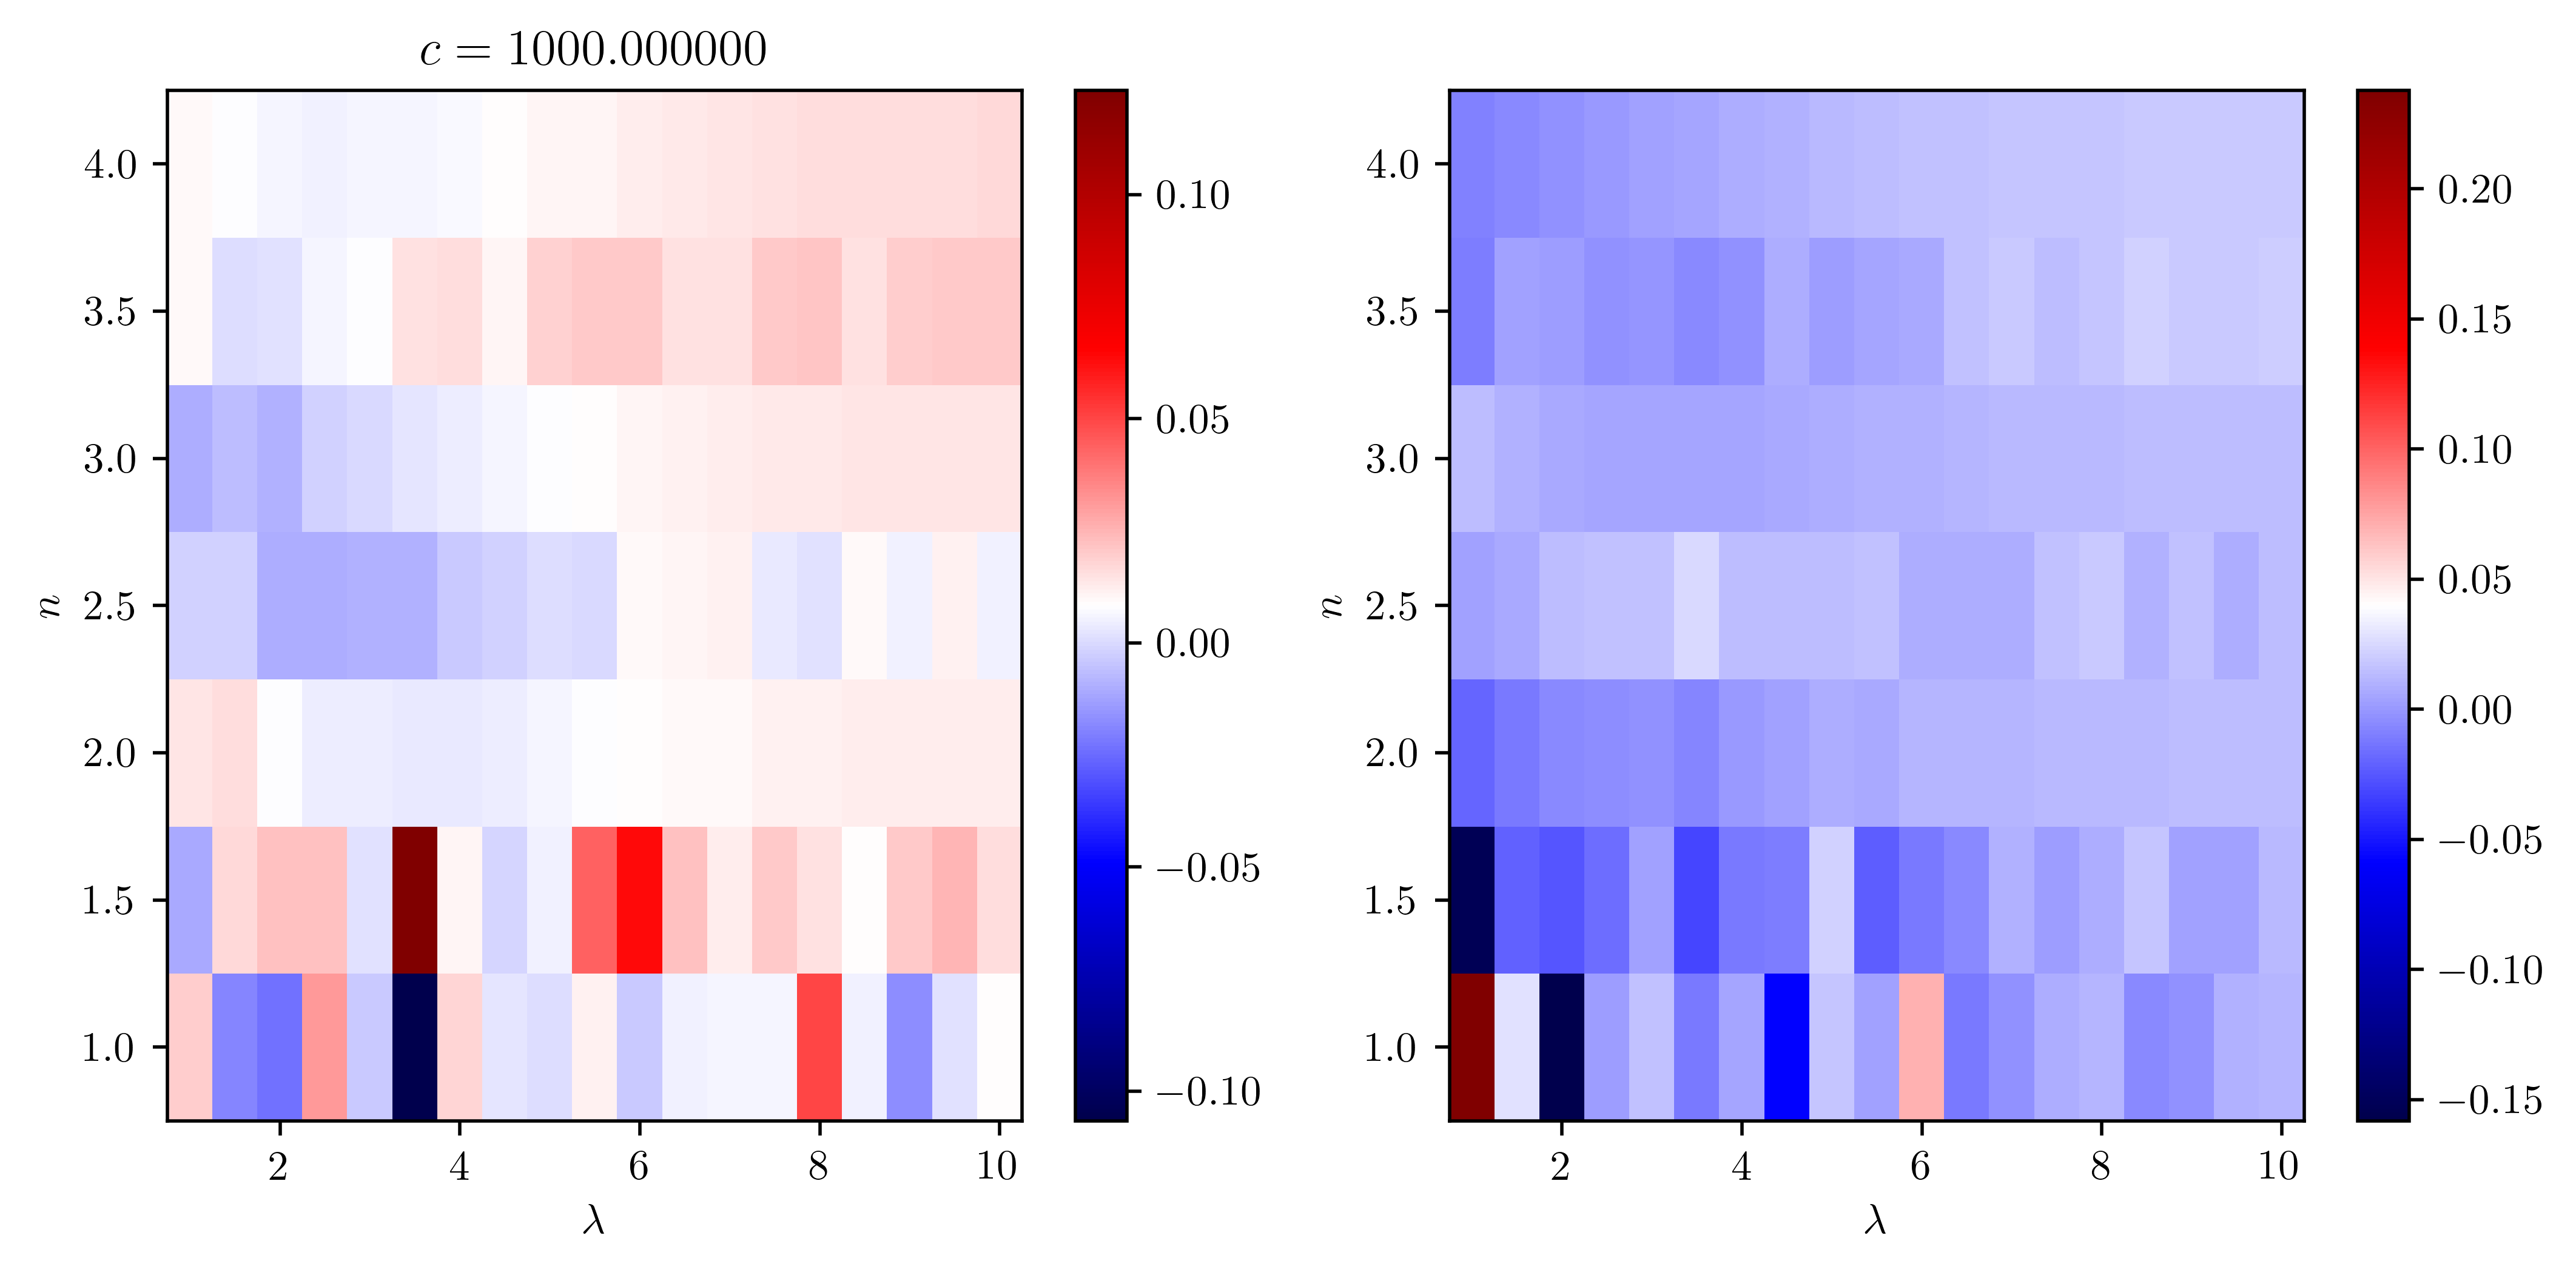

In [6]:
# %matplotlib notebook
%matplotlib inline
figsize=np.array((20, 9))*0.5
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
vmin, vmax = -10, 10
cmap = plt.get_cmap('seismic')

for helicoid_r in data.A.columns.values[:]:
    fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
    fig.patch.set_facecolor('white')

    t1 = (data.B1 / data.A)[helicoid_r].unstack()
    tph = t1.index.values  # ph
    tch = t1.columns.values  # ch
    axi = axs[0]
    # im = axi.pcolor(tph, tch, t1.values.T, vmin=vmin, vmax=vmax)
    im = axi.pcolor(tph, tch, t1.values.T, cmap=cmap, shading='auto')
    fig.colorbar(im, ax=axi, orientation='vertical')
    axi.set_xlabel('$\\lambda$')
    axi.set_ylabel('$n$')
    axi.set_title('$c=%f$' % helicoid_r)

    t1 = (data.B2 / data.A)[helicoid_r].unstack()
    tph = t1.index.values  # ph
    tch = t1.columns.values  # ch
    axi = axs[1]
    # im = axi.pcolor(tph, tch, t1.values.T, vmin=vmin, vmax=vmax)
    im = axi.pcolor(tph, tch, t1.values.T, cmap=cmap, shading='auto')
    fig.colorbar(im, ax=axi, orientation='vertical')
    axi.set_xlabel('$\\lambda$')
    axi.set_ylabel('$n$')

## single helix

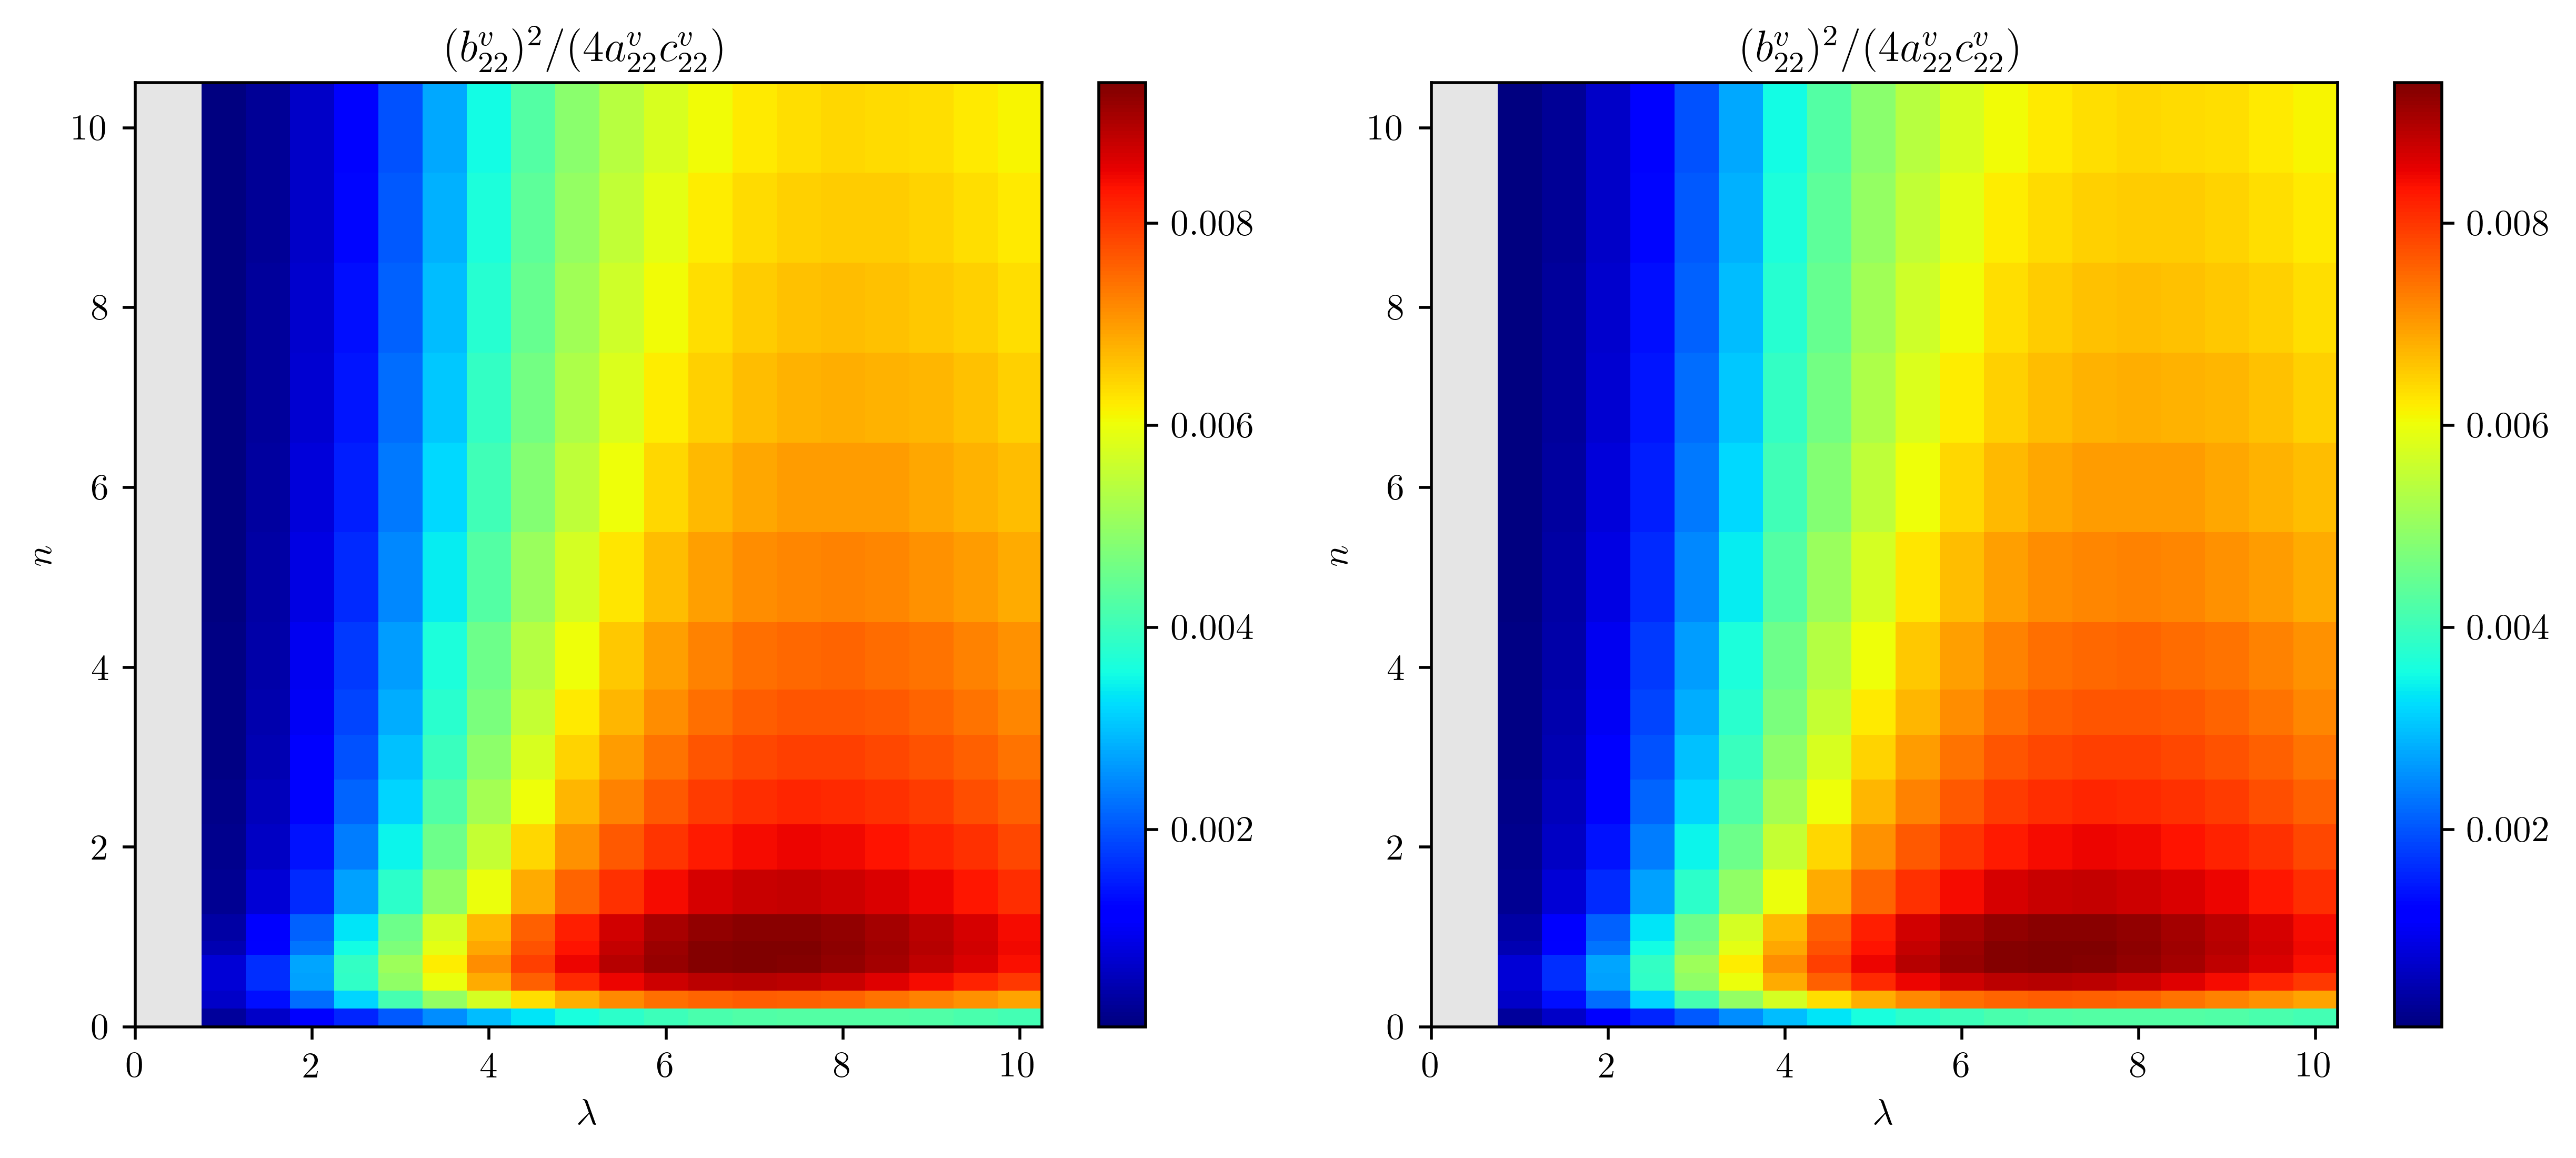

In [7]:
# job_dir = 'hlxPart_th0_c'
job_dir = 'hlxPart_th0'

tdir = os.path.join(os.getcwd(), job_dir)
problem_kwarg_list, A_list, B1_list, B2_list, C_list = spf_re.load_ABC_list(tdir)
A_22_list = np.array([i0[2, 2] for i0 in A_list])
B1_22_list = np.array([i0[2, 2] for i0 in B1_list])
B2_22_list = np.array([i0[2, 2] for i0 in B2_list])
C_22_list = np.array([i0[2, 2] for i0 in C_list])
ph_list = np.array([i0['ph'] for i0 in problem_kwarg_list])
ch_list = np.array([i0['ch'] for i0 in problem_kwarg_list])

data_hlx = pd.DataFrame({'A_22': A_22_list, 
                         'B1_22': B1_22_list, 
                         'B2_22': B2_22_list, 
                         'C_22': C_22_list, 
                         'ph': ph_list, 
                         'ch': ch_list, 
                         }).pivot_table(index=['ph'], columns=['ch'])

# %matplotlib notebook
%matplotlib inline
from matplotlib.colors import *

figsize=np.array((20, 9))*0.5
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
vmin, vmax, midpoint = -0.03, 0.005, 0
# vmin, vmax = -0.02, 0.02
# cmap = plt.get_cmap('seismic')
cmap = plt.get_cmap('jet')

fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
# norm = spf.midLinearNorm(midpoint=midpoint, vmin=vmin, vmax=vmax)
norm = Normalize()
# norm = LogNorm()

t1 = (data_hlx.B1_22 * data_hlx.B1_22) / (4 * data_hlx.A_22 * data_hlx.C_22)
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
axi = axs[0]
im = axi.pcolormesh(tph, tch, t1.values.T, cmap=cmap, norm=norm, shading='auto')
fig.colorbar(im, ax=axi, orientation='vertical')
axi.set_xlabel('$\\lambda$')
axi.set_ylabel('$n$')
axi.set_xlim((0, axi.get_xlim()[1]))
axi.set_ylim((0, axi.get_ylim()[1]))
axi.patch.set_facecolor('grey')
axi.patch.set_alpha(0.2)
axi.set_title('$(b_{22}^v)^2 / (4 a_{22}^v c_{22}^v)$')
# axi.set_title('$c=%f$' % helicoid_r)

t1 = (data_hlx.B2_22 * data_hlx.B2_22) / (4 * data_hlx.A_22 * data_hlx.C_22)
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
axi = axs[1]
im = axi.pcolormesh(tph, tch, t1.values.T, cmap=cmap, norm=norm, shading='auto')
fig.colorbar(im, ax=axi, orientation='vertical')
axi.set_xlabel('$\\lambda$')
axi.set_ylabel('$n$')
axi.set_xlim((0, axi.get_xlim()[1]))
axi.set_ylim((0, axi.get_ylim()[1]))
axi.patch.set_facecolor('grey')
axi.patch.set_alpha(0.2)
axi.set_title('$(b_{22}^v)^2 / (4 a_{22}^v c_{22}^v)$')

plt.tight_layout()

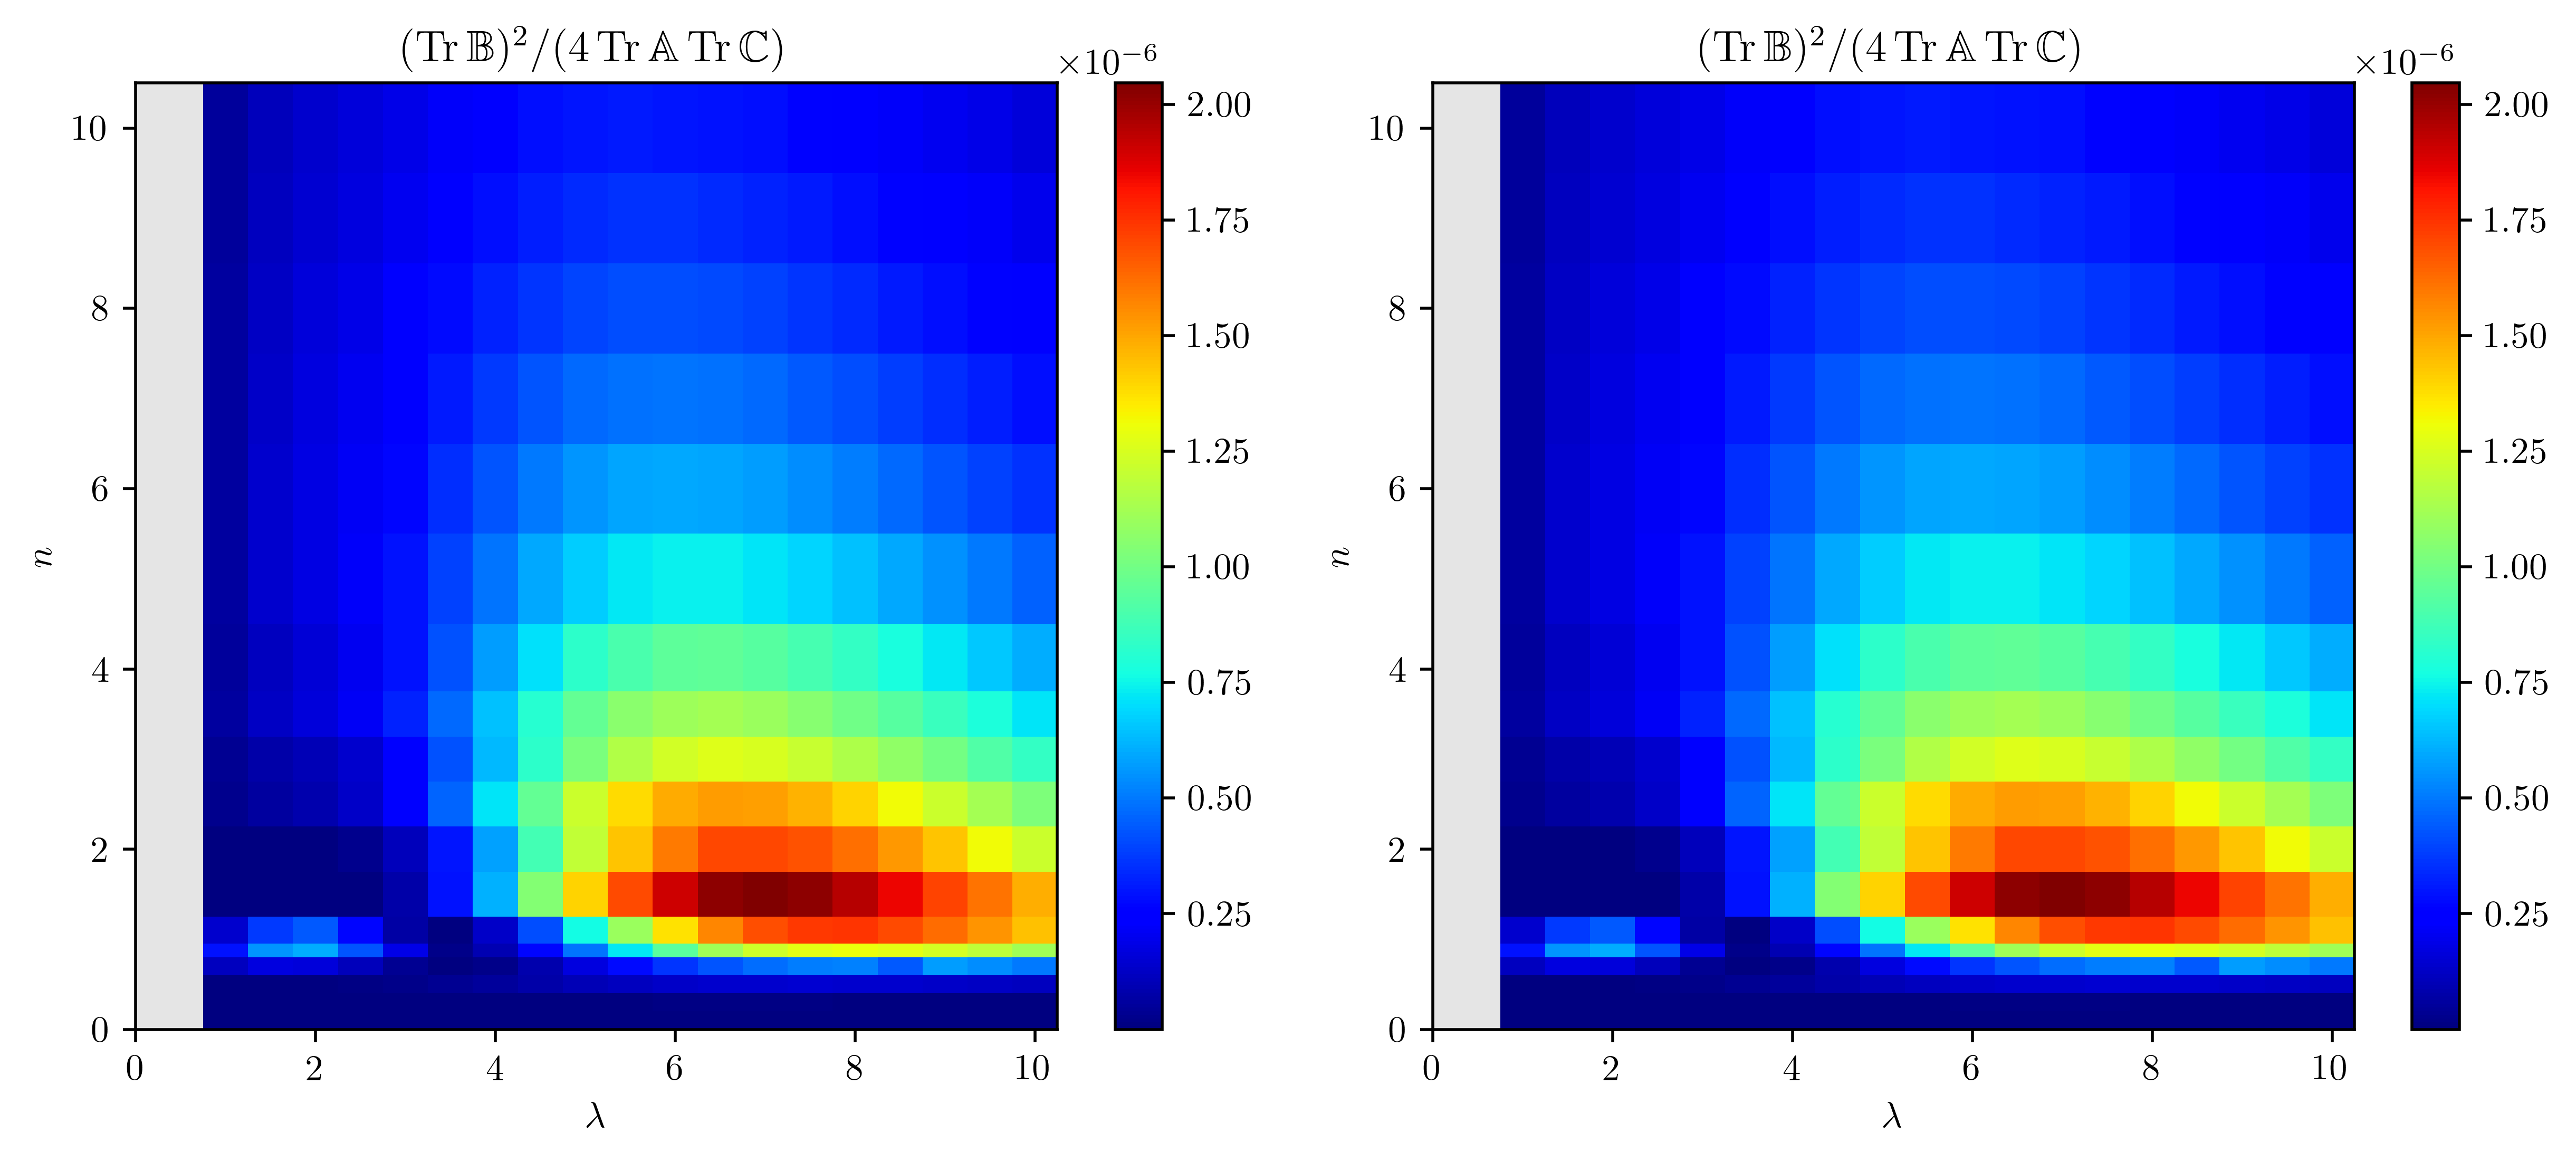

In [9]:
job_dir = 'hlxPart_th0'
# job_dir = 'hlxPart_th0_a'
# job_dir = 'hlxPart_th0_b'
# job_dir = 'hlxPart_th0_c'

tdir = os.path.join(os.getcwd(), job_dir)
problem_kwarg_list, A_list, B1_list, B2_list, C_list = spf_re.load_ABC_list(tdir)
TrA_list = np.array([np.trace(i0) for i0 in A_list])
TrB1_list = np.array([np.trace(i0) for i0 in B1_list])
TrB2_list = np.array([np.trace(i0) for i0 in B2_list])
TrC_list = np.array([np.trace(i0) for i0 in C_list])
ph_list = np.array([i0['ph'] for i0 in problem_kwarg_list])
ch_list = np.array([i0['ch'] for i0 in problem_kwarg_list])

data_hlx = pd.DataFrame({'TrA': TrA_list, 
                         'TrB1': TrB1_list, 
                         'TrB2': TrB2_list, 
                         'TrC': TrC_list, 
                         'ph': ph_list, 
                         'ch': ch_list, 
                         }).pivot_table(index=['ph'], columns=['ch'])

# %matplotlib notebook
%matplotlib inline
from matplotlib.colors import *

figsize=np.array((20, 9))*0.5
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
vmin, vmax, midpoint = -0.03, 0.005, 0
# vmin, vmax = -0.02, 0.02
# cmap = plt.get_cmap('seismic')
cmap = plt.get_cmap('jet')

fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
# norm = spf.midLinearNorm(midpoint=midpoint, vmin=vmin, vmax=vmax)
norm = Normalize()
# norm = LogNorm()

t1 = (data_hlx.TrB1 * data_hlx.TrB1) / (4 * data_hlx.TrA * data_hlx.TrC)
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
axi = axs[0]
im = axi.pcolormesh(tph, tch, t1.values.T, cmap=cmap, norm=norm, shading='auto')
fig.colorbar(im, ax=axi, orientation='vertical')
axi.set_xlabel('$\\lambda$')
axi.set_ylabel('$n$')
axi.set_xlim((0, axi.get_xlim()[1]))
axi.set_ylim((0, axi.get_ylim()[1]))
axi.patch.set_facecolor('grey')
axi.patch.set_alpha(0.2)
axi.set_title('$(\\Tr \\mathbb{B})^2 / (4 \\Tr \\mathbb{A} \\Tr \\mathbb{C})$')
# axi.set_title('$c=%f$' % helicoid_r)

t1 = (data_hlx.TrB2 * data_hlx.TrB2) / (4 * data_hlx.TrA * data_hlx.TrC)
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
axi = axs[1]
im = axi.pcolormesh(tph, tch, t1.values.T, cmap=cmap, norm=norm, shading='auto')
fig.colorbar(im, ax=axi, orientation='vertical')
axi.set_xlabel('$\\lambda$')
axi.set_ylabel('$n$')
axi.set_xlim((0, axi.get_xlim()[1]))
axi.set_ylim((0, axi.get_ylim()[1]))
axi.patch.set_facecolor('grey')
axi.patch.set_alpha(0.2)
axi.set_title('$(\\Tr \\mathbb{B})^2 / (4 \\Tr \\mathbb{A} \\Tr \\mathbb{C})$')

plt.tight_layout()

In [21]:
B2_list[0]

array([[ 0.587  ,  0.31713, -4.1897 ],
       [ 0.31719,  0.58708, -4.18968],
       [ 2.85701,  2.85699, -1.1777 ]])

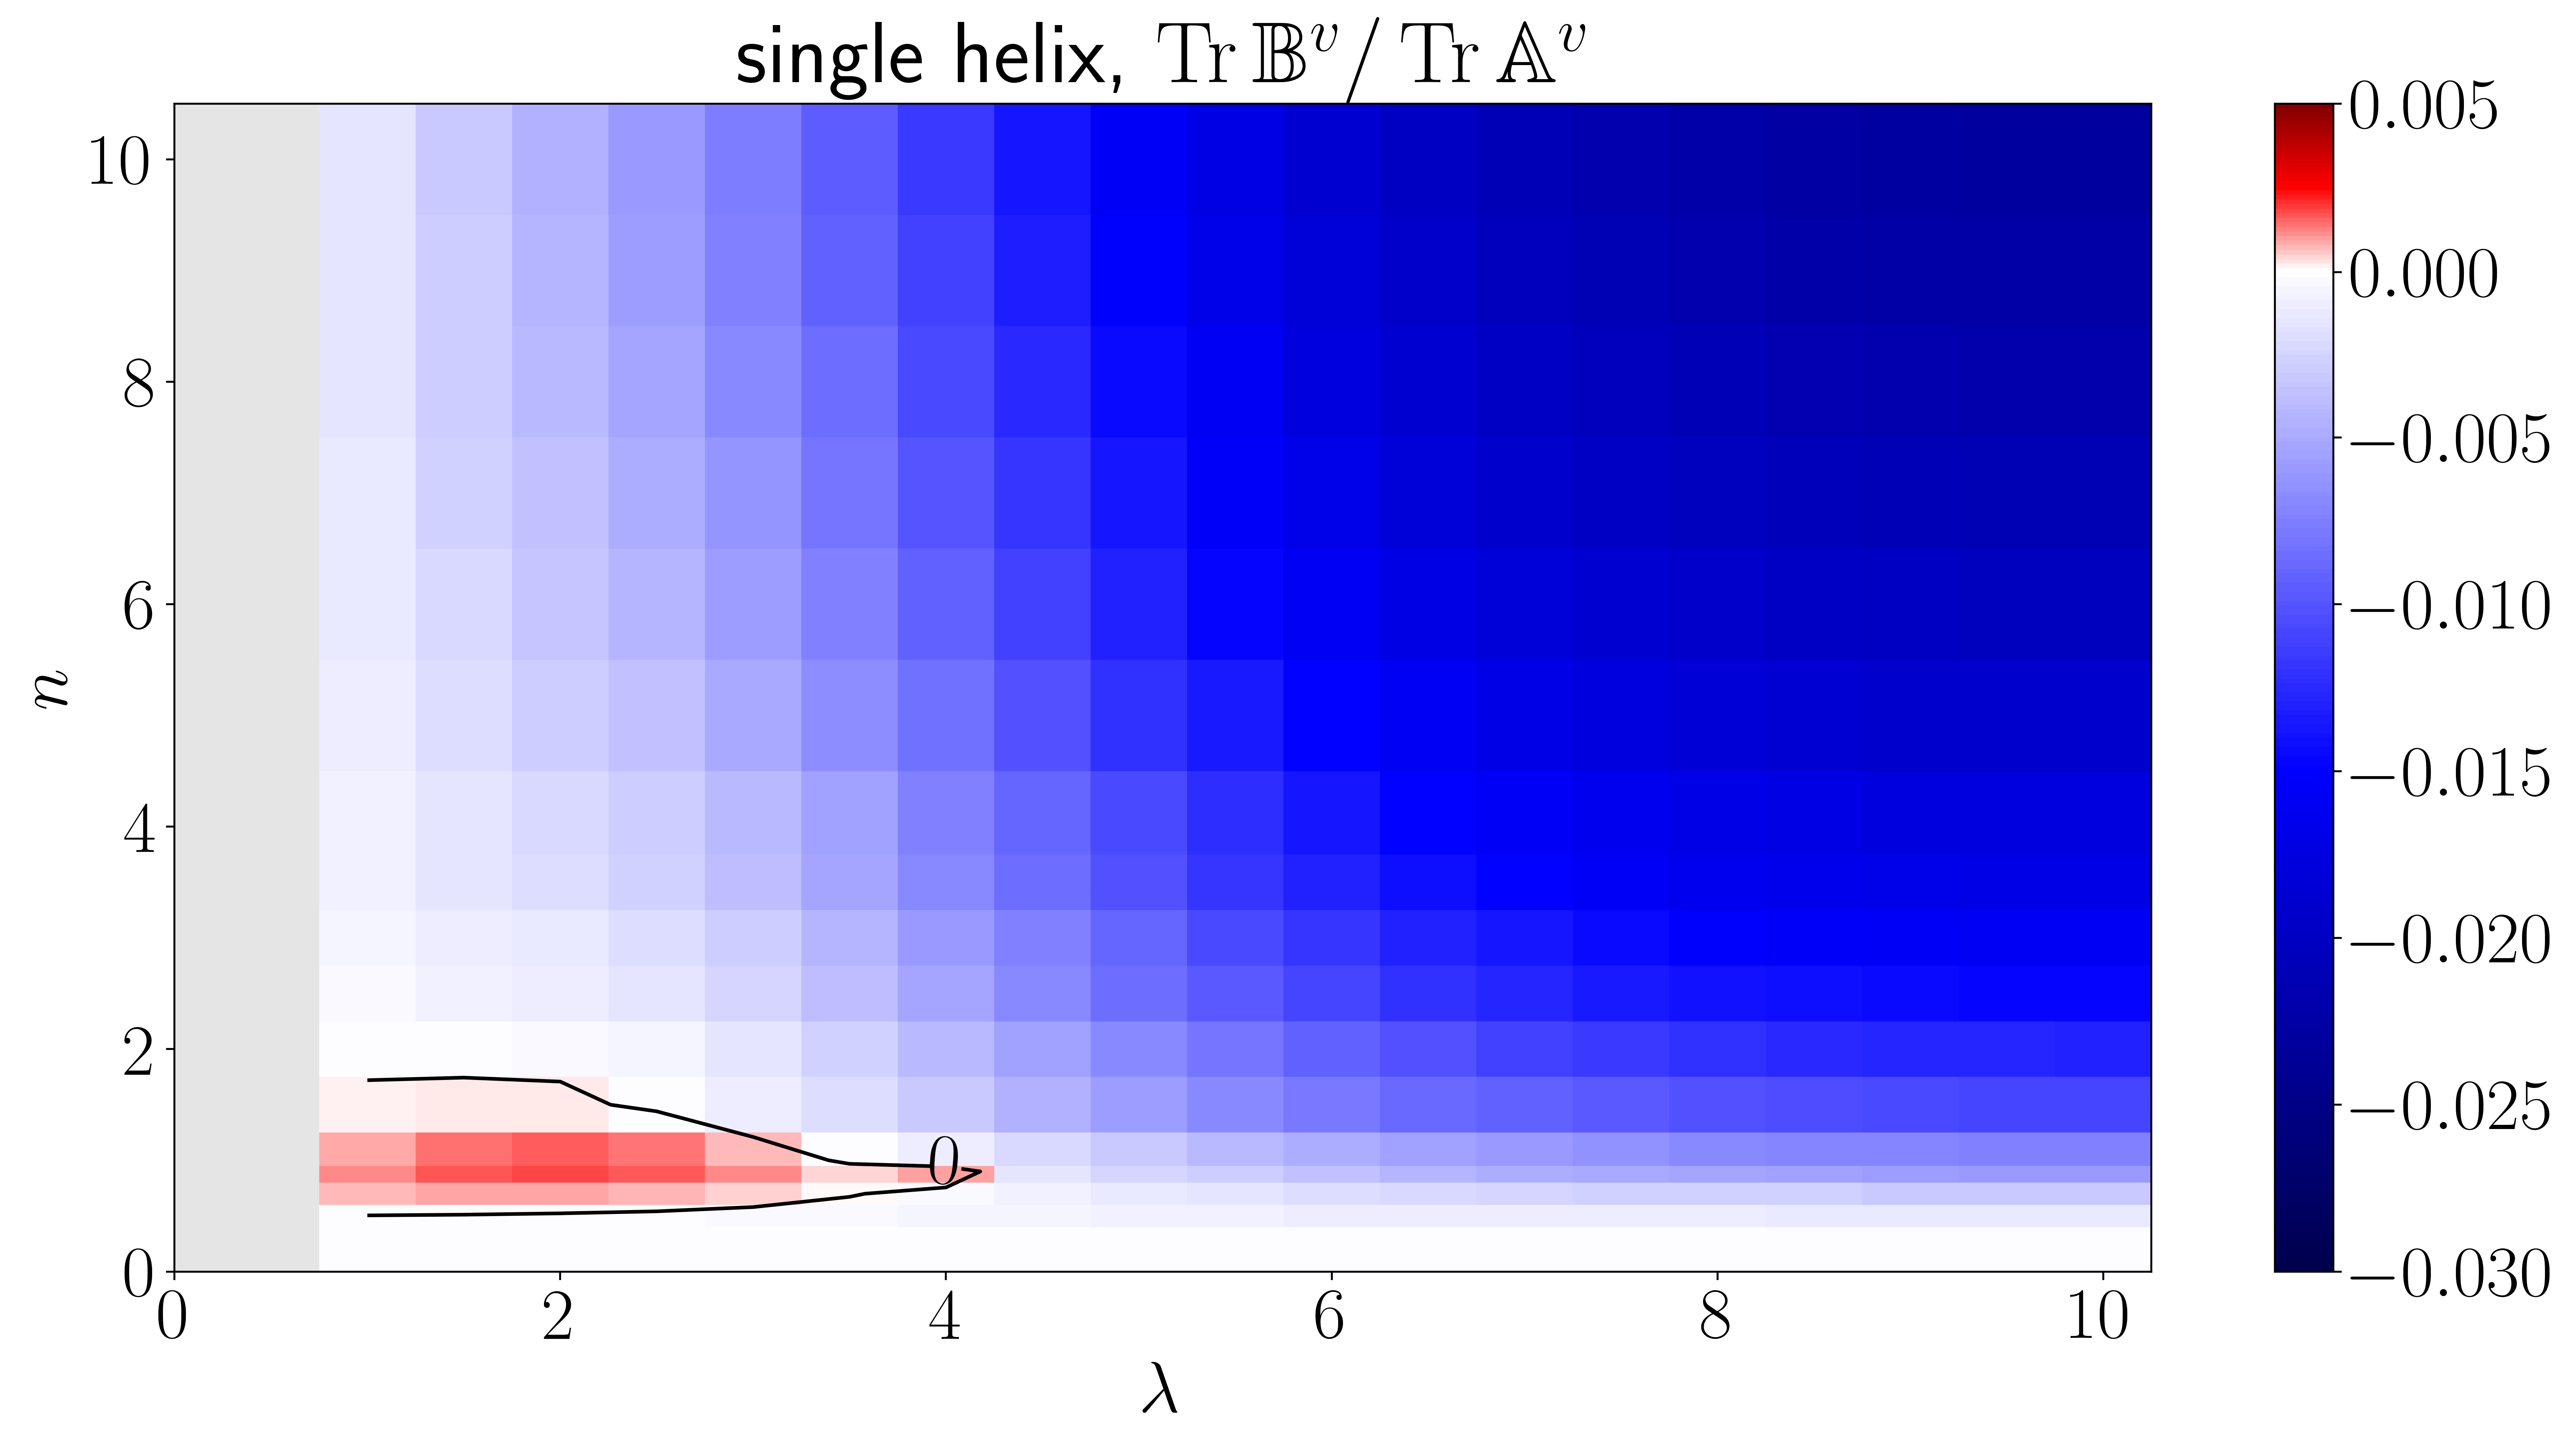

In [23]:
job_dir = 'hlxPart_th0'
# job_dir = 'hlxPart_th0_a'
# job_dir = 'hlxPart_th0_b'
# job_dir = 'hlxPart_th0_c'

tdir = os.path.join(os.getcwd(), job_dir)
problem_kwarg_list, A_list, B1_list, B2_list, C_list = spf_re.load_ABC_list(tdir)
TrA_list = np.array([np.trace(i0) for i0 in A_list])
TrB1_list = np.array([np.trace(i0) for i0 in B1_list])
TrB2_list = np.array([np.trace(i0) for i0 in B2_list])
TrC_list = np.array([np.trace(i0) for i0 in C_list])

A_00_list = np.array([i0[0, 0] for i0 in A_list])
B1_00_list = np.array([i0[0, 0] for i0 in B1_list])
B2_00_list = np.array([i0[0, 0] for i0 in B2_list])
C_00_list = np.array([i0[0, 0] for i0 in C_list])
A_11_list = np.array([i0[1, 1] for i0 in A_list])
B1_11_list = np.array([i0[1, 1] for i0 in B1_list])
B2_11_list = np.array([i0[1, 1] for i0 in B2_list])
C_11_list = np.array([i0[1, 1] for i0 in C_list])
A_22_list = np.array([i0[2, 2] for i0 in A_list])
B1_22_list = np.array([i0[2, 2] for i0 in B1_list])
B2_22_list = np.array([i0[2, 2] for i0 in B2_list])
C_22_list = np.array([i0[2, 2] for i0 in C_list])

ph_list = np.array([i0['ph'] for i0 in problem_kwarg_list])
ch_list = np.array([i0['ch'] for i0 in problem_kwarg_list])

data_hlx = pd.DataFrame({'TrA': TrA_list, 
                         'TrB1': TrB1_list, 
                         'TrB2': TrB2_list, 
                         'TrC': TrC_list, 
                         'A_00': A_00_list, 
                         'B1_00': B1_00_list, 
                         'B2_00': B2_00_list, 
                         'C_00': C_00_list, 
                         'A_11': A_11_list, 
                         'B1_11': B1_11_list, 
                         'B2_11': B2_11_list, 
                         'C_11': C_11_list, 
                         'A_22': A_22_list, 
                         'B1_22': B1_22_list, 
                         'B2_22': B2_22_list, 
                         'C_22': C_22_list, 
                         'ph': ph_list, 
                         'ch': ch_list, 
                         }).pivot_table(index=['ph'], columns=['ch'])

# %matplotlib notebook
%matplotlib inline
from matplotlib.colors import Normalize

plt.rcParams.update({'font.size': 30})
figsize=np.array((16, 9)) * 1
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
vmin, vmax, midpoint = -0.03, 0.005, 0
# vmin, vmax = -0.02, 0.02
cmap = plt.get_cmap('seismic')

fig, axs = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
norm = spf.midLinearNorm(midpoint=midpoint, vmin=vmin, vmax=vmax)

t1 = data_hlx.TrB1 / data_hlx.TrA
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
tvalue = t1.values.T
axi = axs
im = axi.pcolormesh(tph, tch, tvalue, cmap=cmap, norm=norm, shading='auto')
cs = axi.contour(tph, tch, tvalue, [0, ], colors='k')
axi.clabel(cs, inline=True)
fig.colorbar(im, ax=axi, orientation='vertical')
axi.set_xlabel('$\\lambda$')
axi.set_ylabel('$n$')
axi.set_xlim((0, axi.get_xlim()[1]))
axi.set_ylim((0, axi.get_ylim()[1]))
axi.patch.set_facecolor('grey')
axi.patch.set_alpha(0.2)
axi.set_title('single helix, $\\Tr \\mathbb{B}^v / \\Tr \\mathbb{A}^v$')

plt.tight_layout()

<AxesSubplot:xlabel='ch'>

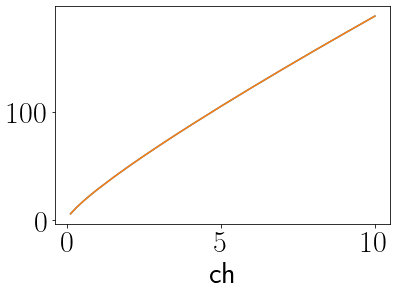

In [16]:
data_hlx.A_00.loc[10].plot()
data_hlx.A_11.loc[10].plot()
# data_hlx.A_22.loc[10].plot()

<AxesSubplot:xlabel='ch'>

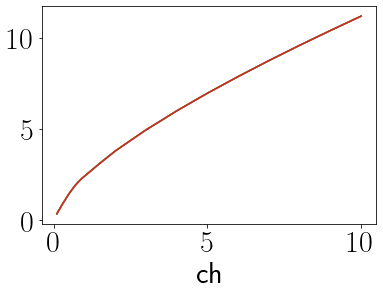

In [19]:
data_hlx.B1_00.loc[10].plot()
data_hlx.B1_11.loc[10].plot()
# data_hlx.A_22.loc[10].plot()
data_hlx.B2_00.loc[10].plot()
data_hlx.B2_11.loc[10].plot()
# data_hlx.A_22.loc[10].plot()

In [ ]:
(data_hlx.B1 / data_hlx.A).loc[10].plot()